# Step 1: The measurement function

In [453]:
import numpy as np
from qiskit.execute_function import execute

from qiskit import BasicAer
backend = BasicAer.get_backend('qasm_simulator')
from qiskit import QuantumCircuit
import qiskit

# qc = QuantumCircuit(7)
# qc.h(0)
# # qc.h(1)

# qc.draw()

def Measurement(operator, quantum_circuit, shots, backend):
    """
    operator: the Pauli matrix we want to measure for the Quantum Nature Gradient Descent with writing in this from (pauli_matrix+is_position). For exammple: (Z1Z2) or (X3)
    quantum_circuit: the circuit for measurement 
    shots: the number of shots that we want to executee
    !!!COMMENT: In my way of measurement, I reverse the qiskit-way of reprent a arbitrary state for more easily handle in my code, if I don't my code would be meesy and changing alot, and more I want measure the same as the we repsent them like XZZ to be X o Z o Z not be reversed like the qiskit does hmmmmmmmmmmmm
    """


    number_of_qubits = quantum_circuit.num_qubits

    cr = qiskit.ClassicalRegister(number_of_qubits)

    
    if len(operator) > (number_of_qubits):
        raise Exception("The position of Pauli matrix exceeds the number of qubits")

    quantum_circuit_to_measurement = QuantumCircuit(number_of_qubits)


    expectation_value = 0

    for i in range(len(operator)):
        if operator[i] == 'X':
            quantum_circuit_to_measurement.ry(-np.pi/2, i)
        if operator[i] == 'Y':
            quantum_circuit_to_measurement.rx(np.pi/2, i)

    new_quantum_circuit_to_measurement = quantum_circuit.compose(quantum_circuit_to_measurement)

    # new_quantum_circuit_to_measurement.add_register(cr)

    # if operator.count('I') == number_of_qubits:
    #     return 1
    # else:
    #     for i in range(len(operator)):
    #         if operator[i] != 'I':
    #             new_quantum_circuit_to_measurement.measure(i,i)
                

    new_quantum_circuit_to_measurement.measure_all()


    job = execute(new_quantum_circuit_to_measurement, backend, shots=shots)

    result = job.result()

    counts = result.get_counts()

    # Reversed the way qiskit represnts state
    counts_change =  {(key)[::-1] : value for key, value in counts.items()}

    

    # for i in range(len(counts)):
    #     if list(counts.keys())[i].count('1') % 2 == 0:
    #         expectation_value += counts[list(counts.keys())[i]]
    #     if list(counts.keys())[i].count('1') % 2 != 0:
    #         expectation_value -= counts[list(counts.keys())[i]]

    position_of_non_I_gate = np.where(np.array(list(operator)) != 'I')[0]
    # expectation_value = 0

    for i in range(len(counts_change)):
        extra_minus = 1
        for j in range(len(position_of_non_I_gate)):
            if list(counts_change.keys())[i][position_of_non_I_gate[j]] == '1':
                extra_minus *= -1
    
    # print(f'{list(counts.keys())[i]} ooo  {extra_minus}')

       
        expectation_value += counts_change[list(counts_change.keys())[i]]*extra_minus
        

    expectation_value = expectation_value/shots

    return expectation_value, counts_change, new_quantum_circuit_to_measurement

In [153]:
a[-3]

'a'

In [154]:
counts = {'111': 535, '100': 465, '011':300, '010':200}

In [155]:
list(counts.keys())[0].count('1')

3

In [156]:
position_of_I_gate = np.where(np.array(list(a)) == 'I')[0]
expectation_value = 0

for i in range(len(counts)):
    extra_minus = 1
    for j in range(len(position_of_I_gate)):
        if list(counts.keys())[i][position_of_I_gate[j]-len(np.array(list(a)))] == '1':
            extra_minus *= -1
    
    print(f'{list(counts.keys())[i]} ooo  {extra_minus}')

    if list(counts.keys())[i].count('1') % 2 == 0:
        expectation_value += counts[list(counts.keys())[i]]*extra_minus
        print(f'{list(counts.keys())[i]} ++ {counts[list(counts.keys())[i]]*extra_minus}')
    if list(counts.keys())[i].count('1') % 2 != 0:
        expectation_value -= counts[list(counts.keys())[i]]*extra_minus
        print(f'{list(counts.keys())[i]} -- {counts[list(counts.keys())[i]]*extra_minus}')

111 ooo  1
111 -- 535
100 ooo  1
100 -- 465
011 ooo  1
011 ++ 300
010 ooo  1
010 -- 200


In [157]:
expectation_value

-900

In [158]:
qc = QuantumCircuit(1)

qc.x(0)
# qc.cx(0,1)
# qc.ry(np.pi,1)
# qc.x(2)

qc.measure_all()

shots = 200

from qiskit import Aer
backend = Aer.get_backend('qasm_simulator')

job = execute(qc, backend, shots=shots)

result = job.result()

counts = result.get_counts()

print(counts)
# new_qc = QuantumCircuit(2)

a =  Measurement('Z', qc, shots, backend)
# b = Measurement('YI', qc, shots, backend)
# c = Measurement('IY', qc, shots, backend)

# d = a[0] - b[0]**2

print(a[0])
# print(a[1])

{'1': 200}
1.0


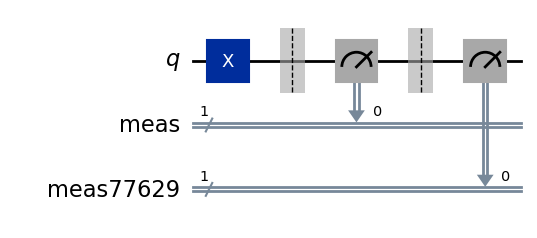

In [159]:
a[2].draw('mpl', style='iqx')

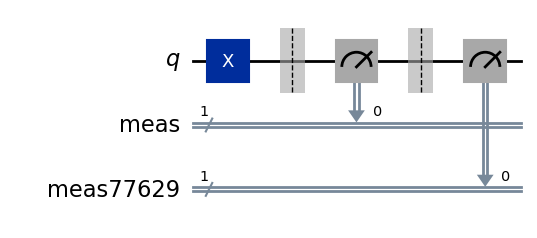

In [160]:
a[2].draw('mpl', style = 'iqx')

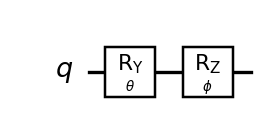

In [161]:
import matplotlib.pyplot as plt

circuit = QuantumCircuit(1, name='2')
theta1 = Parameter(r'$\theta$')
circuit.ry(theta1, 0)
theta2 = Parameter(r'$\phi$')
circuit.rz(theta2, 0)
# plt.figure(figsize=(200,40))
circuit.draw('mpl', style='bw',scale=1.2)

# Step 2: The ansatz

In [483]:
from qiskit.circuit import Parameter
from qiskit import QuantumCircuit

def Customize_EfficientSU2(number_qubits, number_of_subcircuit):
    """
    number_qubits: The amounts of qubits in out system
    number_of_subcircuit: The amounts of subcuirt for parameterized our system
    su2gate: is the gate we want to parameterized with
    insert_barriers: add barriers in our circuit for nice looking
    The function will return the circuit having the parameter and we can update these parameter in our code
    """
    circuit = QuantumCircuit(number_qubits)


    # Use for the 1-qubit case
    if number_qubits == 1:
        for i in range(number_of_subcircuit):
            theta1 = Parameter(r'$\theta[{}]$'.format(2*i))
            circuit.ry(theta1, 0)
            theta2 = Parameter(r'$\theta[{}]$'.format(2*i+1))
            circuit.rz(theta2, 0)

            if i != number_of_subcircuit - 1:
                circuit.barrier()
                circuit.barrier()
        
        return circuit

    
    def add_subcircuit(circuit, stop_barrier):
        sub_circuit = QuantumCircuit(number_qubits)
        number_parameter = circuit.num_parameters

        sub_circuit.barrier()

        # sub_circuit.cx(number_qubits-1, 0)    
        for i in (range(number_qubits-1)):
            sub_circuit.cx(i, i+1)

        # sub_circuit.cx(number_qubits-1, 0)

        sub_circuit.barrier()


        # hmm cause of lack of my knowledge, I will work with the RealAmplitudes ansat, circular entanglement
        for i in range(0, number_qubits):
            theta = Parameter(r'$\theta[{}]$'.format(number_parameter+i))
            sub_circuit.ry(theta, i)
        for i in range(0, number_qubits):
            theta = Parameter(r'$\theta[{}]$'.format(number_qubits+number_parameter+i))
            sub_circuit.rz(theta, i)       


        # if stop_barrier != number_of_subcircuit-1:
        #     sub_circuit.barrier()
        
        # sub_circuit.draw('mpl', style = 'iqx')

        return sub_circuit

    
    for i in range(0, number_qubits):
        theta = Parameter(r'$\theta[{}]$'.format(i))
        circuit.ry(theta, i)

    for i in range(0, number_qubits):
        theta = Parameter(r'$\theta[{}]$'.format(number_qubits+i))
        circuit.rz(theta, i)

    for i in range(number_of_subcircuit):
        circuit = circuit.compose(add_subcircuit(circuit, i))

    return circuit


def Customize_RealAmplidues(number_qubits, number_of_subcircuit):
    """
    number_qubits: The amounts of qubits in out system
    number_of_subcircuit: The amounts of subcuirt for parameterized our system
    su2gate: is the gate we want to parameterized with
    insert_barriers: add barriers in our circuit for nice looking
    The function will return the circuit having the parameter and we can update these parameter in our code
    """
    circuit = QuantumCircuit(number_qubits)


    # Use for the 1-qubit case
    if number_qubits == 1:
        for i in range(number_of_subcircuit):
            theta1 = Parameter(r'$\theta[{}]$'.format(i))
            circuit.ry(theta1, 0)

            if i != number_of_subcircuit - 1:
                circuit.barrier()
                circuit.barrier()
        
        return circuit

    
    def add_subcircuit(circuit, stop_barrier):
        sub_circuit = QuantumCircuit(number_qubits)
        number_parameter = circuit.num_parameters

        sub_circuit.barrier()

        # sub_circuit.cx(number_qubits-1, 0)    
        for i in (range(number_qubits-1)):
            sub_circuit.cx(i, i+1)
        
        sub_circuit.barrier()


        # hmm cause of lack of my knowledge, I will work with the RealAmplitudes ansat, circular entanglement
        for i in range(0, number_qubits):
            theta = Parameter(r'$\theta[{}]$'.format(number_parameter+i))
            sub_circuit.ry(theta, i)   


        # if stop_barrier != number_of_subcircuit-1:
        #     sub_circuit.barrier()
        
        # sub_circuit.draw('mpl', style = 'iqx')

        return sub_circuit

    
    for i in range(0, number_qubits):
        theta = Parameter(r'$\theta[{}]$'.format(i))
        circuit.ry(theta, i)

    # for i in range(0, number_qubits):
    #     theta = Parameter(r'$\theta[{}]$'.format(number_qubits+i))
    #     circuit.rz(theta, i)

    for i in range(number_of_subcircuit):
        circuit = circuit.compose(add_subcircuit(circuit, i))

    return circuit

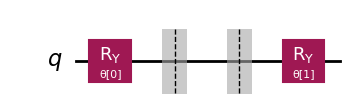

In [163]:
from qiskit.circuit.library import RealAmplitudes

# the rotation gates are chosen randomly, so we set a seed for reproducibility
ansatz = RealAmplitudes(1, reps=1, entanglement='linear', insert_barriers = True) 
ansatz.decompose().draw('mpl', style='iqx')
# ansatz.count_ops()['barrier']

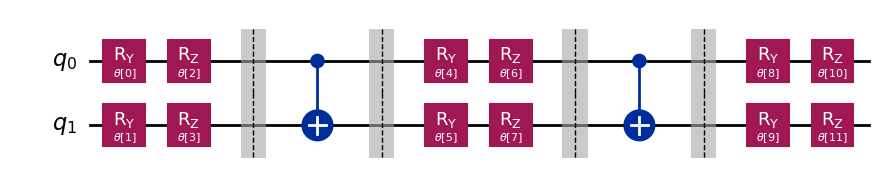

In [164]:
ansatz = Customize_EfficientSU2(2,2)
ansatz.draw('mpl', style = 'iqx')

In [165]:
ansatz_barrier = 0 

for i in range(len(ansatz)):
    if ansatz[i].operation.name == 'barrier':
        ansatz_barrier += 1

print(ansatz_barrier)


4


In [462]:
a = np.array([6.010400000000001, 5.96242, 5.89928, 5.823, 5.721259999999999, 5.6165199999999995, 5.477519999999999, 5.32474, 5.15274, 4.94056, 4.6972, 4.442539999999999, 4.1612, 3.8464400000000003, 3.5042, 3.1543200000000002, 2.77842, 2.3995400000000005, 1.9916800000000001, 1.6249599999999997, 1.2478600000000002, 0.8676200000000001, 0.5617999999999999, 0.28314, 0.001080000000000081, -0.25036, -0.45198000000000005, -0.64014, -0.7720600000000001, -0.9119200000000001, -1.00722, -1.1105, -1.2019000000000002, -1.27508, -1.3439800000000002, -1.4129800000000001, -1.48468, -1.54564, -1.59084, -1.6278, -1.7073, -1.74614, -1.82696, -1.8823, -1.9493, -2.00502, -2.06444, -2.1279600000000003, -2.17622, -2.25556, -2.31496, -2.3492800000000003, -2.41324, -2.45496, -2.4909600000000003, -2.52498, -2.5850600000000004, -2.64004, -2.6505799999999997, -2.6752399999999996, -2.72358, -2.7596999999999996, -2.7866799999999996, -2.8030600000000003, -2.8535000000000004, -2.86902, -2.87782, -2.9086, -2.95288, -2.98136, -3.00258, -3.02264, -3.05616, -3.09472, -3.13086, -3.18746, -3.2138600000000004, -3.26192, -3.29638, -3.3402000000000003, -3.38898, -3.45892, -3.5249800000000002, -3.55846, -3.61864, -3.6948399999999997, -3.76276, -3.8018, -3.8768400000000005, -3.9602999999999997, -4.0348, -4.078259999999999, -4.16492, -4.25014, -4.317100000000001, -4.3811800000000005, -4.46082, -4.5199, -4.57928, -4.64896, -4.71762, -4.76616, -4.83664, -4.89858, -4.94046, -5.0226, -5.0667, -5.11596, -5.15412, -5.2070799999999995, -5.2596799999999995, -5.30592, -5.33428, -5.3676, -5.40978, -5.47142, -5.4851, -5.53514, -5.56166, -5.59568, -5.6111200000000006, -5.6479, -5.67348, -5.7016599999999995, -5.72764, -5.74804, -5.77672, -5.7965, -5.82296, -5.83732, -5.84992, -5.87382, -5.8995999999999995, -5.92166, -5.92656, -5.93504, -5.960579999999999, -5.97348, -5.99882, -6.00036, -6.01342, -6.01514, -6.037000000000001, -6.0380199999999995, -6.05326, -6.07038, -6.0590399999999995, -6.0795200000000005, -6.08198, -6.08348, -6.0974200000000005, -6.10092, -6.12194, -6.12044, -6.12036, -6.11542, -6.13514, -6.12974, -6.14628, -6.128120000000001, -6.1489, -6.147880000000001, -6.159739999999999, -6.15118, -6.16864, -6.16606, -6.172179999999999, -6.17344, -6.1747, -6.1709000000000005, -6.1950199999999995, -6.187659999999999, -6.18668, -6.183260000000001, -6.18126, -6.188359999999999, -6.19684, -6.19656, -6.20262, -6.20326, -6.19734, -6.20806, -6.20452, -6.20652, -6.2126, -6.212420000000001, -6.21558, -6.2158999999999995, -6.2151000000000005, -6.21276, -6.2233, -6.221780000000001, -6.21608, -6.223460000000001, -6.22686, -6.237400000000001, -6.230720000000001, -6.2332, -6.23926, -6.22438])

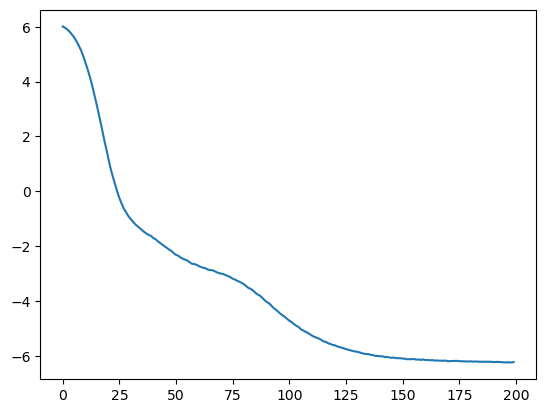

In [444]:
plt.plot(a)

In [459]:
b = np.array([5.88286, 5.78678, 5.71234, 5.620839999999999, 5.47138, 5.34132, 5.19272, 5.03706, 4.85326, 4.62392, 4.40544, 4.13034, 3.8196, 3.53348, 3.19616, 2.8248599999999997, 2.45754, 2.0599000000000003, 1.66704, 1.25916, 0.89792, 0.50346, 0.15951999999999994, -0.18930000000000002, -0.46354000000000006, -0.7277200000000001, -0.9615400000000001, -1.2103000000000002, -1.39988, -1.5590199999999999, -1.6896399999999998, -1.86656, -1.9355999999999998, -2.06706, -2.16518, -2.22976, -2.2920000000000003, -2.3572200000000003, -2.4422999999999995, -2.49996, -2.56788, -2.60082, -2.64252, -2.6825400000000004, -2.6958, -2.7385, -2.78518, -2.8019800000000004, -2.82282, -2.8495999999999997, -2.8837200000000003, -2.8943199999999996, -2.9172599999999997, -2.93744, -2.96124, -2.95086, -2.98692, -3.01544, -3.0331400000000004, -3.03998, -3.06796, -3.07168, -3.1028, -3.1150999999999995, -3.14424, -3.15118, -3.1923399999999997, -3.22626, -3.22206, -3.24872, -3.29106, -3.3208, -3.33378, -3.3869, -3.4316400000000002, -3.48336, -3.4953000000000003, -3.5551, -3.60262, -3.65984, -3.70668, -3.78812, -3.8318000000000003, -3.9111000000000002, -3.98858, -4.05456, -4.1079, -4.21078, -4.27338, -4.3414399999999995, -4.43098, -4.505240000000001, -4.59192, -4.6647799999999995, -4.751479999999999, -4.8065999999999995, -4.9062600000000005, -4.98604, -5.06334, -5.114, -5.1963, -5.241199999999999, -5.29094, -5.3362, -5.38788, -5.42664, -5.4616, -5.4937000000000005, -5.5315, -5.552239999999999, -5.56932, -5.59434, -5.60452, -5.62394, -5.632, -5.6517599999999995, -5.64376, -5.6578800000000005, -5.677379999999999, -5.6604, -5.67204, -5.67632, -5.684200000000001, -5.69208, -5.69786, -5.7058599999999995, -5.70158, -5.714460000000001, -5.73224, -5.739520000000001, -5.74986, -5.74854, -5.768879999999999, -5.77128, -5.79666, -5.8057, -5.8172999999999995, -5.82616, -5.8432200000000005, -5.83748, -5.86156, -5.8891, -5.89164, -5.90256, -5.919499999999999, -5.933120000000001, -5.9425799999999995, -5.95018, -5.95864, -5.980639999999999, -5.9792, -5.99494, -5.99786, -6.022259999999999, -6.01478, -6.029680000000001, -6.03386, -6.044079999999999, -6.05692, -6.057320000000001, -6.06824, -6.07442, -6.08092, -6.07176, -6.084300000000001, -6.08342, -6.100960000000001, -6.10504, -6.10848, -6.108140000000001, -6.11916, -6.1189599999999995, -6.123659999999999, -6.13076, -6.1258799999999995, -6.128900000000001, -6.130520000000001, -6.1359, -6.13786, -6.14378, -6.14598, -6.148020000000001, -6.15984, -6.16704, -6.15688, -6.15578, -6.163539999999999, -6.173039999999999, -6.1654599999999995, -6.1739, -6.17448, -6.17608, -6.17906, -6.18952, -6.18582, -6.18168, -6.19202, -6.192920000000001, -6.198359999999999, -6.21624])

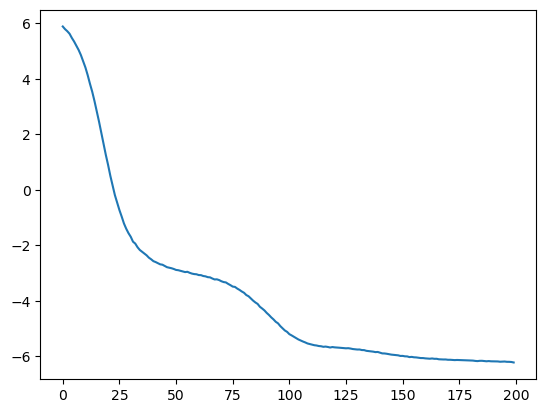

In [446]:
plt.plot(b)

In [166]:
def Seperate_Circuit_Apart(ansantz):
    # Divide the circuit to subcircuit of parameter circuit and non parameter circuit
    super_circuit = []
    no_name = 0

    ansatz_barrier = 0 

    for i in range(len(ansatz)):
        if ansatz[i].operation.name == 'barrier':
            ansatz_barrier += 1


    while no_name < (ansatz.size() + ansatz_barrier):
        if ansatz[no_name].operation.params:
            sub_circuit = QuantumCircuit(ansatz.num_qubits)
            for i in range(no_name, ansatz.num_qubits + no_name):
                sub_circuit.append(ansatz[i])
            super_circuit.append(sub_circuit)
            no_name += ansatz.num_qubits 
            
        elif ansatz[no_name].operation.name == 'barrier':
            no_name += 1
            
        else:
            sub_circuit = QuantumCircuit(ansatz.num_qubits)
            
            while not ansatz[no_name].operation.params:
                if ansatz[no_name].operation.name == 'barrier':
                    no_name += 1
                    break
                sub_circuit.append(ansatz[no_name])
                no_name += 1 

                if no_name == (ansatz.size() + ansatz_barrier - 1):
                    break

            super_circuit.append(sub_circuit)
    return super_circuit

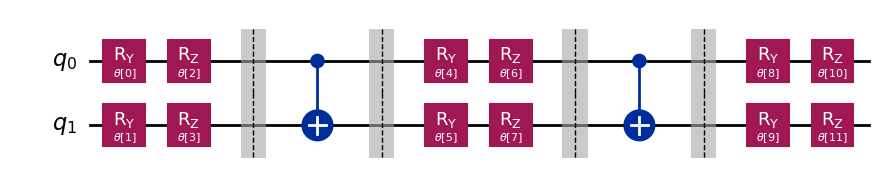

In [167]:
ansatz = Customize_EfficientSU2(2,2)
ansatz.draw('mpl', style='iqx')

In [168]:
a = Seperate_Circuit_Apart(ansatz)

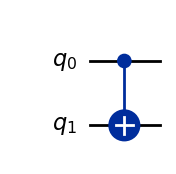

In [169]:
a[5].draw('mpl', style='iqx')

In [170]:
from qiskit.circuit import Parameter
from qiskit import QuantumCircuit


# Step 3: Create the Customize Quantum Natural Gradient Descent

In [34]:
import numpy as np
from scipy.linalg import block_diag

# Parameter shift rule
def Customize_Parameter_Shift_Rule(operator, parameter, eta, ansatz, shots, backend, interation):
    """
    operator: The pauli operator
    parameter: the initial point that we will update until we end up with the desired point
    ansatz: the parameterized circuit that we want to update 
    eta: learning rate
    """
    number_of_parameters = len(parameter)
    grad = np.zeros(number_of_parameters)
    

    for i in range(len(operator)):
        grad_func = np.zeros(number_of_parameters)
        for j in range(number_of_parameters):
            plus_parameter = parameter.copy()
            plus_parameter[j] += np.pi/2
            minus_parameter = parameter.copy()
            minus_parameter[j] -= np.pi/2
            grad_func[j] = (eta)*operator.coeffs.real[i]*(Measurement(str(operator.primitive._pauli_list[i]), ansatz.bind_parameters({theta: plus_parameter[i] for i, theta in enumerate(ansatz.parameters)}), shots, backend)[0] - Measurement(str(operator.primitive._pauli_list[i]), ansatz.bind_parameters({theta: minus_parameter[i] for i, theta in enumerate(ansatz.parameters)}), shots, backend)[0])/2
        grad = np.add(grad, grad_func)
    
    return np.array(grad)


# Gradient
def Customize_Gradient(operator, parameter, eta, ansatz, shots, backend, interation):
    """
    operator: The pauli operator
    parameter: the initial point that we will update until we end up with the desired point
    ansatz: the parameterized circuit that we want to update 
    eta: learning rate
    """
    number_of_parameters = len(parameter)
    grad = np.zeros(number_of_parameters)
    h = .05

    for i in range(len(operator)):
        grad_func = np.zeros(number_of_parameters)
        for j in range(number_of_parameters):
            plus_parameter = parameter.copy()
            plus_parameter[j] += h
            minus_parameter = parameter.copy()
            minus_parameter[j] -= h
            grad_func[j] = (eta)*operator.coeffs.real[i]*(Measurement(str(operator.primitive._pauli_list[i]), ansatz.bind_parameters({theta: plus_parameter[i] for i,
            theta in enumerate(ansatz.parameters)}), shots, backend)[0] - Measurement(str(operator.primitive._pauli_list[i]), ansatz.bind_parameters({theta: minus_parameter[i] for i, theta in enumerate(ansatz.parameters)}), shots, backend)[0])/(2*h)
        grad = np.add(grad, grad_func)
    
    return np.array(grad)

def Seperate_Circuit_Apart(ansantz):
    # Divide the circuit to subcircuit of parameter circuit and non parameter circuit
    super_circuit = []
    no_name = 0

    ansatz_barrier = 0 

    for i in range(len(ansatz)):
        if ansatz[i].operation.name == 'barrier':
            ansatz_barrier += 1


    while no_name < (ansatz.size() + ansatz_barrier):
        if ansatz[no_name].operation.params:
            sub_circuit = QuantumCircuit(ansatz.num_qubits)
            for i in range(no_name, ansatz.num_qubits + no_name):
                sub_circuit.append(ansatz[i])
            super_circuit.append(sub_circuit)
            no_name += ansatz.num_qubits 
            
        elif ansatz[no_name].operation.name == 'barrier':
            no_name += 1
            
        else:
            sub_circuit = QuantumCircuit(ansatz.num_qubits)
            
            while not ansatz[no_name].operation.params:
                if ansatz[no_name].operation.name == 'barrier':
                    no_name += 1
                    break
                sub_circuit.append(ansatz[no_name])
                no_name += 1 

                if no_name == (ansatz.size() + ansatz_barrier - 1):
                    break

            super_circuit.append(sub_circuit)
    return super_circuit




def Customize_Quantum_Natural_Graident_Descent(operator, parameter, eta, ansatz, shots, backend, interation, super_circuit):
    """
    operator: The pauli operator
    parameter: the initial point that we will update until we end up with the desired point
    ansatz: the parameterized circuit that we want to update 
    """

    number_of_parameters = ansatz.num_parameters

    # return parameter_shift_rules(operator, parameter, ansatz)

    # Next, I will calculate the Fubini-Study metric, but first I would like to learn the way of extracting information from the ansatz, and calculate the Fubini-Study metric
    def fubini_stydy_metric(ansatz, parameter, shots, backend):
        def Measure_element_of_Fubini_Study_metric(circuit, circuit_for_measurement, i, j, shots, backend):
            if i != j:
                term1 = ['I']*len(circuit)
                term2 = ['I']*len(circuit)
                term3 = ['I']*len(circuit)
                
                # Change rotation gate to pauli gate
                # Term1
                if circuit[i].operation.name == 'rx':
                    term1[i] = 'X'
                    term2[i] = 'X'
                if circuit[i].operation.name == 'ry':
                    term1[i] = 'Y'
                    term2[i] = 'Y'
                if circuit[i].operation.name == 'rz':
                    term1[i] = 'Z'
                    term2[i] = 'Z'
                
                if circuit[j].operation.name == 'rx':
                    term1[j] = 'X'
                    term3[j] = 'X'
                if circuit[j].operation.name == 'ry':
                    term1[j] = 'Y'
                    term3[j] = 'Y'
                if circuit[j].operation.name == 'rz':
                    term1[j] = 'Z'
                    term3[j] = 'Z'

                # # Term 2
                # if circuit[i].operation.name == 'rx':
                #     term2[i] = 'X'
                # if circuit[i].operation.name == 'ry':
                #     term2[i] = 'Y'
                # if circuit[i].operation.name == 'rz':
                #     term2[i] = 'Z'

                # # Term 3
                # if circuit[j].operation.name == 'rx':
                #     term3[j] = 'X'
                # if circuit[j].operation.name == 'ry':
                #     term3[j] = 'Y'
                # if circuit[j].operation.name == 'rz':
                #     term3[j] = 'Z'
                

                term1 = ''.join(term1)
                term2 = ''.join(term2)
                term3 = ''.join(term3)

                return  (Measurement(term1, circuit_for_measurement, shots, backend)[0] - Measurement(term2, circuit_for_measurement, shots, backend)[0]*Measurement(term3, circuit_for_measurement, shots, backend)[0])/4
            else:
                # term1 = ['I']*len(circuit)
                term2 = ['I']*len(circuit)

                if circuit[i].operation.name == 'rx':
                    term2[i] = 'X'
                if circuit[i].operation.name == 'ry':
                    term2[i] = 'Y'
                if circuit[i].operation.name == 'rz':
                    term2[i] = 'Z'

                term2 = ''.join(term2)

                # new_gate = circuit_for_measurement.compose(new_gate)

                # return (Measurement(term1, circuit_for_measurement, shots, backend)[0] - Measurement(term2, circuit_for_measurement, shots, backend)[0].real**2)/4
                return (1 - Measurement(term2, circuit_for_measurement, shots, backend)[0].real**2)/4


        # Caculate the Fubini-Study metric in 1-qubit
        if ansatz.num_qubits == 1:
            initial_point = parameter
            # num_parameter = 0
            g = np.zeros((number_of_parameters, number_of_parameters))

            for i in range(len(super_circuit)):
                if super_circuit[i][0].operation.params:
                    internal_circuit = QuantumCircuit(super_circuit[i].num_qubits)
                    for j in range(i+1):
                        internal_circuit = internal_circuit.compose(super_circuit[j])

                    internal_circuit = internal_circuit.bind_parameters({theta: initial_point[i] for i, theta in enumerate(internal_circuit.parameters)})
                    # num_parameter += super_circuit[i].num_parameters

                    g[i][i] = Measure_element_of_Fubini_Study_metric(super_circuit[i], internal_circuit, 0, 0, shots, backend)
                    # print(np.round(g_internal,2))
            return g

        
        # Caculate the Fubini_study_metric
        g = []
        initial_point = parameter
        # num_parameter = 0


        for i in range(len(super_circuit)):
            if super_circuit[i][0].operation.params:
                g_internal = [[[] for _ in range(super_circuit[i].num_parameters)] for _ in range(super_circuit[i].num_parameters)]
                internal_circuit = QuantumCircuit(super_circuit[i].num_qubits)
                for j in range(i+1):
                    internal_circuit = internal_circuit.compose(super_circuit[j])

                internal_circuit = internal_circuit.bind_parameters({theta: initial_point[i] for i, theta in enumerate(internal_circuit.parameters)})
                # num_parameter += super_circuit[i].num_parameters

                # print(num_parameter)
                
                for l in range(super_circuit[i].num_parameters):
                    for m in range(super_circuit[i].num_parameters):
                        g_internal[l][m] = Measure_element_of_Fubini_Study_metric(super_circuit[i], internal_circuit, l, m, shots, backend)
                # print(np.round(g_internal,2))
                if g != []:
                    g = block_diag(g, g_internal)
                else:
                    g = block_diag(g_internal)
        # print(g)
        return g
    

    # Gradient of the loss function
    grad = np.zeros(len(parameter))
    
    grad = Customize_Parameter_Shift_Rule(operator, parameter, eta, ansatz, shots, backend, interation)

    
    # grad = gradient(operator, parameter, ansatz)

    # Inverse of Fubini study metric
    FS_metric = np.linalg.pinv(fubini_stydy_metric(ansatz, parameter, shots, backend)).real
    # print(fubini_stydy_metric(ansatz, parameter, shots, backend))

    # print(FS_metric)

    combine = FS_metric.dot(grad)

    # print(f'Fubini-Study metric: {FS_metric}')

    # print(f'combine: {combine}')
    return combine

In [172]:
a = np.array([[1,0], [0, 0.001]])
print(np.linalg.pinv(a))

[[   1.    0.]
 [   0. 1000.]]


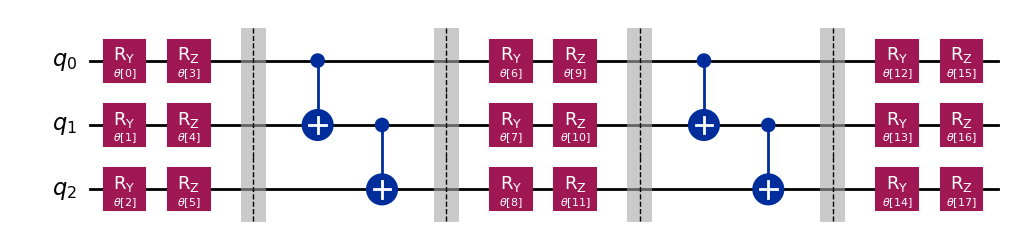

In [173]:
qc = Customize_EfficientSU2(3,2)
qc.draw('mpl', style='iqx')

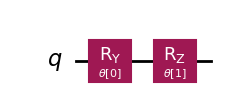

In [174]:
ansatz = Customize_EfficientSU2(num_qubits, 1)
ansatz.draw('mpl', style = 'iqx')

# Customize SPSA optimize

In [175]:
random = [np.random.uniform(-1,1) for _ in range(4)]
print(np.power(random, -1))

[ 1.42841642  2.10989999  1.42051122 -1.5299964 ]


In [176]:
import numpy as np 

def Customize_SPSA(operator, parameter, eta, ansatz, shots, backend, interation):
    """
    operator: The pauli operator
    parameter: the initial point that we will update until we end up with the desired point
    ansatz: the parameterized circuit that we want to update 
    eta: learning rate
    """


    # number_of_parameters = ansatz.num_parameters
    number_of_parameters = len(parameter)
    epsilon = 0.1

    grad = np.zeros(len(parameter))
    
    for i in range(len(operator)):
        random = [np.random.choice([-1,1])*epsilon for _ in range(number_of_parameters)]
        plus_parameter = np.array(parameter.copy())
        plus_parameter = np.add(plus_parameter,random)
        minus_parameter = np.array(parameter.copy())
        minus_parameter = np.subtract(minus_parameter,random)

        grad_func = (eta)*operator.coeffs.real[i]*(Measurement(str(operator.primitive._pauli_list[i]), ansatz.bind_parameters({theta: plus_parameter[i] for i, theta in enumerate(ansatz.parameters)}), shots, backend)[0] - Measurement(str(operator.primitive._pauli_list[i]), ansatz.bind_parameters({theta: minus_parameter[i] for i, theta in enumerate(ansatz.parameters)}), shots, backend)[0])/(2*epsilon)

        grad = np.add(grad, grad_func*np.power(random, -1))



    return grad

In [486]:
def pauli_measurement(operator, ansatz, initial_point, shots, backend):
    """ 
    operator: indicate the sum of serries of Tensor Product Pauli Operator (Hamiltonian)
    ansatz: the parameter circuit
    initial_point: the parameter for our parameter circuit
    shots: number of shots
    backend: the quantum simulator
    retun: the Hamiltonian value
    """
    internal_anstaz = ansatz.bind_parameters({theta: initial_point[k] for k, theta in enumerate(ansatz.parameters)})  

    internal_energy = 0
    for j in range(len(operator)):
        internal_energy += operator.coeffs.real[j] * Measurement(str(operator.primitive._pauli_list[j]), internal_anstaz, shots, backend)[0]
    return internal_energy

def Customize_SPSA(operator, interation, ansatz, initial_point, shots, backend, callback):
    """
    operator: The pauli operator
    interation: number of interation
    initial_point: the initial point that we will update until we end up with the desired point
    ansatz: the parameterized circuit that we want to update 
    """


    # Scaling parameter for the gradient step size.
    # c = np.array([pauli_measurement(operator, ansatz, initial_point, shots, backend) for _ in range(10)]).std()
    c = 1

    # Stability constant for the step size 10% of number of interations
    A = 0.1*interation

    # Scaling exponent for the step size
    alpha = 0.602

    # Scaling exponent for the gradient step size
    gamma = 0.101

    #  Smallest change of magnitude desired in the elements of θ.
    delTheta = 0.05
    
    
    magnitude_g0 = np.abs(Customize_Parameter_Shift_Rule(operator, initial_point, c, ansatz, shots, backend, interation=None)).mean()
    # Scaling parameter for the step size
    a = delTheta*((A+1)**alpha)/magnitude_g0
    
    internal_initial_point = initial_point.copy()

    energy = []

    for k in range(interation):        
        internal_energy = pauli_measurement(operator, ansatz, internal_initial_point, shots, backend)
        print(internal_energy)
        print(internal_initial_point)
        energy.append(internal_energy)


        # Optimization part
        grad = np.zeros(ansatz.num_parameters)
        ak = a/(1+k+A)**alpha
        ck = c/(1+k)**gamma
        
        print(f'ak_{k}: {ak}')
        print(f'ck_{k}: {ck}')
        for i in range(len(operator)):
            random = np.array([np.random.choice([-1,1]) for _ in range(ansatz.num_parameters)])
            # print(random)
            plus_parameter = np.array(internal_initial_point.copy())
            plus_parameter = np.add(plus_parameter,random*ck)
            minus_parameter = np.array(internal_initial_point.copy())
            minus_parameter = np.subtract(minus_parameter,random*ck)
            grad_func = ak*operator.coeffs.real[i]*(Measurement(str(operator.primitive._pauli_list[i]), ansatz.bind_parameters({theta: plus_parameter[i] for i, theta in enumerate(ansatz.parameters)}), shots, backend)[0] - Measurement(str(operator.primitive._pauli_list[i]), ansatz.bind_parameters({theta: minus_parameter[i] for i, theta in enumerate(ansatz.parameters)}), shots, backend)[0])/(2*ck)
            
            grad = np.add(grad, grad_func*random)
        print(f'grad: {grad}')
        internal_initial_point = np.subtract(internal_initial_point, grad)
    
    return energy


In [178]:
np.array([pauli_measurement(hamiltonian, ansatz, initial_point, shots, backend) for _ in range(10)]).std()

0.14498620624045583

In [179]:
from qiskit.opflow import Z, I
from qiskit.quantum_info import Pauli, SparsePauliOp
from qiskit.opflow.primitive_ops.pauli_sum_op import PauliSumOp

hamiltonian = PauliSumOp(SparsePauliOp(['Z', 'X'],
              coeffs=[1,2]), coeff=1.0)

num_qubits = 1

eta = 0.01

shots = 2048

ansatz = Customize_EfficientSU2(num_qubits, 1)

from qiskit import Aer

backend = Aer.get_backend('qasm_simulator')

initial_point = (np.random.random(ansatz.num_parameters))
for i in range(5):
    Customize_Quantum_Natural_Graident_Descent(hamiltonian, initial_point, eta, ansatz, shots, backend)

TypeError: Customize_Quantum_Natural_Graident_Descent() missing 2 required positional arguments: 'interation' and 'super_circuit'

In [ ]:
ansatz = Customize_EfficientSU2(num_qubits, 1)
random1 = np.array([np.random.choice([-1,1]) for _ in range(ansatz.num_parameters)])

# Customize QN-SPSA optimization

In [ ]:
from qiskit import QuantumCircuit
from qiskit import ClassicalRegister
from qiskit import Aer, execute

def SwapTest(circ1, circ2, shots, backend):
    """
    circ1: for the parameter circuit of VQD
    circ2: for the parameter circuit of VQE, this circuit have the infromation from the VQE running, or the k-1 of VQD running
    shots: number of shots
    backend: backend for running
    """

    # Perpare the circuit
    num_qubits = circ1.num_qubits
    circ = QuantumCircuit(2*num_qubits+1) # Plus one for the ancilla qubit

    circ = circ.compose(circ1, [i for i in range(1, num_qubits+1)])
    circ = circ.compose(circ2, [i for i in range(num_qubits+1, num_qubits*2+1)])
    circ.barrier()

    circ.h(0)

    for i in range(1, num_qubits+1):
        circ.cswap(0, i, i+num_qubits)

    circ.h(0) 


    # Make measurement
    measurement = ClassicalRegister(1)
    circ.add_register(measurement)
    circ.measure(0, 0)

    result = execute(circ, backend, shots=shots).result()

    counts = result.get_counts()

    overlap_value = 0

    if '1' in counts:
        # Key exists, do something with data['value']
        overlap_value = counts['1']
    else:
        # Key doesn't exist, return to default value (0 in this case)
        overlap_value = 0
    
    overlap_value = 1 - 2*overlap_value/shots

    

    
    return overlap_value, circ

def Customize_QN_SPSA(operator, interation, ansatz, initial_point, shots, backend, callback):
    """
    operator: The pauli operator
    interation: number of interation
    initial_point: the initial point that we will update until we end up with the desired point
    ansatz: the parameterized circuit that we want to update 
    """


    # Scaling parameter for the gradient step size.
    # c = np.array([pauli_measurement(operator, ansatz, initial_point, shots, backend) for _ in range(10)]).std()
    # c = 0.08
    c = 1

    # Stability constant for the step size 10% of number of interations
    A = 0.1*interation

    # Scaling exponent for the step size
    alpha = 0.602

    # Scaling exponent for the gradient step size
    gamma = 0.101

    #  Smallest change of magnitude desired in the elements of θ.
    # delTheta = 0.001
    delTheta = 0.05
    
    
    magnitude_g0 = np.abs(Customize_Parameter_Shift_Rule(operator, initial_point, c, ansatz, shots, backend, interation=None)).mean()
    # Scaling parameter for the step size
    a = delTheta*((A+1)**alpha)/magnitude_g0
    # a = 0.001

    #  regularization coefficient
    beta = 0.05
    
    internal_initial_point = initial_point.copy()

    energy = []

    regularized_fubini_matrix_previous = np.zeros((ansatz.num_parameters, ansatz.num_parameters))

    for k in range(interation):        
        internal_energy = pauli_measurement(operator, ansatz, internal_initial_point, shots, backend)
        print(internal_energy)
        print(internal_initial_point)
        energy.append(internal_energy)

        grad = np.zeros(ansatz.num_parameters)
        # SPSA part
        gradSPSA = np.zeros(ansatz.num_parameters)
        ak = a/(1+k+A)**alpha
        # ak = 0.001
        ck = c/(1+k)**gamma
        # ck = 0.05
        
        print(f'ak_{k}: {ak}')
        print(f'ck_{k}: {ck}')
        for i in range(len(operator)):
            random = np.array([np.random.choice([-1,1]) for _ in range(ansatz.num_parameters)])
            # print(random)
            plus_parameter = np.array(internal_initial_point.copy())
            plus_parameter = np.add(plus_parameter,random*ck)
            minus_parameter = np.array(internal_initial_point.copy())
            minus_parameter = np.subtract(minus_parameter,random*ck)
            grad_func = operator.coeffs.real[i]*(Measurement(str(operator.primitive._pauli_list[i]), ansatz.bind_parameters({theta: plus_parameter[i] for i, theta in enumerate(ansatz.parameters)}), shots, backend)[0] - Measurement(str(operator.primitive._pauli_list[i]), ansatz.bind_parameters({theta: minus_parameter[i] for i, theta in enumerate(ansatz.parameters)}), shots, backend)[0])/(2*ck)
            
            gradSPSA = np.add(gradSPSA, grad_func*random)
        
        print(f'gradSPSA {gradSPSA}')

        
        # Natural Gradient Part
        random1 = np.array([np.random.choice([-1,1]) for _ in range(ansatz.num_parameters)])
        random2 = np.array([np.random.choice([-1,1]) for _ in range(ansatz.num_parameters)])
        initial_plus1_plus2 = np.add(initial_point, np.add(ck*random1, ck*random2))
        initial_plus1 = np.add(initial_point, ck*random1)
        initial_minus1_plus2 = np.subtract(initial_point, np.subtract(ck*random1, ck*random2))
        initial_minus1 = np.subtract(initial_point, ck*random1)

        ansatz_initial = ansatz.bind_parameters({theta: initial_point[k] for k, theta in enumerate(ansatz.parameters)})  
        ansatz_plus1_plus2 = ansatz.bind_parameters({theta: initial_plus1_plus2[k] for k, theta in enumerate(ansatz.parameters)})  
        ansatz_plus1 = ansatz.bind_parameters({theta: initial_plus1[k] for k, theta in enumerate(ansatz.parameters)})  
        ansatz_minus1_plus2 = ansatz.bind_parameters({theta: initial_minus1_plus2[k] for k, theta in enumerate(ansatz.parameters)})  
        ansatz_minus1 =  ansatz.bind_parameters({theta: initial_minus1[k] for k, theta in enumerate(ansatz.parameters)})  

        deltaF = SwapTest(ansatz_initial, ansatz_plus1_plus2, shots, backend)[0] - SwapTest(ansatz_initial, ansatz_plus1, shots, backend)[0] -SwapTest(ansatz_initial, ansatz_minus1_plus2, shots, backend)[0] + SwapTest(ansatz_initial, ansatz_minus1, shots, backend)[0]

        # Fubini_matrix
        fubini_matrix = -1/2*(deltaF/(2*ck**2))*(np.array(np.array([random1]).T*random2) + np.array(np.array([random2]).T*random1))/2
        
        # Data of previous regularized study metric
        exponentially_smoothed_fubini = k/(k+1)*regularized_fubini_matrix_previous + 1/(k+1)*fubini_matrix.copy()

    
        regularized_fubini_matrix = np.add(np.power(exponentially_smoothed_fubini*exponentially_smoothed_fubini, 1/2), beta*np.identity(ansatz.num_parameters))

        regularized_fubini_matrix_previous = regularized_fubini_matrix

        # print(f'regularized_fubini_matrix---{regularized_fubini_matrix}')

        grad = ak*np.linalg.pinv(regularized_fubini_matrix).dot(gradSPSA)

        print(f'grad: {grad/ak}')
        print(f'parameter {internal_initial_point}')
        internal_initial_point = np.subtract(internal_initial_point, grad)
    
    return energy

# Customize imaginary time evolution

In [55]:
import re
import Magicfile
from qiskit import ClassicalRegister
from qiskit import QuantumRegister
from qiskit import Aer, execute


def  Customize_imaginary_time_evolution(operator, interation, ansatz, eta, initial_point, shots, backend, callback):
    """
    operator: the pauli matrix
    interation: number of interations 
    ansatz: the ansatz for perparing the parameterized circuit
    eta: learning rate but in this case is the time interval of the imaginary time evolution
    initial_points: random sample of number uses at the beggining of running
    shots: number of shots
    backend: the backend
    """

    circ_U = [[[] for _ in range(ansatz.num_parameters)] for _ in range(ansatz.num_parameters)]

    super_circuit = Magicfile.Seperate_Circuit_Apart(ansatz)

    # return the circuit for perpare the evaluate the value of matrix U  
    def circ_for_U_part(ansatz, l, m):
        layer_of_l = 0
        position_of_l = 0
        layer_of_m = 0
        position_of_m = 0


        for i in range(len(super_circuit)):
            if super_circuit[i][0].operation.params:
                # data of the parrameter layer
                a = str(super_circuit[i].data[-1].operation.params[0])
                # b = 0
                # # Problem
                # for num in range(len(a)):
                #     if a[num].isnumeric():
                #         b = int(a[num])
                b = int(re.findall(r'\d+', a)[0])

                if l <= b:
                    layer_of_l = i
                    position_of_l = ansatz.num_qubits - 1 - (b - l)
                    # print(f'layer_of_l: {layer_of_l}')
                    # print(f'position_of_l: {position_of_l}')
                    break
                    

        for i in range(len(super_circuit)):
            if super_circuit[i][0].operation.params:
                # data of the parrameter layer
                a = str(super_circuit[i].data[-1].operation.params[0])
                # b = 0
                # for num in range(len(a)):
                #     if a[num].isnumeric():
                #         b = int(a[num])
                b = int(re.findall(r'\d+', a)[0])

                if m <= b:
                    layer_of_m = i
                    position_of_m = ansatz.num_qubits - 1 - (b - m)
                    # print(f'layer_of_m: {layer_of_m}')
                    # print(f'position_of_m: {position_of_m}')
                    break
        


        circ = QuantumCircuit(ansatz.num_qubits+1)
        ancilla_circ = QuantumCircuit(1)
        ancilla_circ.h(0)
        ancilla_circ.x(0)
        circ = circ.compose(ancilla_circ)

        # circ = circ.bind_parameters({theta: initial_point[k] for k, theta in enumerate(circ.parameters)}) 

        h = 0
        position_h = 0
            
        if l > m:
            h = l
            position_h = position_of_l 
            l = m
            position_of_l = position_of_m
            m = h
            position_of_m = position_h
            

        if l <= m:
            internal_circuit = QuantumCircuit(ansatz.num_qubits)
            for i in range(layer_of_l):
                internal_circuit = internal_circuit.compose(super_circuit[i])
            
            circ = circ.compose(internal_circuit, [i for i in range(1, ansatz.num_qubits+1)])

            circ.barrier()

            if super_circuit[layer_of_l].data[position_of_l].operation.name == 'rx':
                circ.cx(0, position_of_l+1)
            if super_circuit[layer_of_l].data[position_of_l].operation.name == 'ry':
                circ.cy(0, position_of_l+1)
            if super_circuit[layer_of_l].data[position_of_l].operation.name == 'rz':
                circ.cz(0, position_of_l+1)

            circ.barrier()

            circ.x(0)

            internal_circuit = QuantumCircuit(ansatz.num_qubits)
            for i in range(layer_of_l, layer_of_m):
                internal_circuit = internal_circuit.compose(super_circuit[i])

            circ = circ.compose(internal_circuit, [i for i in range(1, ansatz.num_qubits+1)])
            
            circ.barrier()

            if super_circuit[layer_of_m].data[position_of_m].operation.name == 'rx':
                circ.cx(0, position_of_m+1)
            if super_circuit[layer_of_m].data[position_of_m].operation.name == 'ry':
                circ.cy(0, position_of_m+1)
            if super_circuit[layer_of_m].data[position_of_m].operation.name == 'rz':
                circ.cz(0, position_of_m+1)

            circ.barrier()

            # for i in range(layer_of_m, len(super_circuit)):
            #     internal_circuit = internal_circuit.compose(super_circuit[i])

            # circ = circ.compose(internal_circuit, [i for i in range(1, ansatz.num_qubits+1)])

            circ.h(0)   

            measurement = ClassicalRegister(1)
            circ.add_register(measurement)
            circ.measure(0, 0)

        return circ


    def circ_for_C_part(ansatz, l):
        layer_of_l = 0
        position_of_l = 0

        for i in range(len(super_circuit)):   
            if super_circuit[i][0].operation.params:
                # data of the parrameter layer
                a = str(super_circuit[i].data[-1].operation.params[0])
                # b = 0

                # for num in range(len(a)):
                #     if a[num].isnumeric():
                #         b = int(a[num])
                b = int(re.findall(r'\d+', a)[0])

                if l <= b:
                    layer_of_l = i
                    position_of_l = ansatz.num_qubits - 1 - (b - l)
                    # print(f'layer_of_m: {layer_of_m}')
                    # print(f'position_of_m: {position_of_m}')
                    break
            
        circ = QuantumCircuit(ansatz.num_qubits+1)
        ancilla_circ = QuantumCircuit(1)
        ancilla_circ.h(0)
        ancilla_circ.s(0)
        ancilla_circ.x(0)
        circ = circ.compose(ancilla_circ)

        internal_circuit = QuantumCircuit(ansatz.num_qubits)
        for i in range(layer_of_l):
            internal_circuit = internal_circuit.compose(super_circuit[i])
        
        circ = circ.compose(internal_circuit, [i for i in range(1, ansatz.num_qubits+1)])

        circ.barrier()

        if super_circuit[layer_of_l].data[position_of_l].operation.name == 'rx':
            circ.cx(0, position_of_l+1)
        if super_circuit[layer_of_l].data[position_of_l].operation.name == 'ry':
            circ.cy(0, position_of_l+1)
        if super_circuit[layer_of_l].data[position_of_l].operation.name == 'rz':
            circ.cz(0, position_of_l+1)

        circ.barrier()

        circ.x(0)

        internal_circuit = QuantumCircuit(ansatz.num_qubits)
        for i in range(layer_of_l, len(super_circuit)):
            internal_circuit = internal_circuit.compose(super_circuit[i])

        circ = circ.compose(internal_circuit, [i for i in range(1, ansatz.num_qubits+1)])
        
        circ.barrier()
        return circ

    energy = []

    internal_initial_point = initial_point.copy()


    for i in range(ansatz.num_parameters):
        circ_U[i][i] = circ_for_U_part(ansatz, i, i)


    for i in range(ansatz.num_parameters):
        for j in range(i+1, ansatz.num_parameters):
            circ_U[i][j] = circ_for_U_part(ansatz, i, j)
            circ_U[j][i] = circ_for_U_part(ansatz, i, j)

    for i in range(interation):
        print(f'{internal_initial_point} ---------')
        internal_anstaz = ansatz.bind_parameters({theta: internal_initial_point[k] for k, theta in enumerate(ansatz.parameters)})       
        # Measure the expectation of our hamiltonian
        internal_energy = 0
        for j in range(len(operator)):
            internal_energy += operator.coeffs.real[j] * Measurement(str(operator.primitive._pauli_list[j]), internal_anstaz, shots, backend)[0]
        
        energy.append(internal_energy)
        print(internal_energy)


        

        # The U_matrix
        U_matrix = np.zeros((ansatz.num_parameters, ansatz.num_parameters))

        for element in range(ansatz.num_parameters):
            U_matrix[element][element] = 1

        
        for element in range(ansatz.num_parameters):
            for j in range(element+1, ansatz.num_parameters):
                internal_ansatz = circ_U[element][j].copy()
                internal_ansatz = internal_ansatz.bind_parameters({theta: internal_initial_point[k] for k, theta in enumerate(internal_ansatz.parameters)})  
                
                result = execute(internal_ansatz, backend, shots=shots).result()

                counts = result.get_counts()
                overlap_value = 0
                
                if '0' in counts:
                    # Key exists, do something with data['value']
                    overlap_value = counts['0']
                else:
                    # Key doesn't exist, return to default value (0 in this case)
                    overlap_value = 0
                
                U_matrix[element][j] = overlap_value/shots - 1
                U_matrix[j][element] = overlap_value/shots - 1


        # Matrix U
        U_matrix = np.array(U_matrix/4)

        # Circuit for measure the gradient C vector
        # circ_C = [[] for _ in range(ansatz.num_parameters)]


        # for element in range(ansatz.num_parameters):
        #     circ_C[element] = circ_for_C_part(ansatz, element).copy()

        # grad_vector_C = np.zeros(ansatz.num_parameters)
        # # operator = 'ZY'

        # for element in range(ansatz.num_parameters):
        #     for k in range(len(operator)):
        #         internal_circuit = circ_C[element].copy()
        #         string_operator = str(operator.primitive._pauli_list[k])
        #         for m in range(len(string_operator)):
        #             if string_operator[m] == 'X':
        #                 internal_circuit.cx(0, m+1)
        #             if string_operator[m] == 'Y':
        #                 internal_circuit.cy(0, m+1)
        #             if string_operator[m] == 'Z':
        #                 internal_circuit.cz(0, m+1)

        #         internal_circuit = internal_circuit.bind_parameters({theta: internal_initial_point[k] for k, theta in enumerate(internal_circuit.parameters)})  

        #         internal_circuit.h(0)
                
        #         print(f"internal_circuit {len(internal_circuit)}")
        #         print(f"depth of circuit {internal_circuit.depth()}")
        #         # print(f'parameter {i}: {len(internal_circuit)}')

        #         # a = internal_circuit

        #         measurement = ClassicalRegister(1)
        #         internal_circuit.add_register(measurement)
        #         internal_circuit.measure(0, 0)

        #         print(internal_circuit)

        #         result = execute(internal_circuit, backend, shots=shots).result()

        #         counts = result.get_counts()
                
        #         overlap_value = 0
                
        #         if '0' in counts:
        #             # Key exists, do something with data['value']
        #             overlap_value = counts['0']
        #         else:
        #             # Key doesn't exist, return to default value (0 in this case)
        #             overlap_value = 0
                
        #         grad_vector_C[element] -= operator.coeffs.real[k]*(overlap_value/shots - 1)/2
        grad_vector_C = np.zeros(ansatz.num_parameters)
    

        for element in range(len(operator)):
            grad_func = np.zeros(ansatz.num_parameters)
            for j in range(ansatz.num_parameters):
                plus_parameter = internal_initial_point.copy()
                plus_parameter[j] += np.pi/2
                minus_parameter = internal_initial_point.copy()
                minus_parameter[j] -= np.pi/2
                grad_func[j] = (1)*operator.coeffs.real[element]*(Measurement(str(operator.primitive._pauli_list[element]), ansatz.bind_parameters({theta: plus_parameter[i] for i, theta in enumerate(ansatz.parameters)}), shots, backend)[0] - Measurement(str(operator.primitive._pauli_list[element]), ansatz.bind_parameters({theta: minus_parameter[i] for i, theta in enumerate(ansatz.parameters)}), shots, backend)[0])/2
            grad_vector_C = np.subtract(grad_vector_C, grad_func)      
        
        print(f'grad_vector_C: {grad_vector_C}')
        print(f'inverse of U matrix: {np.linalg.pinv(U_matrix)} ')
        internal_initial_point = np.add(internal_initial_point, eta*np.dot(np.linalg.pinv(U_matrix), grad_vector_C))
        # print(eta*np.dot(np.linalg.pinv(U_matrix), grad_vector_C))
        # internal_initial_point = np.add(internal_initial_point, eta*grad_vector_C)
    if callback is None:
        return energy

        

In [ ]:
for num in range(len(a)):
    if a[num].isnumeric():
        b = int(a[num])

In [ ]:
a ='aa99'
b = 0
for num in range(len(a)):
    if a[num].isnumeric():
        b = int(a[num])

print(b)

9


In [ ]:
emp_str = ""
for m in a:
    if m.isdigit():
        emp_str = emp_str + m
print("Find numbers from string:",emp_str) 

Find numbers from string: 99


In [ ]:
ansatz = Customize_EfficientSU2(3,2)
super_circuit = Magicfile.Seperate_Circuit_Apart(ansatz)
ansatz.draw('mpl', style='iqx')

In [ ]:
circ_for_U_part(ansatz, 8, 6).draw('mpl')

In [ ]:
hamiltonian = Ising_hamiltonian(2,2)
initial_point = np.zeros(ansatz.num_parameters)+0.5
shots = 100000

# Circuit for measure the gradient C vector
circ_C = [[] for _ in range(ansatz.num_parameters)]


for i in range(ansatz.num_parameters):
    circ_C[i] = circ_for_C_part(ansatz, i).copy()

grad_vector_C = np.zeros(ansatz.num_parameters)
# operator = 'ZY'

for i in range(ansatz.num_parameters):
    for k in range(len(hamiltonian)):
        internal_circuit = circ_C[i].copy()
        for m in range(len(str(hamiltonian.primitive._pauli_list[k]))):
            string_operator = str(hamiltonian.primitive._pauli_list[k])
            if string_operator[m] == 'X':
                internal_circuit.cx(0, m+1)
            if string_operator[m] == 'Y':
                internal_circuit.cy(0, m+1)
            if string_operator[m] == 'Z':
                internal_circuit.cz(0, m+1)

        internal_circuit = internal_circuit.bind_parameters({theta: initial_point[k] for k, theta in enumerate(internal_circuit.parameters)})  

        internal_circuit.h(0)

        # print(f'parameter {i}: {len(internal_circuit)}')

        # a = internal_circuit

        measurement = ClassicalRegister(1)
        internal_circuit.add_register(measurement)
        internal_circuit.measure(0, 0)

        result = execute(internal_circuit, backend, shots=shots).result()

        counts = result.get_counts()
        
        overlap_value = 0
        
        if '0' in counts:
                # Key exists, do something with data['value']
                overlap_value = counts['0']
        else:
            # Key doesn't exist, return to default value (0 in this case)
            overlap_value = 0
        
        grad_vector_C[i] -= hamiltonian.coeffs.real[k]*(overlap_value/shots - 1)/2

print(grad_vector_C)

In [ ]:
internal_circuit.draw('mpl')

In [ ]:
circ_C[3].draw('mpl')

In [ ]:
[1.208175 0.957105 0.936555 1.149245 1.205875 1.201605]


In [ ]:
print(U_matrix)

In [ ]:
num_qubits = 2

hamiltonian = Ising_hamiltonian(num_qubits,2)

ansatz = Customize_RealAmplidues(num_qubits, 1)

interation = 100

eta = 0.1

initial_point = np.zeros(ansatz.num_parameters)+0.5
# initial_point = np.array([-3.32488861, -3.14872724, -3.97375216, -2.5529943 ])

shots = 20000

from qiskit import Aer

backend = Aer.get_backend('qasm_simulator')

energy = Customize_imaginary_time_evolution(hamiltonian, interation, ansatz, eta, initial_point, shots, backend, callback=None)

In [ ]:
print(energy)

In [ ]:
data = np.array([3.4324, 3.3815, 3.3465, 3.2946, 3.2061, 3.1871, 3.1206, 3.0798, 2.9997, 2.9570999999999996, 2.8641, 2.8316, 2.7616, 2.7254, 2.6445, 2.5549999999999997, 2.5042999999999997, 2.4135, 2.353, 2.271, 2.2208, 2.1412, 2.0421, 1.9946, 1.9016000000000002, 1.8447999999999998, 1.7447, 1.6926, 1.5998999999999999, 1.5113, 1.4089, 1.3727, 1.2888, 1.1892, 1.1537, 1.0217, 0.9359, 0.8755, 0.8076, 0.7471999999999999, 0.6937000000000001, 0.5720000000000001, 0.4863, 0.4014, 0.31220000000000003, 0.2612, 0.16549999999999998, 0.05129999999999996, 0.019000000000000072, -0.04209999999999997, -0.12339999999999995, -0.23740000000000006, -0.30090000000000006, -0.3718, -0.40879999999999994, -0.4688, -0.5650000000000001, -0.6333000000000001, -0.693, -0.7375, -0.8513999999999999, -0.8936000000000001, -0.9624, -1.0122999999999998, -1.0901, -1.1136, -1.1571000000000002, -1.2144000000000001, -1.2811, -1.3578999999999999, -1.4148, -1.4909999999999999, -1.5022, -1.5641, -1.5839, -1.649, -1.6658, -1.7308, -1.7618, -1.8231, -1.8345, -1.8586999999999998, -1.9061, -1.9502, -1.9853, -1.9714, -2.0297, -2.0333, -2.0628, -2.1195, -2.1477, -2.1978999999999997, -2.1795, -2.177, -2.1982, -2.2868, -2.2653, -2.2792, -2.2988999999999997, -2.2495, -2.3083, -2.3602999999999996, -2.3783000000000003, -2.3621, -2.3745000000000003, -2.3581, -2.4163, -2.3933, -2.4227999999999996, -2.3823, -2.4535, -2.4432, -2.4213, -2.4401, -2.4438, -2.4341999999999997, -2.4329, -2.4551, -2.4331, -2.4682, -2.4352, -2.4599, -2.4755000000000003, -2.4581999999999997, -2.4808, -2.4589, -2.4718, -2.4734, -2.4748, -2.4680999999999997, -2.4534, -2.4536, -2.4619999999999997, -2.4713, -2.4505, -2.4821, -2.4184, -2.488, -2.4396000000000004, -2.4238, -2.4556000000000004, -2.4389000000000003, -2.4762, -2.4153000000000002, -2.4444999999999997, -2.4185, -2.4486, -2.4425, -2.4196, -2.404, -2.4041, -2.4043, -2.3785, -2.3807, -2.4254, -2.4012000000000002, -2.3865, -2.3975, -2.4047, -2.3467000000000002, -2.3673, -2.3856, -2.3878000000000004, -2.3445, -2.3815999999999997, -2.3826, -2.3609999999999998, -2.3491999999999997, -2.3345000000000002, -2.3547000000000002, -2.3576, -2.3627000000000002, -2.3042, -2.3444, -2.3704, -2.3144, -2.3094, -2.339, -2.3342, -2.3292, -2.3131, -2.3247, -2.3044, -2.3181, -2.2691, -2.3113, -2.3066999999999998, -2.2953, -2.3141, -2.2911, -2.2851, -2.2784, -2.3311, -2.2571, -2.3094, -2.262, -2.2935, -2.2834000000000003, -2.2973, -2.2713, -2.2518, -2.2763, -2.2273, -2.2531, -2.2753, -2.2501, -2.2505, -2.2736, -2.2375000000000003, -2.2462, -2.2625, -2.2565, -2.2508, -2.2173, -2.2388000000000003, -2.2589, -2.2546, -2.2218999999999998, -2.231, -2.2621, -2.2367999999999997, -2.228, -2.2337000000000002, -2.2401999999999997, -2.2397, -2.2264, -2.2033, -2.2064, -2.2016, -2.2281, -2.2129000000000003, -2.2244, -2.2224, -2.2153, -2.2162, -2.2213000000000003, -2.209, -2.1854999999999998, -2.2278000000000002, -2.1842, -2.1902999999999997, -2.2231, -2.1912, -2.2132, -2.2269, -2.2252, -2.2058, -2.2192, -2.2199, -2.1933999999999996, -2.2032, -2.1795, -2.2353, -2.2074000000000003, -2.2071, -2.2059, -2.1749, -2.1481, -2.2194000000000003, -2.1813000000000002, -2.2025, -2.1713, -2.1917, -2.2169, -2.1753, -2.1978, -2.2057, -2.2053, -2.1872000000000003, -2.2096999999999998, -2.189, -2.1917999999999997, -2.2478000000000002, -2.1667, -2.2108, -2.1740000000000004, -2.1754000000000002, -2.2096, -2.2002, -2.2009999999999996, -2.2144, -2.177, -2.1899, -2.2119, -2.1864, -2.1869, -2.2208, -2.2294, -2.2162, -2.2073, -2.2175000000000002, -2.1733000000000002, -2.2236, -2.206, -2.2087000000000003, -2.2445000000000004, -2.1914, -2.2006, -2.2257000000000002, -2.2305, -2.1746, -2.2127, -2.2077999999999998, -2.2255, -2.2165, -2.2117999999999998, -2.2383, -2.2302999999999997, -2.2127, -2.2121, -2.2079, -2.2352, -2.2131, -2.2638, -2.2664, -2.2178, -2.2129, -2.2208, -2.2456, -2.2416, -2.2567, -2.2429, -2.2753, -2.2315, -2.2491000000000003, -2.2406, -2.2603, -2.2677, -2.2423, -2.243, -2.2286, -2.2563, -2.2374, -2.2554999999999996, -2.2797, -2.2607, -2.2994, -2.271, -2.2718, -2.2868, -2.2691, -2.291, -2.3075, -2.2771999999999997, -2.2385, -2.3085, -2.3073, -2.2779000000000003, -2.2904999999999998, -2.3236999999999997, -2.3045, -2.3245999999999998, -2.3274, -2.3255999999999997, -2.3022, -2.3434, -2.283, -2.3464, -2.3323, -2.3579, -2.3444000000000003, -2.3524000000000003, -2.3647, -2.3796, -2.3659999999999997, -2.3407, -2.3657, -2.403, -2.3909000000000002, -2.3453, -2.3891, -2.3597, -2.3589, -2.39, -2.3698, -2.4158999999999997, -2.4062, -2.3861, -2.4047, -2.4168, -2.425, -2.4447, -2.4663, -2.4295, -2.4252000000000002, -2.4619999999999997, -2.4556, -2.4444999999999997, -2.4706, -2.4334000000000002, -2.4555999999999996, -2.4818, -2.4842, -2.4656, -2.475, -2.4709, -2.4842, -2.5086, -2.5064, -2.5343999999999998, -2.5129, -2.5028, -2.5131, -2.5486, -2.5178000000000003, -2.5211, -2.5693, -2.5544, -2.5604999999999998, -2.5701, -2.5894, -2.5787, -2.5868, -2.5973, -2.5676, -2.6078, -2.5863, -2.5873, -2.593, -2.6504, -2.6136, -2.6649, -2.6683, -2.6531000000000002, -2.6478, -2.6738999999999997, -2.6441, -2.6801, -2.6898999999999997, -2.6952, -2.7054, -2.7167, -2.7142999999999997, -2.7038, -2.7386999999999997, -2.7377, -2.7335000000000003, -2.7122, -2.7559, -2.7232000000000003, -2.7828999999999997, -2.7706999999999997, -2.7967, -2.7852, -2.7751, -2.8105, -2.8146999999999998, -2.8241, -2.8104, -2.8053999999999997, -2.817, -2.8335999999999997, -2.8187999999999995, -2.8463000000000003, -2.8823, -2.8815999999999997, -2.8834999999999997, -2.8881, -2.9211, -2.8767, -2.9219, -2.9274, -2.9457, -2.9734999999999996, -2.9442, -2.9361, -2.9386, -2.9884, -2.9869000000000003, -2.9806, -3.0005, -3.0032, -3.0181, -3.0531, -3.0292, -3.0263999999999998, -3.0292, -3.0484999999999998, -3.0313, -3.0399000000000003, -3.0744999999999996, -3.0698, -3.1205, -3.1098, -3.1452999999999998, -3.1207000000000003, -3.1142000000000003, -3.1403, -3.1361999999999997, -3.1413, -3.1648000000000005, -3.1684, -3.1761999999999997, -3.1910999999999996, -3.2011000000000003, -3.1710000000000003, -3.2015000000000002, -3.1931000000000003, -3.1967, -3.1764, -3.2281, -3.2525000000000004, -3.2286, -3.2473, -3.2281, -3.2725, -3.2729999999999997, -3.2895000000000003, -3.3048, -3.2729, -3.2953, -3.2958, -3.3089999999999997, -3.3388, -3.3341000000000003, -3.3274, -3.3292, -3.3398, -3.3686999999999996, -3.3461999999999996, -3.3562000000000003, -3.3713999999999995, -3.3736999999999995, -3.3707000000000003, -3.3532, -3.3855000000000004, -3.3918999999999997, -3.3856, -3.3774999999999995, -3.4101, -3.3933, -3.4231999999999996, -3.4303999999999997, -3.4276999999999997, -3.4663000000000004, -3.4476000000000004, -3.4609000000000005, -3.4466, -3.4381000000000004, -3.4497, -3.4489, -3.4619, -3.4579000000000004, -3.4247, -3.4935, -3.4707, -3.4705, -3.4748, -3.4705000000000004, -3.462, -3.4789, -3.4748, -3.4795, -3.4354999999999998, -3.4523, -3.4741999999999997, -3.4641, -3.4613, -3.4633, -3.4627, -3.464, -3.428, -3.4707999999999997, -3.4311, -3.4303, -3.3768, -3.4109, -3.4217, -3.4047, -3.3914999999999997, -3.3819999999999997, -3.386, -3.3471, -3.3593, -3.3280000000000003, -3.3306, -3.3392999999999997, -3.3045, -3.2682, -3.2628, -3.2337, -3.2622999999999998, -3.2184, -3.2221, -3.1795, -3.1482, -3.1311999999999998, -3.1272, -3.0899, -3.0797, -3.0148, -3.0061999999999998, -2.971, -2.9604, -2.8989000000000003, -2.8924, -2.841, -2.8053999999999997, -2.7892, -2.7513, -2.7088, -2.6555, -2.5891, -2.5368, -2.5182, -2.4838999999999998, -2.3986, -2.3597, -2.3027, -2.2412, -2.197, -2.1249000000000002, -2.0909, -2.015, -1.9745, -1.858, -1.8508, -1.7438, -1.6969, -1.6211, -1.5507, -1.4933, -1.3971, -1.3595, -1.2486, -1.1931, -1.1191, -1.0438, -0.9725000000000001, -0.9035000000000002, -0.8213000000000001, -0.7615000000000001, -0.6891, -0.5882000000000001, -0.5587, -0.47350000000000003, -0.41189999999999993, -0.3343999999999999, -0.2751999999999999, -0.16369999999999996, -0.10709999999999997, -0.059599999999999986, -0.011700000000000044, 0.08599999999999997, 0.14080000000000004, 0.23920000000000008, 0.29490000000000005, 0.3647, 0.43490000000000006, 0.4807999999999999, 0.5382, 0.5843999999999999, 0.6727, 0.722, 0.7663000000000001, 0.8638999999999999, 0.8962999999999999, 0.9484999999999999, 0.9747, 1.0591000000000002, 1.0702, 1.1004, 1.1564, 1.2285, 1.2512, 1.308, 1.363, 1.403, 1.4651, 1.4675, 1.4774, 1.5397, 1.5498, 1.5963999999999998, 1.6326, 1.6157, 1.6797, 1.7207, 1.7742, 1.7629, 1.8203, 1.8162000000000003, 1.8357, 1.8554, 1.8744, 1.9116, 1.9447999999999999, 1.8987, 1.9457, 1.9616, 1.946, 1.9425, 2.0246, 1.9737, 2.0101, 2.0145999999999997, 2.039, 2.0418000000000003, 2.0531, 2.0586, 2.0397, 2.0456, 2.0703, 2.0537, 2.0620000000000003, 2.0620000000000003, 2.078, 2.0374, 2.0591999999999997, 2.0511999999999997, 2.064, 2.059, 2.0862, 2.0751, 2.0449, 2.0573, 2.0067, 2.0412, 2.0234, 2.0154, 1.9919000000000002, 2.0054, 2.004, 1.9806, 1.9818000000000002, 1.9405999999999999, 1.9432, 1.913, 1.9410000000000003, 1.9219, 1.8939000000000001, 1.8794, 1.8612000000000002, 1.8487, 1.8403999999999998, 1.8285999999999998, 1.8555000000000001, 1.8188, 1.7709000000000001, 1.7698, 1.7203, 1.6933000000000002, 1.7094, 1.6991, 1.6602999999999999, 1.6598000000000002, 1.6679, 1.638, 1.6091000000000002, 1.5989, 1.5364, 1.5559, 1.5089, 1.4752, 1.4692, 1.4484, 1.4041, 1.3824, 1.3900000000000001, 1.3649, 1.3459, 1.2938999999999998, 1.2922, 1.258, 1.2378, 1.1474, 1.1966, 1.1556, 1.1439, 1.1484999999999999, 1.0987, 1.0798999999999999, 1.0167, 0.9727000000000001, 0.9733, 0.999, 0.9125, 0.8944000000000001, 0.8127, 0.8331999999999999, 0.8285, 0.7618, 0.7479, 0.6832, 0.6915, 0.6902, 0.6467999999999999, 0.6365000000000001, 0.6025, 0.5626, 0.5206, 0.5338, 0.4476, 0.44620000000000004, 0.3914000000000001, 0.36240000000000006, 0.3641999999999999, 0.30539999999999995, 0.29389999999999994, 0.2182, 0.2334999999999999, 0.20339999999999997, 0.14719999999999994, 0.15470000000000006, 0.09809999999999994, 0.05930000000000001, 0.055300000000000044, 0.019399999999999966, -0.0311000000000001, -0.0638, -0.0964, -0.11089999999999998, -0.14819999999999997, -0.16310000000000002, -0.23210000000000003, -0.2464, -0.28219999999999995, -0.32830000000000004, -0.33520000000000005, -0.34809999999999997, -0.375, -0.42090000000000005, -0.48549999999999993, -0.47330000000000005, -0.532, -0.5450999999999999, -0.6042000000000001, -0.6363999999999999, -0.6389, -0.6648999999999999, -0.7311000000000001, -0.7555000000000001, -0.7931999999999999, -0.8042, -0.8334, -0.8885, -0.9071, -0.9202999999999999, -0.9332, -0.9936, -1.0208, -1.0470000000000002, -1.0712000000000002, -1.1164, -1.1613, -1.2395, -1.2206, -1.2558000000000002, -1.2784, -1.2814, -1.3545, -1.3740999999999999, -1.4102000000000001, -1.4556, -1.483, -1.4981, -1.5263, -1.5367000000000002, -1.6042, -1.6250999999999998, -1.6477, -1.7132, -1.7189, -1.7691999999999999, -1.7859, -1.8316, -1.8610000000000002, -1.8744, -1.9177999999999997, -1.9272, -1.9674999999999998, -2.0152, -2.0069999999999997, -2.0592, -2.0986, -2.0945, -2.1513999999999998, -2.1936999999999998, -2.2113, -2.2237, -2.2736, -2.2835, -2.3231, -2.3695, -2.4011, -2.4259, -2.4349, -2.4782, -2.5104, -2.545, -2.5761000000000003, -2.5749, -2.6245000000000003, -2.6412, -2.6751, -2.7188999999999997, -2.7323000000000004, -2.725, -2.7776, -2.8266999999999998, -2.8154000000000003, -2.8575, -2.8997, -2.9111000000000002, -2.9360999999999997, -2.9672, -3.0029, -3.0034, -3.0356, -3.0818, -3.1029, -3.1003, -3.152, -3.1756, -3.2026, -3.2182, -3.2382, -3.267, -3.2713, -3.3011, -3.3323, -3.3691, -3.3674999999999997, -3.4058, -3.4197, -3.4518, -3.4425, -3.495, -3.5221, -3.5176999999999996, -3.5579, -3.5736999999999997, -3.5781, -3.6020000000000003, -3.6158, -3.6574, -3.6759, -3.6814999999999998, -3.7061, -3.7295, -3.7447999999999997, -3.7417, -3.7545, -3.7773000000000003, -3.795, -3.8011, -3.8186, -3.8385, -3.8504, -3.8673, -3.8878, -3.8994999999999997, -3.899, -3.9035, -3.9142, -3.9453, -3.9618, -3.9696, -3.9721, -3.9750000000000005, -3.9791999999999996, -3.9905, -4.004300000000001, -4.008, -4.0288, -4.018, -4.0276000000000005, -4.0297, -4.0548, -4.0619, -4.0568, -4.0533, -4.0477, -4.0608, -4.0643, -4.0786999999999995, -4.073, -4.0755, -4.0819, -4.0748999999999995, -4.0774, -4.0772, -4.0794999999999995, -4.0791, -4.075, -4.0816, -4.066599999999999, -4.0736, -4.0662, -4.0695, -4.0825, -4.069800000000001, -4.067, -4.0459, -4.0529, -4.041499999999999, -4.0405999999999995, -4.0329, -4.0289, -4.018800000000001])

In [ ]:
import matplotlib.pyplot as plt

# plt.plot(data)
plt.plot(energy)

In [ ]:
plt.plot(data)

In [ ]:
from qiskit import ClassicalRegister
from qiskit import QuantumRegister
from qiskit import Aer, execute
# Gate for the gradient-like part
operator = 'XXY'


ansatz = Customize_RealAmplidues(2,1)
# initial_point = np.random.rand(ansatz.num_parameters) + 0.5
initial_point = np.zeros(ansatz.num_parameters) + 0.5

circ_U = [[[] for _ in range(ansatz.num_parameters)] for _ in range(ansatz.num_parameters)]

super_circuit = Magicfile.Seperate_Circuit_Apart(ansatz)

# return the circuit for perpare the evaluate the value of matrix U  
def circ_for_U_part(ansatz, l, m):
    layer_of_l = 0
    position_of_l = 0
    layer_of_m = 0
    position_of_m = 0


    for i in range(len(super_circuit)):
        if super_circuit[i][0].operation.params:
            # data of the parrameter layer
            a = str(super_circuit[i].data[-1].operation.params[0])
            b = 0
            for num in range(len(a)):
                if a[num].isnumeric():
                    b = int(a[num])

            if l <= b:
                layer_of_l = i
                position_of_l = ansatz.num_qubits - 1 - (b - l)
                # print(f'layer_of_l: {layer_of_l}')
                # print(f'position_of_l: {position_of_l}')
                break
                

    for i in range(len(super_circuit)):
        if super_circuit[i][0].operation.params:
            # data of the parrameter layer
            a = str(super_circuit[i].data[-1].operation.params[0])
            b = 0
            for num in range(len(a)):
                if a[num].isnumeric():
                    b = int(a[num])

            if m <= b:
                layer_of_m = i
                position_of_m = ansatz.num_qubits - 1 - (b - m)
                # print(f'layer_of_m: {layer_of_m}')
                # print(f'position_of_m: {position_of_m}')
                break
    


    circ = QuantumCircuit(ansatz.num_qubits+1)
    ancilla_circ = QuantumCircuit(1)
    ancilla_circ.h(0)
    # ancilla_circ.s(0)
    ancilla_circ.x(0)
    circ = circ.compose(ancilla_circ)

    # circ = circ.bind_parameters({theta: initial_point[k] for k, theta in enumerate(circ.parameters)}) 

    h = 0
    position_h = 0
        
    if l > m:
        h = l
        position_h = position_of_l 
        l = m
        position_of_l = position_of_m
        m = h
        position_of_m = position_h
         

    if l <= m:
        internal_circuit = QuantumCircuit(ansatz.num_qubits)
        for i in range(layer_of_l):
            internal_circuit = internal_circuit.compose(super_circuit[i])
        
        circ = circ.compose(internal_circuit, [i for i in range(1, ansatz.num_qubits+1)])

        circ.barrier()

        if super_circuit[layer_of_l].data[position_of_l].operation.name == 'rx':
            circ.cx(0, position_of_l+1)
        if super_circuit[layer_of_l].data[position_of_l].operation.name == 'ry':
            circ.cy(0, position_of_l+1)
        if super_circuit[layer_of_l].data[position_of_l].operation.name == 'rz':
            circ.cz(0, position_of_l+1)

        circ.barrier()

        circ.x(0)

        internal_circuit = QuantumCircuit(ansatz.num_qubits)
        for i in range(layer_of_l, layer_of_m):
            internal_circuit = internal_circuit.compose(super_circuit[i])

        circ = circ.compose(internal_circuit, [i for i in range(1, ansatz.num_qubits+1)])
        
        circ.barrier()

        if super_circuit[layer_of_m].data[position_of_m].operation.name == 'rx':
            circ.cx(0, position_of_m+1)
        if super_circuit[layer_of_m].data[position_of_m].operation.name == 'ry':
            circ.cy(0, position_of_m+1)
        if super_circuit[layer_of_m].data[position_of_m].operation.name == 'rz':
            circ.cz(0, position_of_m+1)

        circ.barrier()

        # for i in range(layer_of_m, len(super_circuit)):
        #     internal_circuit = internal_circuit.compose(super_circuit[i])

        # circ = circ.compose(internal_circuit, [i for i in range(1, ansatz.num_qubits+1)])

        circ.h(0)   

        measurement = ClassicalRegister(1)
        circ.add_register(measurement)
        circ.measure(0, 0)

    return circ

    

for i in range(ansatz.num_parameters):
    circ_U[i][i] = circ_for_U_part(ansatz, i, i)


for i in range(ansatz.num_parameters):
    for j in range(i+1, ansatz.num_parameters):
        circ_U[i][j] = circ_for_U_part(ansatz, i, j)
        circ_U[j][i] = circ_for_U_part(ansatz, i, j)

backend = Aer.get_backend('qasm_simulator')
shots = 20000
# The U_matrix
U_matrix = np.zeros((ansatz.num_parameters, ansatz.num_parameters))

for i in range(ansatz.num_parameters):
    # internal_ansatz = circ_U[i][i].bind_parameters({theta: initial_point[k] for k, theta in enumerate(circ_U[i][i].parameters)})  
    # abc = internal_ansatz
    # result = execute(internal_ansatz, backend, shots=shots).result()

    # counts = result.get_counts()
    # overlap_value = 0
    
    # if '0' in counts:
    #     # Key exists, do something with data['value']
    #     overlap_value = counts['0']
    # else:
    #     # Key doesn't exist, return to default value (0 in this case)
    #     overlap_value = 0

    # U_matrix[i][i] = (overlap_value/shots - 1)
    U_matrix[i][i] = 1
    # print(f'U_matrix[i][i]: {U_matrix[i][i]}')

for i in range(ansatz.num_parameters):
    for j in range(i+1, ansatz.num_parameters):
        internal_ansatz = circ_U[i][j].bind_parameters({theta: initial_point[k] for k, theta in enumerate(circ_U[i][j].parameters)})  
        result = execute(internal_ansatz, backend, shots=shots).result()

        counts = result.get_counts()
        overlap_value = 0
        
        if '0' in counts:
            # Key exists, do something with data['value']
            overlap_value = counts['0']
        else:
            # Key doesn't exist, return to default value (0 in this case)
            overlap_value = 0
        
        U_matrix[i][j] = overlap_value/shots - 1
        U_matrix[j][i] = overlap_value/shots - 1

U_matrix = U_matrix/4



In [ ]:
np.linalg.pinv(U_matrix)

In [ ]:
operator = 'XII'

circ_C = [[] for _ in range(ansatz.num_parameters)]

def circ_for_C_part(ansatz, l):
    layer_of_l = 0
    position_of_l = 0

    for i in range(len(super_circuit)):   
        if super_circuit[i][0].operation.params:
            # data of the parrameter layer
            a = str(super_circuit[i].data[-1].operation.params[0])
            b = 0
            for num in range(len(a)):
                if a[num].isnumeric():
                    b = int(a[num])

            if l <= b:
                layer_of_l = i
                position_of_l = ansatz.num_qubits - 1 - (b - l)
                # print(f'layer_of_m: {layer_of_m}')
                # print(f'position_of_m: {position_of_m}')
                break
        
    circ = QuantumCircuit(ansatz.num_qubits+1)
    ancilla_circ = QuantumCircuit(1)
    ancilla_circ.h(0)
    ancilla_circ.s(0)
    ancilla_circ.x(0)
    circ = circ.compose(ancilla_circ)

    internal_circuit = QuantumCircuit(ansatz.num_qubits)
    for i in range(layer_of_l):
        internal_circuit = internal_circuit.compose(super_circuit[i])
    
    circ = circ.compose(internal_circuit, [i for i in range(1, ansatz.num_qubits+1)])

    circ.barrier()

    if super_circuit[layer_of_l].data[position_of_l].operation.name == 'rx':
        circ.cx(0, position_of_l+1)
    if super_circuit[layer_of_l].data[position_of_l].operation.name == 'ry':
        circ.cy(0, position_of_l+1)
    if super_circuit[layer_of_l].data[position_of_l].operation.name == 'rz':
        circ.cz(0, position_of_l+1)

    circ.barrier()

    circ.x(0)

    internal_circuit = QuantumCircuit(ansatz.num_qubits)
    for i in range(layer_of_l, len(super_circuit)):
        internal_circuit = internal_circuit.compose(super_circuit[i])

    circ = circ.compose(internal_circuit, [i for i in range(1, ansatz.num_qubits+1)])
    
    circ.barrier()
    return circ


for i in range(ansatz.num_parameters):
    circ_C[i] = circ_for_C_part(ansatz, i)

In [391]:
data = np.array([5.87324, 5.70808, 5.50314, 5.23776, 4.88688, 4.45826, 3.9471399999999996, 3.34624, 2.63628, 1.8917199999999998, 1.12302, 0.38112, -0.24364000000000013, -0.78802, -1.22866, -1.60754, -1.8458999999999999, -2.05748, -2.23974, -2.38824, -2.50246, -2.5531800000000002, -2.6793199999999997, -2.7294, -2.79096, -2.81704, -2.86484, -2.8839599999999996, -2.93506, -2.9601, -2.96574, -3.00428, -3.01334, -3.0313, -3.0661000000000005, -3.08636, -3.1018, -3.13024, -3.1467, -3.2173999999999996, -3.25578, -3.2970599999999997, -3.36958, -3.4505, -3.5298399999999996, -3.60422, -3.70956, -3.84366, -3.94314, -4.0916, -4.26204, -4.42212, -4.56438, -4.74392, -4.89286, -5.04638, -5.17626, -5.280939999999999, -5.38704, -5.47108, -5.53042, -5.57548, -5.60766, -5.65694, -5.659839999999999, -5.68346, -5.694839999999999, -5.70958, -5.72146, -5.72644, -5.7439, -5.76352, -5.7721800000000005, -5.7941400000000005, -5.82804, -5.83578, -5.87928, -5.88898, -5.92606, -5.9557199999999995, -5.97592, -5.98984, -6.01514, -6.00934, -6.034079999999999, -6.04932, -6.07308, -6.085179999999999, -6.086340000000001, -6.10434, -6.1005, -6.10584, -6.12458, -6.1171, -6.115879999999999, -6.13656, -6.1264, -6.149240000000001, -6.1471599999999995, -6.1547, -6.15932, -6.174799999999999, -6.17896, -6.18096, -6.182720000000001, -6.18192, -6.1906, -6.19222, -6.1963799999999996, -6.2087, -6.20718, -6.2125, -6.233740000000001, -6.2313, -6.21564, -6.229299999999999, -6.23006, -6.23286, -6.234500000000001, -6.24372, -6.253100000000001, -6.25624, -6.2505, -6.25364, -6.254919999999999, -6.25298, -6.248279999999999, -6.24588, -6.25278, -6.25296, -6.24754, -6.24812, -6.2509999999999994, -6.2387999999999995, -6.24386, -6.24212, -6.231540000000001, -6.23958, -6.23034, -6.22414, -6.23202, -6.22284, -6.22548, -6.21106, -6.21008, -6.214799999999999, -6.214860000000001, -6.208139999999999, -6.21448, -6.20778, -6.19318, -6.201779999999999, -6.1967799999999995, -6.19728, -6.19424, -6.18708, -6.18904, -6.19576, -6.18074, -6.17038, -6.1692599999999995, -6.17778, -6.176200000000001, -6.1722, -6.17242, -6.169040000000001, -6.175120000000001, -6.17564, -6.16196, -6.163, -6.176359999999999, -6.176739999999999, -6.17312, -6.18578, -6.17748, -6.17456, -6.17146, -6.1650599999999995, -6.17746, -6.16908, -6.17136, -6.1798, -6.18102, -6.17764, -6.18788, -6.18176, -6.180739999999999, -6.18594, -6.189640000000001, -6.20078, -6.186240000000001, -6.200500000000001, -6.19056, -6.19362, -6.19646, -6.19704, -6.1955599999999995, -6.18806, -6.20326, -6.19694])

In [393]:
data2 = np.array([5.881139999999999, 5.79148, 5.70624, 5.62052, 5.47992, 5.35276, 5.20036, 5.0334, 4.84364, 4.61652, 4.396059999999999, 4.12364, 3.83784, 3.5087, 3.1833400000000003, 2.8232600000000003, 2.45758, 2.0587999999999997, 1.6492, 1.2747199999999999, 0.86104, 0.50222, 0.15441999999999997, -0.15114, -0.48188, -0.757, -1.01056, -1.2002000000000002, -1.4073400000000003, -1.56468, -1.73616, -1.8622, -1.97542, -2.06798, -2.15868, -2.2382999999999997, -2.3057800000000004, -2.38654, -2.42842, -2.49608, -2.55278, -2.6092600000000004, -2.66434, -2.6866399999999997, -2.7199, -2.7508999999999997, -2.77986, -2.81478, -2.8313200000000003, -2.8548600000000004, -2.88462, -2.91532, -2.91096, -2.94668, -2.9353999999999996, -2.96492, -2.9957599999999998, -3.01044, -3.04608, -3.0468799999999994, -3.0724199999999997, -3.0758799999999997, -3.10486, -3.12066, -3.14868, -3.15856, -3.20292, -3.2108000000000003, -3.2653600000000003, -3.27626, -3.3096400000000004, -3.34162, -3.3719799999999998, -3.40492, -3.44336, -3.50946, -3.54472, -3.58012, -3.62442, -3.69888, -3.75418, -3.8200600000000002, -3.8587000000000002, -3.9376400000000005, -4.0292, -4.08214, -4.1716, -4.231, -4.29954, -4.403840000000001, -4.49146, -4.56424, -4.64356, -4.73468, -4.80364, -4.9043, -4.961180000000001, -5.027900000000001, -5.08686, -5.1512199999999995, -5.22234, -5.26382, -5.3357600000000005, -5.36076, -5.42182, -5.43212, -5.4780999999999995, -5.50458, -5.54138, -5.550459999999999, -5.5852, -5.599, -5.6038, -5.62454, -5.6352, -5.6396, -5.65672, -5.65918, -5.67028, -5.66062, -5.66862, -5.67812, -5.66998, -5.6892, -5.704219999999999, -5.70456, -5.71024, -5.7183, -5.7137, -5.73186, -5.74024, -5.7474799999999995, -5.76628, -5.7749, -5.7956, -5.791, -5.811, -5.8112, -5.83496, -5.8531200000000005, -5.86664, -5.88158, -5.89162, -5.9033, -5.919880000000001, -5.9299, -5.939120000000001, -5.94888, -5.95854, -5.97624, -5.98902, -5.986439999999999, -5.996720000000001, -6.01398, -6.0208200000000005, -6.0365400000000005, -6.04228, -6.051200000000001, -6.054460000000001, -6.050479999999999, -6.05798, -6.0796, -6.0931, -6.085780000000001, -6.0944199999999995, -6.09834, -6.103840000000001, -6.1098799999999995, -6.1093399999999995, -6.10608, -6.11206, -6.1142, -6.122159999999999, -6.127, -6.12828, -6.13012, -6.143599999999999, -6.137980000000001, -6.15292, -6.13978, -6.15738, -6.15972, -6.16474, -6.16992, -6.17138, -6.1716, -6.17262, -6.1661399999999995, -6.1634, -6.17986, -6.1872799999999994, -6.18918, -6.189839999999999, -6.182939999999999, -6.19726, -6.20122, -6.192159999999999, -6.20636, -6.19992, -6.195320000000001])

In [395]:
data3 = np.array([6.01898, 5.9634599999999995, 5.90654, 5.82756, 5.72588, 5.593719999999999, 5.469759999999999, 5.3223400000000005, 5.14026, 4.93062, 4.69812, 4.4234, 4.15382, 3.84294, 3.5206, 3.1607, 2.7947200000000003, 2.41604, 2.0411400000000004, 1.6620199999999998, 1.2869, 0.9554, 0.6361399999999999, 0.29319999999999996, 0.043460000000000054, -0.21838000000000007, -0.3904, -0.5851999999999999, -0.73362, -0.84558, -0.9719800000000001, -1.07436, -1.15096, -1.2427800000000002, -1.27508, -1.34754, -1.4209999999999998, -1.47602, -1.5122200000000001, -1.58348, -1.6344, -1.69754, -1.7619799999999999, -1.8471000000000002, -1.891, -1.95356, -2.0119, -2.07654, -2.13108, -2.18588, -2.25092, -2.3169, -2.3554, -2.403, -2.4531, -2.4833, -2.52944, -2.56952, -2.60112, -2.63742, -2.66864, -2.6816199999999997, -2.70406, -2.7311199999999998, -2.74086, -2.77024, -2.78946, -2.78954, -2.82198, -2.81996, -2.83842, -2.8545800000000003, -2.87934, -2.8868, -2.9100399999999995, -2.91804, -2.93308, -2.94764, -2.98474, -2.99496, -3.02658, -3.0531, -3.0665, -3.08538, -3.11442, -3.1567600000000002, -3.19332, -3.2169, -3.25638, -3.31446, -3.34026, -3.39008, -3.4456999999999995, -3.4977400000000003, -3.56238, -3.61114, -3.68128, -3.73748, -3.8100000000000005, -3.91026, -3.9755, -4.0456199999999995, -4.12304, -4.20654, -4.28284, -4.36592, -4.45768, -4.51154, -4.625, -4.67004, -4.76436, -4.8169, -4.877739999999999, -4.9716000000000005, -5.01238, -5.08642, -5.1543600000000005, -5.20428, -5.247920000000001, -5.32982, -5.36892, -5.406820000000001, -5.46322, -5.47182, -5.53598, -5.570600000000001, -5.6207, -5.64102, -5.68692, -5.7023600000000005, -5.74042, -5.77104, -5.79534, -5.82094, -5.8364199999999995, -5.87246, -5.87526, -5.903379999999999, -5.9188600000000005, -5.93574, -5.948239999999999, -5.96784, -5.9885, -5.992780000000001, -6.01102, -6.01888, -6.029739999999999, -6.042060000000001, -6.04634, -6.057079999999999, -6.07216, -6.07272, -6.0812, -6.09106, -6.09654, -6.098159999999999, -6.11262, -6.11266, -6.1284, -6.118899999999999, -6.12368, -6.14416, -6.1406, -6.15, -6.14862, -6.15664, -6.16, -6.1572, -6.1653199999999995, -6.155819999999999, -6.17348, -6.18236, -6.17772, -6.1729, -6.1852, -6.180300000000001, -6.19168, -6.18866, -6.190720000000001, -6.18096, -6.1827, -6.18546, -6.19576, -6.1872799999999994, -6.19826, -6.19468, -6.20392, -6.20396, -6.20118, -6.210520000000001, -6.21434, -6.217899999999999, -6.2183600000000006, -6.21258, -6.20036, -6.20726, -6.2079200000000005, -6.21152, -6.20532, -6.21364])

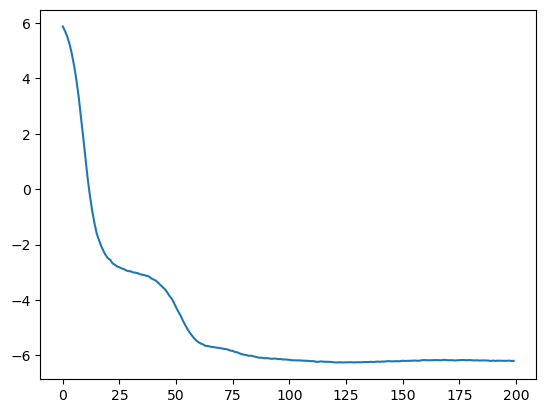

In [397]:
plt.plot(data)
# plt.plot(data2)
# plt.plot(data3)

In [ ]:
circ_C[1].draw('mpl')

In [ ]:
hamiltonian = Ising_hamiltonian(2,2)
print(hamiltonian)

In [ ]:
a = QuantumCircuit(ansatz.num_parameters+1)

In [ ]:
len(hamiltonian)

In [ ]:
str(hamiltonian.primitive._pauli_list[0])

In [ ]:
grad_vector_C = np.zeros(ansatz.num_parameters)
# operator = 'ZY'

for i in range(ansatz.num_parameters):
    overlap_value = 0

    for k in range(len(hamiltonian)):
        internal_circuit = circ_C[i].copy()
        for m in range(len(str(hamiltonian.primitive._pauli_list[k]))):
            if operator[m] == 'X':
                internal_circuit.cx(0, m+1)
            if operator[m] == 'Y':
                internal_circuit.cy(0, m+1)
            if operator[m] == 'Z':
                internal_circuit.cz(0, m+1)

        internal_circuit = internal_circuit.bind_parameters({theta: initial_point[k] for k, theta in enumerate(circ_C[i].parameters)})  

        internal_circuit.h(0)

        a = internal_circuit

        measurement = ClassicalRegister(1)
        internal_circuit.add_register(measurement)
        internal_circuit.measure(0, 0)

        result = execute(internal_circuit, backend, shots=shots).result()

        counts = result.get_counts()
        

        if '0' in counts:
                # Key exists, do something with data['value']
                overlap_value = counts['0']
        else:
            # Key doesn't exist, return to default value (0 in this case)
            overlap_value = 0
        
        grad_vector_C[i] += hamiltonian.coeffs.real[k]*(overlap_value/shots - 1)/2
        print(grad_vector_C)



    
    

In [ ]:
a.draw('mpl')

In [ ]:
0.001*np.dot(np.linalg.pinv(U_matrix), grad_vector_C)

In [ ]:
internal_circuit.draw('mpl')

In [ ]:
circ_for_U_part(ansatz, 2,2)

In [ ]:
for i in range(ansatz.num_parameters):
    for j in range(ansatz.num_parameters):
        circ_U[i][j].draw('mpl')

In [ ]:
def circ_for_U_part(ansatz, l, m):
    layer_of_l = 0
    position_of_l = 0
    layer_of_m = 0


    for i in range(len(super_circuit)):
        if super_circuit[i][0].operation.params:
            # data of the parrameter layer
            a = str(super_circuit[i].data[-1].operation.params[0])
            b = 0
            for num in range(len(a)):
                if a[num].isnumeric():
                    b = int(a[num])

            if l <= b:
                layer_of_l = i
                position_of_l = ansatz.num_qubits - 1 - (b - l)
                # print(f'layer_of_l: {layer_of_l}')
                # print(f'position_of_l: {position_of_l}')
                break
                
        # if layer_of_l != 0:
        #     break

    # for i in range(len(super_circuit)):
    #     if super_circuit[i][0].operation.params:
    #         # data of the parrameter layer
    #         a = str(super_circuit[i].data[-1].operation.params[0])
    #         b = 0
    #         for num in range(len(a)):
    #             if a[num].isnumeric():
    #                 b = int(a[num])

    #         if m <= b:
    #             layer_of_m = i
    #             position_of_m = ansatz.num_qubits - 1 - (b - m)
    #             # print(f'layer_of_l: {layer_of_l}')
    #             # print(f'position_of_l: {position_of_l}')
    #             break
                
    #     if layer_of_m != 0:
    #         break


    for i in range(len(super_circuit)):
        if super_circuit[i][0].operation.params:
            # data of the parrameter layer
            a = str(super_circuit[i].data[-1].operation.params[0])
            b = 0
            for num in range(len(a)):
                if a[num].isnumeric():
                    b = int(a[num])

            if m <= b:
                layer_of_m = i
                position_of_m = ansatz.num_qubits - 1 - (b - m)
                # print(f'layer_of_m: {layer_of_m}')
                # print(f'position_of_m: {position_of_m}')
                break


    circ = QuantumCircuit(ansatz.num_qubits+1)
    ancilla_circ = QuantumCircuit(1)
    ancilla_circ.h(0)
    # ancilla_circ.s(0)
    ancilla_circ.x(0)
    circ = circ.compose(ancilla_circ)

    h = 0
    position_h = 0
        
    if l > m:
        h = l
        position_h = position_of_l 
        l = m
        position_of_l = position_of_m
        m = h
        position_of_m = position_h
         

    if l <= m:
        internal_circuit = QuantumCircuit(ansatz.num_qubits)
        for i in range(layer_of_l):
            internal_circuit = internal_circuit.compose(super_circuit[i])
        
        circ = circ.compose(internal_circuit, [i for i in range(1, ansatz.num_qubits+1)])

        circ.barrier()

        if super_circuit[layer_of_l].data[position_of_l].operation.name == 'rx':
            circ.cx(0, position_of_l+1)
        if super_circuit[layer_of_l].data[position_of_l].operation.name == 'ry':
            circ.cy(0, position_of_l+1)
        if super_circuit[layer_of_l].data[position_of_l].operation.name == 'rz':
            circ.cz(0, position_of_l+1)

        circ.barrier()

        circ.x(0)

        internal_circuit = QuantumCircuit(ansatz.num_qubits)
        for i in range(layer_of_l, layer_of_m):
            internal_circuit = internal_circuit.compose(super_circuit[i])

        circ = circ.compose(internal_circuit, [i for i in range(1, ansatz.num_qubits+1)])
        
        circ.barrier()

        if super_circuit[layer_of_m].data[position_of_m].operation.name == 'rx':
            circ.cx(0, position_of_m+1)
        if super_circuit[layer_of_m].data[position_of_m].operation.name == 'ry':
            circ.cy(0, position_of_m+1)
        if super_circuit[layer_of_m].data[position_of_m].operation.name == 'rz':
            circ.cz(0, position_of_m+1)

        circ.barrier()

        circ.h(0)
    return circ

In [ ]:
circ.draw('mpl')

In [ ]:
from qiskit import ClassicalRegister
measurement = ClassicalRegister(1)
circ.add_register(measurement)
circ.measure(0, 0)

In [ ]:
circ.draw('mpl')

# Customized Nelder-Mead 

In [ ]:
def Customize_Nelder_Mead(operator, interation, ansatz, initial_point, shots, backend, callback):
    """
    operator: the pauli matrix
    interation: number of interations 
    ansatz: the ansatz for perparing the parameterized circuit
    initial_points: random sample of number uses at the beggining of running
    shots: number of shots
    backend: the backend
    """
    def bubbleSort(arr):
        n = len(arr)
        
        # Traverse through all array elements
        for i in range(n):
            swapped = False
    
            # Last i elements are already in place
            for j in range(0, n-i-1):
    
                # Traverse the array from 0 to n-i-1
                # Swap if the element found is greater
                # than the next element
                if arr[j] > arr[j+1]:
                    arr[j], arr[j+1] = arr[j+1], arr[j]
                    swapped = True
            if (swapped == False):
                break
        return arr

    energy = []

    data_points = [[] for _ in range(ansatz.num_parameters+1)]
    data_energy = [[] for _ in range(ansatz.num_parameters+1)]

    data_points[0] = initial_point

    # data_points[0] = np.array([1.4, 5.5])
    # data_points[1] = np.array([1.6, 5.5])
    # data_points[2] = np.array([1.5, 6])

    for i in range(1, ansatz.num_parameters+1):
        # np.random.seed(i)

        # random = np.random.rand(ansatz.num_parameters)*2*np.pi
        # random = np.ones(ansatz.num_parameters)
        
        # data_points[i] = np.subtract(initial_point, random)
        # data_points[i][i-1]  = np.pi*2
        if i % 2 == 0:
            random = np.ones(ansatz.num_parameters)*2*np.pi*i/ansatz.num_parameters
            data_points[i] = np.subtract(initial_point, random)
        else:
            random = np.ones(ansatz.num_parameters)*(-2)*np.pi*i/ansatz.num_parameters
            data_points[i] = np.subtract(initial_point, random)
        
        

    
    for i in range(ansatz.num_parameters+1):
        # Measurement energy
        internal_anstaz = ansatz.bind_parameters({theta: data_points[i][k] for k, theta in enumerate(ansatz.parameters)})       
        internal_energy = 0
        for j in range(len(operator)):
            internal_energy += operator.coeffs.real[j] * Measurement(str(operator.primitive._pauli_list[j]), internal_anstaz, shots, backend)[0]
        data_energy[i] = internal_energy
    

    for i in range(interation):
        
        # Sort
        data_energy_sort = bubbleSort(data_energy.copy())
        data_points_sort = [[] for _ in range(ansatz.num_parameters+1)]

        for j in range(len(data_energy_sort)):
            data_points_sort[j] = data_points[np.where(data_energy == data_energy_sort[j])[0][0]]

        data_energy = data_energy_sort
        data_points = data_points_sort
    
        avarage_energy = sum(data_energy[i] for i in range(len(data_energy)))/len(data_energy)
        energy.append(avarage_energy)
        
        print(avarage_energy)
        print(f'data_points: {data_points}')
        print(data_energy)

        # Nelder Mead part
        # Calculate the centroid point
        centroid = np.zeros(ansatz.num_parameters)

        for i in range(ansatz.num_parameters):
            for j in range(ansatz.num_parameters):
                centroid[i] += data_points[j][i]

        centroid = centroid/ansatz.num_parameters 
        # print(centroid)

        # Reflection
        reflection_coefficient = 1

        reflection_point = np.zeros(ansatz.num_parameters)

        reflection_point = centroid + reflection_coefficient*(centroid - np.array(data_points[-1]))
        # print(f'reflection_point: {reflection_point}')
        internal_anstaz = ansatz.bind_parameters({theta: reflection_point[k] for k, theta in enumerate(ansatz.parameters)})       
        
        # Measure the reflection energy
        reflection_energy = 0
        for j in range(len(operator)):
            reflection_energy += operator.coeffs.real[j] * Measurement(str(operator.primitive._pauli_list[j]), internal_anstaz, shots, backend)[0]
        
        if data_energy[0] <= reflection_energy and reflection_energy < data_energy[-2]:
            print('reflection')
            data_points[-1] = reflection_point
            data_energy[-1] = reflection_energy
            continue
        

        # Expansion
        expansion_coefficient = 1

        if reflection_energy < data_energy[0]:
            print('expansion')
            expansion_point = np.zeros(ansatz.num_parameters)

            for j in range(ansatz.num_parameters):
                expansion_point[j] = centroid[j] + expansion_coefficient*(reflection_point[j] - centroid[j])

            internal_anstaz = ansatz.bind_parameters({theta: expansion_point[k] for k, theta in enumerate(ansatz.parameters)})       
            # Measure the expansion energy
            expansion_energy = 0
            for j in range(len(operator)):
                expansion_energy += operator.coeffs.real[j] * Measurement(str(operator.primitive._pauli_list[j]), internal_anstaz, shots, backend)[0]

            if expansion_energy < reflection_energy:
                data_points[-1] = expansion_point
                data_energy[-1] = expansion_energy
                continue
            
            else:
                data_points[-1] = reflection_point
                data_energy[-1] = reflection_energy
                continue
        
        # Contraction
        contraction_coefficient = 0.5

        if reflection_energy < data_energy[-1]:
            contraction_point = np.zeros(ansatz.num_parameters)

            for j in range(ansatz.num_parameters):
                contraction_point[j] = centroid[j] + contraction_coefficient*(reflection_point[j] - centroid[j])

            internal_anstaz = ansatz.bind_parameters({theta: contraction_point[k] for k, theta in enumerate(ansatz.parameters)})       
            # Measure the contraction energy
            contraction_energy = 0
            for j in range(len(operator)):
                contraction_energy += operator.coeffs.real[j] * Measurement(str(operator.primitive._pauli_list[j]), internal_anstaz, shots, backend)[0]

            if contraction_energy < reflection_energy:
                print('contraction1')
                data_points[-1] = contraction_point
                data_energy[-1] = contraction_energy
                continue
        
        else:
            contraction_point = np.zeros(ansatz.num_parameters)

            for j in range(ansatz.num_parameters):
                contraction_point[j] = centroid[j] + contraction_coefficient*(data_points[-1][j] - centroid[j])

            internal_anstaz = ansatz.bind_parameters({theta: contraction_point[k] for k, theta in enumerate(ansatz.parameters)})       
            # Measure the contraction energy
            contraction_energy = 0
            for j in range(len(operator)):
                contraction_energy += operator.coeffs.real[j] * Measurement(str(operator.primitive._pauli_list[j]), internal_anstaz, shots, backend)[0]

            if contraction_energy < data_energy[-1]:
                print('contraction2')
                data_points[-1] = contraction_point
                data_energy[-1] = contraction_energy
                continue
        
        # Shrink
        shrink_coefficient = 0.5
        print('shrink')
        
        for k in range(1, ansatz.num_parameters+1):
            shrink_point = np.zeros(ansatz.num_parameters)
            
            for j in range(ansatz.num_parameters):    
                shrink_point[j] = data_points[0][j] + shrink_coefficient*(data_points[k][j] - data_points[0][j])

            internal_anstaz = ansatz.bind_parameters({theta: shrink_point[k] for k, theta in enumerate(ansatz.parameters)})       
            
            internal_energy = 0
            # shink energy
            for j in range(len(operator)):
                internal_energy += operator.coeffs.real[j] * Measurement(str(operator.primitive._pauli_list[j]), internal_anstaz, shots, backend)[0]
            
            data_points[k] = shrink_point
            data_energy[k] = internal_energy



    return energy



    

In [ ]:
def bubbleSort(arr):
    n = len(arr)
    
    # Traverse through all array elements
    for i in range(n):
        swapped = False

        # Last i elements are already in place
        for j in range(0, n-i-1):

            # Traverse the array from 0 to n-i-1
            # Swap if the element found is greater
            # than the next element
            if arr[j] > arr[j+1]:
                arr[j], arr[j+1] = arr[j+1], arr[j]
                swapped = True
        if (swapped == False):
            break
    return arr

data_points = np.array([[1,2,3], [-2,-3,-4], [-1,-5, 6]])
energy = np.array([-1, -2, 3, 4, -6])
data_energy_sort = bubbleSort(energy.copy())

for i in range(len(energy)):
    print((np.where(energy == (data_energy_sort[i])))[0][0])

print(energy)

print(data_energy_sort)


In [ ]:
print(np.ones(10))

In [ ]:
from qiskit import Aer
qubit = 2
operator = Ising_hamiltonian(qubit,2)
interation = 200
ansatz = Customize_RealAmplidues(qubit,1)
initial_point = np.zeros(ansatz.num_parameters)+0.5
shots = 20000
backend = Aer.get_backend('qasm_simulator')

energy = Customize_Nelder_Mead(operator, interation, ansatz, initial_point, shots, backend, callback=None)

# print(energy)
# print(params)

In [ ]:
print(np.random.rand(10))

In [ ]:
import matplotlib.pyplot as plt 

plt.plot(energy)

In [ ]:
sum(energy[i] for i in range(len(energy)))/len(energy)

In [ ]:
(-0.7449000000000001+-0.5934999999999999+-0.41849999999999987+0.3636+2.1625+4.0067+4.0322000000000005)/7

# Step 4: Create the Custom VQE

In [37]:
def Customize_Variational_Quantum_EigenSolver(operator, optimize, interation, ansatz, eta, initial_point, shots, backend, callback):
    """
    operator: the pauli matrix
    interation: number of interations 
    ansatz: the ansatz for perparing the parameterized circuit
    eta: learning rate
    initial_points: random sample of number uses at the beggining of running
    shots: number of shots
    backend: the backend
    """

    energy = []

    internal_initial_point = initial_point.copy()
    
    b = np.zeros(ansatz.num_parameters)

    for i in range(interation):
        print(f'{internal_initial_point} ---------')
        internal_anstaz = ansatz.bind_parameters({theta: internal_initial_point[k] for k, theta in enumerate(ansatz.parameters)})       
        # Measure the expectation of our hamiltonian
        internal_energy = 0
        for j in range(len(operator)):
            internal_energy += operator.coeffs.real[j] * Measurement(str(operator.primitive._pauli_list[j]), internal_anstaz, shots, backend)[0]
            # print( operator.coeffs.real[j])
            # print(operator.primitive._pauli_list[j])
            # print(internal_energy)
            
            # measure = Measurement('X', internal_anstaz, 10000, backend=Aer.get_backend('qasm_simulator'))[0]*10
            # print(f'///{measure}///')
        
        # print(f'{internal_initial_point} hmm')
        
        energy.append(internal_energy)
        print(internal_energy)


        if callback is not None:
            callback(internal_initial_point, internal_energy)

        # Update the parameter points
        if optimize == Customize_Quantum_Natural_Graident_Descent:
            super_circuit = Seperate_Circuit_Apart(ansatz)
            a = np.add(optimize(operator, internal_initial_point, eta, ansatz, shots, backend, interation, super_circuit), -0.9*b)
            # b = a.copy()
            internal_initial_point =  np.subtract(internal_initial_point,a)
            # print(internal_energy)

            continue

        a = optimize(operator, internal_initial_point, eta, ansatz, shots, backend, interation)
        # a = np.add(optimize(operator, internal_initial_point, eta, ansatz, shots, backend, interation), -0.9*b)
        # b = a.copy()
        internal_initial_point =  np.subtract(internal_initial_point,a)
        print(f'a: {a}')

        # print(internal_energy)

    if callback is None:
        return energy



In [ ]:
b = np.zeros(ansatz.num_parameters)
print(b)

In [ ]:
ansatz = Customize_RealAmplidues(2,3)
ansatz.draw('mpl', style = 'iqx')

Ising hamiltonian

In [481]:
from qiskit.opflow import Z, I, X

def Ising_hamiltonian(num_qubits, h):
    hamiltonian = 0

    if num_qubits == 1:
        hamiltonian = Z + h*X
        return hamiltonian.reduce()

    if num_qubits == 2:
        hamiltonian = Z^Z
        hamiltonian += h*X^I
        hamiltonian += h*I^X
        return hamiltonian.reduce()


    
    hamiltonian += Z^(I^(num_qubits-2))^Z
    for i in range(num_qubits-1):
        hamiltonian += (I^(i))^(Z^Z)^(I^(num_qubits-2-i))
    
    for i in range(num_qubits):
        hamiltonian += h*((I^(i))^(X)^(I^(num_qubits-1-i)))

    return hamiltonian.reduce()

hamiltonian = Ising_hamiltonian(1,2)

print(hamiltonian)



1.0 * Z
+ 2.0 * X


In [600]:
from qiskit.quantum_info import Pauli, SparsePauliOp
from qiskit.opflow.primitive_ops.pauli_sum_op import PauliSumOp
from qiskit.algorithms import NumPyEigensolver


# hamiltonian = PauliSumOp(SparsePauliOp(['Z', 'X'],
#               coeffs=[-20, 10]), coeff=1.0)

# hamiltonian = PauliSumOp(SparsePauliOp(['ZZI', 'IZZ', 'XII', 'IXI', 'IXX'],
#                 coeffs=[1, 1, 1, 1, .11]), coeff=1.0)

# hamiltonian = PauliSumOp(SparsePauliOp(['ZZI', 'IZZ', 'XII', 'IXI', 'IXX'],
#                 coeffs=[1, 1, 1, 1, 1]), coeff=1.0)
                
# hamiltonian = PauliSumOp(SparsePauliOp(['X','Z'],
#               coeffs=[1, -2]), coeff=1.0)

# hamiltonian = Ising_hamiltonian(20, 2)

# hamiltonian = PauliSumOp(SparsePauliOp(['Z', 'X'],
#               coeffs=[1, 2]), coeff=1.0)

# find the first three (k=3) eigenvalues
exact_solver = NumPyEigensolver(k=100)
exact_result = exact_solver.compute_eigenvalues(Ising_hamiltonian(2,2))
print(exact_result.eigenvalues)
# print(exact_result.eigenstates)

[-4.12310563 -1.          1.          4.12310563]


In [ ]:
import numpy as np

theta = np.arccos(0.52573111)*2

phi = np.pi

print(np.cos(theta) + 2*np.sin(theta)*np.cos(phi) - (-2.23606798)) 

In [ ]:
np.arccos(0.52573111)*2

# Test VQE

In [601]:
from qiskit.opflow import Z, I, X
from qiskit.quantum_info import Pauli, SparsePauliOp
from qiskit.opflow.primitive_ops.pauli_sum_op import PauliSumOp
import time

start_time = time.time()

num_qubits = 2 # (N_p = num_qubit-1)


# Ising hamiltonian
def Ising_hamiltonian(num_qubits, h):
    hamiltonian = 0

    if num_qubits == 1:
        hamiltonian = Z + h*X
        return hamiltonian.reduce()

    if num_qubits == 2:
        hamiltonian = Z^Z
        hamiltonian += h*X^I
        hamiltonian += h*I^X
        return hamiltonian.reduce()


    
    hamiltonian += Z^(I^(num_qubits-2))^Z
    for i in range(num_qubits-1):
        hamiltonian += (I^(i))^(Z^Z)^(I^(num_qubits-2-i))
    
    for i in range(num_qubits):
        hamiltonian += h*((I^(i))^(X)^(I^(num_qubits-1-i)))

    return hamiltonian.reduce()



intermediate_info = {
    'parameters': [],
    'energy': [],
}

def callback(parameters, energy):
    intermediate_info['parameters'].append(parameters)
    intermediate_info['energy'].append(energy)


# def QHO_hamiltionian(number_qubit, omegaQ, alpha):
    
#     def number_operator(theta):
#         n = 0
#         for i in range(1,theta):
#             n += (i*(I^(i))^(Z+I)^(I^(theta-i)))/2
#         n += (theta*(I^(theta))^(Z+I))/2

#         return n

#     hamiltonian = alpha/2*(number_operator(number_qubit-1) @ number_operator(number_qubit-1))
#     hamiltonian += (omegaQ-alpha/2)*number_operator(number_qubit-1)
#     return hamiltonian.reduce()
    

# hamiltonian = QHO_hamiltionian(num_qubits, 1, 1)

# hamiltonian = PauliSumOp(SparsePauliOp(['ZY', 'XX'],
#               coeffs=[10, -20]), coeff=1.0)


# hamiltonian = PauliSumOp(SparsePauliOp(['ZZI', 'IZZ', 'XII', 'IXI', 'IXX'],
#                 coeffs=[1, 1, 1, 1, 1]), coeff=1.0)
                
# hamiltonian = PauliSumOp(SparsePauliOp(['X', 'Z'],
#               coeffs=[-20, 10]), coeff=1.0)

# hamiltonian = PauliSumOp(SparsePauliOp(['Z'],
#               coeffs=[10]), coeff=1.0)
              

# hamiltonian = PauliSumOp(SparsePauliOp(['Z'],
#               coeffs=[10]), coeff=1.0)

# hamiltonian = PauliSumOp(SparsePauliOp(['X','Z'],
#               coeffs=[1, -2]), coeff=1.0)


# hamiltonian = PauliSumOp(SparsePauliOp(['Z', 'X'],
#               coeffs=[1, 2]), coeff=1.0)

# ansatz = Customize_EfficientSU2(num_qubits, 1)
# ansatz.cx(0,1)
# ansatz.cx(1,2)
hamiltonian = Ising_hamiltonian(num_qubits,2)

# ansatz = Customize_RealAmplidues(num_qubits, 1)
ansatz = Customize_RealAmplidues(num_qubits, 1)

interation = 150

initial_point = np.zeros(ansatz.num_parameters)+0.5
# initial_point = np.random.rand(num_qubits)+1.2
# initial_point = np.array([ 2.86022673,  1.30314025,  2.05637214,  1.29459261,  0.19461221,  0.30451271,
#   3.34798259, -0.88489075, -1.56792844, -1.1410738,   0.0519218,  -0.60728212,
#  -0.76819862,  0.61490753, -0.42952656])

# initial_point = np.array([1.5, 5.5])

eta = 0.01
shots = 20000

from qiskit import Aer

backend = Aer.get_backend('qasm_simulator')

# energy = Customize_imaginary_time_evolution(hamiltonian, interation, ansatz, eta, initial_point, shots, backend, callback=None)

# energy = Customize_Nelder_Mead(hamiltonian, interation, ansatz, initial_point, shots, backend, callback=None)

# energy = Customize_QN_SPSA(hamiltonian, interation, ansatz, initial_point, shots, backend, callback)
energy = Customize_SPSA(hamiltonian, interation, ansatz, initial_point, shots, backend, callback=None)
# energy = Customize_Variational_Quantum_EigenSolver(hamiltonian, Customize_Parameter_Shift_Rule, interation, ansatz, eta, initial_point, shots, backend, callback=None)
# print(VQE_runtime)

print(time.time() - start_time)

# print(VQE_runtime[-1])

3.4332000000000003
[0.5 0.5 0.5 0.5]
ak_0: 0.06794401413235494
ck_0: 1.0
grad: [ 0.00884631  0.08880283  0.03863297 -0.00884631]
3.2927
[0.49115369 0.41119717 0.46136703 0.50884631]
ak_1: 0.06550903173007937
ck_1: 0.9323864864368324
grad: [ 0.00559968  0.07033681  0.11072199 -0.07033681]
3.0599999999999996
[0.48555401 0.34086036 0.35064505 0.57918312]
ak_2: 0.0632932480138243
ck_2: 0.8949746893567633
grad: [-0.17497365  0.10765461  0.07511601  0.00779696]
2.6889000000000003
[0.66052766 0.23320576 0.27552904 0.57138616]
ak_3: 0.0612663155211061
ck_3: 0.8693445600900217
grad: [-0.02956038  0.06143584 -0.06143584  0.02956038]
2.6304
[0.69008804 0.17176992 0.33696488 0.54182578]
ak_4: 0.05940340967080478
ck_4: 0.8499708457906336
grad: [-0.17501544  0.17501544  0.07106289 -0.17501544]
2.0336
[ 0.86510347 -0.00324552  0.26590199  0.71684122]
ak_5: 0.05768400629083011
ck_5: 0.8344623060592481
grad: [-0.04056727  0.04056727  0.06533553 -0.04056727]
1.8354
[ 0.90567075 -0.04381279  0.20056646  

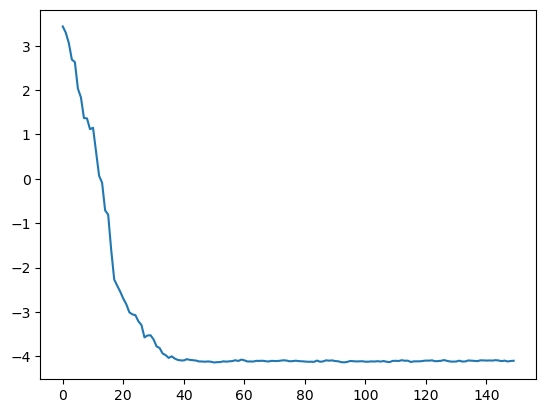

In [602]:
plt.plot(energy)

In [297]:
energy4 = np.array([5.8774, 5.78298, 5.716379999999999, 5.5904799999999994, 5.49398, 5.34286, 5.19818, 5.02578, 4.84598, 4.636559999999999, 4.41214, 4.13532, 3.84184, 3.5436799999999997, 3.1753799999999996, 2.8060199999999997, 2.45276, 2.06616, 1.66258, 1.27366, 0.8922, 0.5089400000000001, 0.1371, -0.16807999999999998, -0.4758599999999999, -0.7336800000000001, -0.9759399999999999, -1.2096, -1.39378, -1.58268, -1.717, -1.8513600000000001, -1.9711599999999998, -2.06496, -2.1762200000000003, -2.2478599999999997, -2.31438, -2.3869399999999996, -2.4483, -2.50338, -2.55354, -2.59648, -2.6384, -2.67478, -2.71724, -2.76814, -2.78154, -2.82254, -2.8402, -2.87862, -2.88092, -2.9105999999999996, -2.9497999999999998, -2.95592, -2.99054, -3.00738, -3.0204999999999997, -3.03264, -3.06748, -3.0984000000000003, -3.1014999999999997, -3.12012, -3.1462600000000003, -3.17304, -3.1944600000000003, -3.225, -3.2528, -3.2683600000000004, -3.32876, -3.3535, -3.41772, -3.4306599999999996, -3.46558, -3.51352, -3.5633600000000003, -3.62376, -3.6665200000000002, -3.7458400000000003, -3.79962, -3.8696200000000003, -3.92874, -4.0002, -4.07036, -4.1305, -4.21254, -4.2889800000000005, -4.3777, -4.44476, -4.53702, -4.61798, -4.700380000000001, -4.78462, -4.85674, -4.93952, -4.98868, -5.05922, -5.1358, -5.17458, -5.26014, -5.3113399999999995, -5.3383400000000005, -5.3870000000000005, -5.42802, -5.46502, -5.50422, -5.52876, -5.5578, -5.57446, -5.58966, -5.60096, -5.6375, -5.6227, -5.624499999999999, -5.65418, -5.6398600000000005, -5.66124, -5.66072, -5.659879999999999, -5.66052, -5.6767, -5.69138, -5.69728, -5.68396, -5.698980000000001, -5.7069, -5.71116, -5.72386, -5.73832, -5.7317, -5.75434, -5.76746, -5.76906, -5.7857, -5.799799999999999, -5.81274, -5.83036, -5.85164, -5.84768, -5.86832, -5.87988, -5.89172, -5.91882, -5.92002, -5.944039999999999, -5.95272, -5.9547, -5.96086, -5.9829799999999995, -5.9912399999999995, -6.00328, -6.00812, -6.01784, -6.02644, -6.03826, -6.04584, -6.0496799999999995, -6.06262, -6.0654200000000005, -6.07156, -6.07498, -6.0921, -6.088419999999999, -6.10442, -6.11034, -6.103280000000001, -6.11882, -6.11618, -6.125020000000001, -6.13004, -6.12718, -6.13706, -6.12848, -6.13768, -6.1416, -6.14294, -6.15672, -6.16418, -6.15576, -6.1585600000000005, -6.1664, -6.162780000000001, -6.16762, -6.16928, -6.17906, -6.17166, -6.17284, -6.18466, -6.17748, -6.18656, -6.19364, -6.192779999999999, -6.18956, -6.1969, -6.2009, -6.208740000000001, -6.1974, -6.2094, -6.21894, -6.2035800000000005, -6.2031])

In [298]:
len(energy4)

200

In [285]:
print(energy)

[5.8640799999999995, 5.673159999999999, 5.3789, 5.00998, 4.50346, 3.8891, 3.11904, 2.2131, 1.2667000000000002, 0.35528000000000004, -0.43877999999999995, -1.04874, -1.5145400000000002, -1.8550399999999998, -2.1162, -2.31664, -2.4596999999999998, -2.5749400000000002, -2.68048, -2.73766, -2.8223000000000003, -2.86528, -2.89958, -2.927, -2.9617999999999998, -3.00728, -3.0201599999999997, -3.04536, -3.0888400000000003, -3.11248, -3.1602, -3.18906, -3.2501999999999995, -3.29434, -3.37422, -3.4501799999999996, -3.56954, -3.67732, -3.8355200000000003, -4.00112, -4.19128, -4.36252, -4.5845400000000005, -4.80122, -4.97208, -5.16022, -5.28992, -5.41678, -5.51902, -5.57692, -5.63816, -5.6645199999999996, -5.69154, -5.70444, -5.73036, -5.7241800000000005, -5.7378, -5.77226, -5.78486, -5.80706, -5.8396799999999995, -5.86426, -5.89778, -5.92348, -5.9531600000000005, -5.9793400000000005, -6.00338, -6.03282, -6.05226, -6.06226, -6.0785, -6.08428, -6.09734, -6.0916999999999994, -6.10502, -6.12666, -6.1

In [327]:
a = np.array([6.1549, 6.0802, 6.0249, 5.8791, 5.707700000000001, 5.4512, 5.0894, 4.6332, 3.8708, 3.0079, 1.9470999999999998, 0.9231, -0.01640000000000008, -0.6999000000000001, -1.15, -1.4587999999999999, -1.6004, -1.7572, -1.8108999999999997, -1.8756, -1.9636, -2.0187999999999997, -2.1181, -2.2603, -2.3501000000000003, -2.516, -2.6665, -2.8525, -3.0714, -3.266, -3.5046, -3.7631000000000006, -4.0468, -4.265499999999999, -4.4935, -4.6708, -4.8015, -4.8927, -5.0132, -5.1013, -5.1478, -5.2164, -5.2915, -5.3543, -5.3864, -5.4653, -5.5159, -5.5981000000000005, -5.6513, -5.7032, -5.74, -5.781499999999999, -5.845599999999999, -5.8392, -5.9301, -5.933199999999999, -5.970400000000001, -5.995299999999999, -5.9927, -6.022900000000001, -6.038399999999999, -6.0424999999999995, -6.0629, -6.0632, -6.0573999999999995, -6.0922, -6.0842, -6.0985, -6.0971, -6.1391, -6.0870999999999995, -6.117799999999999, -6.1392, -6.1389, -6.138199999999999, -6.126799999999999, -6.131600000000001, -6.1421, -6.1615, -6.1612, -6.1587000000000005, -6.146, -6.145, -6.1595, -6.1598, -6.162999999999999, -6.1515, -6.1849, -6.1792, -6.1556999999999995, -6.1617999999999995, -6.161099999999999, -6.150900000000001, -6.1497, -6.1553, -6.1609, -6.1659, -6.1484, -6.1480999999999995, -6.1415])

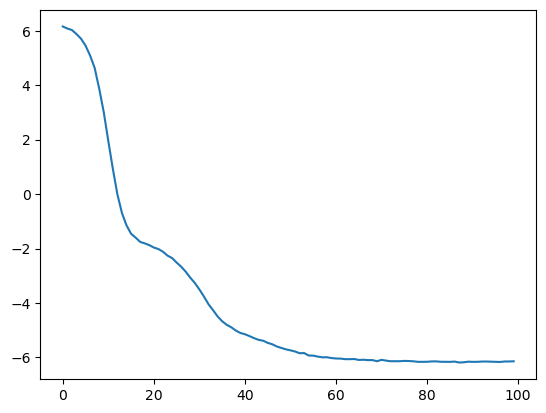

In [328]:
plt.plot(a)

In [264]:
y = np.arange(0,2, 0.01)

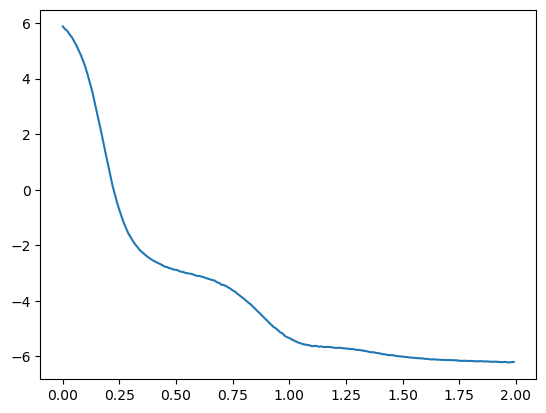

In [272]:
plt.plot(y, energy4)

In [251]:
print(energy)

[5.58032, 5.552860000000001, 5.49806, 5.39152, 5.25082, 5.13216, 4.94326, 4.71028, 4.4607600000000005, 4.14534, 3.78446, 3.33584, 2.80154, 2.1976999999999998, 1.51206, 0.7902600000000001, 0.0412599999999999, -0.64822, -1.29766, -1.9111799999999999, -2.46532, -2.9874199999999997, -3.47458, -3.9735599999999995, -4.40278, -4.7538, -5.06804, -5.2929, -5.465540000000001, -5.59178, -5.6808, -5.736199999999999, -5.79052, -5.81384, -5.83044, -5.84596, -5.85448, -5.83976, -5.842560000000001, -5.83154, -5.83144, -5.82148, -5.8056, -5.78172, -5.75624, -5.73222, -5.7017, -5.63076, -5.5808, -5.51548, -5.4223799999999995, -5.32892, -5.218640000000001, -5.09004, -4.94562, -4.76924, -4.55988, -4.3461799999999995, -4.06028, -3.78526, -3.4829, -3.17266, -2.82346, -2.56342, -2.34294, -2.2361, -2.24324, -2.39454, -2.61894, -2.9545, -3.29392, -3.7031400000000003, -4.03118, -4.35966, -4.6728000000000005, -4.8881000000000006, -5.08658, -5.2595600000000005, -5.4027400000000005, -5.52246, -5.60738, -5.69174, -

[5.87164, 5.43664, 4.6651, 3.41, 1.73102, 0.06871999999999996, -1.1499, -1.8728799999999999, -2.3019600000000002, -2.55688, -2.75644, -2.85434, -2.92814, -2.94592, -2.9607600000000005, -2.97972, -2.99718, -3.00802, -3.01954, -3.0163999999999995, -3.03094, -3.0780999999999996, -3.0701199999999997, -3.12238, -3.16322, -3.2376, -3.33136, -3.4995999999999996, -3.6738, -3.88158, -4.13432, -4.456300000000001, -4.74524, -5.05312, -5.3196200000000005, -5.5501000000000005, -5.77126, -5.93652, -6.04406, -6.1067800000000005, -6.15024, -6.20152, -6.22972, -6.22828, -6.24322, -6.26212, -6.26858, -6.27516, -6.27616, -6.27688]


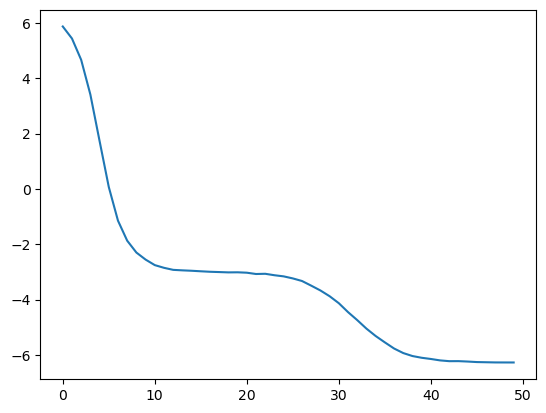

In [64]:
import matplotlib.pyplot as plt
print(energy)
plt.plot(energy)

In [367]:
initial_point = np.zeros(ansatz.num_parameters)+0.5

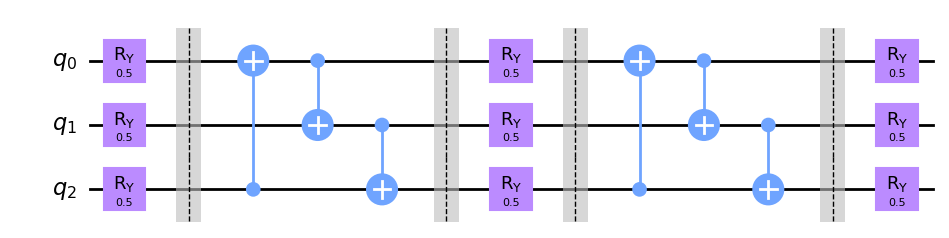

In [368]:
ansatz.draw('mpl')

In [455]:
from qiskit import BasicAer
backend = BasicAer.get_backend('statevector_simulator')

from qiskit import QuantumCircuit

ansatz = Customize_RealAmplidues(3,2)

from qiskit.execute_function import execute

initial_point = np.zeros(ansatz.num_parameters)+0.5

ansatz = ansatz.bind_parameters({theta: initial_point[k] for k, theta in enumerate(ansatz.parameters)})      


job = execute(ansatz, backend)

result = job.result()

state_vector = result.get_statevector()

# Print the statevector
print(state_vector)

[0.63485732+0.j 0.27513146+0.j 0.4360886 +0.j 0.30189015+0.j
 0.14452203+0.j 0.22744098+0.j 0.18021487+0.j 0.36722544+0.j]


In [457]:
state_vector.real

array([0.63485732, 0.27513146, 0.4360886 , 0.30189015, 0.14452203,
       0.22744098, 0.18021487, 0.36722544])

In [363]:
initial_point = np.zeros(ansatz.num_parameters)

In [454]:
def pauli_measurement(operator, ansatz, initial_point, shots, backend):
    """ 
    operator: indicate the sum of serries of Tensor Product Pauli Operator (Hamiltonian)
    ansatz: the parameter circuit
    initial_point: the parameter for our parameter circuit
    shots: number of shots
    backend: the quantum simulator
    retun: the Hamiltonian value
    """
    internal_anstaz = ansatz.bind_parameters({theta: initial_point[k] for k, theta in enumerate(ansatz.parameters)})  

    internal_energy = 0
    for j in range(len(operator)):
        internal_energy += operator.coeffs.real[j] * Measurement(str(operator.primitive._pauli_list[j]), internal_anstaz, shots, backend)[0]
    return internal_energy

ansatz = Customize_RealAmplidues(3,2)
initial_point = np.zeros(ansatz.num_parameters)+0.5
# ansatz = Customize_RealAmplidues(3,2)
# ansatz = ansatz.bind_parameters({theta: initial_point[k] for k, theta in enumerate(ansatz.parameters)})
shots = 20000
pauli_measurement(hamiltonian, ansatz, initial_point, shots, backend)

5.9893

In [383]:
print(hamiltonian)

1.0 * ZIZ
+ 1.0 * ZZI
+ 1.0 * IZZ
+ 2.0 * XII
+ 2.0 * IXI
+ 2.0 * IIX


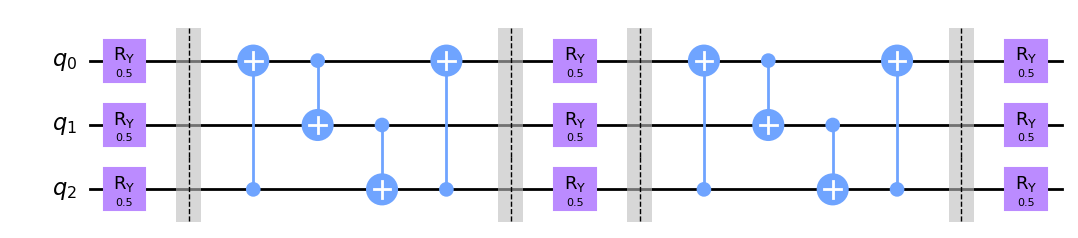

In [380]:
ansatz.draw('mpl')

In [86]:
print(state_vector.real)

[0.55730363 0.12519092 0.35942038 0.08740567 0.39259071 0.35779955
 0.29078331 0.41257025]


In [75]:
hamiltonian = Ising_hamiltonian(3,2).to_matrix().real
print(hamiltonian)

[[ 3.  2.  2.  0.  2.  0.  0.  0.]
 [ 2. -1.  0.  2.  0.  2.  0.  0.]
 [ 2.  0. -1.  2.  0.  0.  2.  0.]
 [ 0.  2.  2. -1.  0.  0.  0.  2.]
 [ 2.  0.  0.  0. -1.  2.  2.  0.]
 [ 0.  2.  0.  0.  2. -1.  0.  2.]
 [ 0.  0.  2.  0.  2.  0. -1.  2.]
 [ 0.  0.  0.  2.  0.  2.  2.  3.]]


In [157]:
a = 0
for i in range(len(initial_state)):
    a += initial_state[i]**2

6.0261088078531
[0.63485732 0.27513146 0.4360886  0.30189015 0.14452203 0.22744098
 0.18021487 0.36722544]
6.0261088078531
[0.63688304 0.27094295 0.44461789 0.30142556 0.13344578 0.22781703
 0.17370388 0.36406876]
5.972126816978776
[0.6387421  0.26625137 0.45360858 0.30072507 0.12157876 0.22848056
 0.16674236 0.3607418 ]
5.910582622388835
[0.64039277 0.26100696 0.46306352 0.29975255 0.10887587 0.22946382
 0.1593036  0.35722236]
5.84042787178242
[0.64178683 0.25515689 0.47297942 0.29846818 0.09529319 0.23080032
 0.1513614  0.35348549]
5.760501478431845
[0.64286902 0.24864561 0.48334536 0.29682845 0.08078927 0.23252446
 0.14289082 0.34950335]
5.669531722235044
[0.64357661 0.24141556 0.49414119 0.29478627 0.06532675 0.23467091
 0.13386904 0.34524524]
5.566144783930066
[0.6438391  0.23340802 0.50533572 0.29229127 0.04887428 0.23727386
 0.12427653 0.3406777 ]
5.448881931613502
[0.64357827 0.22456447 0.51688492 0.28929038 0.03140883 0.24036614
 0.11409838 0.33576483]
5.316227819734663
[0.642

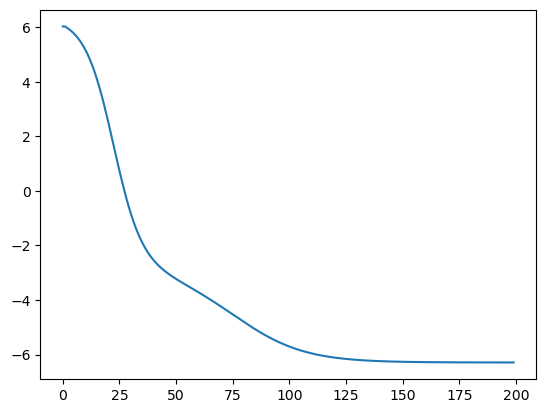

In [470]:
from scipy.linalg import expm, sinm, cosm
#linear
# initial_state = np.array([0.55730363, 0.12519092, 0.35942038, 0.08740567, 0.39259071, 0.35779955, 0.29078331, 0.41257025])
#full
initial_state = np.array([0.63485732, 0.27513146, 0.4360886 , 0.30189015, 0.14452203,
       0.22744098, 0.18021487, 0.36722544])

n = 3

# initial_state = np.zeros(2**n)+0.5
# initial_state = np.array([-0.33872124, -0.4164637,  -0.59940211, -0.30260184, -0.16691855, -0.46595082, -0.58978475, -0.47787956])

# initial_state = np.array([-6.84290006e-44, -3.77495775e-01, -5.43316895e-01, -2.74287810e-01,
#  -1.51300215e-01, -4.22352455e-01, -5.34599418e-01, -5.67008743e-44])

# initial_state = np.random.rand(2**n)+1.2
initial_state = initial_state/np.linalg.norm(initial_state)

energy = []
hamiltonian = Ising_hamiltonian(n,2).to_matrix().real

interation = 200
dt = 0.01

state_vector = initial_state

# normalized_coeffcient = np.dot(np.dot(np.transpose(initial_state), hamiltonian), initial_state)

for i in range(interation):
    internal_energy = np.dot(np.dot(np.transpose(state_vector), hamiltonian), state_vector)
    print(internal_energy)
    energy.append(internal_energy)

    state_vector = np.dot(np.array(expm(-(dt*i)*hamiltonian)), initial_state)
    state_vector = state_vector/np.linalg.norm(state_vector)
    print(state_vector)

print(energy)

plt.plot(energy)
    

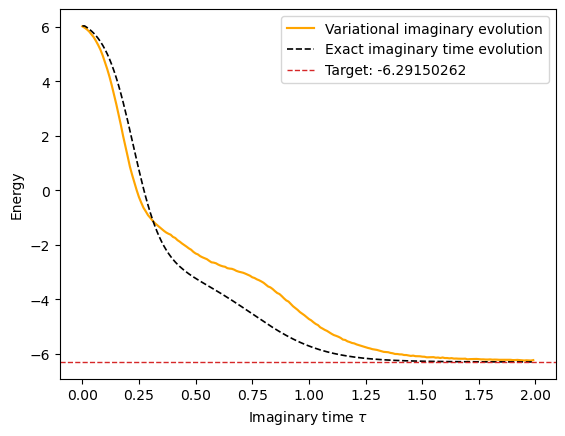

In [478]:
x = np.arange(0, 2, 0.02)
y = np.arange(0, 2, 0.01)
z = np.arange(0, 2, 0.025)
plt.plot(y,a, lw=1.55, color='orange', label='Variational imaginary evolution')
plt.plot(y, energy, ls='--', color = 'black', lw=1.2, label='Exact imaginary time evolution')

plt.xlabel(r'Imaginary time $\tau$')
plt.ylabel('Energy')
plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=1, label="Target: " + str(gs_energy))
plt.legend()

In [243]:
print(energy)

[5.866186146655173, 5.866186146655173, 5.658754878894889, 5.38116133638378, 5.014118976881374, 4.5376161355208815, 3.9349494209710505, 3.1989801130184596, 2.3392421940776083, 1.3864813848311952, 0.3904781634761241, -0.5902332321324445, -1.502776743458074, -2.311327044586406, -3.000734336193893, -3.573007022588958, -4.040597727629878, -4.420134837416465, -4.728245862527409, -4.979484196154834, -5.185698985867541, -5.356168762717445, -5.498033044892176, -5.616770043436839, -5.7166127068292205, -5.800873640718951, -5.872184526693362, -5.932667320527916, -5.984055369451648, -6.027779471502644, -6.0650300140363775, -6.096802933846217, -6.123934670751442, -6.147129489534744, -6.166981352309962, -6.183991759180084, -6.198584496706693, -6.2111179378641745, -6.22189535398557, -6.231173583892103, -6.239170330254338, -6.246070301721315, -6.252030381868184, -6.257183977107349, -6.261644672349574, -6.265509303711967, -6.268860541006068, -6.271769058544316, -6.27429536061495, -6.276491317528999, -6.

In [472]:
energy_exact = np.array([5.878433927598186, 5.878433927598188, 5.706897264922318, 5.484785304546628, 5.200070313842906, 4.8406010613014505, 4.396262204682188, 3.8621362762744655, 3.2421088356704377, 2.551582865971168, 1.8175387192906967, 1.0748286740781807, 0.3594308024297942, -0.2987542063332922, -0.8806801189485949, -1.3791591547311177, -1.7967583741267341, -2.142296719122906, -2.4274712384396953, -2.6643927857845937, -2.8641482065701136, -3.036166801855486, -3.1880937247128562, -3.325926238931691, -3.454253007098741, -3.5765078041726244, -3.6951967662646155, -3.81208586473266, -3.9283492601880132, -4.044685085366515, -4.161406756480716, -4.278517330477707, -4.395772923590638, -4.512739422191602, -4.628844986177565, -4.743429354810421, -4.8557898240637085, -4.965223028726497, -5.07106133783584, -5.1727027154328455, -5.2696332248700575, -5.361441851818055, -5.447827870814072, -5.528601479827485, -5.603678804300712, -5.67307259055869, -5.736879966825021, -5.795268572582133, -5.84846218241451, -5.8967267212861785, -5.940357322630959, -5.97966684794634, -6.014976085638175, -6.046605686913457, -6.074869779257302, -6.100071120054547, -6.122497607986222, -6.142419950658563, -6.16009028638401, -6.175741569885479, -6.1895875508797085, -6.201823197190376, -6.212625437543711, -6.222154121735714, -6.230553116382689, -6.237951472454894, -6.244464616091536, -6.250195526883169, -6.25523587810009, -6.259667121527339, -6.263561505943641, -6.266983023152346, -6.269988279111528, -6.272627290360847, -6.274944207812219, -6.276977971233972, -6.278762898556666, -6.280329214578453, -6.281703523840421, -6.282909232449976, -6.2839669235084425, -6.2848946905906535, -6.2857084334612905, -6.286422119919164, -6.287048017353738, -6.287596897290574, -6.2880782159025115, -6.28850027317696, -6.288870353160475, -6.289194847451379, -6.2894793638809485, -6.289728822113062, -6.289947537701188, -6.290139295968881, -6.290307416924783, -6.290454812283831, -6.290584035542155, -6.290697325942299, -6.290796647066824, -6.290883720710974]
)
energy1 = np.array([5.8706000000000005, 5.7165, 5.5022400000000005, 5.2485, 4.90712, 4.47826, 3.97344, 3.3522, 2.6583, 1.91704, 1.1510799999999999, 0.4286199999999999, -0.21928000000000003, -0.74878, -1.2025199999999998, -1.56052, -1.83154, -2.04378, -2.2339800000000003, -2.38922, -2.4886, -2.60032, -2.64476, -2.73778, -2.8057399999999997, -2.85946, -2.9061999999999997, -2.92362, -2.9602400000000006, -3.0296, -3.06452, -3.10956, -3.11318, -3.1522000000000006, -3.2108199999999996, -3.2761799999999996, -3.3129799999999996, -3.37636, -3.4836400000000003, -3.5342, -3.64404, -3.76436, -3.89146, -4.0123, -4.1654, -4.32366, -4.49704, -4.6488, -4.81282, -4.96694, -5.09158, -5.20444, -5.34278, -5.4355, -5.50658, -5.552720000000001, -5.5978200000000005, -5.63438, -5.65002, -5.65852, -5.68926, -5.68984, -5.69786, -5.721439999999999, -5.71824, -5.73554, -5.73682, -5.75092, -5.78668, -5.811780000000001, -5.82768, -5.85724, -5.87686, -5.9185, -5.93876, -5.9573, -5.97682, -5.99184, -6.0209600000000005, -6.03432, -6.044740000000001, -6.06798, -6.06696, -6.08064, -6.0880600000000005, -6.1075800000000005, -6.1061000000000005, -6.11172, -6.1234, -6.1373, -6.15426, -6.1588, -6.155899999999999, -6.16016, -6.16174, -6.17662, -6.17262, -6.1867399999999995, -6.1862, -6.20254])
energy2 = np.array([5.866186146655173, 5.866186146655173, 5.658754878894889, 5.38116133638378, 5.014118976881374, 4.5376161355208815, 3.9349494209710505, 3.1989801130184596, 2.3392421940776083, 1.3864813848311952, 0.3904781634761241, -0.5902332321324445, -1.502776743458074, -2.311327044586406, -3.000734336193893, -3.573007022588958, -4.040597727629878, -4.420134837416465, -4.728245862527409, -4.979484196154834, -5.185698985867541, -5.356168762717445, -5.498033044892176, -5.616770043436839, -5.7166127068292205, -5.800873640718951, -5.872184526693362, -5.932667320527916, -5.984055369451648, -6.027779471502644, -6.0650300140363775, -6.096802933846217, -6.123934670751442, -6.147129489534744, -6.166981352309962, -6.183991759180084, -6.198584496706693, -6.2111179378641745, -6.22189535398557, -6.231173583892103, -6.239170330254338, -6.246070301721315, -6.252030381868184, -6.257183977107349, -6.261644672349574, -6.265509303711967, -6.268860541006068, -6.271769058544316, -6.27429536061495, -6.276491317528999, -6.278401459222132, -6.280064065808922, -6.281512088065979, -6.282773925407046, -6.283874084365685, -6.284833736793125, -6.285671193797536, -6.28640230879881, -6.287040820864643, -6.287598647657195, -6.288086135792603, -6.28851227514644, -6.288884882582981, -6.289210759708259, -6.289495828516024, -6.289745248186617, -6.289963515790447, -6.290154553222953, -6.290321782342405, -6.290468189983795, -6.29059638427164, -6.290708643443821, -6.290806958220954, -6.290893068605667, -6.290968495869123, -6.291034570374443, -6.291092455795063, -6.291143170208216, -6.291187604477145, -6.291226538278966, -6.291260654086418, -6.291290549370057, -6.29131674725172, -6.291339705809225, -6.291359826205813, -6.291377459794962, -6.291392914331463, -6.2914064594025625, -6.291418331178217, -6.2914287365667105, -6.291437856850768, -6.291445850869661, -6.291452857804453, -6.29145899961622, -6.291464383180754, -6.29146910215781, -6.29147323862799, -6.291476864526384, -6.291480042898268, -6.291482828999033])
energy3 = np.array([5.58032, 5.552860000000001, 5.49806, 5.39152, 5.25082, 5.13216, 4.94326, 4.71028, 4.4607600000000005, 4.14534, 3.78446, 3.33584, 2.80154, 2.1976999999999998, 1.51206, 0.7902600000000001, 0.0412599999999999, -0.64822, -1.29766, -1.9111799999999999, -2.46532, -2.9874199999999997, -3.47458, -3.9735599999999995, -4.40278, -4.7538, -5.06804, -5.2929, -5.465540000000001, -5.59178, -5.6808, -5.736199999999999, -5.79052, -5.81384, -5.83044, -5.84596, -5.85448, -5.83976, -5.842560000000001, -5.83154, -5.83144, -5.82148, -5.8056, -5.78172, -5.75624, -5.73222, -5.7017, -5.63076, -5.5808, -5.51548, -5.4223799999999995, -5.32892, -5.218640000000001, -5.09004, -4.94562, -4.76924, -4.55988, -4.3461799999999995, -4.06028, -3.78526, -3.4829, -3.17266, -2.82346, -2.56342, -2.34294, -2.2361, -2.24324, -2.39454, -2.61894, -2.9545, -3.29392, -3.7031400000000003, -4.03118, -4.35966, -4.6728000000000005, -4.8881000000000006, -5.08658, -5.2595600000000005, -5.4027400000000005, -5.52246, -5.60738, -5.69174, -5.75338, -5.798599999999999, -5.835640000000001, -5.88022, -5.905479999999999, -5.93844, -5.96256, -5.97378, -5.99702, -6.009379999999999, -6.03266, -6.0367999999999995, -6.060919999999999, -6.05364, -6.060379999999999, -6.0693, -6.080500000000001, -6.0807199999999995])
energy4 = np.array([5.88286, 5.78678, 5.71234, 5.620839999999999, 5.47138, 5.34132, 5.19272, 5.03706, 4.85326, 4.62392, 4.40544, 4.13034, 3.8196, 3.53348, 3.19616, 2.8248599999999997, 2.45754, 2.0599000000000003, 1.66704, 1.25916, 0.89792, 0.50346, 0.15951999999999994, -0.18930000000000002, -0.46354000000000006, -0.7277200000000001, -0.9615400000000001, -1.2103000000000002, -1.39988, -1.5590199999999999, -1.6896399999999998, -1.86656, -1.9355999999999998, -2.06706, -2.16518, -2.22976, -2.2920000000000003, -2.3572200000000003, -2.4422999999999995, -2.49996, -2.56788, -2.60082, -2.64252, -2.6825400000000004, -2.6958, -2.7385, -2.78518, -2.8019800000000004, -2.82282, -2.8495999999999997, -2.8837200000000003, -2.8943199999999996, -2.9172599999999997, -2.93744, -2.96124, -2.95086, -2.98692, -3.01544, -3.0331400000000004, -3.03998, -3.06796, -3.07168, -3.1028, -3.1150999999999995, -3.14424, -3.15118, -3.1923399999999997, -3.22626, -3.22206, -3.24872, -3.29106, -3.3208, -3.33378, -3.3869, -3.4316400000000002, -3.48336, -3.4953000000000003, -3.5551, -3.60262, -3.65984, -3.70668, -3.78812, -3.8318000000000003, -3.9111000000000002, -3.98858, -4.05456, -4.1079, -4.21078, -4.27338, -4.3414399999999995, -4.43098, -4.505240000000001, -4.59192, -4.6647799999999995, -4.751479999999999, -4.8065999999999995, -4.9062600000000005, -4.98604, -5.06334, -5.114, -5.1963, -5.241199999999999, -5.29094, -5.3362, -5.38788, -5.42664, -5.4616, -5.4937000000000005, -5.5315, -5.552239999999999, -5.56932, -5.59434, -5.60452, -5.62394, -5.632, -5.6517599999999995, -5.64376, -5.6578800000000005, -5.677379999999999, -5.6604, -5.67204, -5.67632, -5.684200000000001, -5.69208, -5.69786, -5.7058599999999995, -5.70158, -5.714460000000001, -5.73224, -5.739520000000001, -5.74986, -5.74854, -5.768879999999999, -5.77128, -5.79666, -5.8057, -5.8172999999999995, -5.82616, -5.8432200000000005, -5.83748, -5.86156, -5.8891, -5.89164, -5.90256, -5.919499999999999, -5.933120000000001, -5.9425799999999995, -5.95018, -5.95864, -5.980639999999999, -5.9792, -5.99494, -5.99786, -6.022259999999999, -6.01478, -6.029680000000001, -6.03386, -6.044079999999999, -6.05692, -6.057320000000001, -6.06824, -6.07442, -6.08092, -6.07176, -6.084300000000001, -6.08342, -6.100960000000001, -6.10504, -6.10848, -6.108140000000001, -6.11916, -6.1189599999999995, -6.123659999999999, -6.13076, -6.1258799999999995, -6.128900000000001, -6.130520000000001, -6.1359, -6.13786, -6.14378, -6.14598, -6.148020000000001, -6.15984, -6.16704, -6.15688, -6.15578, -6.163539999999999, -6.173039999999999, -6.1654599999999995, -6.1739, -6.17448, -6.17608, -6.17906, -6.18952, -6.18582, -6.18168, -6.19202, -6.192920000000001, -6.198359999999999, -6.21624])
energy5 = np.array([5.8640799999999995, 5.673159999999999, 5.3789, 5.00998, 4.50346, 3.8891, 3.11904, 2.2131, 1.2667000000000002, 0.35528000000000004, -0.43877999999999995, -1.04874, -1.5145400000000002, -1.8550399999999998, -2.1162, -2.31664, -2.4596999999999998, -2.5749400000000002, -2.68048, -2.73766, -2.8223000000000003, -2.86528, -2.89958, -2.927, -2.9617999999999998, -3.00728, -3.0201599999999997, -3.04536, -3.0888400000000003, -3.11248, -3.1602, -3.18906, -3.2501999999999995, -3.29434, -3.37422, -3.4501799999999996, -3.56954, -3.67732, -3.8355200000000003, -4.00112, -4.19128, -4.36252, -4.5845400000000005, -4.80122, -4.97208, -5.16022, -5.28992, -5.41678, -5.51902, -5.57692, -5.63816, -5.6645199999999996, -5.69154, -5.70444, -5.73036, -5.7241800000000005, -5.7378, -5.77226, -5.78486, -5.80706, -5.8396799999999995, -5.86426, -5.89778, -5.92348, -5.9531600000000005, -5.9793400000000005, -6.00338, -6.03282, -6.05226, -6.06226, -6.0785, -6.08428, -6.09734, -6.0916999999999994, -6.10502, -6.12666, -6.11692, -6.1275200000000005, -6.1352400000000005, -6.15052])

In [296]:
len(energy4)

191

In [350]:
b = np.array([6.126316666666667, 6.0696, 5.998666666666667, 5.8811333333333335, 5.722966666666666, 5.468366666666667, 5.0969, 4.60375, 3.89365, 2.98895, 1.9847, 0.9397500000000001, 0.03416666666666668, -0.6330333333333332, -1.09265, -1.3879666666666668, -1.5521500000000001, -1.6626333333333334, -1.7273666666666667, -1.7944, -1.8293, -1.93035, -2.0010166666666667, -2.069316666666667, -2.1730833333333335, -2.2942333333333336, -2.39895, -2.5428333333333333, -2.752166666666667, -2.9135166666666668, -3.1424000000000003, -3.3925333333333336, -3.6331999999999995, -3.8930833333333332, -4.127966666666667, -4.347816666666667, -4.55195, -4.6952, -4.8332500000000005, -4.93375, -5.016383333333334, -5.095866666666667, -5.171233333333333, -5.217033333333333, -5.29955, -5.368116666666666, -5.433083333333333, -5.510716666666667, -5.56245, -5.619583333333334, -5.679683333333333, -5.729183333333333, -5.7724166666666665, -5.83455, -5.8529333333333335, -5.877716666666666, -5.9258, -5.9428, -5.96755, -5.9873666666666665, -6.004950000000001, -6.02825, -6.0398499999999995, -6.065783333333334, -6.074016666666667, -6.076416666666667, -6.073166666666667, -6.099333333333334, -6.108833333333333, -6.1137, -6.110283333333333, -6.120833333333334, -6.129366666666667, -6.130633333333334, -6.131283333333333, -6.121333333333333, -6.139283333333334, -6.126483333333334, -6.136, -6.1343499999999995, -6.133233333333333, -6.138483333333333, -6.143933333333333, -6.129016666666667, -6.148233333333334, -6.140316666666666, -6.139566666666667, -6.129283333333333, -6.126033333333334, -6.1356, -6.1287, -6.131016666666667, -6.12515, -6.125333333333334, -6.1186, -6.116066666666667, -6.118849999999999, -6.113533333333334, -6.1062, -6.09815])

In [402]:
data = np.array([6.01898, 5.9634599999999995, 5.90654, 5.82756, 5.72588, 5.593719999999999, 5.469759999999999, 5.3223400000000005, 5.14026, 4.93062, 4.69812, 4.4234, 4.15382, 3.84294, 3.5206, 3.1607, 2.7947200000000003, 2.41604, 2.0411400000000004, 1.6620199999999998, 1.2869, 0.9554, 0.6361399999999999, 0.29319999999999996, 0.043460000000000054, -0.21838000000000007, -0.3904, -0.5851999999999999, -0.73362, -0.84558, -0.9719800000000001, -1.07436, -1.15096, -1.2427800000000002, -1.27508, -1.34754, -1.4209999999999998, -1.47602, -1.5122200000000001, -1.58348, -1.6344, -1.69754, -1.7619799999999999, -1.8471000000000002, -1.891, -1.95356, -2.0119, -2.07654, -2.13108, -2.18588, -2.25092, -2.3169, -2.3554, -2.403, -2.4531, -2.4833, -2.52944, -2.56952, -2.60112, -2.63742, -2.66864, -2.6816199999999997, -2.70406, -2.7311199999999998, -2.74086, -2.77024, -2.78946, -2.78954, -2.82198, -2.81996, -2.83842, -2.8545800000000003, -2.87934, -2.8868, -2.9100399999999995, -2.91804, -2.93308, -2.94764, -2.98474, -2.99496, -3.02658, -3.0531, -3.0665, -3.08538, -3.11442, -3.1567600000000002, -3.19332, -3.2169, -3.25638, -3.31446, -3.34026, -3.39008, -3.4456999999999995, -3.4977400000000003, -3.56238, -3.61114, -3.68128, -3.73748, -3.8100000000000005, -3.91026, -3.9755, -4.0456199999999995, -4.12304, -4.20654, -4.28284, -4.36592, -4.45768, -4.51154, -4.625, -4.67004, -4.76436, -4.8169, -4.877739999999999, -4.9716000000000005, -5.01238, -5.08642, -5.1543600000000005, -5.20428, -5.247920000000001, -5.32982, -5.36892, -5.406820000000001, -5.46322, -5.47182, -5.53598, -5.570600000000001, -5.6207, -5.64102, -5.68692, -5.7023600000000005, -5.74042, -5.77104, -5.79534, -5.82094, -5.8364199999999995, -5.87246, -5.87526, -5.903379999999999, -5.9188600000000005, -5.93574, -5.948239999999999, -5.96784, -5.9885, -5.992780000000001, -6.01102, -6.01888, -6.029739999999999, -6.042060000000001, -6.04634, -6.057079999999999, -6.07216, -6.07272, -6.0812, -6.09106, -6.09654, -6.098159999999999, -6.11262, -6.11266, -6.1284, -6.118899999999999, -6.12368, -6.14416, -6.1406, -6.15, -6.14862, -6.15664, -6.16, -6.1572, -6.1653199999999995, -6.155819999999999, -6.17348, -6.18236, -6.17772, -6.1729, -6.1852, -6.180300000000001, -6.19168, -6.18866, -6.190720000000001, -6.18096, -6.1827, -6.18546, -6.19576, -6.1872799999999994, -6.19826, -6.19468, -6.20392, -6.20396, -6.20118, -6.210520000000001, -6.21434, -6.217899999999999, -6.2183600000000006, -6.21258, -6.20036, -6.20726, -6.2079200000000005, -6.21152, -6.20532, -6.21364])

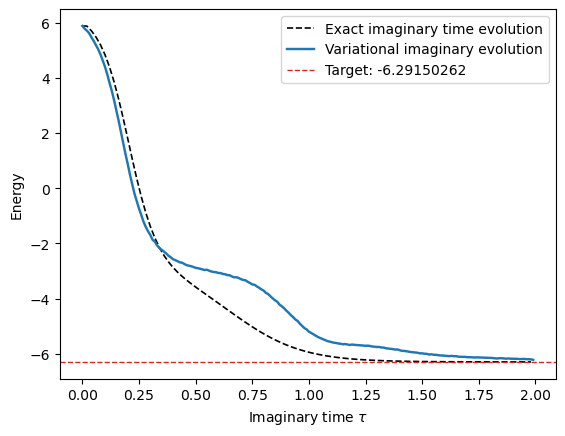

In [477]:
gs_energy = -6.29150262
x = np.arange(0, 2, 0.02)
y = np.arange(0, 2, 0.01)
z = np.arange(0, 2, 0.025)
# plt.plot(x, a) # 0.02 - 100 steps
# plt.plot(x, b) # 0.02 - 100 steps
plt.plot(x, energy_exact, ls='--', color = 'black', lw=1.2, label='Exact imaginary time evolution')

# plt.plot(y, data)
plt.plot(y, energy4, lw=1.75, label='Variational imaginary evolution') # 0.01 -200 steps

plt.xlabel(r'Imaginary time $\tau$')
plt.ylabel('Energy')
plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=1, label="Target: " + str(gs_energy))
plt.legend()

In [356]:
c = np.array([6.12232, 6.0958000000000006, 6.0693399999999995, 6.0407, 5.97632, 5.93032, 5.874619999999999, 5.76848, 5.67466, 5.54836, 5.39044, 5.19684, 4.9787, 4.697279999999999, 4.39262, 4.000439999999999, 3.57182, 3.0879399999999997, 2.5761000000000003, 2.05136, 1.51032, 0.98076, 0.5094400000000001, 0.0877200000000001, -0.3014800000000001, -0.60966, -0.8943000000000001, -1.12284, -1.29412, -1.44904, -1.5680999999999998, -1.65626, -1.7490799999999997, -1.7991799999999998, -1.8459, -1.8789399999999998, -1.94258, -2.00146, -2.06844, -2.1356800000000002, -2.1829, -2.2129399999999997, -2.3002000000000002, -2.35878, -2.4191399999999996, -2.5118400000000003, -2.59046, -2.67116, -2.77842, -2.8757200000000003, -2.95992, -3.09488, -3.19482, -3.32758, -3.4287399999999995, -3.56602, -3.69494, -3.82792, -3.96692, -4.0756, -4.1874, -4.32166, -4.41594, -4.52014, -4.61816, -4.70028, -4.75976, -4.82524, -4.89806, -4.95744, -5.00266, -5.053, -5.09088, -5.12692, -5.1605799999999995, -5.1886, -5.22086, -5.2515600000000004, -5.29172, -5.31208, -5.3357600000000005, -5.36998, -5.3981, -5.41536, -5.44676, -5.47658, -5.51754, -5.53282, -5.56084, -5.6028199999999995, -5.62696, -5.6595200000000006, -5.68898, -5.7136, -5.73358, -5.762879999999999, -5.78154, -5.80258, -5.8247599999999995, -5.8483600000000004, -5.86576, -5.8887, -5.904920000000001, -5.91372, -5.932799999999999, -5.9599400000000005, -5.96818, -5.97134, -5.99424, -6.00396, -6.01782, -6.0137, -6.0194399999999995, -6.0331600000000005, -6.045680000000001, -6.052020000000001, -6.0637799999999995, -6.06956, -6.071440000000001, -6.075959999999999, -6.08086, -6.0882000000000005, -6.098600000000001, -6.109960000000001, -6.1063, -6.12326, -6.104979999999999, -6.11536, -6.13066, -6.124440000000001, -6.119, -6.1434, -6.14318, -6.13942, -6.1418800000000005, -6.13712, -6.138999999999999, -6.1512400000000005, -6.15076, -6.146179999999999, -6.15096, -6.14906, -6.16088, -6.153020000000001, -6.16022, -6.15246, -6.15152, -6.165640000000001, -6.162100000000001, -6.16514, -6.170039999999999, -6.1690000000000005, -6.165980000000001, -6.16964, -6.1741600000000005, -6.17134, -6.16862, -6.17686, -6.16748, -6.17104, -6.16458, -6.16522, -6.17164, -6.17616, -6.166079999999999, -6.16638, -6.16666, -6.18634, -6.176019999999999, -6.17284, -6.184620000000001, -6.17854, -6.17776, -6.17154, -6.16762, -6.17956, -6.1557200000000005, -6.17486, -6.17366, -6.176500000000001, -6.17582, -6.1811, -6.18114, -6.1753, -6.17356, -6.17064, -6.18172, -6.1817400000000005, -6.1848600000000005, -6.17148, -6.177760000000001, -6.17728, -6.1688, -6.17194, -6.178459999999999, -6.166780000000001, -6.17372, -6.17046, -6.16436, -6.1801])

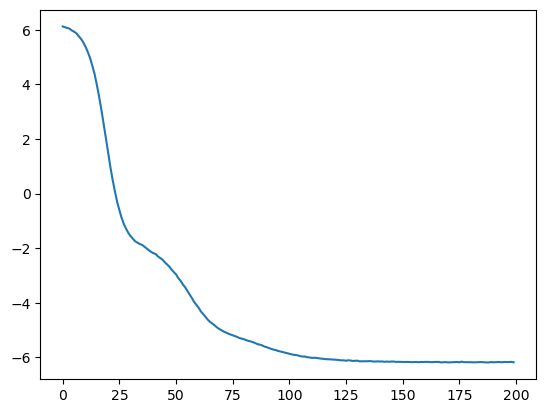

In [357]:
plt.plot(c)

In [212]:
hamiltonian = np.array([[1,0],[0,.3]])
print(hamiltonian)

[[1.  0. ]
 [0.  0.3]]


In [216]:
from scipy.linalg import expm, sinm, cosm

print(np.array(expm(hamiltonian)))

[[192.65834359  99.43376144  99.43376144  85.62400924  99.43376144
   85.62400924  85.62400924 128.49981723]
 [ 99.43376144  55.93563603  54.55160158  52.484523    54.55160158
   52.484523    51.15027562  85.62400924]
 [ 99.43376144  54.55160158  55.93563603  52.484523    54.55160158
   51.15027562  52.484523    85.62400924]
 [ 85.62400924  52.484523    52.484523    55.93563603  51.15027562
   54.55160158  54.55160158  99.43376144]
 [ 99.43376144  54.55160158  54.55160158  51.15027562  55.93563603
   52.484523    52.484523    85.62400924]
 [ 85.62400924  52.484523    51.15027562  54.55160158  52.484523
   55.93563603  54.55160158  99.43376144]
 [ 85.62400924  51.15027562  52.484523    54.55160158  52.484523
   54.55160158  55.93563603  99.43376144]
 [128.49981723  85.62400924  85.62400924  99.43376144  85.62400924
   99.43376144  99.43376144 192.65834359]]


In [168]:
state_vector = np.array([0.99918889, 1.00016461, 1.00047149, 1.00016917, 1.00020739, 1.00032376,  1.00009424, 0.99928904])
print(np.dot(np.dot(np.transpose(state_vector), hamiltonian), state_vector))

47.98690915699197


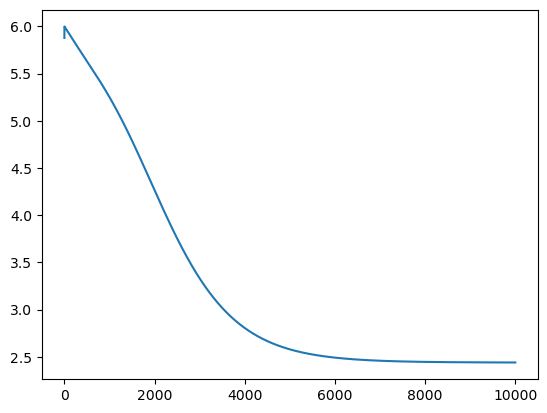

In [180]:
plt.plot(energy)

In [ ]:
print(energy)

[0.6548700000000001, 0.21344000000000002, -0.5809600000000001, -0.8259399999999999, -1.0104, -1.2986999999999997, -1.5364999999999998, -1.8717399999999995, -2.0473299999999997, -2.17015, -2.3678, -1.0022299999999997, -1.27598, -1.44424, -1.6265999999999998, -1.8747699999999998, -1.5388899999999999, -2.1848699999999996, -2.33574, -2.38219, -2.44657, -2.45557, -2.56265, -2.6405800000000004, -2.7511599999999996, -2.78184, -2.88527, -2.9562999999999997, -2.96585, -2.99381, -3.00895, -3.0237300000000005, -3.0270700000000006, -3.03717, -3.04621, -3.05394, -3.05675, -3.05955, -3.06262, -3.0656999999999996, -3.0679999999999996, -3.0682099999999997, -3.0744499999999997, -3.0797199999999996, -3.0824599999999998, -3.08716, -3.0905099999999996, -3.0930899999999997, -3.0967599999999997, -3.0975399999999995, -3.1001199999999995, -3.1042899999999998, -3.1046699999999996, -3.0781199999999997, -3.0853400000000004, -3.08753, -3.08849, -3.09195, -3.09377, -3.07224, -3.07774, -3.0799399999999997, -3.08047

In [ ]:
data1 = np.array([11.026800000000001, -1.2219999999999998, -3.1385000000000005, -1.2598, -2.7391000000000005, -2.7202, -1.6071, 0.014600000000000057, 0.8756999999999999, 1.0160000000000002, -1.9264999999999999, -0.5819999999999999, 0.035499999999999865, -2.3629, -0.4352, -0.4376999999999999, -1.1026, -2.4431999999999996, -1.8537000000000003, 0.6705000000000001, -2.3529, -2.8000000000000003, -2.4103000000000003, -1.4834, -1.0190000000000001, -0.6882999999999999, -1.0737000000000003, -0.1009000000000004, -0.00449999999999999, -0.03550000000000003, -0.053699999999999914, -0.6609999999999998, -0.509, -0.20120000000000005, 0.11160000000000002, 0.4588000000000002, 0.5626, -0.10019999999999982, -2.3512, -1.9956000000000003, -2.9053999999999998, -2.9908, -3.2308000000000003, -3.1778999999999993, -3.9303999999999997, -4.1579, -3.2416, -3.0114, -4.789200000000001, -5.0585, -5.9831, -7.8677, -8.6251, -8.2381, -8.2549, -8.5943, -8.2957, -8.0699, -7.7597000000000005, -7.8638, -7.619199999999999, -8.209800000000001, -8.0351, -7.981400000000002, -8.0306, -8.8866, -9.1195, -9.1426, -9.025, -9.0884, -8.6941, -8.6029, -8.645900000000001, -9.034300000000002, -8.982800000000001, -9.0015, -9.6976, -9.559599999999998, -10.0026, -10.6797, -10.6689, -11.1009, -11.0017, -10.8435, -11.0968, -11.1123, -11.180900000000001, -11.1532, -11.2562, -11.2608, -11.4112, -11.219400000000002, -11.284400000000002, -11.4044, -11.350000000000001, -11.3524, -11.0818, -10.9404, -11.030900000000003, -11.0158, -11.064600000000002, -10.8792, -11.1688, -11.030299999999999, -11.1859, -10.9761, -10.9696, -10.966199999999999, -11.154100000000001, -11.023700000000002, -10.9503, -10.9357, -11.3572, -11.564600000000002, -11.373599999999998, -11.2177, -11.3291, -11.206999999999999, -11.409, -11.516900000000001, -11.529599999999999, -11.706000000000001, -11.657300000000001, -11.593799999999998, -11.725600000000002, -11.711799999999998, -11.7828, -11.837200000000001, -12.0605, -12.033700000000001, -12.0238, -12.1807, -12.2108, -12.1727, -12.308300000000001, -12.1902, -12.2548, -12.4485, -12.555299999999999, -12.507399999999997, -12.6217, -12.8063, -12.746, -12.818299999999999, -12.8535, -12.7416, -12.9986, -12.9207, -12.864700000000001, -13.020299999999999, -13.072199999999999, -13.1969, -13.3694, -13.2946, -13.302400000000002, -13.279900000000001, -13.4253, -13.498300000000002, -13.5754, -13.4467, -13.535499999999999, -13.4193, -13.486, -13.4772, -13.4867, -13.6139, -13.640400000000001, -13.776, -13.769900000000002, -13.6198, -13.6077, -13.616499999999998, -13.650599999999999, -13.6423, -13.756400000000001, -13.8048, -13.9144, -13.8733, -13.8401, -14.070299999999998, -14.1894, -14.1761, -14.1583, -14.236500000000001, -14.2325, -14.205200000000001, -14.401800000000001, -14.321100000000001, -14.225, -14.2117, -14.176300000000001, -14.271600000000001, -14.2836, -14.4168, -14.4878, -14.357, -14.598700000000001, -14.4632, -14.516200000000001, -14.616000000000001, -14.638599999999999, -14.6302, -14.6242, -14.737400000000001, -14.813, -14.706500000000002, -14.759999999999998, -14.817, -14.857200000000002, -14.8044, -14.815100000000001, -14.881599999999999, -14.872600000000002, -14.809999999999999, -14.864799999999999, -14.9105, -14.960699999999997, -14.9855, -14.9026, -14.962299999999999, -14.984900000000001, -14.925399999999998, -14.968699999999998, -14.951699999999999, -14.8858, -14.8549, -14.907300000000001, -14.876399999999999, -14.8863, -14.9018, -14.911000000000001, -14.865200000000002, -14.8592, -14.932800000000002, -14.881000000000002, -15.0076, -15.0366, -15.0478, -15.0197, -15.085699999999997, -15.041, -15.1191, -15.0834, -15.0877, -15.0871, -15.1156, -15.1726, -15.143999999999998, -15.115699999999999, -15.1517, -15.2076, -15.264899999999999, -15.255899999999999, -15.2581, -15.267900000000001, -15.301699999999999, -15.3411, -15.313299999999998, -15.2939, -15.331000000000001, -15.331000000000001, -15.356499999999999, -15.391100000000002, -15.399299999999998, -15.4066, -15.452, -15.450199999999999, -15.423800000000002, -15.4652, -15.4794, -15.5257, -15.537500000000001, -15.5651, -15.545900000000001, -15.585799999999999, -15.601999999999999, -15.6048, -15.596599999999999, -15.706600000000002, -15.673399999999999, -15.677599999999998, -15.623199999999999, -15.5883, -15.6141, -15.588000000000001, -15.650799999999998, -15.606, -15.656500000000001, -15.633, -15.619799999999998, -15.645999999999997, -15.6513, -15.6425, -15.658900000000001, -15.657599999999999, -15.6266, -15.5943, -15.665299999999998, -15.6907, -15.690800000000001, -15.748099999999997, -15.721099999999998, -15.689200000000001, -15.7449, -15.752699999999999, -15.769200000000001, -15.821800000000001, -15.743, -15.8205, -15.8025, -15.745899999999999, -15.8002, -15.8039, -15.7666, -15.7847, -15.7682, -15.7922, -15.797899999999998, -15.7908, -15.807500000000001, -15.800200000000002, -15.7904, -15.8253, -15.802600000000002, -15.7754, -15.775699999999997, -15.8206, -15.825, -15.808699999999998, -15.8811, -15.8332, -15.838199999999997, -15.8366, -15.8539, -15.8224, -15.7808, -15.7947, -15.812899999999999, -15.7819, -15.777300000000002, -15.784399999999998, -15.821099999999998, -15.8111, -15.774299999999998, -15.811, -15.8067, -15.8209, -15.837400000000002, -15.8447, -15.7701, -15.7788, -15.770699999999998, -15.8145, -15.813099999999999, -15.8492, -15.8479, -15.8616, -15.888000000000003, -15.8981, -15.925799999999999, -15.9118, -15.918, -15.8457, -15.910100000000002, -15.912600000000001, -15.8881, -15.962399999999999, -15.9235, -15.9442, -15.9016, -15.939699999999998, -15.896100000000002, -15.8937, -15.9031, -15.933300000000001, -15.889000000000001, -15.9195, -15.9289, -15.932299999999998, -15.9504, -15.987600000000002, -15.9936, -15.995400000000002, -15.9725, -15.9707, -15.9807, -15.965800000000002, -16.0162, -15.988399999999999, -15.976999999999999, -15.9625, -15.924399999999999, -15.993699999999999, -15.976400000000002, -15.963800000000003, -15.9886, -16.006800000000002, -16.005799999999997, -16.026999999999997, -15.996000000000002, -16.0151, -16.0377, -16.022399999999998, -15.9951, -15.981100000000001, -16.001500000000004, -15.987, -16.020400000000002, -16.0335, -15.998799999999997, -16.003899999999998, -15.9945, -15.988000000000001, -15.999799999999999, -16.0034, -16.0119, -16.0268, -16.0151, -15.9951, -16.0537, -16.0089, -16.0164, -15.994500000000002, -16.0349, -16.049500000000002, -16.0032, -16.0042, -16.0255, -16.0201, -15.9809, -16.0174, -15.960199999999999, -16.0214, -16.0077, -15.9944, -16.0062, -16.0013, -16.0307, -15.990400000000001, -16.0234, -16.0412, -16.026, -16.0313, -16.0347, -16.0259, -16.0061, -16.0711, -16.0209, -16.0223, -16.046, -16.0559, -16.0285, -16.0203, -16.0639, -16.0598, -16.0571, -16.0564, -16.067600000000002, -16.082, -16.021199999999997, -16.0331, -16.049500000000002, -16.050800000000002, -16.0355, -16.084300000000002, -16.051000000000002, -16.047900000000002, -16.0569, -16.0485, -16.062399999999997, -16.049400000000002, -16.0355, -16.0344, -16.0636, -16.024500000000003, -16.0044, -16.0235, -16.0214, -16.0244, -16.0628, -16.0219, -16.022799999999997, -16.0454, -16.0259, -16.035, -16.0425, -16.0488, -16.0736, -16.057000000000002, -16.0441, -16.0576, -16.081400000000002, -16.044700000000002, -16.0398, -16.0704, -16.0572, -16.1113, -16.064899999999998, -16.0778, -16.0748, -16.084899999999998, -16.0963, -16.1053, -16.0791, -16.1005, -16.087, -16.0734, -16.098200000000002, -16.0653, -16.0933, -16.1435, -16.124100000000002, -16.074199999999998, -16.082499999999996, -16.0862, -16.129900000000003, -16.1327, -16.115199999999998, -16.1016, -16.1087, -16.097099999999998, -16.0845, -16.113400000000002, -16.0857, -16.095200000000002, -16.0853, -16.1251, -16.1135, -16.1238, -16.088900000000002, -16.0862, -16.0951, -16.101799999999997, -16.1143, -16.142699999999998, -16.1253, -16.166, -16.078400000000002, -16.1298, -16.0864, -16.073, -16.104400000000002, -16.0702, -16.071, -16.0837, -16.093999999999998, -16.063100000000002, -16.128899999999998, -16.1153, -16.093500000000002, -16.0367, -16.070800000000002, -16.061899999999998, -16.061300000000003, -16.0869, -16.0447, -16.0687, -16.0893, -16.06, -16.057299999999998, -16.0994, -16.0579, -16.069899999999997, -16.0972, -16.128700000000002, -16.1252, -16.1005, -16.0842, -16.122899999999998, -16.1138, -16.1011, -16.1205, -16.1128, -16.0929, -16.0674, -16.104799999999997, -16.117, -16.123900000000003, -16.1226, -16.105, -16.1433, -16.0884, -16.1169, -16.1224, -16.142000000000003, -16.1719, -16.104400000000002, -16.1482, -16.1704, -16.1045, -16.1378, -16.12, -16.131300000000003, -16.1294, -16.1149, -16.1282, -16.1289, -16.157999999999998, -16.1194, -16.1659, -16.145699999999998, -16.1237, -16.1293, -16.089000000000002, -16.136000000000003, -16.107200000000002, -16.1417, -16.062199999999997, -16.148500000000002, -16.1679, -16.105600000000003, -16.1772, -16.1172, -16.1038, -16.135700000000003, -16.1649, -16.130499999999998, -16.1477, -16.130999999999997, -16.139000000000003, -16.1756, -16.1155, -16.1645, -16.132, -16.139799999999997, -16.1371, -16.1526, -16.1222, -16.1298, -16.1093, -16.1251, -16.1298, -16.1596, -16.1544, -16.1289, -16.1083, -16.150100000000002, -16.1256, -16.173000000000002, -16.1462, -16.1777, -16.1446, -16.157400000000003, -16.142599999999998, -16.1081, -16.145500000000002, -16.1415, -16.1009, -16.1352, -16.1815, -16.1522, -16.181600000000003, -16.1642, -16.170900000000003, -16.1515, -16.1809, -16.1204, -16.1702, -16.1818, -16.1185, -16.1485, -16.122799999999998, -16.155299999999997, -16.136999999999997, -16.156299999999998, -16.1882, -16.107300000000002, -16.1678, -16.1467, -16.1765, -16.1931, -16.1431, -16.1447, -16.1333, -16.1781, -16.1739, -16.1582, -16.124799999999997, -16.1395, -16.178, -16.1923, -16.133499999999998, -16.187, -16.1572, -16.146700000000003, -16.165599999999998, -16.1726, -16.1597, -16.130200000000002, -16.140800000000002, -16.1303, -16.1484, -16.1132, -16.1495, -16.115499999999997, -16.1636, -16.1473, -16.1702, -16.161, -16.1772, -16.1815, -16.180400000000002, -16.1549, -16.1688, -16.1683, -16.1156, -16.1877, -16.1227, -16.134999999999998, -16.1473, -16.112399999999997, -16.1506, -16.1545, -16.192700000000002, -16.1235, -16.153899999999997, -16.1537, -16.1325, -16.1582, -16.1208, -16.115099999999998, -16.1487, -16.113699999999998, -16.1827, -16.1492, -16.177300000000002, -16.1345, -16.162499999999998, -16.169500000000003, -16.1155, -16.17, -16.122899999999998, -16.113, -16.171599999999998, -16.164399999999997, -16.1415, -16.122, -16.1185, -16.189, -16.1414, -16.1564, -16.1627, -16.174999999999997, -16.1667, -16.1185, -16.1746, -16.1782, -16.19, -16.1736, -16.1786, -16.1949, -16.166600000000003, -16.1828, -16.1699, -16.1355, -16.2073, -16.1703, -16.1368, -16.1647, -16.1776, -16.1698, -16.1836, -16.182000000000002, -16.149900000000002, -16.1813, -16.1615, -16.1827, -16.175500000000003, -16.1684, -16.1505, -16.162300000000002, -16.1605, -16.200699999999998, -16.171799999999998, -16.1698, -16.2084, -16.1363, -16.1611, -16.1754, -16.1561, -16.1739, -16.2071, -16.2216, -16.1416, -16.2246, -16.1989, -16.2117, -16.1799, -16.192400000000003, -16.183600000000002, -16.183500000000002, -16.196399999999997, -16.1489, -16.2105, -16.2131, -16.1907, -16.1648, -16.177300000000002, -16.186999999999998, -16.1963, -16.1543, -16.202499999999997, -16.1908, -16.2323, -16.194699999999997, -16.1936, -16.1818, -16.153299999999998, -16.201199999999996, -16.218600000000002, -16.1894, -16.1982, -16.203899999999997, -16.1849, -16.2166, -16.1916, -16.1967, -16.168400000000002, -16.2361, -16.189400000000003, -16.2165, -16.2121, -16.200200000000002, -16.1932, -16.2022, -16.1939, -16.2161, -16.2217, -16.229, -16.2036, -16.2073, -16.2003, -16.183, -16.1858, -16.1865, -16.2127, -16.1725, -16.198900000000002, -16.1858, -16.1955, -16.2143, -16.186799999999998, -16.221599999999995, -16.249499999999998, -16.2225, -16.2005, -16.2269, -16.202299999999997, -16.2287, -16.212899999999998, -16.1893, -16.1694, -16.228199999999998, -16.1877, -16.199199999999998, -16.1986, -16.2476, -16.214000000000002, -16.1918, -16.1994, -16.1965, -16.2268, -16.190800000000003, -16.173, -16.229799999999997, -16.2026, -16.244500000000002, -16.2026, -16.2116, -16.2116, -16.196199999999997, -16.1996, -16.1881, -16.227899999999998, -16.1938, -16.193099999999998, -16.2363, -16.2147, -16.1909, -16.1622, -16.2352, -16.1891, -16.209699999999998, -16.2153, -16.241400000000002, -16.2024, -16.2228, -16.151, -16.205, -16.2052, -16.264699999999998, -16.2182, -16.2303, -16.1874, -16.2016, -16.1959, -16.218799999999998, -16.1982, -16.215999999999998, -16.1953, -16.2167, -16.2396, -16.2545, -16.235300000000002, -16.171400000000002, -16.250500000000002, -16.235100000000003, -16.2271, -16.2314, -16.2251, -16.185200000000002, -16.232400000000002, -16.2316, -16.271300000000004, -16.1983, -16.227800000000002, -16.2481, -16.184, -16.2569, -16.2217, -16.1904, -16.1651, -16.2496, -16.217, -16.244699999999998, -16.2006, -16.2184, -16.2062, -16.2305, -16.1769, -16.1919, -16.1809, -16.227800000000002, -16.2257, -16.194200000000002, -16.1965, -16.2408, -16.206, -16.1491, -16.2098, -16.1831, -16.1985, -16.2363, -16.2203, -16.2187, -16.2266, -16.192999999999998, -16.2208, -16.2329, -16.2182, -16.229, -16.1869, -16.2091, -16.2367, -16.213600000000003, -16.1957, -16.191499999999998, -16.2195, -16.2174, -16.2149, -16.2287, -16.2405, -16.2149, -16.2116, -16.2335, -16.1896, -16.2283, -16.1879, -16.1749, -16.233199999999997, -16.256899999999998, -16.2123, -16.2319, -16.2145, -16.241400000000002, -16.2174, -16.204900000000002, -16.1622, -16.2184, -16.2273, -16.2149, -16.2145, -16.2482, -16.1991, -16.229300000000002, -16.203799999999998, -16.226799999999997, -16.197, -16.2015, -16.236700000000003, -16.1704, -16.207, -16.211200000000005, -16.201699999999995, -16.176299999999998, -16.223300000000002, -16.2099, -16.2202, -16.2431, -16.224])

In [ ]:
data = np.array([8.197099999999999, 7.3949, 7.3176, 7.6076, 5.9366, 4.2043, 2.6155, 3.1808, 2.3548, 1.8293, 0.5226000000000001, 0.14950000000000005, -1.6397999999999997, -2.4374, -3.5845000000000002, -3.7603000000000004, -3.9295, -3.4255999999999998, -3.5248, -3.6153999999999993, -2.7824, -3.9346, -4.246, -3.7126, -3.8533000000000004, -3.3013, -3.2965, -3.1075, -3.4155999999999995, -3.3402999999999996, -3.5317, -3.287, -3.1629, -3.5374999999999996, -3.2842000000000002, -3.4175, -3.4954, -4.3233, -4.3813, -4.5037, -4.4434, -4.3391, -4.3794, -4.471, -4.4524, -4.3133, -4.228899999999999, -4.2836, -3.8871, -3.3627999999999996, -4.0818, -4.3416999999999994, -4.2738, -4.438999999999999, -3.9912, -3.9571, -3.588, -3.8402999999999996, -3.9425, -4.032, -4.194, -4.2085, -4.0378, -4.4886, -4.5481, -4.4884, -4.7627, -4.6393, -4.697699999999999, -4.5991, -4.732799999999999, -4.7552, -4.575399999999999, -4.4995, -4.3765, -4.5277, -5.5302999999999995, -5.325200000000001, -5.640499999999999, -5.8476, -5.5883, -5.8096, -6.4426000000000005, -6.5125, -6.990600000000001, -7.0117, -7.118099999999999, -7.056099999999999, -7.4781, -7.5253000000000005, -7.243799999999999, -6.866300000000001, -6.6203, -6.9313, -6.994800000000001, -6.852900000000001, -6.988100000000001, -6.8034, -7.2656, -7.2119, -7.3791, -7.208900000000001, -7.228299999999999, -7.1592, -6.997, -6.7360999999999995, -7.2806, -7.4209, -7.2665999999999995, -7.5663, -7.811599999999999, -7.838900000000001, -7.9669, -7.7532, -7.6565, -7.6928, -7.6846000000000005, -7.865200000000001, -7.8886, -8.137500000000001, -8.3083, -7.833, -7.7806, -8.0856, -7.968999999999999, -8.2247, -8.2683, -8.2148, -8.4668, -8.5521, -8.554799999999998, -8.507, -8.4919, -8.5342, -8.362400000000001, -8.3769, -8.360399999999998, -8.4711, -8.4107, -8.4712, -8.375499999999999, -8.5852, -8.581, -8.6223, -8.7195, -8.6121, -8.6242, -8.645, -8.3686, -8.126199999999999, -8.0155, -8.1548, -8.0526, -8.017900000000001, -7.855499999999999, -7.9011, -7.886400000000001, -7.9305, -7.8774, -7.4731, -7.6096, -7.989599999999999, -8.0546, -8.0867, -8.3761, -8.2538, -8.215399999999999, -8.2732, -8.3634, -8.330200000000001, -8.4812, -8.6283, -8.7619, -8.8993, -8.9974, -8.8791, -9.0691, -9.0048, -9.0035, -8.951, -8.859, -8.8031, -8.901, -9.053799999999999, -9.0143, -9.0593, -9.0474, -9.0212, -9.0707, -9.1148, -9.2175, -9.141499999999999, -9.122, -9.217600000000001, -9.341, -9.4947, -9.404300000000001, -9.309099999999999, -9.3081, -9.4067])

In [ ]:
data1 = np.array([0.6548700000000001, 0.21344000000000002, -0.5809600000000001, -0.8259399999999999, -1.0104, -1.2986999999999997, -1.5364999999999998, -1.8717399999999995, -2.0473299999999997, -2.17015, -2.3678, -1.0022299999999997, -1.27598, -1.44424, -1.6265999999999998, -1.8747699999999998, -1.5388899999999999, -2.1848699999999996, -2.33574, -2.38219, -2.44657, -2.45557, -2.56265, -2.6405800000000004, -2.7511599999999996, -2.78184, -2.88527, -2.9562999999999997, -2.96585, -2.99381, -3.00895, -3.0237300000000005, -3.0270700000000006, -3.03717, -3.04621, -3.05394, -3.05675, -3.05955, -3.06262, -3.0656999999999996, -3.0679999999999996, -3.0682099999999997, -3.0744499999999997, -3.0797199999999996, -3.0824599999999998, -3.08716, -3.0905099999999996, -3.0930899999999997, -3.0967599999999997, -3.0975399999999995, -3.1001199999999995, -3.1042899999999998, -3.1046699999999996, -3.0781199999999997, -3.0853400000000004, -3.08753, -3.08849, -3.09195, -3.09377, -3.07224, -3.07774, -3.0799399999999997, -3.08047, -3.08387, -3.0879699999999994, -3.06848, -3.07561, -3.07785, -3.08091, -3.0824799999999994, -3.0857799999999997, -3.0908199999999995, -3.0914699999999993, -3.06863, -3.0719200000000004, -3.0743000000000005, -3.07871, -3.0805800000000003, -3.0849699999999998, -3.08683, -3.0898700000000003, -3.07041, -3.07361, -3.07669, -3.07779, -3.0789600000000004, -3.08012, -3.0818000000000003, -3.08237, -3.08387, -3.08436, -3.08454, -3.0786100000000003, -3.0791000000000004, -3.0819700000000005, -3.0850500000000003, -3.08716, -3.0906700000000003, -3.0919900000000005, -3.09459, -3.06891, -3.07651, -3.08082, -3.0820999999999996, -3.08464, -3.08723, -3.0887599999999997, -3.08996, -3.09043, -3.07733, -3.0910399999999996, -3.0924499999999995, -3.0761700000000003, -3.0783899999999997, -3.0831399999999998, -3.08867, -3.08964, -3.0642, -3.06643, -3.07034, -3.07733, -3.08162, -3.08255, -3.08352, -3.08386, -3.08416, -3.07336, -3.0786300000000004, -3.0814000000000004, -3.0732399999999997, -3.07958, -3.0807200000000003, -3.0814, -3.08183, -3.08356, -3.08505, -3.0884799999999997, -3.0912699999999997, -3.06445, -3.06931, -3.07154, -3.0767700000000002, -3.07762, -3.0814500000000002, -3.0849699999999998, -3.0874, -3.0902100000000003, -3.07801, -3.08287, -3.08885, -3.09179, -3.0956200000000003, -3.0976000000000004, -3.09791, -3.09158, -3.09436, -3.09853, -3.07871, -3.08318, -3.0874499999999996, -3.06506, -3.06904, -3.07172, -3.07372, -3.07463, -3.07669, -3.07868, -3.0823400000000003, -3.0862900000000004, -3.08903, -3.0927100000000003, -3.09431, -3.0952600000000006, -3.09681, -3.0762500000000004, -3.0802400000000003, -3.08171, -3.08527, -3.0863799999999997, -3.08915, -3.09434, -3.0721800000000004, -3.0765900000000004, -3.0832500000000005, -3.08378, -3.08623, -3.08753, -3.0926200000000006, -3.0940100000000004, -3.07711, -3.07978, -3.0821599999999996, -3.0827799999999996, -3.0839500000000006, -3.0901700000000005, -3.09364, -3.07166, -3.07581, -3.0808000000000004, -3.0825500000000003])

NameError: name 'data2' is not defined

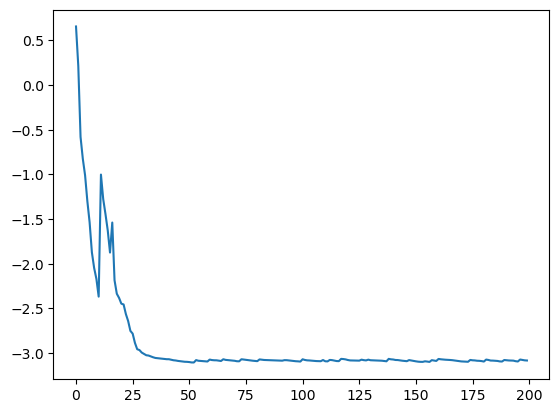

In [ ]:
import matplotlib.pyplot as plt
plt.plot(data1)
plt.plot(data2)

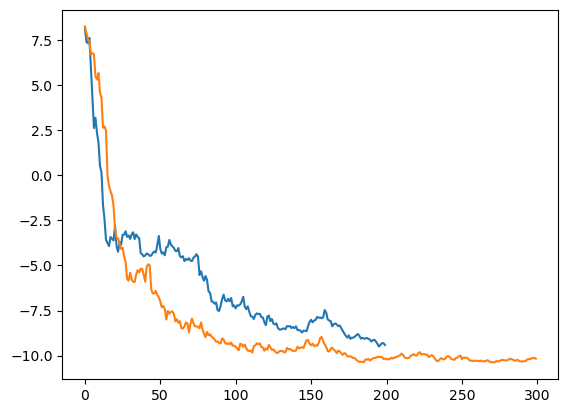

In [ ]:
import matplotlib.pyplot as plt 
plt.plot(data)
plt.plot(data1)

In [ ]:
energy[-1]

In [ ]:
print(data[2])

In [ ]:
data1 = np.array([5.870500000000001, -1.0816, -1.8853, -1.2061, 0.8644000000000001, -4.8286999999999995, -0.9646000000000001, -1.3971, 2.9414, 3.4679, 1.1141999999999999, 1.4443000000000001, -0.13250000000000006, 1.0636, -1.0241000000000002, -2.8175999999999997, -2.4633000000000003, -2.9749, -3.945, -3.1409000000000002, -3.2918000000000003, -3.4714, -3.7152000000000003, -3.8101999999999996, -3.9192, -4.558199999999999, -4.5264999999999995, -4.874300000000001, -4.7635000000000005, -5.2386, -5.347300000000001, -5.6307, -5.5794, -5.4649, -5.7281, -5.6555, -5.6394, -5.8423, -5.742999999999999, -5.7425, -5.5725, -5.5809, -5.6071, -5.665900000000001, -5.7184, -5.7316, -5.7555, -5.8129, -5.837, -5.8574, -5.8692, -5.8688, -5.9429, -5.9831, -6.04, -6.0145, -6.0097, -5.988200000000001, -5.9918, -5.978199999999999, -5.979899999999999, -5.9860999999999995, -6.0024, -6.0102, -6.0339, -6.0511, -5.9918, -6.030399999999999, -6.0366, -6.0145, -5.9984, -6.0132, -6.0198, -5.996300000000001, -6.0204, -6.0597, -6.0274, -6.0535, -6.078, -6.0763, -6.0624, -6.0644, -6.0790999999999995, -6.1021, -6.0606, -6.1121, -6.093500000000001, -6.1064, -6.103199999999999, -6.0969, -6.1076, -6.1295, -6.122999999999999, -6.1033, -6.140499999999999, -6.155600000000001, -6.120800000000001, -6.1479, -6.0995, -6.118200000000001, -6.1268, -6.1302, -6.1078, -6.1435, -6.1255, -6.1578, -6.1394, -6.143800000000001, -6.1514, -6.1555, -6.1652000000000005, -6.1286000000000005, -6.1286000000000005, -6.1705, -6.1530000000000005, -6.138699999999999, -6.155799999999999, -6.1491999999999996, -6.153499999999999, -6.148899999999999, -6.1574, -6.1405, -6.157500000000001, -6.1502, -6.124600000000001, -6.1624, -6.1505, -6.1643, -6.1713, -6.1800999999999995, -6.145099999999999, -6.1664, -6.1423000000000005, -6.158600000000001, -6.132499999999999, -6.1427, -6.1783, -6.138, -6.1331, -6.119, -6.1442, -6.1848, -6.1405, -6.1325, -6.1404, -6.1536, -6.1642, -6.148700000000001, -6.1552999999999995, -6.1696, -6.1655, -6.1683, -6.1334, -6.1674999999999995, -6.1449, -6.146, -6.1594, -6.1455, -6.1625, -6.133800000000001, -6.160200000000001, -6.1394, -6.1371, -6.1644, -6.1463, -6.1674, -6.1363, -6.1647, -6.1557, -6.1732, -6.184900000000001, -6.1706, -6.166, -6.147, -6.153199999999999, -6.1284, -6.1679, -6.1729, -6.1661, -6.162100000000001, -6.1616, -6.1718, -6.1693999999999996, -6.1515, -6.1457, -6.1659, -6.1632, -6.1629000000000005, -6.192, -6.1539, -6.1495999999999995, -6.1594999999999995, -6.1331999999999995, -6.1552, -6.1702, -6.1415, -6.1683, -6.164300000000001, -6.1738, -6.1572])

In [ ]:
data2 = np.array([5.876900000000001, -0.38429999999999986, 0.23609999999999998, 1.2325, -1.2551999999999996, -0.8656000000000001, -0.5759, 0.03639999999999999, -3.0502000000000002, -0.09060000000000029, -0.8639, 0.9531000000000001, 0.4236000000000002, 2.6674, -0.4133000000000001, -0.9119999999999999, 3.4711999999999996, 2.785, 2.8876999999999997, 2.9383, 2.7858, 0.9882, -0.15449999999999986, -0.7355999999999998, -0.7075000000000002, -0.9596999999999998, -1.3254000000000001, -1.7320999999999998, -1.8753, -2.1377, -2.103, -2.3335000000000004, -2.4909, -2.5199, -2.521300000000001, -2.5968, -2.6124, -2.6135, -2.608599999999999, -2.6007, -2.6634, -2.6698000000000004, -2.7115, -2.67, -2.6883, -2.7975000000000003, -2.8110999999999997, -2.8366, -2.8515, -2.8264000000000005, -2.9046000000000007, -3.0027, -3.0644000000000005, -3.1731999999999996, -3.2026999999999997, -3.1549, -3.2622, -3.2748999999999997, -3.2968, -3.3259, -3.3292, -3.2840000000000003, -3.2622, -3.2392, -3.2472999999999996, -3.2664, -3.3533999999999997, -3.3272000000000004, -3.3029, -3.3716000000000004, -3.3831, -3.4626, -3.4767, -3.4436999999999998, -3.4427000000000003, -3.4606999999999997, -3.3998000000000004, -3.368, -3.4052, -3.3877999999999995, -3.4307, -3.4766, -3.4295999999999998, -3.4334999999999996, -3.4458, -3.4772, -3.5175999999999994, -3.629, -3.6291, -3.6851000000000003, -3.7146999999999997, -3.7154, -3.7480999999999995, -3.7807999999999997, -3.8819000000000004, -3.878, -3.8783000000000003, -3.8093, -3.8405, -3.8055000000000003, -3.8344, -3.8561, -3.8462, -3.8425, -3.8164, -3.8098, -3.807, -3.8299999999999996, -3.876, -3.8051, -3.7930000000000006, -3.8931999999999993, -3.9424, -3.9806000000000004, -3.9603, -3.9689, -3.9968999999999997, -4.006200000000001, -4.0402, -4.0464, -4.135, -4.1606000000000005, -4.1582, -4.132000000000001, -4.187899999999999, -4.2434, -4.255000000000001, -4.2459, -4.2233, -4.1903999999999995, -4.1879, -4.2847, -4.226999999999999, -4.2343, -4.3055, -4.2469, -4.266, -4.2134, -4.2759, -4.3025, -4.3169, -4.2878, -4.300000000000001, -4.2982000000000005, -4.3305, -4.3304, -4.3023, -4.3493, -4.3381, -4.3418, -4.334, -4.3292, -4.3464, -4.3359, -4.3377, -4.3308, -4.3198, -4.3233999999999995, -4.3651, -4.327, -4.3937, -4.3681, -4.3719, -4.3881, -4.3945, -4.3351999999999995, -4.3815, -4.3651, -4.3785, -4.4072, -4.4505, -4.4059, -4.4129, -4.4204, -4.4252, -4.4398, -4.4178, -4.4433, -4.4522, -4.4219, -4.445, -4.4786, -4.4625, -4.4948999999999995, -4.4955, -4.4987, -4.493600000000001, -4.5677, -4.5287999999999995, -4.5509, -4.566400000000001, -4.5102, -4.5156, -4.5508, -4.5117, -4.5522, -4.5946, -4.5706, -4.619400000000001, -4.598700000000001])

In [ ]:
data3 = np.array([5.8858, 3.4885, -1.7288000000000001, 0.1602, -1.549, 0.5079, 1.0537, -0.4395, 0.10209999999999986, 1.3577, -0.13760000000000006, -0.16710000000000003, -0.6293, -1.0002, -1.3889, -0.9658000000000002, -2.1378999999999997, -1.8573, -2.3414, -3.0898, -3.3234999999999997, -3.1694000000000004, -3.2827, -3.3, -3.3703, -3.2599, -3.2873, -3.1284, -3.0321, -3.1911999999999994, -2.9252, -2.8792999999999997, -2.9313000000000002, -2.9692, -3.1642, -3.1878, -3.2099, -3.2190000000000003, -3.2548, -3.2015, -3.1814, -3.1897, -3.1997, -3.2402, -3.3015, -3.4165, -3.4892000000000003, -3.4804000000000004, -3.5090000000000003, -3.6020999999999996, -3.7148000000000003, -3.7416, -3.7490999999999994, -3.7823, -3.8371, -3.8636999999999997, -4.1065000000000005, -4.1475, -4.2071000000000005, -4.1817, -4.1838, -4.246700000000001, -4.2218, -4.1725, -4.2361, -4.231, -4.2998, -4.3447000000000005, -4.3544, -4.3821, -4.3408999999999995, -4.4047, -4.4305, -4.4282, -4.4746, -4.4913, -4.4940999999999995, -4.6244000000000005, -4.6112, -4.6718, -4.6234, -4.685300000000001, -4.6579, -4.7248, -4.6572, -4.6614, -4.6783, -4.6076999999999995, -4.6431000000000004, -4.6867, -4.7425, -4.753, -4.722799999999999, -4.7977, -4.8231, -4.8099, -4.8146, -4.8408999999999995, -4.8127, -4.7927, -4.7779, -4.86, -4.8509, -4.8483, -4.870299999999999, -4.8753, -4.9265, -4.866700000000001, -4.89, -4.924, -4.9167, -4.8583, -4.9126, -4.8421, -4.8492, -4.8571, -4.943999999999999, -4.9634, -4.9603, -4.992999999999999, -5.016, -5.0876, -5.0588, -5.1662, -5.1417, -5.0949, -5.1266, -5.108499999999999, -5.1422, -5.1912, -5.174, -5.1432, -5.2071000000000005, -5.1909, -5.1544, -5.1846, -5.2458, -5.2668, -5.2708, -5.2907, -5.2882, -5.2763, -5.2854, -5.3201, -5.3288, -5.3271, -5.3161000000000005, -5.3079, -5.3364, -5.3668, -5.3719, -5.3451, -5.3417, -5.3395, -5.3556, -5.3534999999999995, -5.384399999999999, -5.3712, -5.391299999999999, -5.3985, -5.4165, -5.3936, -5.4352, -5.4331000000000005, -5.4224, -5.4498, -5.4633, -5.5087, -5.4883, -5.463, -5.5158000000000005, -5.4969, -5.5164, -5.5247, -5.5318000000000005, -5.5083, -5.4725, -5.5198, -5.5145, -5.4989, -5.4769, -5.4957, -5.5239, -5.500500000000001, -5.5158000000000005, -5.5016, -5.5045, -5.4843, -5.5033, -5.484999999999999, -5.5306999999999995, -5.497999999999999, -5.5159, -5.4857, -5.4907, -5.5096, -5.469200000000001, -5.5124, -5.5047, -5.5239]
)

In [ ]:
import matplotlib.pyplot as plt

x = np.arange(0, len(data1))


high_PRS = np.zeros(len(data1))
low_PRS = np.zeros(len(data1))

for i in range(len(data1)):
    high_PRS[i] = max(data1[i], data2[i], data3[i])
    low_PRS[i] = min(data1[i], data2[i], data3[i])

# plt.ylim(-6.3,-6)
plt.plot((data1+data2+data3)/3, color='teal', lw=1, label='Parameter-Shift Rule, LR= 0.15')
plt.fill_between(x, high_PRS, low_PRS,  color='teal', alpha=.3)

In [ ]:
a = np.array([pauli_measurement(hamiltonian, ansatz, initial_point, shots, backend) for _ in range(20) ]).std()

In [ ]:
print(a)

In [ ]:
data4 = np.array([5.8504, 5.4091, 4.7633, 1.4179000000000004, 0.245, -3.6641000000000004, -3.7373000000000003, -3.0168999999999997, -3.6892000000000005, -4.9089, -3.5229999999999997, -4.9992, -5.3736, -5.5503, -5.0588999999999995, -5.7987, -4.7356, -4.9748, -5.0014, -5.6031, -5.6865000000000006, -5.6179, -5.519, -5.6001, -5.931699999999999, -5.9513, -5.997400000000001, -6.0299000000000005, -5.997400000000001, -6.000900000000001, -5.953600000000001, -5.9749, -5.9874, -5.911099999999999, -5.928, -5.8748000000000005, -5.9679, -5.987299999999999, -5.9616, -5.9428, -5.9102, -5.928699999999999, -5.8834, -6.0044, -6.0482000000000005, -6.0969, -6.0524, -6.0512, -6.072800000000001, -6.0381, -6.0626, -6.079, -6.1088000000000005, -6.1147, -6.1217, -6.1096, -6.1361, -6.1389000000000005, -6.1608, -6.1331, -6.136699999999999, -6.1474, -6.1686000000000005, -6.1639, -6.1643, -6.1537999999999995, -6.1579, -6.178699999999999, -6.186, -6.1525, -6.1763, -6.1791, -6.1887, -6.181900000000001, -6.2238999999999995, -6.1899, -6.1996, -6.2101, -6.172, -6.186299999999999, -6.1942, -6.1960999999999995, -6.2010000000000005, -6.223999999999999, -6.198500000000001, -6.1924, -6.1975, -6.219000000000001, -6.1955, -6.197100000000001, -6.187, -6.1827, -6.1690000000000005, -6.223800000000001, -6.2048000000000005, -6.2041, -6.2039, -6.2041, -6.1965, -6.1831, -6.2081, -6.212599999999999, -6.209, -6.2216000000000005, -6.2029, -6.2006, -6.2038, -6.2116999999999996, -6.2056, -6.2088, -6.2107, -6.2133, -6.2091, -6.2243, -6.1842, -6.2016, -6.217700000000001, -6.2084, -6.2143999999999995, -6.1959, -6.2045, -6.2085, -6.2016, -6.212199999999999, -6.2212000000000005, -6.2098, -6.2022, -6.220700000000001, -6.2056000000000004, -6.200200000000001, -6.2124999999999995, -6.2322999999999995, -6.226400000000001, -6.2348, -6.1770000000000005, -6.2498000000000005, -6.212400000000001, -6.2116, -6.2256, -6.2204999999999995, -6.2208, -6.2134, -6.2063, -6.2315, -6.215, -6.2224, -6.219099999999999, -6.2347, -6.2138, -6.2102, -6.2326, -6.1983, -6.2152, -6.2143, -6.2258000000000004, -6.206300000000001, -6.2255, -6.222199999999999, -6.2204, -6.216200000000001, -6.2158999999999995, -6.2063, -6.2265999999999995, -6.210699999999999, -6.2271, -6.2177, -6.208699999999999, -6.2138, -6.2102, -6.222300000000001, -6.2126, -6.1862, -6.2204, -6.234499999999999, -6.2197, -6.214, -6.2238, -6.2098, -6.2098, -6.2308, -6.223599999999999, -6.208499999999999, -6.241299999999999, -6.2341, -6.2193000000000005, -6.2471, -6.2037, -6.2292, -6.222999999999999, -6.2217, -6.2134, -6.232, -6.233499999999999, -6.1968, -6.2392, -6.2128000000000005, -6.2081, -6.2134, -6.201700000000001, -6.205])

In [ ]:
data5 = np.array([5.8803, -1.6879, 0.4657000000000001, -1.4763, 0.20859999999999979, 1.6065, 2.1718, -0.008299999999999974, -2.2845, 1.1560000000000001, -2.0108, -2.3645, -2.7847, -2.4072999999999998, 0.023499999999999965, -2.926, -2.7586, -2.8303, -2.3848, -2.2813, -2.4322999999999997, -2.5885, -2.6408, -2.7259, -2.5964, -2.7567999999999997, -2.664, -2.3855999999999997, -2.3614, -2.4244000000000003, -2.6081000000000003, -2.6561000000000003, -2.5860999999999996, -2.7925, -2.8308, -2.9717000000000002, -3.029, -3.1752000000000002, -3.1056000000000004, -3.0669, -3.1097, -3.2624, -3.4495000000000005, -3.4696999999999996, -3.4385, -3.4606, -3.4718999999999998, -3.5109000000000004, -3.4025, -3.3783, -3.4059, -3.4365, -3.5103, -3.609, -3.7184999999999997, -3.7598, -3.7777, -3.769, -3.761, -3.7865999999999995, -3.8417, -3.8563, -3.8845, -3.9297999999999997, -3.9745, -3.9379, -4.0913, -4.0366, -4.1135, -4.1301, -4.0288, -4.1546, -4.1432, -4.1821, -4.173, -4.2829, -4.2284999999999995, -4.3655, -4.5515, -4.5847, -4.6192, -4.709899999999999, -4.7539, -4.7802999999999995, -4.7424, -4.8056, -4.8441, -4.8546, -4.8589, -4.8225999999999996, -4.912700000000001, -4.9007000000000005, -4.856800000000001, -4.8619, -4.9065, -4.9327, -4.8531, -4.819000000000001, -4.8377, -4.8896, -4.901300000000001, -4.8956, -4.9201, -4.9905, -5.0206, -5.013299999999999, -4.9843, -4.9932, -5.0496, -5.087, -5.162599999999999, -5.122999999999999, -5.1423000000000005, -5.1579999999999995, -5.1844, -5.172, -5.227399999999999, -5.2035, -5.236800000000001, -5.2479, -5.2713, -5.3287, -5.299799999999999, -5.3086, -5.355499999999999, -5.3708, -5.4121, -5.3543, -5.3438, -5.4059, -5.3877, -5.3998, -5.4136, -5.3770999999999995, -5.4227, -5.4103, -5.4311, -5.401400000000001, -5.422000000000001, -5.4416, -5.4323, -5.4131, -5.4276, -5.4266, -5.4712000000000005, -5.502000000000001, -5.5075, -5.5081, -5.507, -5.5024999999999995, -5.483700000000001, -5.5326, -5.5287999999999995, -5.5422, -5.5145, -5.5278, -5.4851, -5.512, -5.4858, -5.4902, -5.5093, -5.5479, -5.516500000000001, -5.5315, -5.5509, -5.5644, -5.5442, -5.5947, -5.604900000000001, -5.6121, -5.6047, -5.6375, -5.6313, -5.592499999999999, -5.6384, -5.5884, -5.602, -5.606299999999999, -5.629300000000001, -5.624499999999999, -5.6437, -5.6371, -5.6479, -5.6716, -5.6737, -5.6654, -5.6800999999999995, -5.7004, -5.7002999999999995, -5.714700000000001, -5.699299999999999, -5.7176, -5.7077, -5.7233, -5.7105999999999995, -5.7316, -5.7421, -5.7161, -5.7262, -5.7413])

In [ ]:
plt.plot(data1)
# plt.plot(data2)
# plt.plot(data3)
plt.plot(data4)
# plt.plot(data5)
# plt.plot(energy)

In [ ]:
ansatz = Customize_EfficientSU2(1, 1)
plt.figure(figsize=(20,4))
ansatz.draw('mpl', style='bw')

In [ ]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
import math as m
import Our_Qiskit_Functions as oq

import matplotlib.pyplot as plt

t1 = 91
t2 = 91
Shots = 10000
Parameter_Space = np.zeros(shape=(t1,t2))
Ground_State = [100,0,0]
# H = {'X':3,'Y':-2,'Z':1}
H = {'X':20,'Y': 0,'Z':-10}
Hk = list( H.keys() )
#--------------------------------------------------

# @jit(nopython=True, P)
def single_qubit(Parameter_Space, Ground_State):
    for i in np.arange( t1 ):
        theta = m.pi*(i/t1)
        for j in np.arange( t2 ):
            phi = 2*m.pi*(j/t2)
            Measures = []
            for k in np.arange(len(Hk)):
                q = QuantumRegister( 1, name='q' )
                c = ClassicalRegister( 1, name='c' )
                qc= QuantumCircuit( q, c, name='qc')
                oq.Single_Qubit_Ansatz( qc, q[0], [theta, phi] )
                if( Hk[k] == 'X' ):
                    qc.ry( -m.pi/2, q[0])
                if( Hk[k] == 'Y' ):
                    qc.rx(m.pi/2, q[0])
                qc.measure( q,c )
                M = {'0':0,'1':0}
                M.update( oq.Measurement( qc, shots=Shots, print_M=False, return_M=True ) )
                Measures.append( M )
            Parameter_Space[i,j] = H['X']*(Measures[0]['0'] - Measures[0]['1'])/Shots + H['Y']*(Measures[1]['0'] - Measures[1]['1'])/Shots + H['Z']*(Measures[2]['0'] - Measures[2]['1'])/Shots
            if( Parameter_Space[i,j] < Ground_State[0] ):
                Ground_State[0] = Parameter_Space[i,j]
                Ground_State[1] = theta
                Ground_State[2] = phi
    return Parameter_Space, Ground_State
#==================================================

Parameter_Space, Ground_State = single_qubit(Parameter_Space, Ground_State)

print('Ground State Energy: ',round(Ground_State[0],5),' \u03B8 = ',round(Ground_State[1],3),' \u03C6 = ',round(Ground_State[2],3))
fig, ax = plt.subplots()
show_text = False
show_ticks = False
oq.Heatmap(Parameter_Space, show_text, show_ticks, ax, "plasma", "Energy Expectation Value")
fig.tight_layout()
plt.show()

In [ ]:
gs_energy = -6.29150262
energy_evaluation = np.array((intermediate_info['energy']))
energy_error =  abs((energy_evaluation-gs_energy)/gs_energy)

In [ ]:
import matplotlib.pyplot as plt

plt.plot(energy_error, color='blue', lw=1, label='QND')
# plt.yscale('log')

In [ ]:
import numpy as np
from qiskit import Aer
backend = Aer.get_backend('qasm_simulator')

t = 100
shots = 20000

Parameter_Space = np.zeros((t,t))



for i in range(t):
    
    ansatz = Customize_EfficientSU2(1, 1)
    phi = 2*np.pi*(i/t)
    for j in range(t):
        theta = np.pi*(j/t)
        bind_ansatz = QuantumCircuit(1)
        bind_ansatz.ry(phi, 0)
        bind_ansatz.rz(theta, 0)
        Parameter_Space[i][j] = -20*Measurement('Z', bind_ansatz, shots, backend)[0] +  10*Measurement('X', bind_ansatz, shots, backend)[0]

        


In [ ]:
phi = 3
theta = 3
bind_ansatz = QuantumCircuit(1)
bind_ansatz.ry(phi, 0)
bind_ansatz.rz(theta, 0)
print(-20*Measurement('Z', bind_ansatz, shots, backend)[0] +  10*Measurement('X', bind_ansatz, shots, backend)[0])

In [ ]:
Parameter_Space

In [ ]:
for element, value in enumerate([1,2,3,7,8]):
    print(value)

In [ ]:
import numpy as np
a = np.array([3.8803, 3.7379999999999995, 3.5892, 3.4294000000000002, 3.2699, 3.0888, 2.904, 2.6702000000000004, 2.4394, 2.2187, 1.9335, 1.6578000000000002, 1.354, 1.0419999999999998, 0.7181, 0.4647, 0.12819999999999987, -0.18419999999999992, -0.4737, -0.7720000000000002, -1.0343, -1.2711999999999999, -1.4987, -1.6827, -1.9181, -2.0929, -2.2599, -2.3745999999999996, -2.5808, -2.6834999999999996, -2.8096, -2.9200999999999997, -3.0585, -3.135, -3.2622999999999998, -3.3575000000000004, -3.4593999999999996, -3.5598, -3.6122, -3.7354000000000003, -3.8013000000000003, -3.8941, -4.008900000000001, -4.0828, -4.159, -4.3008, -4.3006, -4.4173, -4.4764, -4.5375000000000005, -4.5846, -4.6998999999999995, -4.7122, -4.7856000000000005, -4.8178, -4.8523, -4.9438, -5.0173000000000005, -5.0232, -5.0686, -5.0545, -4.6690000000000005, -1.0696999999999999, 1.3867, 1.3583, 1.1519000000000001, -1.7196, 0.9786999999999999, -2.9019, 0.3113999999999999, -3.9767, 0.21250000000000013, -4.454599999999999, -0.056700000000000195, -3.175, 0.3423999999999998, -3.0056000000000003, 0.06559999999999988, -0.6527999999999999, 0.6014999999999999, -4.2221, 0.9249, 0.9145000000000001, 0.6606000000000001, -3.5092999999999996, -1.6812, -1.1274000000000002, -1.4674, -1.8658000000000001, -2.3366, -1.7786, -2.1499, -2.4198, -2.9178, -0.14550000000000007, -4.9632000000000005, -4.431699999999999, -2.3976999999999995, -1.0569999999999997, -3.2516000000000003, -3.0284, -2.3657, -2.4888000000000003, -2.1376, 0.11339999999999995, -0.9663000000000002, -5.0929, -4.9839, -4.3274, -1.7494000000000003, -2.1669, -4.1865, -3.4862, -0.6965999999999999, -1.826, -5.1438, -5.0258, -4.931, -4.6905, -4.067200000000001])
print(len(a))

In [ ]:
initial_point = (np.zeros(3))
print(initial_point)

In [ ]:
x = np.zeros(len(intermediate_info['parameters']))
y = np.zeros(len(intermediate_info['parameters']))

data = intermediate_info['parameters']

for i in range(len(intermediate_info['parameters'])):
    x[i] = data[i][0]
    y[i] = data[i][1]

In [ ]:
x

In [ ]:
y

In [ ]:
data = [1.8435, 1.64385, 1.48295, 1.2423499999999998, 1.0141, 0.7488499999999998, 0.4646499999999999, 0.18555, -0.08034999999999995, -0.35185, -0.58485, -0.8206999999999999, -1.01185, -1.20155, -1.3255, -1.4866, -1.56695, -1.6390500000000001, -1.73395, -1.8027000000000002, -1.8685000000000003, -1.9377499999999999, -1.9872, -2.0617, -2.10435, -2.152, -2.217, -2.2674499999999997, -2.32335, -2.3653999999999997, -2.4309000000000003, -2.46625, -2.5132, -2.5466, -2.60375, -2.6619, -2.6866000000000003, -2.7265999999999995, -2.7529, -2.7994499999999998, -2.8381999999999996, -2.86375, -2.9006499999999997, -2.9164000000000003, -2.9536000000000002, -2.9637999999999995, -2.99095, -3.00965, -3.02555, -3.03475, -3.0526, -3.0573499999999996, -3.07565, -3.0707999999999998, -3.0922, -3.1081499999999997, -3.1, -3.1188000000000002, -3.1467, -3.13615, -3.1414, -3.1498999999999997, -3.1622999999999997, -3.15945, -3.1700500000000003, -3.1669, -3.1542999999999997, -3.1658, -3.1606, -3.1832000000000003, -3.18405, -3.1980999999999997, -3.1959, -3.21075, -3.19765, -3.2186000000000003, -3.19965, -3.2094500000000004, -3.2069999999999994, -3.2131999999999996, -3.2250500000000004, -3.2221, -3.22175, -3.2330000000000005, -3.2382999999999997, -3.2308000000000003, -3.23565, -3.2485000000000004, -3.2545, -3.2656, -3.26425, -3.2645999999999997, -3.2714999999999996, -3.2840999999999996, -3.2716000000000003, -3.28065, -3.3059999999999996, -3.2893, -3.3073499999999996, -3.3064000000000004, -3.3103, -3.30605, -3.3249999999999997, -3.3083, -3.3253500000000003, -3.33155, -3.3343499999999997, -3.3312999999999997, -3.3382, -3.2104000000000004, -2.5495, -0.2988999999999999, -0.47650000000000003, -2.29495, -3.25035, -3.3375, -3.3399, -2.12975, -3.30695, -1.1154, -1.2699500000000001, -1.32595, -2.9345499999999998, -2.8979, -0.61185, -3.0581499999999995, -0.7578499999999999, -3.29655, -0.8328, -1.38605, -2.26505, -3.2464999999999997, -2.8868, -2.38375, -1.35275, -3.2787000000000006, -3.06035, -2.45825, -2.75415, -1.8259499999999997, -3.3718500000000002, -3.2727, -2.96655, -1.9577499999999999, -2.7764499999999996, -2.1477, -2.9685, -2.24355, -2.83355, -2.02405, -2.74925, -1.2996, -2.3449999999999998, -2.5060499999999997, -1.4375, -2.9205, -2.42485, -1.29775, -1.4304000000000001, -2.39415, -2.8124999999999996, -3.3158000000000003, -3.1752499999999997, -2.9038, -2.2583500000000005, -2.6794000000000002, -2.17775, -3.0692500000000003, -1.8455500000000002, -2.99845, -1.7234999999999998, -3.2845000000000004, -2.9469000000000003, -1.3805, -2.0559, -1.5958500000000002, -3.1338500000000002, -2.7973000000000003, -1.83785, -3.3057499999999997, -2.8015, -1.4044500000000002, -2.8428000000000004, -1.3768, -1.72765, -3.3763, -3.4036, -3.41255, -3.3857999999999997, -3.2558, -1.78515, -2.6276, -1.3672000000000002, -1.7635, -3.3314, -3.16305, -2.5131500000000004, -2.18285, -1.67625, -3.3710000000000004]


In [ ]:
a = np.array([[1,2], [-1,2]])
print(np.p)

In [ ]:
print(np.dot(b,a))
print(np.dot(a,b))

In [ ]:
print(VQE_runtime)

In [ ]:
print(VQE_runtime[-1])

# Test Swap test

In [ ]:
from qiskit import QuantumCircuit
from qiskit import ClassicalRegister
from qiskit import Aer

qc1 = QuantumCircuit(2)
qc1.h(0)
# qc1.h(1)
qc1.cx(0,1)

qc2 = QuantumCircuit(2)
# qc2.h(0)
# qc2.x(1)

circ = QuantumCircuit(5)

circ = circ.compose(qc1, [1,2])

circ = circ.compose(qc2, [3,4])

circ.barrier()

circ.h(0)
circ.cswap(0, 1, 3)
circ.cswap(0, 2, 4)
circ.h(0)

circ. barrier()
# # First measurement
CR2 = ClassicalRegister(1)

circ.add_register(CR2)

circ.measure(0, 0)

simulator = Aer.get_backend('aer_simulator')
result = simulator.run(circ, shots = 2000).result()

counts = result.get_counts()

# print(result)
print(counts)

circ.draw('mpl', style='iqx')

In [ ]:
from qiskit import QuantumCircuit
from qiskit import ClassicalRegister
from qiskit import Aer

def SwapTestCircuit(circ1, circ2):
    """
    circ1: for the parameter circuit of VQD
    circ2: for the parameter circuit of VQE, this circuit have the infromation from the VQE running, or the k-1 of VQD running
    shots: number of shots
    backend: backend for running
    """

    # Perpare the circuit
    num_qubits = circ1.num_qubits
    circ = QuantumCircuit(2*num_qubits+1) # Plus one for the ancilla qubit

    circ = circ.compose(circ1, [i for i in range(1, num_qubits+1)])
    circ = circ.compose(circ2, [i for i in range(num_qubits+1, num_qubits*2+1)])
    circ.barrier()

    circ.h(0)

    for i in range(1, num_qubits+1):
        circ.cswap(0, i, i+num_qubits)

    circ.h(0) 


    # Make measurement
    measurement = ClassicalRegister(1)
    circ.add_register(measurement)
    circ.measure(0, 0)

    # result = simulator.run(circ, shots = shots).result()

    # counts = result.get_counts()

    # overlap_value = 1 - 2*counts['1']/shots

    
    return circ
        
simulator = Aer.get_backend('aer_simulator')

qc1 = QuantumCircuit(3)
qc1.h(0)
qc1.h(2)
qc1.cx(0,1)

qc2 = QuantumCircuit(3)
# qc2.x(0)

circ12 = SwapTestCircuit(qc1, qc2)

# print(overlap_value)
circ12.draw('mpl')

# Overlap circuit

In [ ]:
# gradient of overlap term
from qiskit import QuantumCircuit


def Overlap_Circuit(super_circuit, compared_circuit):
    """
    super_circuit: ansatz circuit for perparing k-state perpare form the seprerate circuit apart
    compared_circuit: ansatz circuit from the data of 0-(k-1) state
    return the overlap term of them
    """
    gradient_overlap_term_circuit = []

    for i in range(len(super_circuit)):
        if super_circuit[i][0].operation.params:
            for j in range(super_circuit[i].num_qubits):
                if super_circuit[i][j].operation.name == 'rx':
                    qc = QuantumCircuit(super_circuit[i].num_qubits)
                    qc.x(j)

                    internal_circuit = QuantumCircuit(super_circuit[i].num_qubits)
                    for k in range(i+1):
                        internal_circuit = internal_circuit.compose(super_circuit[k])
                    
                    internal_circuit = internal_circuit.compose(qc)

                    for k in range(i+1, len(super_circuit)):
                        internal_circuit = internal_circuit.compose(super_circuit[k])
                    
                    gradient_overlap_term_circuit.append(internal_circuit) 


                if super_circuit[i][j].operation.name == 'ry':
                    qc = QuantumCircuit(super_circuit[i].num_qubits)
                    qc.y(j)
                    internal_circuit = QuantumCircuit(super_circuit[i].num_qubits)
                    for k in range(i+1):
                        internal_circuit = internal_circuit.compose(super_circuit[k])
                    
                    internal_circuit = internal_circuit.compose(qc)

                    for k in range(i+1, len(super_circuit)):
                        internal_circuit = internal_circuit.compose(super_circuit[k])
                    
                    gradient_overlap_term_circuit.append(internal_circuit)
                        
                if super_circuit[i][j].operation.name == 'rz':
                    qc = QuantumCircuit(super_circuit[i].num_qubits)
                    qc.z(j)
                    internal_circuit = QuantumCircuit(super_circuit[i].num_qubits)
                    for k in range(i+1):
                        internal_circuit = internal_circuit.compose(super_circuit[k])
                    
                    internal_circuit = internal_circuit.compose(qc)

                    for k in range(i+1, len(super_circuit)):
                        internal_circuit = internal_circuit.compose(super_circuit[k])

                    gradient_overlap_term_circuit.append(internal_circuit)



    for i in range(len(gradient_overlap_term_circuit)):
        gradient_overlap_term_circuit[i] = (SwapTestCircuit(gradient_overlap_term_circuit[i], compared_circuit))
    return gradient_overlap_term_circuit

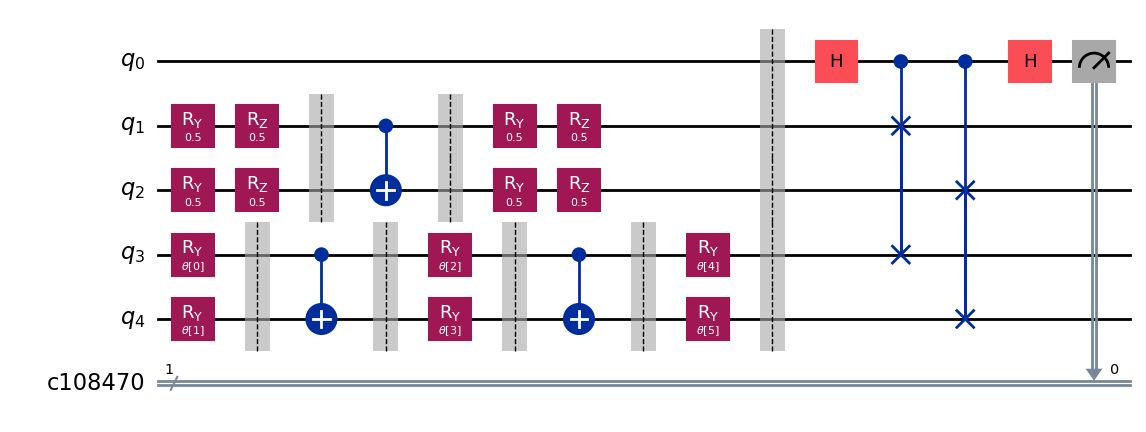

In [342]:
circ1 = Customize_EfficientSU2(2,1)
initial_point = np.zeros(circ1.num_parameters)+0.5
circ1 = circ1.bind_parameters({theta: initial_point[k] for k, theta in enumerate(circ1.parameters)})
circ2 = Customize_RealAmplidues(2, 2)

ansatz = SwapTestCircuit(circ1, circ2)

ansatz.draw('mpl', style='iqx')

# STEP 6: SWAP TEST

In [718]:
from qiskit import QuantumCircuit
from qiskit import ClassicalRegister
from qiskit import Aer

def SwapTestCircuit(circ1, circ2):
    """
    circ1: for the parameter circuit of VQD
    circ2: for the parameter circuit of VQE, this circuit have the infromation from the VQE running, or the k-1 of VQD running
    shots: number of shots
    backend: backend for running
    """

    # Perpare the circuit
    num_qubits = circ1.num_qubits
    circ = QuantumCircuit(2*num_qubits+1) # Plus one for the ancilla qubit

    circ = circ.compose(circ1, [i for i in range(1, num_qubits+1)])
    circ = circ.compose(circ2, [i for i in range(num_qubits+1, num_qubits*2+1)])
    circ.barrier()

    circ.h(0)
    for i in range(1, num_qubits+1):
        circ.cswap(0, i, i+num_qubits)
    circ.h(0) 

    # Make measurement
    measurement = ClassicalRegister(1)
    circ.add_register(measurement)
    circ.measure(0, 0)  

    return circ


def pauli_measurement(operator, ansatz, initial_point, shots, backend):
    """ 
    operator: indicate the sum of serries of Tensor Product Pauli Operator (Hamiltonian)
    ansatz: the parameter circuit
    initial_point: the parameter for our parameter circuit
    shots: number of shots
    backend: the quantum simulator
    retun: the Hamiltonian value
    """
    internal_anstaz = ansatz.bind_parameters({theta: initial_point[k] for k, theta in enumerate(ansatz.parameters)})  

    internal_energy = 0
    for j in range(len(operator)):
        internal_energy += operator.coeffs.real[j] * Measurement(str(operator.primitive._pauli_list[j]), internal_anstaz, shots, backend)[0]
    return internal_energy


def Customize_SPSA_VQD(operator, k, interation, eta, ansatz, initial_point, shots, backend, callback):
    """
    operator: The pauli operator
    interation: number of interation
    initial_point: the initial point that we will update until we end up with the desired point
    ansatz: the parameterized circuit that we want to update 
    """


    # Scaling parameter for the gradient step size.
    # c = np.array([pauli_measurement(operator, ansatz, initial_point, shots, backend) for _ in range(10)]).std()
    c = 1

    # Stability constant for the step size 10% of number of interations
    A = 0.1*interation

    # Scaling exponent for the step size
    alpha = 0.602

    # Scaling exponent for the gradient step size
    gamma = 0.101

    #  Smallest change of magnitude desired in the elements of θ.
    # delTheta = 0.01
    delTheta = eta
    
    magnitude_g0 = np.abs(Customize_Parameter_Shift_Rule(operator, initial_point, c, ansatz, shots, backend, interation=None)).mean()
    # Scaling parameter for the step size
    # a = delTheta*((A+1)**alpha)/magnitude_g0
    a = eta
    internal_initial_point = initial_point.copy()


    # Optimization part
    grad = np.zeros(ansatz.num_parameters)
    ak = eta/(1+k+A)**alpha
    ck = c/(1+k)**gamma
    
    # print(f'ak_{k}: {ak}')
    # print(f'ck_{k}: {ck}')
    for i in range(len(operator)):
        random = np.array([np.random.choice([-1,1]) for _ in range(ansatz.num_parameters)])
        # print(random)
        plus_parameter = np.array(internal_initial_point.copy())
        plus_parameter = np.add(plus_parameter,random*ck)
        minus_parameter = np.array(internal_initial_point.copy())
        minus_parameter = np.subtract(minus_parameter,random*ck)
        grad_func = ak*operator.coeffs.real[i]*(Measurement(str(operator.primitive._pauli_list[i]), ansatz.bind_parameters({theta: plus_parameter[i] for i, theta in enumerate(ansatz.parameters)}), shots, backend)[0] - Measurement(str(operator.primitive._pauli_list[i]), ansatz.bind_parameters({theta: minus_parameter[i] for i, theta in enumerate(ansatz.parameters)}), shots, backend)[0])/(2*ck)
        
        grad = np.add(grad, grad_func*random)

    internal_initial_point = np.subtract(internal_initial_point, grad)
    
    return internal_initial_point


class Customize_Variational_Quantum_Deflation:
    """
    operator: the pauli operator for finding the ground and excited energy
    interation: number interation for finding ground state energy
    ansatz the parameter circuit from the prerious VQE_runtime
    eta: the learning rate
    initial point: the random point for running
    data_from_VQE: the optimal parameter from VQE runtime
    shots: number of shots
    backend: the backend for simulate quantum computing
    callback: storage data
    """

    def __init__(self, operator: str, interation: int, ansatz, optimize, k, eta: float, initial_point, ground_state, ground_energy, shots, backend, callback):
        # super().__init__()
        # we can add assert for aditional condition for our variable
        # Run validations to the recevied aguments
        assert interation >= 0, f'number of interation need to be greater than 0'


        self.operator = operator
        self.interation = interation
        self.ansatz = ansatz
        self.optimize = optimize
        self.k = k
        self.eta = eta
        self.initial_point = initial_point
        self.ground_state = ground_state
        self.ground_energy = ground_energy
        self.shots = shots
        self.backend = backend
        self.callback = backend

    def __repr__(self):
        return f"VQD('{self.operator}', '{self.interation}', '{self.shots}', '{self.eta}')"
    
    def run_VQD(self):
        
        # Storage data energy running for each k
        data_energy = [[[] for i in range(self.interation)] for i in range(k+1)]
        
        # Storange the best parameter at the end of running
        data_point = [[[] for i in range(self.ansatz.num_parameters)] for i in range(k+1)]

        data_point[0] = self.ground_state


        for k_th_state in range(1, self.k+1):
            internal_initial_point = self.initial_point.copy()
            print(f'{k_th_state}th state')

            for n_int in range(self.interation):
                
                # ansatz with updating vector
                internal_anstaz = self.ansatz.bind_parameters({theta: internal_initial_point[k] for k, theta in enumerate(self.ansatz.parameters)})       
                
                # Calculate the cost function of the VQD or excited-k energy
                first_term_energy = 0
                overlap_value = 0
                
                # I will edit beta later
                beta = 4
                
                # Evaluate the loss function
                # The first term <\psi|H|\psi>
                first_term_energy += pauli_measurement(self.operator, self.ansatz, internal_initial_point, self.shots, self.backend)
                print(f'first_term_energy: {first_term_energy}')
                # Overlap term
                for i in range(k_th_state): # I will start with the simple one first
                    overlap_circuit = SwapTestCircuit(internal_anstaz, self.ansatz.bind_parameters({theta: data_point[i][k] for k, theta in enumerate(self.ansatz.parameters)}))
                    # print(overlap_circuit)
                    # measure the overlap value
                    simulator = self.backend
                    result = simulator.run(overlap_circuit, shots = 5*self.shots).result()
                    counts = result.get_counts()
                    if '1' in counts:
                        overlap_value += 1 - 2*counts['1']/(self.shots*5)
                    else:
                        overlap_value = 1
                print(f'beta*overlap_value: {beta*overlap_value}')

                internal_energy = first_term_energy + beta*overlap_value

                # Loss value
                data_energy[k_th_state][n_int] = internal_energy
                print(internal_energy)
                print(internal_initial_point)


                # Optimization 
                grad = np.zeros(self.ansatz.num_parameters)

                grad = Customize_SPSA_VQD(self.operator, n_int, self.interation, self.eta, self.ansatz, internal_initial_point, self.shots, self.backend, callback=None)

                for i in range(k_th_state): # I will start with the simple one first
                    overlap_circuit = SwapTestCircuit(self.ansatz, self.ansatz.bind_parameters({theta: data_point[i][k] for k, theta in enumerate(ansatz.parameters)}))
                    # Scaling parameter for the gradient step size.
                    c = 1

                    # Stability constant for the step size 10% of number of interations
                    A = 0.1*self.interation

                    # Scaling exponent for the step size
                    alpha = 0.602

                    # Scaling exponent for the gradient step size
                    gamma = 0.101

                    #  Smallest change of magnitude desired in the elements of θ.
                    # delTheta = 0.01
                    delTheta = self.eta
                    
                    magnitude_g0 = np.abs(Customize_Parameter_Shift_Rule(self.operator, self.initial_point, c, self.ansatz, self.shots, self.backend, interation=None)).mean()
                    # magnitude_g0  = 0.1
                    # Scaling parameter for the step size
                    # a = delTheta*((A+1)**alpha)/magnitude_g0
                    a = self.eta

                    # Optimization part
                    grad = np.zeros(ansatz.num_parameters)
                    ak = a/(1+n_int+A)**alpha
                    ck = c/(1+n_int)**gamma
                    
                
                    
                    random = np.array([np.random.choice([-1,1]) for _ in range(ansatz.num_parameters)])
                    # print(random)
                    plus_parameter = np.array(internal_initial_point.copy())
                    plus_parameter = np.add(plus_parameter,random*ck)
                    minus_parameter = np.array(internal_initial_point.copy())
                    minus_parameter = np.subtract(minus_parameter,random*ck)
                    
                    overlap_circuit_plus = overlap_circuit.bind_parameters({theta: plus_parameter[i] for i, theta in enumerate(ansatz.parameters)})
                    overlap_circuit_minus = overlap_circuit.bind_parameters({theta: minus_parameter[i] for i, theta in enumerate(ansatz.parameters)})
                    
                    overlap_value_plus = 0   
                    simulator = self.backend
                    result = simulator.run(overlap_circuit_plus, shots = 5*self.shots).result()
                    counts = result.get_counts()
                    if '1' in counts:
                        overlap_value_plus += 1 - 2*counts['1']/(self.shots*5)
                    else:
                        overlap_value_plus = 1

                    overlap_value_minus = 0   
                    simulator = self.backend
                    result = simulator.run(overlap_circuit_minus, shots = 5*self.shots).result()
                    counts = result.get_counts()
                    if '1' in counts:
                        overlap_value_minus += 1 - 2*counts['1']/(self.shots*5) 
                    else:
                        overlap_value_minus = 1
                        
                    grad = np.add(grad, ak*beta*(overlap_value_plus-overlap_value_minus)/(2*ck) * random)
                    print(grad)
                internal_initial_point = np.subtract(internal_initial_point, grad)
            data_point[k_th_state] = internal_initial_point
    
                    # measure the overlap value
        return data_energy            
                
                        
                
    


# intermediate_info_of_VQE = {
# 'parameters': [],
# 'energy': [],
# 'steps': [],
# }

# def callback(energy, parameters=None):
#     intermediate_info['parameters'].append(parameters)
#     intermediate_info['energy'].append(energy)  


    

In [719]:
# hamiltonian = PauliSumOp(SparsePauliOp(['Z', 'X'],
#               coeffs=[1, -2]), coeff=1.0)

# hamiltonian = PauliSumOp(SparsePauliOp(['Z'],
#               coeffs=[1]), coeff=1.0)
num_qubits = 2
hamiltonian = Ising_hamiltonian(num_qubits,2)
              
ansatz = Customize_RealAmplidues(num_qubits, 1)

interation = 50
# eta = 0.01

# initial_point = np.zeros(ansatz.num_parameters)
# num_qubits = 1
# initial_point = np.array([-1.9899025])
# ground_state = np.array([-1.9899025])
# ground_energy = -2.2356

initial_point = np.array([ 2.02461045, -1.80374338,  0.59865836, -0.11072448])
ground_state = np.array([ 2.02461045, -1.80374338,  0.59865836, -0.11072448])
ground_energy = -4.12310563 
shots = 20000

optimize = 'None'

from qiskit import Aer

backend = Aer.get_backend('qasm_simulator')

k = 1

eta = 1
            
runningVQD = Customize_Variational_Quantum_Deflation(hamiltonian, interation, ansatz, optimize, k, eta, initial_point, ground_state, ground_energy, shots, backend, callback=None)

energy = runningVQD.run_VQD()

1th state
first_term_energy: -4.1064
beta*overlap_value: 4
-0.10639999999999983
[ 2.02461045 -1.80374338  0.59865836 -0.11072448]
[-0.33694303  0.33694303 -0.33694303 -0.33694303]
first_term_energy: -3.5827
beta*overlap_value: 3.56648
-0.016220000000000123
[ 2.36155348 -2.14068641  0.93560139  0.22621855]
[ 0.14931202  0.14931202  0.14931202 -0.14931202]
first_term_energy: -3.1251
beta*overlap_value: 3.25056
0.1254599999999999
[ 2.21224147 -2.28999843  0.78628938  0.37553057]
[-0.20697428  0.20697428  0.20697428 -0.20697428]
first_term_energy: -2.3807
beta*overlap_value: 2.5304
0.14970000000000017
[ 2.41921575 -2.49697271  0.57931509  0.58250485]
[-0.56926649  0.56926649 -0.56926649 -0.56926649]
first_term_energy: -0.12559999999999993
beta*overlap_value: 0.3307199999999999
0.20511999999999997
[ 2.98848224 -3.0662392   1.14858159  1.15177134]
[-0.08720327  0.08720327 -0.08720327  0.08720327]
first_term_energy: -0.23139999999999983
beta*overlap_value: 0.26568000000000014
0.03428000000000

KeyboardInterrupt: 

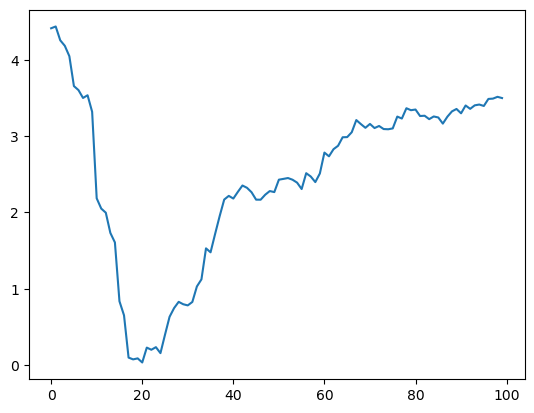

In [694]:
plt.plot(energy[1])

In [ ]:
ansatz = Customize_EfficientSU2(3,1)
ansatz.draw('mpl', style='iqx')

In [ ]:
# Gradient of the overlap circuit
super_circuit = Seperate_Circuit_Apart(ansatz)

In [ ]:
data_from_VQE = np.round((np.random.random(ansatz.num_parameters)),2)
qc_circuit = ansatz.bind_parameters({theta: data_from_VQE[k] for k, theta in enumerate(ansatz.parameters)})
qc_circuit.draw('mpl', style='iqx')

In [ ]:
qc12 = Overlap_Circuit(super_circuit, qc_circuit)

In [ ]:

gradient_overlap_term_circuit2 = []

In [ ]:
qc_circuit.draw('mpl', style='iqx')

In [ ]:
gradient_overlap_term_circuit1[0].draw('mpl', style='iqx')

In [ ]:
gradient_overlap_term_circuit2.append(SwapTestCircuit(gradient_overlap_term_circuit1[0], qc_circuit))

In [ ]:
gradient_overlap_term_circuit2[0].draw('mpl', style='iqx')

In [ ]:
asndsdoks = SwapTestCircuit(gradient_overlap_term_circuit1[0], qc_circuit)

asndsdoks.draw('mpl', style='iqx')

In [ ]:
qc.draw('mpl')

In [ ]:
aaaa = SwapTestCircuit(gradient_overlap_term_circuit1[0],qc)
aaaa.draw('mpl', style='iqx')

In [ ]:
gradient_overlap_term_circuit[0].draw('mpl', style='iqx')

In [ ]:
gradient_overlap_term_circuit[0].draw('mpl', style='iqx')

In [ ]:
super_circuit[1][0].operation.name

In [ ]:
runningVQD.run_VQD()

In [ ]:
from qiskit.algorithms import NumPyEigensolver

# hamiltonian = PauliSumOp(SparsePauliOp(['X'],
#               coeffs=[-20]), coeff=1.0)

hamiltonian = PauliSumOp(SparsePauliOp(['Z','X'],
              coeffs=[10, -20]), coeff=1.0)

# find the first three (k=3) eigenvalues
exact_solver = NumPyEigensolver(k=16)
exact_result = exact_solver.compute_eigenvalues(hamiltonian)
print(exact_result.eigenvalues.real)

In [ ]:
from qiskit.algorithms import NumPyEigensolver


# find the first three (k=3) eigenvalues
exact_solver = NumPyEigensolver(k=16)
exact_result = exact_solver.compute_eigenvalues(hamiltonian)
print(exact_result.eigenvalues.real)

In [ ]:
VQE_runtime

In [ ]:
data1 = [0.44244900000000004, 0.38654399999999994, 0.5592809999999999, 0.5740649999999998, 0.581166, 0.593184, -0.600714, -0.611118, -0.6791099999999999, -0.6782579999999999, -0.6711239999999998, -0.6588179999999999, -0.6564629999999999, -0.6558239999999997, -0.6808319999999999, -0.678207, -0.6725730000000001, -0.6763559999999998, -0.6725579999999998, -0.67416, -0.6488339999999999, -0.6453119999999999, -0.6515340000000001, -0.648717, -0.6597329999999999, -0.667944, -0.6613109999999999, -0.6439920000000001, -0.628863, -0.598962, -0.577305, -0.583641, -0.5820869999999998, -0.5848649999999999, -0.5650229999999999, -0.613941, -0.5966999999999999, -0.6110550000000001, -0.6582299999999999, -0.6623669999999999, -0.6587969999999999, -0.6672899999999999, -0.664533, -0.650163, -0.6548609999999999, -0.6615330000000001, -0.6592289999999998, -0.6584099999999999, -0.661392, -0.6525089999999999, -0.66258, -0.6567989999999999, -0.646398, -0.6476219999999999, -0.6432989999999998, -0.640671, -0.6306990000000001, -0.6342509999999999, -0.6340889999999999, -0.5807519999999998, -0.589398, -0.5997510000000001, -0.5885999999999999, -0.5923709999999999, -0.5806290000000001, -0.5896110000000001, -0.6039660000000001, -0.593418, -0.5900549999999999, -0.582492, -0.5966159999999998, -0.625284, -0.637149, -0.6334439999999999, -0.640701, -0.642015, -0.6297479999999998, -0.636255, -0.6502379999999999, -0.653367, -0.6593279999999998, -0.6474629999999999, -0.672411, -0.676845, -0.6797249999999998, -0.679665, -0.669432, -0.465279, -0.498927, -0.44302800000000003, -0.4807620000000001, -0.313458, -0.5918309999999999, -0.622104, -0.6335159999999999, -0.6210209999999999, -0.637575, -0.6249419999999999, -0.6146940000000001, -0.6011849999999999, -0.5939819999999999, -0.6010199999999999, -0.5891129999999998, -0.6432959999999999, -0.6407129999999999, -0.654153, -0.659094, -0.667581, -0.680082, -0.683745, -0.6832050000000001, -0.678465, -0.675162, -0.6520380000000001, -0.684015, -0.6784379999999999, -0.6828179999999998, -0.6816869999999999, -0.682653, -0.6827099999999998, -0.682338, -0.682623, -0.6812699999999999, -0.683238, -0.68409, -0.6811109999999999, -0.684363, -0.68352, -0.682119, -0.6843239999999999, -0.683538, -0.6849929999999999, -0.6801149999999999, -0.678279, -0.6751949999999999, -0.6762299999999999, -0.6759900000000001, -0.684318, -0.680307, -0.6789089999999999, -0.6797460000000001, -0.67671, -0.689037, -0.688968, -0.68943, -0.688314, -0.6889649999999999, -0.688728, -0.689274, -0.6883829999999999, -0.6884189999999999, -0.688518, -0.6879149999999999, -0.688344, -0.6881189999999999, -0.6879299999999999, -0.689001, -0.6884819999999999, -0.6889079999999999, -0.6874349999999999, -0.6883019999999999, -0.6878249999999999, -0.687738, -0.688773, -0.687672, -0.6885479999999999, -0.6877409999999998, -0.6870719999999998, -0.391782, -0.39422099999999993, -0.42231299999999994, -0.430773, -0.6880620000000001, -0.6878970000000001, -0.6877919999999998, -0.6870029999999999, -0.6869669999999999, -0.6868409999999999, -0.6761549999999998, -0.673872, -0.6738569999999999, -0.6709049999999999, -0.6667049999999999, -0.6595289999999998, -0.6682139999999999, -0.6587669999999999, -0.6639959999999998, -0.6521459999999999, -0.659751, -0.6602759999999999, -0.656172, -0.6559349999999999, -0.658794, -0.6846239999999999, -0.685824, -0.688011, -0.687549, -0.68571, -0.6891689999999999, -0.6886409999999998]

In [ ]:
data2 = [0.626517, 0.618192, 0.631917, 0.6381749999999999, 0.6320730000000001, 0.6236309999999998, 0.629295, 0.4505189999999999, 0.45108899999999985, 0.42282299999999995, 0.425652, 0.44298299999999996, 0.44070299999999996, 0.376224, 0.41664899999999994, 0.41862900000000003, 0.41395499999999996, 0.429006, 0.4480289999999999, 0.4509930000000001, 0.44619300000000006, 0.44158500000000006, 0.443892, 0.34251599999999993, 0.230874, 0.141018, 0.21005100000000002, 0.25764599999999993, 0.2655449999999999, 0.20548800000000003, 0.20438399999999993, 0.19787399999999997, 0.43926899999999997, 0.4088400000000001, 0.4165439999999999, 0.3751230000000001, 0.39625799999999994, 0.383583, 0.38412899999999994, 0.40152899999999997, 0.4574819999999999, 0.33011999999999997, 0.32724899999999996, 0.30672599999999994, 0.269211, -0.041192999999999994, -0.008511, 0.041697, -0.022418999999999994, 0.12491699999999999, 0.13154099999999996, 0.240807, 0.232137, 0.144276, 0.16655399999999995, -0.016686, -0.00041700000000000027, -0.0042120000000000005, -0.014835, -0.09220799999999998, -0.04988099999999999, -0.10151700000000002, -0.16230899999999998, -0.12588899999999997, -0.09200700000000002, -0.121239, -0.18101399999999998, -0.24327899999999997, -0.17668499999999998, -0.198063, -0.235047, -0.231099, -0.23091899999999996, -0.31312500000000004, -0.33, -0.35164500000000004, -0.336792, -0.278625, -0.250425, -0.19836599999999996, -0.22363800000000003, -0.09077699999999998, 0.08873699999999998, 0.019212, 0.017228999999999998, -0.030515999999999998, -0.058760999999999994, -0.31996499999999994, -0.317736, -0.337548, -0.30537899999999996, -0.28790099999999996, -0.3201209999999999, -0.37077, -0.428616, -0.44360999999999995, -0.4046219999999999, -0.38298899999999997, -0.37234199999999995, -0.39803099999999997]

In [ ]:
data3 = [0.5643029999999999, 0.5600069999999999, 0.572781, 0.516591, 0.420873, 0.404418, 0.40271399999999996, 0.43347299999999994, 0.4549889999999999, 0.45837599999999995, 0.43723800000000007, 0.6896729999999999, 0.6894, 0.690135, 0.6896729999999999, 0.689241, 0.68649, 0.6872400000000001, 0.6872759999999999, 0.6888989999999999, 0.689175, 0.6901679999999999, 0.6896219999999998, 0.654123, 0.6570329999999999, 0.650505, 0.64107, 0.6421889999999998, 0.640356, 0.6393690000000001, 0.6448319999999998, 0.635802, 0.6633359999999998, 0.6656099999999999, 0.6638160000000001, 0.656652, 0.6615959999999999, 0.6653549999999999, 0.667068, 0.6631560000000001, 0.6471899999999999, 0.6495329999999999, 0.6544859999999999, 0.6489389999999999, 0.6374850000000001, 0.6348989999999999, 0.6368130000000001, 0.642582, 0.64467, 0.6540029999999999, 0.6450629999999999, 0.6392789999999998, 0.6435599999999999, 0.646593, 0.5742569999999998, 0.5884769999999999, 0.5853809999999999, 0.5754809999999999, 0.5765549999999999, 0.569532, 0.575925, 0.42244499999999996, 0.6763739999999999, 0.6750509999999998, 0.6776760000000001, 0.6678239999999999, 0.6720959999999998, 0.6692579999999999, 0.687606, 0.6891059999999999, 0.690012, 0.6899279999999999, 0.6898919999999998, 0.6897389999999999, 0.6892589999999998, 0.69, 0.690051, 0.68988, 0.690051, 0.6901019999999999, 0.6902039999999999, 0.689691, 0.690033, 0.690051, 0.68988, 0.690051, 0.68988, 0.690051, 0.68988, 0.6897599999999999, 0.6895709999999999, 0.6897599999999999, 0.689691, 0.6897599999999999, 0.6897239999999999, 0.6897599999999999, 0.6892439999999999, 0.689604, 0.689379, 0.6892589999999998, 0.6882809999999999, 0.689961, 0.690012, 0.689961, 0.69, 0.69, 0.69, 0.69, 0.68988, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.690051, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69]


In [ ]:
data4 = [0.590448, 0.603966, 0.6397649999999999, 0.6408780000000001, 0.649551, 0.6493169999999998, 0.6487590000000001, 0.6534179999999998, 0.640242, 0.685593, 0.6841470000000001, 0.68016, 0.6803699999999998, 0.6843809999999998, 0.681054, 0.6823649999999999, 0.6832079999999999, 0.688173, 0.688788, 0.6871950000000001, 0.688821, 0.6888059999999999, 0.6885150000000001, 0.6870629999999999, 0.6855180000000001, 0.6854549999999999, 0.686754, 0.685848, 0.6857460000000001, 0.6888479999999999, 0.687321, 0.6863819999999999, 0.6892469999999999, 0.6862320000000001, 0.6833579999999999, 0.6849989999999999, 0.6849630000000001, 0.685353, 0.685014, 0.6845519999999999, 0.6880560000000001, 0.6897, 0.688605, 0.6888779999999999, 0.6889469999999999, 0.689286, 0.6407700000000001, 0.4877459999999999, 0.4872389999999999, 0.496743, 0.5419679999999999, 0.566376, 0.5721990000000001, 0.594951, 0.5728889999999999, 0.6204540000000001, 0.6169979999999999, 0.599313, 0.6187860000000001, 0.599397, 0.588078, 0.678072, 0.6750929999999999, 0.6760079999999998, 0.6795420000000001, 0.6829919999999998, 0.68697, 0.6882240000000001, 0.6869910000000001, 0.687726, 0.688887, 0.6874229999999998, 0.6873119999999998, 0.688737, 0.687177, 0.689196, 0.6874649999999998, 0.688428, 0.6881640000000001, 0.196635, 0.200454, 0.186144, 0.23526600000000006, 0.19873800000000003, 0.12320399999999998, -0.19084500000000004, -0.187716, -0.20934, -0.258957, -0.252606, -0.23118, -0.13821299999999997, -0.11767799999999999, -0.11499599999999999, -0.11244299999999999, -0.20259299999999997, -0.198606, -0.17792699999999995, -0.103713, -0.07686299999999997, 0.03072, 0.05920800000000001, -0.0001739999999999988, 0.10083299999999999, 0.093246, 0.072252, 0.316683, 0.291456, 0.37302300000000005, 0.386775, 0.38133, 0.389874, 0.35378099999999996, 0.38222399999999995, 0.6045809999999998, 0.5768880000000001, 0.570804, 0.569841, 0.5570579999999998, 0.5844689999999999, 0.577512, 0.5691569999999999, 0.5906939999999999, 0.599154, 0.5933729999999999, 0.57834, 0.5777969999999999, 0.6278399999999998, 0.6204749999999999, 0.628668, 0.581925, 0.582177, 0.5767739999999999, 0.587127, 0.585702, 0.5878320000000001, 0.568692, 0.431823, 0.432702, 0.4512569999999999, 0.429444, 0.40524599999999994, 0.44657999999999987, 0.4478549999999999, 0.463392, 0.45548999999999995, 0.432015, 0.49159200000000003, 0.479061, 0.478074, 0.490545, 0.49903199999999986, 0.483951, 0.48958199999999996, 0.59562, 0.5928899999999999, 0.5811959999999999, 0.5784419999999999, -0.10387499999999998, -0.140253, -0.20909400000000006, -0.23122799999999996, -0.22174199999999997, -0.25443299999999996, -0.18405599999999997, -0.14582099999999998, -0.14922300000000002, -0.12289799999999998, -0.125703, 0.09569999999999998, 0.10052100000000001, 0.208194, 0.23567699999999997, 0.09694199999999999, 0.11730600000000001, 0.3267599999999999, 0.32568299999999994, 0.2916869999999999, 0.494289, 0.489078, 0.5106359999999999, 0.4848719999999999, 0.512022, 0.499137, 0.522465, 0.4928369999999999, 0.49135200000000007, 0.47938800000000004, 0.48383999999999994, 0.48985799999999985, 0.4940939999999999, 0.49760699999999997, -0.1296, -0.091236, -0.10975500000000002, -0.12022199999999998, -0.212433, -0.234891, -0.23552999999999996, -0.233391, -0.39238799999999996, -0.3838079999999999, -0.36504, -0.3676949999999999, -0.3635519999999999, -0.14271299999999998, -0.11265300000000002, -0.053796, -0.126195, -0.10127699999999998, -0.10877700000000001, -0.08516999999999998, -0.042003, -0.11649899999999998, -0.09888599999999999, -0.019226999999999994, -0.031083000000000003, -0.027048, -0.016070999999999995, -0.116616, -0.07839, -0.017175, -0.016013999999999994, -0.036948, -0.039489, -0.053780999999999995, -0.07995299999999998, -0.12475499999999998, -0.07693799999999998, -0.07877399999999998, -0.308955, -0.3185009999999999, -0.31754099999999996, -0.3242609999999999, -0.369045, -0.3434429999999999, -0.359172, -0.311079, -0.3119489999999999, -0.38324400000000003, -0.39556499999999994, -0.31821900000000003, -0.227241, -0.23651999999999998, -0.276852, 0.518463, 0.312696, 0.34971, 0.34108499999999997, 0.4242239999999999, 0.25936499999999996, 0.258873, 0.24864599999999998, 0.25929599999999997, 0.232263, 0.27505499999999994, 0.32510999999999995, 0.326457, 0.35864999999999997, 0.3447, 0.37536899999999995, 0.40743299999999993, 0.41935799999999995, 0.4109999999999999, 0.41998800000000003, 0.6492239999999998, 0.654309, 0.6565889999999998, 0.670377, 0.66792, 0.668319, 0.659862, 0.6593699999999998, 0.670317, 0.6673769999999999, 0.6657299999999999, 0.665643, 0.6628079999999998, 0.667065, 0.6606479999999999, 0.659211, 0.6565020000000001, 0.677643, 0.6804839999999999, 0.6768959999999998, 0.679575, 0.6815699999999999, 0.680289, 0.681324, 0.676734, 0.6665159999999999, 0.673935, 0.677913, 0.6767399999999999, 0.6764189999999999, 0.6774899999999999, 0.67503, 0.673071, 0.6742469999999998, 0.6756179999999998]


In [ ]:
data = [0.344214, 0.3751139999999999, 0.3615419999999999, 0.355644, 0.330729, 0.3349559999999999, 0.3535709999999999, 0.38076600000000005, 0.375033, 0.35915400000000003, 0.3664499999999999, 0.370683, 0.37343099999999996, 0.3724169999999999, 0.3816179999999999, 0.36023999999999984, 0.373662, 0.379911, 0.38970299999999997, 0.377922, 0.3829769999999999, 0.36866999999999983, 0.40664999999999996, 0.407907, 0.3868559999999999, 0.39506099999999994, 0.373458, 0.3591209999999999, 0.363396, 0.356919, 0.37929599999999997, 0.36658199999999996, 0.3935099999999999, 0.38090399999999996, 0.38043, 0.380022, 0.39420599999999995, 0.387423, 0.3660929999999999, 0.332205, 0.337479, 0.3243359999999999, 0.34702199999999994, 0.35101799999999994, 0.320076, 0.32667899999999994, 0.322086, 0.3227879999999999, 0.20330099999999998, 0.204888, 0.19662, 0.20415599999999995, 0.22703699999999993, 0.183495, 0.18810299999999996, 0.16369199999999995, 0.16308299999999998, 0.181566, 0.172272, 0.17187, 0.19079399999999996, 0.18637199999999998, 0.16501200000000002, 0.167178, 0.17255999999999996, 0.15158999999999995, 0.15271199999999996, 0.156468, 0.106734, 0.08999700000000001, 0.09519299999999999, 0.07672799999999998, 0.062439, 0.06536399999999998, 0.021342000000000003, 0.024300000000000002, 0.007430999999999999, 0.014378999999999996, 0.012594000000000001, 0.027593999999999994, 0.023960999999999996, 0.013248, 0.010622999999999997, 0.016871999999999995, 0.014682, 0.021383999999999997, 0.028536000000000002, 0.012170999999999996, 0.029910000000000006, 0.019334999999999995, 0.005937, 0.016364999999999998, 0.010409999999999999, 0.009624, -0.00816, 0.014127, 0.0029490000000000002, -0.004851, -0.025185, -0.026627999999999995, -0.023274, -0.031217999999999996, -0.016859999999999997, -0.032172, 0.010022999999999999, -0.001797, -0.004793999999999999, -0.019218, -0.006969, -0.010247999999999998, -0.015366000000000001, -0.011061, -0.014739000000000002, -0.005045999999999998, -0.029691, -0.011454, -0.013193999999999999, -0.02343, -0.020930999999999998, -0.011448000000000003, -0.030687, -0.015707999999999993, -0.015495, -0.056756999999999995, -0.057738000000000005, -0.066828, -0.06667199999999998, -0.045822, -0.084243, -0.06818100000000002, -0.096219, -0.08683499999999998, -0.13107599999999997, -0.10763700000000001, -0.10581599999999998, -0.112428, -0.122214, -0.135768, -0.14325, -0.11974199999999999, -0.13606799999999997, -0.139212, -0.16232699999999994, -0.18331799999999998, -0.17237699999999995, -0.16629000000000005, -0.157413, -0.15736500000000003, -0.191481, -0.16139699999999996, -0.166413, -0.17156999999999997, -0.17522099999999993, -0.185553, -0.179484, -0.203682, -0.177618, -0.183582, -0.197631, -0.18943499999999994, -0.202668, -0.19396799999999997, -0.16384500000000002, -0.15539399999999995, -0.17814, -0.18491699999999997, -0.16631100000000001, -0.15630300000000003, -0.18610799999999997, -0.19325999999999996, -0.211014, -0.20863199999999998, -0.18707099999999996, -0.184083, -0.16872299999999998, -0.18770399999999998, -0.19296599999999997, -0.180903, -0.19334699999999996, -0.204708, -0.187659, -0.17201400000000003, -0.185919, -0.20817300000000002, -0.195411, -0.17212200000000002, -0.20721299999999998, -0.18350999999999998, -0.19437899999999997, -0.182877, -0.17824799999999996, -0.20197500000000002, -0.19120199999999998, -0.19962, -0.171072, -0.186732, -0.17838900000000002, -0.19499400000000003, -0.18569100000000002, -0.19443, -0.20406, -0.191298, -0.20119799999999996, -0.18712799999999993, -0.20587499999999997, -0.21396299999999993, -0.212565, -0.17786999999999997, -0.19884600000000002, -0.170862, -0.183558, -0.17965199999999998, -0.18405899999999997, -0.18701099999999996, -0.17994599999999994, -0.206397, -0.20587200000000003, -0.20324099999999998, -0.21444899999999997, -0.20670000000000002, -0.226263, -0.23588699999999996, -0.24000000000000002, -0.22509899999999994, -0.231894, -0.19619399999999998, -0.20444400000000004, -0.20742899999999997, -0.203025, -0.118944, -0.11256599999999999, -0.11720399999999999, -0.11902499999999999, -0.12367800000000001, -0.12669, -0.131601, -0.13035, -0.11594100000000002, -0.11563499999999996, -0.086124, -0.09576299999999997, -0.092625, -0.08500799999999999, -0.07173299999999998, -0.07688099999999999, -0.08710799999999999, -0.047496000000000003, -0.07813499999999998, -0.07885500000000001, -0.06398999999999999, -0.06411299999999999, -0.06648299999999999, -0.063843, -0.072381, -0.06511799999999998, -0.005028000000000001, -0.016634999999999997, -0.006791999999999999, -0.033315, -0.018882, -0.03549599999999999, -0.029108999999999996, -0.038903999999999994, -0.026105999999999997, 0.012693, 8.100000000000013e-05, 0.03488699999999999, 0.034775999999999994, 0.04780500000000001, 0.02759099999999999, 0.050358, 0.048221999999999994, 0.035391000000000006, 0.05275499999999999, 0.06023699999999999, 0.026565, 0.062184, 0.03269099999999999, 0.029274, 0.056586, 0.040604999999999995, 0.035646000000000004, 0.031434, 0.06772199999999999, 0.033024, -0.00012599999999999938, 0.010296, -0.004181999999999999, 0.009111000000000001, 0.011267999999999999, 0.012431999999999999, 0.017873999999999998, -0.0004920000000000002, 0.001691999999999999, 0.044303999999999996, 0.038643, 0.048341999999999996, 0.07561499999999999, 0.06919799999999998, 0.07414499999999999, 0.066075, 0.09406499999999998, 0.075129, 0.07596599999999999, 0.08393699999999998, 0.06930899999999998, 0.07269599999999998, 0.05508600000000001, 0.03591599999999999, 0.07666200000000001, 0.06600600000000001, 0.067704, 0.08605199999999998, 0.086043, 0.085119, 0.08589899999999999, 0.033606, 0.024746999999999998, 0.013742999999999998, 0.021945, 0.012509999999999997, 0.029223000000000006, 0.031973999999999995, 0.041427, 0.033831, 0.039036, 0.013982999999999995, 0.024249, 0.07780199999999998, 0.07897199999999999, 0.09477, 0.08516099999999999, 0.08550899999999999, 0.10400100000000001, 0.09800999999999999, 0.095934, 0.14473799999999998, 0.13238999999999998, 0.134856, 0.151251, 0.163182, 0.15009599999999995, 0.153264, 0.14354699999999998, 0.12438900000000001, 0.141507, 0.14950499999999997, 0.149949, 0.15286800000000003, 0.148032, 0.130062, 0.146454, 0.143733, 0.14816100000000001, 0.108474, 0.13343699999999997, 0.11793900000000003, 0.11637599999999998, 0.10031099999999997, 0.11227800000000003, 0.11367899999999999, 0.131883, 0.128166, 0.115884, 0.11117099999999998, 0.11027099999999998, 0.137982, 0.11573099999999999, 0.10891799999999997, 0.152292, 0.12147, 0.140127, 0.126597, 0.133152, 0.12164699999999999, 0.13935299999999998, 0.13114799999999996, 0.14676299999999998, 0.14556599999999997, 0.16236, 0.14331599999999997, 0.157959, 0.15343799999999996, 0.19264199999999995, 0.20057999999999998, 0.195564, 0.19560900000000003, 0.21004499999999998, 0.195459, 0.186912, 0.19269899999999995, 0.188676, 0.17642400000000003, 0.16366199999999997, 0.16208699999999998, 0.165456, 0.170904, 0.190347, 0.20691899999999996, 0.182838, 0.19745999999999994, 0.19703700000000002, 0.18079799999999996, 0.17912699999999998, 0.19361099999999995, 0.17936999999999997, 0.202632, 0.18834899999999993, 0.18758699999999998, 0.182421, 0.195657, 0.19446, 0.21080999999999997, 0.22388999999999995, 0.22223399999999996, 0.25087799999999993, 0.24652199999999996, 0.25293299999999996, 0.27460799999999996, 0.24758099999999997, 0.25536000000000003, 0.24377400000000002, 0.25250100000000003, 0.2551589999999999, 0.23769600000000002, 0.25730699999999995, 0.25514100000000006, 0.26882399999999995, 0.257814, 0.26055900000000004, 0.26898, 0.25533300000000003, 0.25787400000000005, 0.270057, 0.273099, 0.220233, 0.23588099999999995, 0.23199899999999996, 0.23249399999999998, 0.17195399999999997, 0.17787000000000003, 0.17083499999999996, 0.169008, 0.15205500000000002, 0.13075799999999999, 0.13951199999999997, 0.16037099999999999, 0.158661, 0.16025399999999998, 0.15077999999999997, 0.165624, 0.17026499999999997, 0.16199699999999995, 0.16254000000000002, 0.121425, 0.128652, 0.103335, 0.10632299999999999, 0.10257599999999997, 0.09174299999999999, 0.12125699999999999, 0.08599199999999999, 0.11569199999999999, 0.06578999999999999, 0.06956399999999999, 0.056768999999999986, 0.04561499999999999, 0.03865799999999999, 0.05082599999999998, 0.049293000000000003, 0.05086799999999999, 0.021807, 0.011361, 0.039114, 0.03604199999999999, 0.039722999999999994, 0.038241, 0.024260999999999998, 0.015725999999999997, 0.021174, 0.044403, 0.022146, 0.028044, 0.01629, 0.017964, 0.028652999999999998, 0.082032, 0.07373099999999999, 0.06429599999999999, 0.042776999999999996, 0.045222, 0.03767999999999999, 0.05410499999999999, -0.026744999999999998, -0.036171, -0.06608999999999998, -0.06287699999999999, -0.068337, -0.043374, -0.036599999999999994, -0.010256999999999999, -0.0011429999999999982, -0.009906000000000002, -0.022670999999999997, -0.010818, -0.028572, -0.015207, -0.027525, -0.024675, -0.14455799999999996, -0.14023199999999997, -0.128523, -0.12741000000000002, -0.11264400000000001, -0.10661399999999999, -0.12129899999999999, -0.12746699999999997, -0.10125300000000001, -0.10851900000000002, -0.13251, -0.135756, -0.11913, -0.12960900000000003, -0.13694999999999996, -0.134706, -0.13023599999999996, -0.11628899999999999, -0.12062999999999999, -0.11033100000000001, -0.11560499999999999, -0.11414100000000002, -0.12712199999999999, -0.13721699999999998, -0.123246, -0.105111, -0.11623799999999998, -0.10169099999999999, -0.247158, -0.23209199999999996, -0.240909, -0.24689699999999995, -0.25601399999999996, -0.248601, -0.2345939999999999, -0.24210299999999998, -0.241971, -0.237312, -0.253506, -0.240921, -0.242613, -0.23875799999999994, -0.254691, -0.23338499999999995, -0.23865000000000003, -0.24945, -0.243234, -0.252204, -0.254721, -0.24352799999999997, -0.24617999999999995, -0.23553299999999996, -0.242604, -0.25176, -0.23613299999999995, -0.24081299999999997, -0.242499, -0.21485700000000002, -0.348654, -0.346437, -0.33313499999999996, -0.33904199999999995, -0.33388500000000004, -0.33823499999999995, -0.335823, -0.33266399999999996, -0.28864500000000004, -0.271068, -0.27469199999999994, -0.28733699999999995, -0.266127, -0.27263699999999996, -0.259791, -0.266424, -0.310104, -0.300348, -0.30086999999999997, -0.30223500000000003, -0.3003239999999999, -0.325773, -0.32484899999999994, -0.3153659999999999, -0.33667800000000003, -0.343242, -0.33802800000000005, -0.330777, -0.33554100000000003, -0.340986, -0.337635, -0.337263, -0.34393499999999994, -0.32881499999999997, -0.31706399999999996, -0.315087, -0.33309300000000003, -0.30011099999999996, -0.320847, -0.31307999999999997, -0.32658599999999993, -0.310245, -0.315516, -0.2922779999999999, -0.284451, -0.273375, -0.29154899999999995, -0.30144899999999997, -0.28790099999999996, -0.29143499999999994, -0.2995619999999999, -0.3049740000000001, -0.32173500000000005, -0.3354959999999999, -0.388407, -0.38411400000000007, -0.38692800000000005, -0.38525399999999993, -0.366057, -0.35539199999999993, -0.37103699999999995, -0.3581909999999999, -0.38634899999999994, -0.4023689999999999, -0.3871649999999999, -0.380898, -0.365112, -0.38244, -0.37813800000000003, -0.3549, -0.386787, -0.3663269999999999, -0.37803299999999995, -0.38146800000000003, -0.39152099999999995, -0.385137, -0.410757, -0.3672, -0.28588199999999997, -0.311511, -0.2938679999999999, -0.304182, -0.300168, -0.3139139999999999, -0.29943299999999995, -0.28771499999999994, -0.270003, -0.258729, -0.27946499999999996, -0.29413799999999996, -0.269721, -0.265338, -0.273696, -0.28028999999999993, -0.266664, -0.274323, -0.267825, -0.252822, -0.268926, -0.27378, -0.263823, -0.27853799999999995, -0.314685, -0.32025899999999996, -0.334296, -0.31575, -0.32139299999999993, -0.33266999999999997, -0.34664999999999996, -0.34146, -0.34018799999999993, -0.33504899999999993, -0.332082, -0.348954, -0.3349349999999999, -0.32651399999999997, -0.33980699999999997, -0.3428789999999999, -0.3474239999999999, -0.35605799999999993, -0.369759, -0.35060699999999995, -0.3102539999999999, -0.370965, -0.34984199999999993, -0.34720500000000004, -0.3647729999999999, -0.4443659999999999, -0.4533330000000001, -0.46058400000000005, -0.440304, -0.43377899999999997, -0.42896399999999996, -0.4333619999999999, -0.5326589999999998, -0.5376299999999998, -0.5745869999999998, -0.5862149999999999, -0.581172, -0.5883719999999998, -0.581958, -0.5799209999999999, -0.5832899999999999, -0.5785049999999998, -0.583968, -0.5785199999999999, -0.5827800000000001, -0.5721479999999999, -0.5817629999999999, -0.5771249999999999, -0.5786819999999999, -0.5704259999999999, -0.578295, -0.5733929999999998, -0.5773379999999999, -0.5708579999999999, -0.5713950000000001, -0.5698349999999999, -0.5674259999999999, -0.567912, -0.5804309999999999, -0.5753309999999999, -0.563523, -0.5704019999999999, -0.5717249999999998, -0.581307, -0.575856, -0.5817060000000001, -0.577227, -0.566892, -0.582345, -0.575406, -0.5726279999999999, -0.5717189999999999, -0.574125, -0.566697, -0.5762189999999999, -0.5760749999999999, -0.566427, -0.603267, -0.608094, -0.604896, -0.599487, -0.5998139999999998, -0.6022589999999999, -0.6066539999999998, -0.6075539999999998, -0.606822, -0.6031799999999998, -0.6010709999999999, -0.608733, -0.6052439999999999, -0.608724, -0.6064350000000001, -0.6081479999999999, -0.6106199999999999, -0.6074579999999999, -0.593709, -0.5922959999999999, -0.6054899999999999, -0.588549, -0.5868179999999998, -0.5947829999999998, -0.6010409999999999, -0.6002639999999999, -0.59697, -0.5943539999999998, -0.595092, -0.5916029999999999, -0.599013, -0.6004109999999998, -0.600258, -0.5392889999999999, -0.5346150000000001, -0.547491, -0.5229630000000001, -0.5337510000000001, -0.5481569999999999, -0.5445089999999999, -0.5468459999999999, -0.5289869999999999, -0.544287, -0.546078, -0.5539589999999999, -0.544218, -0.5486909999999998, -0.5556059999999999, -0.5419829999999999, -0.5461019999999999, -0.5456429999999999, -0.5556510000000001, -0.5589959999999998, -0.549276, -0.5511569999999999, -0.538326, -0.540384, -0.534417, -0.5416829999999999, -0.545925, -0.5426759999999999, -0.5425679999999999, -0.5370779999999999, -0.548118, -0.540468, -0.5475869999999998, -0.5606399999999998, -0.5584499999999999, -0.5543909999999999, -0.5578319999999999, -0.543957, -0.527961, -0.5402459999999999, -0.534588, -0.535089, -0.538953, -0.5344979999999999, -0.5522009999999999, -0.5388930000000001, -0.532044, -0.536124, -0.543696, -0.5349269999999999, -0.541716, -0.557322, -0.5532569999999999, -0.563781, -0.5497679999999999, -0.551571, -0.5546369999999999, -0.551979, -0.5505359999999999, -0.5463479999999998, -0.5499779999999999, -0.547239, -0.5547839999999999, -0.57456, -0.5663999999999999, -0.5648639999999999, -0.572751, -0.5836319999999999, -0.572904, -0.5720879999999999, -0.5928389999999999, -0.59181, -0.5832930000000001, -0.574071, -0.5786820000000001, -0.56727, -0.5793630000000001, -0.5703, -0.575796, -0.589347, -0.573249, -0.41129399999999994, -0.4108199999999999, -0.4172549999999999, -0.41495399999999993, -0.42141899999999993, -0.403221, -0.42265499999999995, -0.4196909999999999, -0.4180529999999999, -0.4189109999999999, -0.41362200000000005, -0.42271800000000004, -0.40774499999999997, -0.41103899999999993, -0.4135649999999999, -0.408066, -0.431208, -0.43573799999999996, -0.45355500000000004, -0.424944, -0.433707, -0.43887299999999996, -0.42993899999999996, -0.43577699999999997, -0.4291979999999999, -0.422925, -0.494769, -0.47482799999999986, -0.473271, -0.46997699999999987, -0.465762, -0.49316999999999994, -0.47904, -0.457332, -0.44952599999999987, -0.45490799999999987, -0.4571549999999999, -0.45392699999999997, -0.454989, -0.4565459999999999, -0.44992499999999996, -0.444483, -0.45912899999999995, -0.46479300000000007, -0.450363, -0.468585, -0.4774769999999999, -0.4531259999999999, -0.481632, -0.48312000000000005, -0.470001, -0.481236, -0.48864, -0.472293, -0.48914099999999994, -0.48230699999999993, -0.46574699999999997, -0.4735019999999999, -0.476247, -0.472728, -0.47085, -0.48030599999999984, -0.463155, -0.464892, -0.4649999999999999, -0.46134, -0.46867200000000003, -0.47739899999999996, -0.472365, -0.47547599999999995, -0.46220400000000006, -0.4798140000000001, -0.467268, -0.47389499999999996, -0.45907799999999993, -0.4571309999999999, -0.450366, -0.46028999999999987, -0.446784, -0.365952, -0.36807300000000004, -0.39360600000000007, -0.37989599999999996, -0.39536999999999994, -0.3690900000000001, -0.390264, -0.38837999999999995, -0.37923599999999996, -0.366462, -0.35745899999999986, -0.37895400000000007, -0.375327, -0.382878, -0.38497499999999996, -0.37953600000000004, -0.382611, -0.384381, -0.37075500000000006, -0.36520800000000003, -0.38022, -0.36559200000000003, -0.3788369999999999, -0.33080400000000004, -0.340209, -0.31976400000000005, -0.327036, -0.32971799999999996, -0.317214, -0.31815299999999996, -0.30477299999999996, -0.306852, -0.3318749999999999, -0.327966, -0.311106, -0.369198, -0.371991, -0.36825299999999994, -0.379443, -0.37240799999999996, -0.3797850000000001, -0.379884, -0.38760599999999995, -0.3731969999999999, -0.37484999999999996, -0.370842, -0.373449, -0.38459099999999985, -0.37988999999999995, -0.3847109999999999, -0.376542, -0.3699059999999999, -0.387126, -0.366693, -0.35950199999999993, -0.3699179999999999, -0.35601599999999994, -0.38368800000000003, -0.38897999999999994, -0.3875819999999999, -0.38597999999999993]

In [ ]:
data5 = [0.49091699999999994, 0.49344, 0.47452799999999995, 0.4650539999999999, 0.46474200000000004, 0.441309, 0.427629, 0.4418849999999999, 0.44310299999999997, 0.40850100000000006, 0.430092, 0.445323, 0.44245500000000004, 0.419139, 0.425508, 0.6422849999999999, 0.6427080000000001, 0.639921, 0.640773, 0.634293, 0.640131, 0.639726, 0.640434, 0.6531989999999999, 0.653184, 0.6508229999999999, 0.6514589999999998, 0.647403, 0.6542069999999999, 0.6563579999999998, 0.6483840000000001, 0.653073, 0.652782, 0.648876, 0.6475439999999999, 0.6506519999999998, 0.652914, 0.6504030000000001, 0.6425639999999999, 0.6482789999999998, 0.6473819999999999, 0.6469739999999999, 0.61785, 0.6192899999999998, 0.6281220000000001, 0.613962, 0.6054390000000001, 0.613377, 0.60759, 0.6120209999999999, 0.5933399999999999, 0.583038, 0.600849, 0.40708799999999995, 0.41847, 0.39702000000000004, 0.4281479999999999, 0.533328, 0.575865, 0.5839110000000001, 0.593847, 0.6092699999999998, 0.6135299999999999, 0.6210060000000002, 0.48625499999999994, 0.5218529999999999, 0.52101, 0.5669489999999999, 0.5438580000000001, 0.51396, 0.44950499999999993, 0.39149699999999993, 0.40784999999999993, -0.09974699999999997, -0.09270299999999998, -0.086535, -0.06142499999999999, -0.08923500000000001, -0.166632, -0.18725999999999998, -0.17677799999999996, -0.13929, -0.19694399999999998, -0.282096, -0.32183399999999995, -0.31658699999999995, 0.21795, 0.208119, 0.24762599999999996, 0.243396, 0.5269499999999999, 0.488409, 0.509814, 0.46716899999999995, 0.436239, 0.431679, 0.425409, 0.531495, 0.5267099999999998, 0.5687309999999999, 0.5105250000000001, 0.5054399999999999, 0.511551, 0.4162349999999999, 0.43796699999999994, 0.49246799999999996, 0.47002499999999997, 0.472026, 0.5544089999999999, 0.535728, 0.5150669999999999, 0.4761929999999999, 0.5372159999999999, 0.526851, 0.542247, 0.5649899999999999, 0.5637179999999999, 0.5681069999999999, 0.569043, 0.599331, 0.5846580000000001, 0.5841059999999999, 0.581199, 0.5699399999999999, 0.575418, 0.5600459999999999, 0.5662589999999998, 0.514605, 0.5226239999999999, 0.4932839999999999, 0.503118, 0.497901, 0.4814669999999999, 0.49034999999999995, 0.4776029999999999, 0.47543399999999997, 0.5213549999999999, 0.4626450000000001, 0.457809, 0.44294999999999995, 0.41916, 0.43238099999999996, 0.437727, 0.428817, 0.42805799999999994, 0.408732, 0.170301, 0.18742499999999992, 0.18733799999999998, 0.20939400000000002, 0.18648599999999999, 0.179268, 0.19970999999999997, 0.22990500000000003, 0.28452, 0.5446979999999999, 0.5527470000000001, -0.5234789999999999, -0.536724, -0.5250689999999998, -0.5389709999999999, -0.537693, -0.5112000000000001, -0.5320319999999998, -0.54321, -0.5259479999999999, -0.502821, -0.5200919999999999, -0.5255159999999999, -0.536082, -0.5821529999999999, -0.5724149999999999, -0.548637, -0.528816, -0.528195, -0.5459099999999999, -0.5244359999999999, -0.52017, -0.5198669999999999, -0.4824989999999999, 0.476211, 0.44722799999999996, 0.488835, 0.45594000000000007, 0.455304, 0.42291000000000006, 0.44919299999999995, 0.49214699999999995, 0.4988069999999999, 0.599037, 0.6210929999999998, 0.6153899999999999, 0.6111389999999999, 0.617175, 0.609996, 0.6154650000000002, 0.615381, 0.6119489999999999, 0.6183119999999998, 0.613953]

In [ ]:
data6 = [0.29768399999999995, 0.29626199999999997, 0.025194000000000005, -0.025505999999999994, 0.17388599999999999, 0.16688699999999995, 0.148167, 0.12666299999999997, 0.169446, 0.173187, 0.139866, 0.10766099999999997, 0.11419499999999999, 0.12594, 0.102855, 0.132291, 0.12312899999999999, 0.12338099999999999, 0.11853899999999999, -0.043496999999999994, -0.014706, -0.020180999999999998, -0.012915, -0.0025229999999999996, 0.0025770000000000003, -0.0029100000000000003, 0.011303999999999998, 0.038118, 0.20585099999999992, 0.197871, 0.20260799999999998, 0.20119799999999993, 0.200958, 0.140445, 0.145779, 0.13493699999999997, 0.176172, 0.16594499999999995, 0.16399199999999997, 0.167754, 0.145752, 0.158379, 0.16974899999999998, 0.169812, 0.168609, 0.16707, 0.17734499999999997, 0.149439, 0.15376199999999995, 0.15534299999999998, 0.13493099999999997, 0.151344, 0.15915300000000002, 0.16022999999999996, 0.16770899999999997, 0.170679, 0.18201299999999995, 0.18568199999999999, 0.195909, 0.18779699999999996, 0.178101, 0.17696699999999999, 0.175593, 0.191142, 0.196929, 0.18858899999999995, 0.195135, 0.162096, 0.17708100000000002, 0.16918499999999997, 0.04159499999999999, 0.026561999999999995, 0.060794999999999995, 0.07075199999999998, 0.079587, 0.069882, 0.09796799999999999, 0.11615999999999999, 0.10763099999999999, 0.11467499999999999, 0.11939399999999999, 0.124449, 0.14626199999999995, 0.14647499999999997, 0.08672399999999998, 0.07668299999999999, 0.056010000000000004, 0.071673, 0.05454, 0.045501, 0.051486, 0.033873, 0.07606199999999999, 0.06209399999999999, 0.054666, 0.054645, 0.06036599999999999, 0.0597, 0.042864, -0.04394099999999999, -0.05395199999999999, -0.08259299999999999, -0.10415099999999998, -0.08450999999999999, -0.09151799999999999, -0.048264, -0.056271, -0.05468100000000001, -0.065421, -0.04237499999999999, -0.015438, 0.002373, 0.007730999999999998, 0.002402999999999999, 0.018282, 0.216579, 0.22811099999999998, 0.23813699999999996, 0.23102099999999998, 0.230841, 0.23291999999999996, 0.23154599999999997, 0.26838000000000006, 0.24441, 0.259575, 0.21831599999999995, 0.216441, 0.16061999999999996, 0.16337700000000002, 0.17350200000000002, 0.16602599999999998, 0.167193, 0.19332299999999997, 0.24251099999999998, 0.25165499999999996, 0.222606, 0.22947, 0.20666399999999996, 0.175455, 0.17940299999999998, 0.15805799999999998, 0.257997, 0.262752, 0.23265, 0.26718299999999995, 0.24609599999999995, 0.24144899999999997, 0.25583700000000004, 0.25442099999999995, 0.273111, 0.26604, 0.24487499999999998, 0.25204799999999994, 0.22964099999999998, 0.193941, 0.17378699999999997, 0.18531299999999998, 0.050199, 0.05612999999999999, 0.11238900000000002, 0.09356700000000001, 0.102504, 0.078684, 0.09730799999999998, 0.106302, 0.096231, 0.10842000000000002, 0.10550999999999996, 0.09311699999999999, 0.104223, 0.07696499999999999, 0.08286900000000001, 0.091137, 0.082866, 0.08061299999999998, 0.090033, 0.07710299999999999, 0.074379, -0.080652, -0.06988799999999999, -0.06806699999999999, -0.047532000000000005, -0.057756, -0.057435, -0.043164, -0.048494999999999996, -0.025713, -0.020745, -0.027848999999999995, -0.040212, -0.261582, -0.23550899999999994, -0.230904, -0.24762299999999993, -0.25068, -0.24353699999999998, -0.226845, -0.204141, -0.20926499999999998, -0.20952299999999996]

In [ ]:
data7 = [0.309693, 0.288471, 0.26157300000000006, 0.35198100000000004, 0.34329899999999997, 0.34320000000000006, 0.325917, 0.320673, 0.326856, 0.31144499999999997, -0.23593799999999998, -0.26024400000000003, -0.28152, -0.303147, -0.29924400000000007, -0.3743699999999999, -0.3944789999999999, -0.3668669999999999, -0.36371699999999996, -0.403599, -0.3992519999999999, -0.39970799999999995, -0.4008569999999999, -0.40118699999999996, -0.3521249999999999, -0.36114300000000005, -0.34637999999999997, -0.37554599999999994, -0.36078299999999996, -0.342813, -0.3298110000000001, -0.31037099999999995, -0.3107789999999999, -0.280641, -0.28670699999999993, -0.2852969999999999, -0.28328699999999996, -0.287157, -0.199554, -0.182439, -0.193581, -0.15378599999999995, -0.11179499999999999, -0.09705899999999999, -0.14473200000000003, -0.110649, 0.3587369999999999, 0.339393, 0.34716299999999994, 0.35735100000000003, 0.34399199999999996, 0.33615, 0.3117899999999999, 0.33110400000000006, 0.3118709999999999, 0.318816, 0.35513100000000003, 0.28280099999999997, 0.264714, 0.229716, 0.24797100000000002, 0.25199400000000005, 0.22802099999999997, 0.3141299999999999, 0.311478, 0.326145, 0.33277500000000004, 0.334827, 0.35761800000000005, 0.339549, 0.32997299999999996, 0.257694, 0.22939500000000004, 0.20922, 0.215265, 0.210591, 0.22685099999999997, -0.21617999999999998, -0.28699199999999997, -0.13641299999999998, -0.17247900000000002, -0.24770399999999995, 0.269988, -0.102774, -0.10897800000000002, -0.09782100000000002, -0.09769199999999999, -0.06139200000000001, -0.05609399999999999, -0.07316099999999998, -0.07758599999999999, -0.11136599999999999, -0.13621799999999998, -0.15152999999999997, -0.193329, -0.27306600000000003, -0.23423999999999998, -0.22480199999999997, -0.13061699999999998, -0.13352999999999998, -0.077592, -0.06232200000000001, -0.08289599999999998, -0.05043600000000001, -0.010167, -0.043977, -0.07089899999999999, -0.072615, -0.049101000000000006, -0.013059, 0.011852999999999999, 0.28945199999999993, 0.302625, 0.25571099999999997, 0.28021199999999996, -0.4194299999999999, -0.403275, -0.39157200000000003, -0.398847, -0.39212399999999986, -0.42030000000000006, -0.408702, -0.4033739999999999, -0.396045, -0.397635, -0.42181499999999994, -0.38481299999999996, -0.37743000000000004, -0.3919499999999999, -0.38668499999999983, -0.36351, -0.32994, -0.29080799999999996, -0.292188, -0.24907200000000004, -0.27646499999999996, -0.22781999999999994, -0.23780399999999996, -0.235671, -0.242151, -0.22266300000000003, -0.177969, -0.214737, -0.171399, -0.07123499999999999, -0.062352, -0.116463, -0.11818199999999998, -0.12623099999999998, -0.13776, -0.23482499999999998, -0.2504759999999999, -0.28939799999999993, -0.289539, -0.27222899999999994, -0.247287, -0.24037199999999995, -0.233742, -0.14848499999999998, -0.094131, -0.115434, -0.04706099999999999, 0.023919000000000003, -0.15227099999999996, -0.16590299999999997, -0.15324599999999997, -0.112341, -0.008198999999999996, -0.028266, -0.15116399999999997, -0.16042799999999996, -0.13812, -0.174987, -0.301221, -0.3068129999999999, -0.29795399999999994, -0.28798499999999994, -0.26769299999999996, -0.2776949999999999, -0.4088669999999999, -0.39885, -0.3857849999999999, -0.41921699999999995, -0.25366199999999994, -0.27775799999999995, -0.27344999999999997, -0.18582899999999997, -0.18656399999999995, -0.16122299999999995, -0.16172699999999995, -0.188748, -0.168378, -0.18773700000000001, -0.211929, -0.21913799999999997, -0.209595, 0.302952, 0.28467, 0.310875, 0.249381, 0.2598809999999999, 0.261918, 0.055593, 0.095808, 0.170151, 0.10979399999999999, -0.07036199999999998, -0.08362799999999998, -0.073617, -0.044918999999999994, -0.19486199999999998, -0.003731999999999999, 0.0008909999999999999, 0.001053, 0.01760999999999999, 0.050031000000000006, 0.207513, 0.181569, 0.188757, -0.38246699999999995, -0.3850499999999999, -0.38621099999999997, -0.348858, -0.307071, -0.25600199999999995, -0.24291000000000004, -0.20663400000000004, -0.210888, -0.254142, -0.291324, -0.2985749999999999, -0.298956, -0.22603199999999996, -0.24395699999999998, -0.21212699999999998, -0.11015399999999999, -0.18857099999999996, -0.164703, -0.20223, -0.15780899999999998, -0.030920999999999994, -0.08652299999999999, -0.004211999999999999, -0.0003270000000000009, -0.026591999999999994, -0.08666100000000002, -0.076173, 0.267348, 0.188061, 0.176532, 0.16750499999999996, 0.129627, 0.12149100000000002, 0.14207699999999995, 0.13020900000000002, 0.136119, 0.07964099999999999, 0.048896999999999996, 0.039104999999999994, 0.032649, 0.03340799999999999, 0.024669, 0.035199, 0.04875900000000001, 0.009081, -0.027411, -0.005783999999999999, -0.005523, -0.024492, 0.007317, -0.028842000000000003, -0.05789400000000001, 0.10355099999999999, 0.12214199999999999, 0.18217799999999998, 0.19153799999999999, 0.331098, 0.33756600000000003, 0.31666199999999994, 0.328362, 0.36791099999999993, 0.3562739999999999, 0.35524199999999995, 0.37458600000000003, 0.257019, 0.22693499999999997, 0.24171299999999998, 0.200946, 0.168267, 0.18604800000000002, 0.17329499999999995, -0.081654, 0.08435099999999998, 0.116028, 0.119511, 0.10687199999999998, 0.12458099999999998, 0.11240999999999998, 0.203184, 0.192552, -0.309834, -0.29885699999999993, -0.288234, -0.306072, -0.32134799999999997, -0.329067, -0.29682, -0.312891, -0.459528, -0.46004099999999987, -0.45681599999999994, -0.46015500000000004, -0.4544789999999999, -0.47042999999999996, -0.45434399999999997, -0.459105, -0.46290600000000004, -0.46731000000000006, -0.461211, -0.467844, -0.470802, -0.47396400000000005, -0.46791599999999994, -0.45869699999999997, -0.45936899999999997, -0.470043, -0.44088599999999994, -0.43689899999999987, -0.4520039999999999, -0.436599, -0.42057599999999995, -0.4179239999999999, -0.42616800000000005, -0.43012199999999995, -0.4374629999999999, -0.30210899999999996, -0.30145799999999995, -0.281265, -0.33149399999999996, -0.23444399999999993, -0.223833, -0.25121699999999997, -0.20234999999999997, -0.12833099999999997, 0.015860999999999997, 0.033882, 0.057615, 0.044064, 0.027846000000000003, 0.04710899999999999, 0.05876700000000001, 0.070506, 0.155229, 0.149055, 0.22646699999999997, 0.216768, 0.214956, 0.22319400000000003, 0.26021099999999997, 0.13599, 0.082944, 0.10212900000000001, 0.084678, 0.06425999999999998, 0.16383, 0.129639, 0.10152, 0.18557400000000002, 0.14884200000000003, 0.205176, 0.225393, 0.284319, 0.241764, 0.24356999999999995, 0.2631929999999999, 0.26696099999999995, 0.317589, 0.31988099999999997, 0.30025199999999996, 0.30029399999999995, 0.30315299999999995, 0.280815, 0.313755, 0.17366100000000004, 0.062319, 0.05435400000000001, 0.0010439999999999998, 0.0037139999999999986, 0.004533000000000001, 0.015378, -0.013562999999999999, -0.013896000000000002, -0.05141099999999999, 0.061482, 0.04257599999999999, 0.019596, -0.08948399999999998, -0.06597, -0.07375799999999999, -0.092916, -0.11999099999999999, -0.08822099999999997, -0.13584599999999997, -0.14527500000000002, -0.13703100000000001, -0.19677299999999998, -0.14641499999999996, -0.160683, -0.17340599999999995, -0.18269099999999996, -0.16584, -0.35124599999999995, -0.36702599999999996, -0.34950299999999995, -0.142671, -0.154005, -0.16758899999999996, -0.17719799999999997, -0.157401, -0.153894, 0.057051, 0.130926, 0.21623700000000004, 0.24012899999999995, 0.217227, 0.16158899999999998, 0.14984099999999995, 0.16523699999999997, 0.127146, 0.111942, 0.16422299999999995, 0.12445499999999998, 0.117315, 0.212934, 0.19361699999999996, 0.19195500000000001, 0.257073, 0.270516, 0.286314, 0.318024, 0.33512699999999995, 0.34852799999999995, 0.328017, 0.258432, 0.0048059999999999995, -0.05705700000000001, -0.060285, 0.23074500000000003, 0.19698300000000002, 0.21579599999999993, 0.20962500000000003, 0.17471399999999998, 0.22022699999999998, 0.250578, 0.24335699999999996, 0.259953, 0.29752199999999995, 0.32266200000000006, 0.3172649999999999, 0.183999, 0.200751, 0.19402499999999998, 0.193206, 0.26719199999999993, 0.251865, 0.23313899999999999, 0.260304, 0.262065, -0.35877599999999993, -0.390246, -0.3906359999999999, -0.3855839999999999, -0.3499829999999999, -0.3594509999999999, -0.36727199999999993, -0.266115, -0.258612, -0.183342, -0.19326599999999997, -0.127764, -0.21879900000000002, -0.31191900000000006, -0.321, -0.329634, -0.345735, -0.4011749999999999, -0.41131500000000004, -0.45445199999999997, -0.4051410000000001, -0.39132599999999995, -0.3913830000000001, -0.31950599999999996, -0.325812, -0.17119500000000004, -0.13071899999999997, -0.185853, -0.24432, -0.257169, -0.262053, -0.312882, -0.319221, -0.33553800000000006, -0.33808799999999994, -0.297969, -0.27319799999999994, -0.280671, -0.31010399999999994, -0.33041999999999994, -0.11183400000000002, -0.099312, -0.100392, -0.12652799999999997, -0.04976099999999999, -0.05102999999999998, -0.13577699999999998, -0.13947299999999999, -0.16671000000000002, -0.18100200000000002, -0.155304, -0.17403899999999997, -0.16797600000000001, -0.07964399999999999, -0.07433100000000001, -0.012803999999999996, -0.05528699999999999, -0.07338599999999999, -0.080187, -0.060065999999999994, -0.06019799999999999, -0.05162100000000001, -0.080172, -0.073989, -0.072528, -0.06852599999999999, -0.04692599999999999, 0.045831, 0.07800299999999998, 0.0017429999999999998, 0.028401, -0.062487, -0.043977, -0.030347999999999993, -0.039245999999999996, -0.022596, 0.005255999999999999, -0.004341, -0.006639, -0.009627, -0.00558, -0.10595999999999998, -0.09397799999999999, -0.08781, -0.09941400000000002, -0.10035900000000002, -0.12020399999999998, -0.207222, -0.193332, -0.110886, -0.0032010000000000003, 0.024098999999999995, 0.2960459999999999, 0.301515, 0.35311799999999993, 0.34856699999999996, 0.12979200000000002, 0.143214, 0.575895, 0.569283, 0.5593379999999999, 0.557946, 0.5540489999999999, 0.562575, 0.4313939999999999, 0.31818, 0.323295, 0.23339100000000002, 0.200658, 0.194886, -0.022656000000000003, -0.031515, -0.009713999999999999, 0.030629999999999998, 0.034263, 0.004962000000000001, 0.029592, 0.027561000000000002, 0.032214000000000007, 0.047015999999999995, 0.053055000000000005, 0.06202199999999999, 0.06093, 0.04570499999999999, 0.055040999999999986, 0.05134500000000001, 0.03177300000000001, 0.008523, -0.14571299999999998, -0.18587999999999993, -0.20049, -0.155634, -0.14216399999999996, -0.17477099999999998, 0.4556819999999999, 0.436521, -0.21714000000000003, -0.12598499999999996, -0.10822799999999998, -0.054653999999999994, -0.14421299999999998, -0.035376, 0.017780999999999995, 0.050316, 0.11795699999999998, 0.18498, 0.18952199999999997, 0.06837599999999999, 0.077883, 0.064032, 0.038583, -0.31954799999999994, -0.34352699999999997, -0.32067899999999994, -0.33919499999999997, -0.42571800000000004, -0.486324, -0.471351, 0.32835899999999996, 0.319791, 0.32920199999999994, 0.31935600000000003, 0.31739700000000004, 0.3091529999999999, 0.25777199999999995, 0.207462, -0.18647999999999995, -0.18785399999999997, -0.186759, -0.244356, -0.231159, -0.22812, -0.20795399999999997, -0.18531, -0.15203999999999998, -0.20580900000000002, -0.23046299999999997, -0.15968399999999996, -0.19500299999999998, -0.19263899999999998, -0.18578699999999995, -0.196617, -0.28447199999999995, -0.270267, -0.29200499999999996, -0.33755999999999997, -0.3151559999999999, -0.33286199999999994, -0.312291, -0.339183, -0.250209, -0.251667, -0.24240899999999999, -0.28137, -0.26781, -0.28698599999999996, -0.29426399999999997, -0.304392, -0.300525, -0.29722800000000005, -0.29653500000000005, -0.289041, -0.25847999999999993, -0.2594369999999999, -0.266466, -0.232767, -0.19354800000000003, -0.17150999999999997, -0.15153, -0.14572799999999997, -0.114408, -0.10467299999999999, -0.19013399999999994, -0.16157699999999997, -0.07455299999999998, -0.04190999999999999, -0.10816200000000001, -0.165867, -0.132657, -0.13676099999999997, 0.07315499999999998, -0.12028799999999998, -0.15366000000000002, -0.13372799999999999, -0.149928, -0.12228599999999999, -0.135123, -0.11629799999999997, -0.15253199999999997, -0.132057, -0.143553, -0.20163900000000004, -0.19143, -0.18382199999999993, -0.19695899999999997, -0.17217899999999997, -0.15288899999999997, -0.174999, -0.16473299999999996, -0.166005, -0.18684, -0.175794, -0.18976200000000001, -0.192915, -0.153468, -0.139644, -0.14559, -0.120972, -0.11861699999999999, 0.07695300000000001, 0.093321, 0.074235, 0.071931, 0.062913, 0.017588999999999997, 0.068082, 0.083445, 0.001962, 0.027192, 0.026423999999999993, 0.010436999999999998, 0.021147000000000003, 0.04661100000000001, 0.01311, 0.013835999999999998, 0.013965, 0.017570999999999996, -0.002121, -0.021719999999999996, -0.07882800000000001, -0.216969, -0.08334899999999998, -0.137046, -0.123183, -0.045408, -0.011688, 0.021132, 0.0028049999999999985, -0.025925999999999998, -0.019787999999999993, 0.05411999999999999, -0.006422999999999998, 0.005274, 0.037115999999999996, -0.008672999999999997, -0.069918, -0.08213399999999998, 0.11267699999999997, 0.12409499999999998, 0.105447, 0.108609, 0.130557, 0.13437, 0.05682, 0.121188, -0.0873, -0.08938199999999999, -0.08640899999999999, -0.369045, -0.3558389999999999, -0.34090500000000007, -0.35550600000000004, -0.34409099999999987, -0.3504509999999999, -0.314622, -0.21632699999999996, -0.18386100000000002, -0.20443799999999998, -0.18870299999999995, -0.21274200000000004, -0.20058299999999993, -0.18082199999999998, -0.173838, -0.19138199999999997, -0.18198299999999998, -0.20794799999999997, -0.19514999999999996, -0.200787, -0.25632299999999997, -0.23952299999999999, -0.244209, -0.21953999999999999, -0.22265699999999997, -0.20676000000000003, -0.20070300000000002, -0.219003, -0.23664, -0.18913499999999997, -0.09814200000000001, -0.050330999999999994, -0.061569000000000006, 0.011195999999999996, 0.040164, 0.054114, 0.068925, 0.032637, 0.07988099999999998, 0.12353999999999998, 0.176892, 0.17426999999999998, 0.166962, 0.14817000000000002, 0.18138600000000005, 0.194097, 0.217617, 0.17590800000000004, 0.15428399999999998, 0.013422, -0.13230599999999998, -0.12043200000000001, 0.082899, 0.08330999999999998, 0.3012659999999999, 0.2800619999999999, 0.2999939999999999, 0.3329519999999999, 0.4014989999999999, 0.24997500000000003, 0.23482799999999995, 0.09305099999999998, 0.10484999999999997, 0.146223, 0.10971899999999997, 0.17555400000000004, 0.190533, 0.24622799999999997, 0.25538700000000003, 0.24790199999999998, 0.32971799999999996, 0.32562, 0.28096199999999993, 0.31882799999999994, 0.30203699999999994, 0.38717099999999993, 0.346968, 0.3514109999999999, 0.3760020000000001, 0.36934200000000006, 0.3965939999999999, 0.368532, 0.38965199999999994, 0.36660299999999996, 0.38451599999999986, 0.37556699999999993, 0.41656200000000004, 0.293697, -0.03548399999999999, -0.0009059999999999999, -0.09690599999999999, -0.13122899999999998, -0.12117899999999998, -0.20689499999999997, -0.21439200000000003, -0.190278, -0.187611, -0.120744, -0.15052199999999996, -0.17090099999999997, -0.163746, -0.20680500000000002, -0.173556, -0.30675, -0.325857, -0.28004399999999996, -0.329184, -0.26699699999999993, -0.256386, -0.274293, -0.243201, -0.183438, -0.17438999999999993, -0.19568399999999997, -0.053463, -0.025941, 0.332223, 0.366828, 0.323715, 0.33126, 0.511146, 0.513069, 0.502659, 0.5117039999999999, 0.4914239999999999, 0.483408, 0.508992, 0.49115100000000006, 0.5427629999999999, 0.541023, 0.449484, 0.455292, 0.451332, 0.018774, 0.025247999999999996, -0.0072120000000000005, 0.013791, 0.011436000000000002, 0.025848, 0.019149000000000003, 0.24707400000000002, 0.248262, 0.256506, 0.277464, 0.463422, -0.04026299999999999, -0.024842999999999997, -0.041291999999999995, -0.043911000000000006, -0.020543999999999996, -0.06451500000000002, -0.058325999999999996, -0.06185100000000001, -0.07053, 0.39994799999999986, 0.39945899999999995, 0.461718, 0.43925100000000006, 0.460884, 0.47237100000000004, 0.472791, 0.45900300000000005, 0.4528499999999999, 0.527844, 0.5416049999999999, 0.5534459999999999, 0.57291, 0.5671769999999998, 0.5743469999999999, 0.5698799999999999, 0.5626769999999999, 0.574035, 0.5708639999999998, 0.5863289999999999, 0.577953, 0.5831430000000001, 0.566133, 0.5642699999999998, 0.5513279999999998, 0.5420309999999999, 0.546306, 0.5185109999999999, -0.014696999999999998, -0.010206, -0.007331999999999998, -0.013980000000000001, -0.031208999999999994, -0.26603699999999997, -0.264555, -0.2574179999999999, -0.274506, -0.248601, -0.03667199999999999, -0.041180999999999995, -0.03967500000000001, -0.043479, -0.04038900000000001, -0.141876, -0.241053, -0.07182599999999999, -0.087642, -0.055583999999999995, -0.009275999999999996, 0.00047100000000000267, -0.0076289999999999995, -0.007490999999999999, -0.022487999999999998, -0.019818000000000002, 0.094548, 0.09744600000000002, 0.10719300000000001, 0.154668, 0.16361399999999998, 0.1842, 0.18163800000000002, 0.13399199999999997, 0.13356900000000002, 0.13050299999999998, 0.131859, 0.19590599999999994, 0.18375600000000003, 0.16483799999999996, 0.19046100000000002, 0.230799, 0.217701, 0.239643, 0.334731, 0.221199, 0.23273700000000003, 0.28437899999999994, 0.30233399999999994, 0.30889199999999994, 0.32320499999999996, 0.32881199999999994, 0.30269999999999997, 0.30147899999999994, 0.332688, 0.33332699999999993, 0.3329249999999999, 0.324561, 0.323796, 0.3581279999999999, 0.344601, 0.3523409999999999, 0.30695399999999995, 0.326883, 0.325719, 0.22762499999999997, 0.20881199999999997, -0.05523899999999999, -0.08496, -0.17502299999999998, -0.19795799999999997, 0.16391100000000003, 0.14454299999999998, 0.17638199999999998, 0.170613, -0.112533, -0.132288, -0.12498599999999999, -0.14081699999999997, -0.138843, -0.22273200000000004, -0.23054699999999997, -0.2502749999999999, -0.17939399999999997, -0.19307100000000005, -0.460128, -0.39835199999999993, -0.39887700000000004, -0.495144, -0.48456, -0.488613, -0.48242999999999997, -0.4910849999999999, -0.46332899999999994, -0.32963699999999996, -0.36526499999999995, -0.3916949999999999, -0.38841599999999993, -0.382935, -0.385206, -0.39381, -0.3681209999999999, -0.37203899999999995, -0.38455799999999996, -0.39726, -0.384681, -0.39333299999999993, -0.412023, -0.40921199999999996, -0.49844399999999994, -0.502584, -0.5114639999999999, -0.5092859999999999, -0.5144789999999999, -0.46162200000000003, -0.48769799999999985, -0.455487, -0.4499699999999999, -0.6342510000000001, -0.6336869999999999, -0.6228210000000001, -0.6331410000000001, -0.624579, -0.6373770000000001, -0.6320999999999999, -0.6251489999999998, -0.6268589999999999, -0.6168659999999999, -0.60465, -0.6038669999999999, -0.6128370000000001, -0.613461, -0.605604, -0.5954549999999998, -0.6110939999999998, -0.6013949999999999, -0.5992199999999999, -0.6033089999999999, -0.5870009999999999, -0.555762, -0.549492, -0.568932, -0.56922, -0.5701229999999999, -0.5779349999999999, -0.5757959999999998, -0.592728, -0.6009629999999999, -0.5899709999999999, -0.6602669999999999, -0.6539099999999999, -0.653382, -0.664404, -0.659481, -0.6662939999999999, -0.661764, -0.6647879999999999, -0.658542, -0.6657059999999999, -0.6659129999999998, -0.6663209999999998, -0.6667500000000001, -0.6630749999999999, -0.667764, -0.6632580000000001, -0.6598139999999999, -0.671214, -0.6646109999999998, -0.650682, -0.6458820000000001, -0.6564299999999998, -0.655782, -0.6632220000000001, -0.6568499999999999, -0.6604949999999998, -0.6499590000000001, -0.6515369999999998, -0.6450809999999999, -0.649581, -0.656094, -0.6544199999999999, -0.6514380000000001, -0.6551159999999999, -0.653964, -0.6523769999999999, -0.6521789999999998, -0.6528689999999998, -0.6577200000000001, -0.6508049999999999, -0.650121, -0.64005, -0.63873, -0.6398250000000001, -0.642504, -0.5963759999999999, -0.6039779999999999, -0.604956, -0.5958479999999999, -0.6556559999999998, -0.654771, -0.6564089999999999, -0.6491399999999999, -0.6468869999999999, -0.653871, -0.6543059999999998, -0.6563399999999999, -0.645378, -0.5701259999999999, -0.5763389999999999, -0.581652, -0.593319, -0.5932829999999999, -0.600819, -0.600009, -0.604206, -0.297774, -0.31248300000000007, -0.4255589999999999, -0.457149, -0.6841889999999998, -0.677016, -0.6806369999999999, -0.6845610000000001, -0.68016, -0.682242, -0.6832379999999999, -0.68229, -0.6833069999999999, -0.6819839999999999, -0.678069, -0.6747899999999998, -0.6765990000000001, -0.675876, -0.6764249999999998, -0.6634739999999999, -0.6739259999999999, -0.6817379999999998, -0.6869759999999999, -0.685737, -0.6839129999999999, -0.6830820000000001, -0.6849449999999999, -0.6852029999999999, -0.683493, -0.681954, -0.6732839999999998, -0.6724920000000001, -0.674187, -0.6797970000000001, -0.680616, -0.681528, -0.6815849999999999]

In [ ]:
data8 = [0.4668629999999999, 0.47309399999999996, 0.474972, 0.468405, 0.467742, 0.4666469999999999, 0.4843679999999999, 0.4691279999999999, 0.4725569999999999, 0.47285099999999997, 0.48827699999999996, 0.4995329999999999, 0.509367, 0.5064029999999999, 0.512238, 0.4992929999999999, 0.5025929999999998, 0.5062139999999999, 0.497091, 0.5078339999999999, 0.5120009999999999, 0.4974119999999999, 0.49456200000000006, 0.486261, 0.507069, 0.5166239999999999, 0.505527, 0.4990319999999999, 0.513666, 0.5156099999999999, 0.5105549999999999, 0.5154030000000001, 0.506367, 0.5071049999999999, 0.5089379999999999, 0.5071859999999999, 0.5200260000000001, 0.507957, 0.5194829999999999, 0.515034, 0.5494739999999998, 0.5402669999999998, 0.5228219999999999, 0.5311589999999999, 0.5319689999999999, 0.5318909999999999, 0.5348729999999999, 0.5199929999999999, 0.5430179999999999, 0.536346, 0.5425739999999999, 0.5486039999999999, 0.5506319999999999, 0.553815, 0.5429609999999999, 0.5298449999999999, 0.5395379999999999, 0.5427569999999999, 0.53766, 0.540273, 0.5347649999999999, 0.5312640000000001, 0.530124, 0.540303, 0.5309159999999999, 0.5490209999999999, 0.5308019999999999, 0.5319029999999999, 0.5404649999999999, 0.541581, 0.5409839999999999, 0.548181, 0.5433719999999999, 0.5553089999999998, 0.541758, 0.5323799999999999, 0.544422, 0.5403899999999999, 0.5507699999999998, 0.541215, 0.5474219999999999, 0.5421659999999999, 0.5461079999999998, 0.514503, 0.522297, 0.49874700000000005, 0.516552, 0.5333399999999999, 0.5282069999999999, 0.528186, 0.586284, 0.5922149999999999, 0.5898300000000001, 0.590622, 0.5825249999999997, 0.589614, 0.5765819999999999, 0.5574569999999999, 0.559893, 0.5666909999999998, 0.569769, 0.5690069999999999, 0.5808689999999999, 0.5798399999999998, 0.579426, 0.5803349999999998, 0.5814869999999999, 0.561564, 0.5741430000000001, 0.5710890000000001, 0.566943, 0.5733330000000001, 0.5859300000000001, 0.5681399999999999, 0.5723339999999999, 0.6164699999999999, 0.620358, 0.618486, 0.6341669999999999, 0.619683, 0.6240389999999998, 0.6184919999999998, 0.6239759999999999, 0.627273, 0.6295409999999999, 0.6258569999999999, 0.6162690000000001, 0.627567, 0.6235499999999999, 0.6233099999999999, 0.6274170000000001, 0.6315959999999999, 0.62565, 0.622473, 0.646641, 0.64716, 0.6493349999999999, 0.6498479999999998, 0.6482849999999999, 0.6506699999999999, 0.6494309999999999, 0.655179, 0.6477839999999999, 0.6465059999999998, 0.6432359999999998, 0.6461669999999999, 0.6474179999999998, 0.6442109999999999, 0.6462330000000001, 0.6509369999999999, 0.6507689999999999, 0.654279, 0.664158, 0.655635, 0.6611219999999999, 0.6603539999999999, 0.664785, 0.6607379999999998, 0.6565920000000001, 0.661095, 0.6597239999999999, 0.658398, 0.65517, 0.6492239999999998, 0.653211, 0.6524610000000001, 0.6531449999999999, 0.6493470000000001, 0.648315, 0.651351, 0.64794, 0.646863, 0.6512789999999999, 0.616155, 0.6238199999999998, 0.624636, 0.626493, 0.61587, 0.618384, 0.6136079999999998, 0.618756, 0.6160679999999998, 0.6040320000000001, 0.6129899999999999, 0.6140159999999999, 0.6189239999999999, 0.6196409999999999, 0.6304469999999998, 0.6143999999999998, 0.6481499999999999, 0.658512, 0.648507, 0.6484889999999999, 0.655188, 0.6564810000000001, 0.650712, 0.6501869999999998, 0.633948, 0.642315, 0.6375299999999999, 0.6451499999999999, 0.6451619999999999, 0.6441839999999999, 0.641796, 0.6472979999999999, 0.6422789999999999, 0.6433919999999999, 0.6358109999999999, 0.646005, 0.6353490000000002, 0.6386999999999999, 0.6355439999999999, 0.6507989999999999, 0.6416729999999998, 0.6391379999999999, 0.6237389999999999, 0.6217619999999999, 0.6208199999999997, 0.620646, 0.6203699999999999, 0.6227189999999998, 0.6193139999999998, 0.621102, 0.6257250000000001, 0.6184829999999999, 0.614805, 0.618411, 0.6199859999999999, 0.609774, 0.5858220000000001, 0.5817779999999999, 0.5785709999999998, 0.5796599999999998, 0.556854, 0.5588849999999999, 0.5607749999999999, 0.5513189999999999, 0.5638589999999999, 0.5435519999999999, 0.541578, 0.54186, 0.527304, 0.5327279999999999, 0.523122, 0.530289, 0.526365, 0.5486819999999999, 0.534456, 0.5827919999999999, 0.615747, 0.609399, 0.6180929999999998, 0.6153659999999999, 0.606549, 0.617412, 0.626193, 0.6178889999999999, 0.6166950000000001, 0.6132179999999998, 0.61008, 0.618738, 0.6107189999999998, 0.6131250000000001, 0.6166799999999999, 0.6120779999999998, 0.6148619999999998, 0.6231, 0.620091, 0.622836, 0.6218640000000001, 0.6208499999999999, 0.622026, 0.6225750000000001, 0.614085, 0.6260489999999999, 0.6263009999999999, 0.6224219999999998, 0.6224670000000001, 0.6309329999999999, 0.649392, 0.653592, 0.6467549999999999, 0.6499140000000001, 0.649224, 0.6542669999999997, 0.6501779999999999, 0.644682, 0.64572, -0.305862, -0.289971, -0.293265, -0.303165, -0.282477, -0.292551, -0.29396100000000003, -0.29264100000000004, -0.28036799999999995, -0.26465700000000003, -0.28178099999999995, -0.29070599999999996, -0.311229, -0.30073800000000006, -0.304026, -0.30278099999999986, -0.315927, -0.31751399999999996, -0.31421399999999994, -0.28554299999999994, -0.29923500000000003, -0.300978, -0.27652499999999997, -0.268008, -0.24465900000000002, -0.256335, -0.25285199999999997, -0.268377, -0.30098700000000006, -0.2629289999999999, -0.31127400000000005, -0.310221, -0.29320499999999994, -0.285264, -0.30623999999999996, -0.305478, -0.313731, -0.327156, -0.32660999999999996, -0.30173399999999995, -0.28896, -0.29688899999999996, -0.283683, -0.31242000000000003, -0.297198, -0.2867219999999999, -0.291609, -0.310311, -0.4309410000000001, -0.40916099999999994, -0.3957599999999999, -0.41329499999999997, -0.423699, -0.4223249999999999, -0.41715599999999997, -0.408351, 0.19755899999999998, 0.15750599999999998, 0.168294, 0.012764999999999997, 0.015981000000000002, 0.009896999999999998, 0.017091000000000002, 0.021666, 0.016550999999999996, 0.027261000000000004, 0.019247999999999994, 0.015569999999999997, 0.029541, 0.014123999999999998, 0.027695999999999995, 0.036168000000000006, 0.016287000000000003, -0.0007499999999999998, -0.018902999999999996, -0.012717, -0.008306999999999998, 0.001032, -0.009744, -0.063798, -0.07082999999999998, -0.052752, -0.027023999999999996, -0.034970999999999995, -0.043739999999999994, -0.032612999999999996, -0.03055199999999999, -0.049916999999999996, -0.04784699999999999, -0.050196000000000005, -0.061449, -0.05639400000000001, -0.076479, -0.056366999999999993, -0.066708, -0.004841999999999999, -0.021138000000000004, -0.016749, -0.009852, -0.027234000000000005, -0.014915999999999997, -0.018515999999999998, -0.009699, -0.013701, -0.011813999999999998, -0.0010139999999999993, 0.027992999999999997, 0.012402, 0.13010699999999997, 0.11677500000000002, 0.157329, 0.136506, 0.147924, 0.15217799999999998, 0.139254, 0.14836499999999997, 0.12874799999999997, 0.128697, 0.14523599999999998, -0.26375999999999994, -0.27179999999999993, -0.273288, -0.271431, -0.29905500000000007, -0.277239, -0.29697300000000004, -0.3256859999999999, -0.31314299999999995, -0.29694, -0.44668500000000005, -0.43425300000000006, -0.4408199999999999, -0.4296929999999999, -0.4301249999999999, -0.42970499999999995, -0.45510599999999996, -0.43635299999999994, -0.427518, -0.41891700000000004, -0.421308, -0.38924099999999995, -0.42578399999999994, -0.40402199999999994, -0.39966, -0.392346, -0.391269, -0.38511899999999993, -0.3857789999999999, -0.39351, -0.39985800000000005, -0.401661, -0.38301, -0.395208, -0.40547399999999995, -0.4070280000000001, -0.40719599999999995, -0.32176800000000005, -0.32624699999999995, -0.32742299999999996, -0.32989499999999994, -0.3345419999999999, -0.33121199999999995, -0.336462, -0.33619199999999994, -0.3212879999999999, -0.3181529999999999, -0.322275, -0.32319600000000004, -0.31928700000000004, -0.301107, -0.313596, -0.317652, -0.294489, -0.31816500000000003, -0.32880599999999993, -0.31424700000000005, -0.32474099999999995, -0.320601, -0.3060239999999999, -0.317577, -0.34133700000000006, -0.328476, -0.32647199999999993, -0.320574, -0.32112, -0.31691099999999994, -0.320532, -0.306438, -0.328407, -0.41370000000000007, -0.467517, -0.4662569999999999, -0.49499699999999996, -0.49403400000000003, -0.49861200000000006, -0.490557, -0.497037, -0.502818, -0.48851399999999995, -0.47835300000000003, -0.487101, -0.472206, -0.4809210000000001, -0.47931599999999996, -0.473073, -0.47111400000000003, -0.486948, -0.49261800000000006, -0.479532, -0.48455099999999995, -0.4722569999999999, -0.46715400000000007, -0.46842300000000003, -0.470508, -0.48026099999999994, -0.4764599999999999, -0.46842599999999995, -0.4659899999999999, -0.471798, -0.47410799999999986, -0.47256000000000004, -0.47834400000000005, -0.473061, -0.4702710000000001, -0.448698, -0.4528499999999999, -0.45919499999999996, -0.45097200000000004, -0.43901100000000004, -0.46789200000000003, -0.45118199999999997, -0.46171199999999996, -0.4736399999999999, -0.45902399999999993, -0.4639229999999999, -0.45490799999999987, -0.45249300000000003, -0.4499069999999999, -0.4460099999999999, -0.44655599999999995, -0.437883, -0.4470570000000001, -0.45357, -0.4434929999999999, -0.44992199999999993, -0.446034, -0.44933999999999996, -0.449004, -0.446679, -0.447837, -0.44099399999999994, -0.452181, -0.4510559999999999, -0.45820199999999994, -0.45612, -0.45735300000000007, -0.45088500000000004, -0.444447, -0.438987, -0.4845030000000001, -0.4732979999999999, -0.490713, -0.49215000000000003, -0.484959, -0.481956, -0.468768, -0.478299, 0.24435299999999996, 0.23439899999999997, 0.4083989999999999, 0.41532, 0.40445699999999984, 0.424329, 0.41121300000000005, 0.40913400000000005, 0.420711, 0.4137569999999999, 0.429717, 0.421218, 0.43481699999999995, 0.42794099999999996, 0.4388819999999999, 0.435633, 0.46165199999999995, 0.46796999999999994, 0.46551, 0.455112, 0.473964, 0.45896099999999995, 0.45688799999999996, 0.46615499999999993, 0.45320699999999986, 0.47424299999999997, 0.48471600000000004, 0.47964899999999994, 0.500016, 0.5020319999999999, 0.5043329999999999, 0.5063249999999999, 0.5042249999999999, 0.5194559999999999, 0.524319, 0.528996, 0.5349599999999999, 0.5373089999999999, 0.538746, 0.5416559999999999, 0.5320799999999999, 0.533871, 0.5281469999999999, 0.5314499999999999, 0.5239529999999999, 0.5290469999999999, 0.523614, 0.525096, 0.53469, 0.5358029999999998, 0.541224, 0.541455, 0.5287559999999999, 0.536103, 0.5284200000000001, 0.530709, 0.532203, 0.529389, 0.519771, 0.528828, 0.526287, 0.528504, 0.5369549999999998, 0.5514449999999999, 0.536229, 0.5388509999999999, 0.545685, 0.266835, 0.25027200000000005, 0.251904, 0.25995599999999996, 0.268101, 0.27857999999999994, 0.27950099999999994, 0.27211199999999997, 0.276396, 0.29209799999999997, 0.24311999999999998, 0.36581400000000003, 0.36561, 0.36613199999999996, 0.36592199999999997, 0.385491, 0.365442, 0.3766469999999999, 0.3734489999999999, 0.40317899999999995, 0.39179699999999995, 0.43581899999999996, 0.440094, 0.41738700000000006, 0.43391699999999994, 0.43557299999999993, 0.43968299999999993, 0.445629, 0.43671299999999985, 0.43116899999999997, 0.44542800000000005, 0.4505579999999999, 0.46010999999999996, 0.4601279999999999, 0.474873, 0.45416099999999987, 0.44509199999999993, 0.47526599999999997, 0.475149, 0.484089, 0.4784819999999999, 0.480852, 0.47634899999999997, 0.46888199999999997, 0.460554, 0.466209, 0.46543499999999993, 0.458715, 0.4458779999999999, 0.45787799999999995, 0.44517299999999993, 0.43514099999999994, 0.44958899999999996, 0.44483399999999995, 0.43752299999999983, 0.42836100000000005, 0.42751799999999995, 0.43491299999999994, 0.42865499999999995, 0.43059, 0.42502799999999996, 0.42727499999999996, 0.44511000000000006, 0.43069799999999986, 0.4248209999999999, 0.43111499999999997, 0.40995, 0.41482199999999997, 0.4010969999999999, 0.41358900000000004, 0.39658499999999997, 0.4035089999999999, 0.3965789999999999, 0.3895949999999999, 0.399885, 0.357321, 0.38469300000000006, 0.3911129999999999, 0.36071400000000003, 0.363954, 0.353721, 0.345333, 0.3721289999999999, 0.38091900000000006, 0.37406700000000004, 0.3818129999999999, 0.3633479999999999, 0.36091799999999996, 0.343884, 0.36519599999999997, 0.34327199999999997, 0.3785009999999999, 0.3598559999999999, 0.36242399999999986, 0.34527899999999995, 0.344955, 0.34389599999999987, 0.35334299999999996, 0.350934, 0.3447779999999999, 0.3558599999999999, 0.35639099999999996, 0.359589, 0.3724229999999999, 0.3366389999999999, 0.352269, 0.349017, 0.36784799999999995, 0.36229500000000003, 0.379017, 0.37311599999999995, 0.36306000000000005, 0.38558099999999995, 0.372492, 0.3766139999999999, 0.42505799999999994, 0.424296, 0.44151, 0.46803600000000006, 0.43362900000000004, 0.438927, 0.464736, 0.489585, 0.49048800000000004, 0.5085869999999999, 0.4974749999999999, 0.5072249999999998, 0.498951, 0.5013509999999999, 0.5117159999999998, 0.504426, 0.5051429999999999, 0.470535, 0.30061499999999997, 0.285495, 0.270432, 0.2744129999999999, 0.2888489999999999, 0.293547, 0.280365, 0.27727199999999996, 0.27449999999999997, 0.28521599999999997, 0.279687, 0.285162, 0.29808, 0.270645, 0.26493, 0.261888, 0.280902, 0.275202, 0.28523099999999996, 0.26810399999999995, 0.29681100000000005, 0.3009569999999999, 0.28067999999999993, 0.297153, 0.30003, 0.271017, 0.28019700000000003, -0.03956400000000001, -0.04498499999999999, -0.060327, -0.063063, -0.025332, -0.057237, -0.05235, -0.052523999999999994, -0.07526699999999999, -0.09244500000000003, -0.09711299999999998, -0.040809000000000005, -0.047745, -0.03852599999999999, -0.04983599999999999, -0.07808099999999998, -0.060098999999999986, -0.070152, -0.080427, -0.104514, -0.108213, -0.106389, -0.11882099999999998, -0.09744599999999999, -0.10936799999999998, -0.103656, -0.09481500000000001, -0.114453, -0.141234, -0.14212199999999997, -0.11497199999999999, -0.119985, -0.11784600000000002, -0.12022799999999999, -0.11069399999999999, -0.11813699999999999, -0.11612399999999999, -0.11255699999999999, -0.12324, -0.11513999999999999, -0.10761, -0.11369099999999999, -0.09858299999999996, -0.06068999999999998, -0.093642, 0.523719, 0.5251889999999999, 0.5286089999999999, 0.5283149999999999, 0.5222249999999999, 0.5242049999999999, 0.5246639999999999, 0.5205960000000001, 0.5308019999999999, 0.535449, 0.5333159999999999, 0.547029, 0.5434619999999999, 0.5422799999999999, 0.550314, 0.5405279999999999, 0.5426519999999999, 0.5498129999999999, 0.5479769999999999, 0.5551349999999999, 0.5592239999999999, 0.5460209999999999, 0.558711, 0.550059, 0.5517809999999999, 0.555147, 0.5505569999999999, 0.546963, 0.5459099999999999, 0.5521530000000001, 0.5500139999999999, 0.526359, 0.533847, 0.524139, 0.5266770000000001, 0.51939, 0.526167, 0.5233349999999999, 0.519504, 0.523758, 0.49898699999999996, 0.509841, 0.5084249999999999, 0.574731, 0.5747609999999999, 0.5680290000000001, 0.5822130000000001, 0.5728469999999999, 0.582417, 0.5835689999999999, 0.5673569999999999, 0.566805, 0.571536, 0.447171, 0.447411, 0.574071, 0.566154, 0.567552, 0.5669009999999999, 0.5661479999999999, 0.566898, 0.561429, 0.562839, 0.5629889999999999, 0.5589209999999999, 0.560862, 0.561507, 0.5587799999999999, 0.5743709999999999, 0.5562149999999999, 0.5182829999999998, 0.523881, 0.518478, 0.5165489999999999, 0.5091569999999999, 0.5013719999999999, 0.5038559999999999, 0.5049809999999999, 0.500679, 0.5067119999999999, 0.5168939999999999, 0.5267489999999999, 0.5139839999999999, 0.510678, 0.5209949999999999, 0.5185109999999999, 0.5072099999999999, 0.5134799999999999, 0.5312219999999999, 0.5129189999999999, 0.517329, 0.49439999999999995, 0.49487699999999996, 0.4856849999999999, 0.48446999999999996, 0.46704900000000005, 0.461691, 0.45905099999999993, 0.4785179999999999, 0.4968329999999999, 0.47146799999999994, 0.4950179999999999, 0.48477, 0.481074, 0.497349, 0.46553999999999995, 0.472275, 0.46316999999999997, 0.457209, 0.4722959999999999, 0.471957, 0.47378400000000004, 0.4558379999999999, 0.45504300000000003, 0.46563, 0.47461499999999995, 0.48136799999999996, 0.468945, 0.4657859999999999, 0.4852589999999999, 0.467562, 0.469557, 0.461676, 0.468927, 0.513261, 0.515433, 0.508866, 0.511806, 0.4946639999999999, 0.496461, 0.5108999999999999, 0.5121749999999999, 0.524205, 0.522702, 0.530391, 0.5313869999999998, 0.5273039999999999, 0.5326319999999998, 0.531477, 0.54225, 0.534486, 0.5417639999999999, 0.539616, 0.53601, 0.500559, 0.503652, 0.508245, 0.512859, 0.2872559999999999, 0.271533, 0.2950769999999999, 0.311913, 0.294648, 0.30414899999999995, 0.291153, 0.29632800000000004, 0.297759, 0.31287, 0.30234900000000003, 0.300156, 0.3078, 0.319479, 0.2856270000000001, 0.30208199999999996, 0.298587, 0.30620099999999995, 0.305412, 0.31309200000000004, 0.31017, 0.302613, 0.312723, 0.308412, 0.307203]


In [ ]:
data9 = [22.121337890625, 19.556884765625, 15.502685546875, 12.230712890625, 7.90380859375, 3.70654296875, 0.741943359375, -3.232666015625, -6.19140625, -8.9150390625, -12.231689453125, -14.55810546875, -16.705078125, -17.024169921875, -18.803466796875, -20.112060546875, -23.003173828125, -23.174560546875, -23.698486328125, -24.61962890625, -24.8134765625, -26.3564453125, -27.497802734375, -28.039794921875, -28.849853515625, -29.6640625, -31.081298828125, -31.518798828125, -32.187744140625, -33.0927734375, -32.920166015625, -34.40576171875, -35.331787109375, -36.74560546875, -36.40478515625, -36.529z78515625, -38.0029296875, -39.020263671875, -38.68017578125, -39.63623046875, -40.08154296875, -40.337646484375, -40.7861328125, -40.687744140625, -41.728271484375, -41.977294921875, -42.614990234375, -43.16796875, -42.96044921875, -43.70751953125, -43.8623046875, -43.298095703125, -44.892333984375, -44.8740234375, -44.833984375, -45.592041015625, -45.153076171875, -46.172607421875, -45.992431640625, -46.169921875, -46.156005859375, -46.1318359375, -46.64013671875, -46.95263671875, -46.90625, -47.138916015625, -47.1171875, -47.39306640625, -47.3486328125, -47.646728515625, -47.57421875, -47.45751953125, -48.1875, -48.546875, -48.237548828125, -48.244140625, -48.054443359375, -48.593505859375, -48.861572265625, -48.50537109375, -48.39208984375, -48.786376953125, -48.580078125, -48.484130859375, -49.073486328125, -48.91455078125, -49.244140625, -49.0224609375, -48.8671875, -49.132080078125, -49.168212890625, -48.98828125, -49.137451171875, -49.431640625, -49.660400390625, -49.338623046875, -49.589111328125, -49.50390625, -49.51611328125, -49.029052734375, -49.51611328125, -49.772216796875, -49.489990234375, -49.692626953125, -49.906494140625, -49.722412109375, -49.81396484375, -49.836181640625, -50.217529296875, -49.7275390625, -49.97265625, -50.085693359375, -49.87060546875, -50.0009765625, -50.01025390625, -49.49169921875, -49.9169921875, -49.869140625, -50.602783203125, -50.2646484375, -50.3076171875, -50.194580078125, -50.22998046875, -49.7763671875, -49.9013671875, -50.384765625, -50.320068359375, -49.911865234375, -50.43408203125, -50.154052734375, -49.8662109375, -50.181640625, -50.6767578125, -50.40185546875, -50.790771484375, -50.2646484375, -50.1396484375, -50.602294921875, -50.472412109375, -50.66357421875, -50.292724609375, -50.550048828125, -50.63037109375, -50.135986328125, -50.58203125, -50.3955078125, -50.167724609375, -50.914306640625, -50.247802734375, -50.43603515625, -50.465087890625, -50.6279296875, -50.320068359375, -50.641357421875, -50.667724609375, -51.008544921875, -50.716796875, -50.429443359375, -50.74169921875, -50.72265625, -50.534912109375, -49.92041015625, -50.794189453125, -51.10888671875, -50.592041015625, -50.711181640625, -50.814208984375, -51.42724609375, -50.68505859375, -50.917236328125, -50.887451171875, -50.979736328125, -50.5498046875, -51.072509765625, -50.64208984375, -50.8857421875, -50.659423828125, -50.712646484375, -50.524169921875, -50.847412109375, -51.156005859375, -51.04345703125, -50.77880859375, -51.0537109375, -51.223876953125, -50.87939453125, -50.2607421875, -51.703369140625, -51.30859375, -51.21630859375, -51.030029296875, -50.871337890625, -50.962890625, -51.22314453125, -50.84326171875, -51.3310546875, -50.9638671875, -51.31005859375, -50.888916015625, -51.594482421875, -51.134765625, -51.02734375, -51.01513671875, -50.778076171875, -50.974609375, -50.85693359375, -50.7412109375, -50.882568359375, -51.56005859375, -50.99072265625, -51.37451171875, -50.89794921875, -51.447998046875, -51.3291015625, -51.26904296875, -51.222412109375, -51.148193359375, -51.345703125, -51.17529296875, -51.13330078125, -51.228515625, -51.451416015625, -51.230224609375, -51.07080078125, -51.2275390625, -51.736328125, -51.049072265625, -51.215087890625, -51.058349609375, -51.485107421875, -50.82470703125, -51.29833984375, -51.587646484375, -51.3916015625, -51.179443359375, -51.83447265625, -51.2919921875, -51.709228515625, -51.846923828125, -51.426513671875, -52.1875, -51.484130859375, -51.985107421875, -51.968017578125, -51.4697265625, -51.71630859375, -51.364501953125, -51.653076171875, -51.995849609375, -52.008056640625, -51.840087890625, -51.66064453125, -51.439697265625, -51.856201171875, -52.324951171875, -52.3134765625, -51.974853515625, -51.686279296875, -52.190185546875, -52.1279296875, -52.02490234375, -52.073974609375, -52.518798828125, -52.006591796875, -52.17041015625, -52.104736328125, -52.270751953125, -52.17626953125, -51.794921875, -51.88134765625, -52.1142578125, -52.735595703125, -52.173583984375, -51.98046875, -51.918212890625, -52.02099609375, -52.642822265625, -52.14208984375, -52.4697265625, -52.415283203125, -51.889404296875, -52.634765625, -52.570556640625, -52.527587890625, -52.89208984375, -52.623291015625, -52.9482421875, -52.569580078125, -52.594482421875, -52.5068359375, -52.6767578125, -52.723876953125, -53.047607421875, -52.6474609375, -52.67138671875, -52.728759765625, -53.109619140625, -52.646484375, -53.041748046875, -52.919921875, -53.289306640625, -52.888427734375, -53.136962890625, -52.947021484375, -53.167724609375, -53.747314453125, -53.237060546875, -52.774169921875, -52.8916015625, -53.546630859375, -53.285400390625, -53.158935546875, -53.233154296875, -53.656982421875, -53.30224609375, -53.3056640625, -53.505126953125, -53.403564453125, -53.980224609375, -54.03173828125, -53.252685546875, -54.154541015625, -53.821044921875, -53.869140625, -54.45751953125, -53.791748046875, -54.169921875, -54.3603515625, -53.865478515625, -54.032958984375, -53.757080078125, -54.2412109375, -54.40478515625, -54.6396484375, -54.647216796875, -54.40087890625, -54.36376953125, -54.218017578125, -54.413818359375, -54.67626953125, -54.2958984375, -54.280029296875, -54.62939453125, -54.5556640625, -54.843994140625, -55.002197265625, -54.69189453125, -55.141357421875, -54.996337890625, -54.986572265625, -54.961181640625, -55.0283203125, -55.370849609375, -55.5703125, -55.32470703125, -55.409423828125, -55.2568359375, -55.325927734375, -55.68310546875, -55.848876953125, -55.844482421875, -55.428955078125, -55.334716796875, -55.362060546875, -55.716796875, -56.138916015625, -55.86328125, -55.693115234375, -56.1376953125, -56.398193359375, -56.248291015625, -56.379150390625, -56.433837890625, -55.583251953125, -55.813232421875, -56.486083984375, -56.85791015625, -56.878173828125, -56.7763671875, -56.835693359375, -56.765625, -57.410400390625, -56.811279296875, -57.065185546875, -57.4794921875, -57.190185546875, -57.41796875, -57.033447265625, -57.12109375, -57.621337890625, -57.433349609375, -57.880126953125, -57.824462890625, -57.517822265625, -57.474609375, -57.973388671875, -57.59814453125, -57.990966796875, -58.208984375, -58.130859375, -57.85009765625, -58.507080078125, -58.03515625, -58.3095703125, -57.972412109375, -58.65478515625, -58.22900390625, -58.448486328125, -58.892333984375, -59.22509765625, -58.819091796875, -59.3076171875, -59.08154296875, -59.012939453125, -59.05078125, -59.13525390625, -59.171142578125, -59.69677734375, -59.9375, -60.15966796875, -60.152099609375, -59.792724609375, -60.0791015625, -60.0029296875, -59.421630859375, -59.524658203125, -59.3740234375, -59.712890625, -60.7021484375, -60.194580078125, -60.36572265625, -60.415283203125, -60.640625, -60.784912109375, -60.44287109375, -60.8623046875, -61.31396484375, -61.323974609375, -61.188232421875, -61.20361328125, -61.27197265625, -61.54541015625, -61.52490234375, -61.77685546875, -61.730712890625, -61.646484375, -62.026123046875, -62.339111328125, -62.356689453125, -61.98388671875, -62.499267578125, -62.222900390625, -62.41796875, -62.7578125, -62.607666015625, -62.977783203125, -63.338134765625, -62.64501953125, -63.2421875, -63.036376953125, -63.41943359375, -62.666259765625, -63.1513671875, -63.85888671875, -63.4296875, -63.64208984375, -63.388671875, -64.154296875, -64.22412109375, -64.034912109375, -64.03662109375, -64.043212890625, -63.7724609375, -63.8974609375, -64.62255859375, -64.508056640625, -64.72607421875, -64.414306640625, -64.92822265625, -64.809814453125, -65.12744140625, -64.779296875, -64.95751953125, -65.429443359375, -65.185302734375, -65.498779296875, -65.558837890625, -65.367919921875, -65.639892578125, -65.55029296875, -65.480224609375, -65.538818359375, -65.786865234375, -65.9892578125, -65.88671875, -66.1123046875, -65.947509765625, -65.783203125, -66.3623046875, -66.335205078125, -66.300537109375, -66.156494140625, -66.861083984375, -66.8603515625, -66.879638671875, -66.677490234375, -66.70703125, -66.832275390625, -66.957763671875, -66.718994140625, -66.910400390625, -67.2734375, -67.16552734375, -66.9208984375, -67.379150390625, -67.37646484375, -67.472412109375, -67.729248046875, -67.2177734375, -67.37841796875, -67.53271484375, -67.9248046875, -67.752685546875, -67.785400390625, -68.003173828125, -68.04638671875, -67.996337890625, -68.191650390625, -68.339599609375, -68.165771484375, -68.43115234375, -68.527099609375, -68.182861328125, -68.310302734375, -68.464599609375, -68.301513671875, -68.576904296875, -68.47412109375, -68.48583984375, -68.713134765625, -68.43994140625, -68.7412109375, -68.720458984375, -68.62548828125, -68.807373046875, -68.85107421875, -68.934814453125, -69.156005859375, -69.131103515625, -69.250732421875, -69.028076171875, -69.1748046875, -69.240478515625, -69.3037109375, -69.4970703125, -69.381591796875, -69.6484375, -69.393310546875, -69.245361328125, -69.852294921875, -69.447265625, -69.867919921875, -69.641357421875, -69.81103515625, -69.754638671875, -69.78125, -69.86328125, -69.6103515625, -69.98046875, -70.05419921875, -70.091064453125, -70.080078125, -70.0517578125, -69.766357421875, -70.11865234375, -70.18359375, -70.363037109375, -70.1201171875, -70.41943359375, -70.328125, -70.295166015625, -70.13818359375, -70.464599609375, -70.1904296875, -70.510009765625, -70.434814453125, -70.369384765625, -70.40380859375, -70.64794921875, -70.73779296875, -70.477294921875, -70.766357421875, -70.582763671875, -70.627197265625, -71.0048828125, -70.658447265625, -70.912353515625, -70.845458984375, -71.050048828125, -70.7529296875, -70.7265625, -70.79150390625, -70.884765625, -70.8759765625, -71.09619140625, -70.975341796875, -70.800048828125, -71.10888671875, -70.982666015625, -70.917236328125, -70.99267578125, -71.175537109375, -71.235107421875, -71.1494140625, -71.23681640625, -71.17529296875, -70.99853515625, -71.314208984375, -71.32373046875, -71.25927734375, -71.288330078125, -71.124755859375, -71.2548828125, -71.54443359375, -71.180908203125, -71.494140625, -71.338623046875, -71.483642578125, -71.309326171875, -71.452880859375, -71.525146484375, -71.741943359375, -71.51416015625, -71.69189453125, -71.509521484375, -71.701171875, -71.417236328125, -71.574462890625, -71.373291015625, -71.755126953125, -71.813232421875, -71.418212890625, -71.5322265625, -71.58837890625, -71.7060546875, -71.786865234375, -71.866943359375, -71.797119140625, -71.657470703125, -71.949462890625, -71.888916015625, -71.740966796875, -71.744384765625, -71.62646484375, -71.868896484375, -71.756591796875, -71.968505859375, -71.995361328125, -71.8291015625, -71.79541015625, -72.043701171875, -72.0126953125, -71.9375, -71.841796875, -71.9130859375, -71.970458984375, -71.913330078125, -71.938720703125, -71.85693359375, -71.94775390625, -71.810302734375, -71.92578125, -71.9404296875, -71.938232421875, -71.988525390625, -71.97900390625, -72.056884765625, -72.040283203125, -72.130615234375, -71.989013671875, -71.912353515625, -71.927978515625, -72.1142578125, -72.210693359375, -71.8955078125, -71.8857421875, -71.9638671875, -72.119873046875, -72.23193359375, -72.199462890625, -72.17431640625, -72.074951171875, -72.153564453125, -72.0732421875, -72.310791015625, -72.221435546875, -72.046630859375, -72.111572265625, -72.129638671875, -72.15673828125, -72.25732421875, -72.1572265625, -72.22412109375, -72.201171875, -72.287109375, -72.117431640625, -72.328125, -72.239990234375, -72.267333984375, -72.3798828125, -72.1611328125, -72.258544921875, -72.360107421875, -72.2041015625, -72.307861328125, -72.199462890625, -72.357421875, -72.359130859375, -72.376220703125, -72.2744140625, -72.455810546875, -72.300048828125, -72.3916015625, -72.41748046875, -72.51513671875, -72.40576171875, -72.30078125, -72.373046875, -72.3828125, -72.321044921875, -72.480224609375, -72.49169921875, -72.372802734375, -72.43359375, -72.45263671875, -72.351318359375, -72.448486328125, -72.419189453125, -72.314208984375, -72.439697265625, -72.371337890625, -72.3994140625, -72.445556640625, -72.27587890625, -72.46142578125, -72.49853515625, -72.560546875, -72.183349609375, -72.436279296875, -72.4521484375, -72.406005859375, -72.4794921875, -72.406005859375, -72.56884765625, -72.56298828125, -72.52490234375, -72.538818359375, -72.41748046875, -72.38037109375, -72.472412109375, -72.51904296875, -72.557373046875, -72.555908203125, -72.511474609375, -72.510986328125, -72.506591796875, -72.6083984375, -72.6220703125, -72.517333984375, -72.59619140625, -72.528564453125, -72.55322265625, -72.500244140625, -72.4609375, -72.505126953125, -72.674072265625, -72.460205078125, -72.6806640625, -72.516845703125, -72.5146484375, -72.610107421875, -72.599609375, -72.635498046875, -72.469970703125, -72.624755859375, -72.469970703125, -72.600341796875, -72.580810546875, -72.509033203125, -72.47314453125, -72.60888671875, -72.593017578125, -72.61962890625, -72.549072265625, -72.553466796875, -72.54345703125, -72.6328125, -72.677734375, -72.51708984375, -72.6552734375, -72.641357421875, -72.60791015625, -72.569091796875, -72.535400390625, -72.685546875, -72.660888671875, -72.548828125, -72.63037109375, -72.501708984375, -72.694091796875, -72.63525390625, -72.676513671875, -72.5263671875, -72.535400390625, -72.7578125, -72.7099609375, -72.717529296875, -72.7490234375, -72.68798828125, -72.776611328125, -72.637939453125, -72.677734375, -72.679443359375, -72.73388671875, -72.7490234375, -72.665771484375, -72.748779296875, -72.71728515625, -72.7900390625, -72.67919921875, -72.713623046875, -72.695556640625, -72.707763671875, -72.7548828125, -72.68603515625, -72.783935546875, -72.6181640625, -72.762451171875, -72.5517578125, -72.720458984375, -72.667724609375, -72.73486328125, -72.59814453125, -72.7734375, -72.713623046875, -72.747314453125, -72.750732421875, -72.767333984375, -72.763916015625, -72.63671875, -72.789794921875, -72.73095703125, -72.739990234375, -72.732177734375, -72.74658203125, -72.79248046875, -72.701904296875, -72.722900390625, -72.771728515625, -72.720458984375, -72.775390625, -72.77099609375, -72.78466796875, -72.77587890625, -72.77490234375, -72.72802734375, -72.76611328125, -72.7392578125, -72.833251953125, -72.7265625, -72.764892578125, -72.819091796875, -72.73681640625, -72.763427734375, -72.6669921875, -72.830322265625, -72.852294921875, -72.745849609375, -72.77392578125, -72.74462890625, -72.865234375, -72.818359375, -72.7373046875, -72.7919921875, -72.79150390625, -72.78369140625, -72.841796875, -72.802490234375, -72.73486328125, -72.84130859375, -72.78125, -72.7451171875, -72.78076171875, -72.778564453125, -72.796875, -72.774658203125, -72.761962890625, -72.760986328125, -72.69482421875, -72.812744140625, -72.79638671875, -72.86083984375, -72.794189453125, -72.78515625, -72.796630859375, -72.7919921875, -72.835693359375, -72.822021484375, -72.84130859375, -72.8037109375, -72.802001953125, -72.89599609375, -72.7314453125, -72.862060546875, -72.7744140625, -72.83544921875, -72.827392578125, -72.794921875, -72.7353515625, -72.788818359375, -72.824951171875, -72.819091796875, -72.783447265625, -72.77099609375, -72.878662109375, -72.85400390625, -72.7900390625, -72.84326171875, -72.80615234375, -72.774169921875, -72.791015625, -72.829833984375, -72.880615234375, -72.765625, -72.7880859375, -72.703125, -72.846435546875, -72.874755859375, -72.8291015625, -72.824951171875, -72.843994140625, -72.842529296875, -72.873291015625, -72.8369140625, -72.812255859375, -72.792236328125, -72.817138671875, -72.859375, -72.8603515625, -72.782958984375, -72.84033203125, -72.875, -72.845458984375, -72.840576171875, -72.816162109375, -72.91455078125, -72.881591796875, -72.856689453125, -72.860107421875, -72.869140625, -72.860107421875, -72.727294921875, -72.875244140625, -72.778076171875, -72.815185546875, -72.887451171875, -72.860595703125, -72.895263671875, -72.875, -72.795166015625, -72.84521484375, -72.85498046875, -72.897216796875, -72.896240234375, -72.8828125, -72.880615234375, -72.859130859375, -72.859130859375, -72.837646484375, -72.863525390625, -72.90380859375, -72.820556640625, -72.903076171875, -72.88525390625, -72.91796875, -72.87744140625, -72.908447265625, -72.8017578125, -72.846923828125, -72.89111328125, -72.88525390625, -72.88330078125, -72.86328125, -72.892333984375, -72.8623046875, -72.822265625, -72.881591796875, -72.8916015625, -72.925537109375, -72.88720703125]

In [ ]:
data10 = [22.121337890625, 19.556884765625, 15.502685546875, 12.230712890625, 7.90380859375, 3.70654296875, 0.741943359375, -3.232666015625, -6.19140625, -8.9150390625, -12.231689453125, -14.55810546875, -16.705078125, -17.024169921875, -18.803466796875, -20.112060546875, -23.003173828125, -23.174560546875, -23.698486328125, -24.61962890625, -24.8134765625, -26.3564453125, -27.497802734375, -28.039794921875, -28.849853515625, -29.6640625, -31.081298828125, -31.518798828125, -32.187744140625, -33.0927734375, -32.920166015625, -34.40576171875, -35.331787109375, -36.74560546875, -36.40478515625, -36.52978515625, -38.0029296875, -39.020263671875, -38.68017578125, -39.63623046875, -40.08154296875, -40.337646484375, -40.7861328125, -40.687744140625, -41.728271484375, -41.977294921875, -42.614990234375, -43.16796875, -42.96044921875, -43.70751953125, -43.8623046875, -43.298095703125, -44.892333984375, -44.8740234375, -44.833984375, -45.592041015625, -45.153076171875, -46.172607421875, -45.992431640625, -46.169921875, -46.156005859375, -46.1318359375, -46.64013671875, -46.95263671875, -46.90625, -47.138916015625, -47.1171875, -47.39306640625, -47.3486328125, -47.646728515625, -47.57421875, -47.45751953125, -48.1875, -48.546875, -48.237548828125, -48.244140625, -48.054443359375, -48.593505859375, -48.861572265625, -48.50537109375, -48.39208984375, -48.786376953125, -48.580078125, -48.484130859375, -49.073486328125, -48.91455078125, -49.244140625, -49.0224609375, -48.8671875, -49.132080078125, -49.168212890625, -48.98828125, -49.137451171875, -49.431640625, -49.660400390625, -49.338623046875, -49.589111328125, -49.50390625, -49.51611328125, -49.029052734375, -49.51611328125, -49.772216796875, -49.489990234375, -49.692626953125, -49.906494140625, -49.722412109375, -49.81396484375, -49.836181640625, -50.217529296875, -49.7275390625, -49.97265625, -50.085693359375, -49.87060546875, -50.0009765625, -50.01025390625, -49.49169921875, -49.9169921875, -49.869140625, -50.602783203125, -50.2646484375, -50.3076171875, -50.194580078125, -50.22998046875, -49.7763671875, -49.9013671875, -50.384765625, -50.320068359375, -49.911865234375, -50.43408203125, -50.154052734375, -49.8662109375, -50.181640625, -50.6767578125, -50.40185546875, -50.790771484375, -50.2646484375, -50.1396484375, -50.602294921875, -50.472412109375, -50.66357421875, -50.292724609375, -50.550048828125, -50.63037109375, -50.135986328125, -50.58203125, -50.3955078125, -50.167724609375, -50.914306640625, -50.247802734375, -50.43603515625, -50.465087890625, -50.6279296875, -50.320068359375, -50.641357421875, -50.667724609375, -51.008544921875, -50.716796875, -50.429443359375, -50.74169921875, -50.72265625, -50.534912109375, -49.92041015625, -50.794189453125, -51.10888671875, -50.592041015625, -50.711181640625, -50.814208984375, -51.42724609375, -50.68505859375, -50.917236328125, -50.887451171875, -50.979736328125, -50.5498046875, -51.072509765625, -50.64208984375, -50.8857421875, -50.659423828125, -50.712646484375, -50.524169921875, -50.847412109375, -51.156005859375, -51.04345703125, -50.77880859375, -51.0537109375, -51.223876953125, -50.87939453125, -50.2607421875, -51.703369140625, -51.30859375, -51.21630859375, -51.030029296875, -50.871337890625, -50.962890625, -51.22314453125, -50.84326171875, -51.3310546875, -50.9638671875, -51.31005859375, -50.888916015625, -51.594482421875, -51.134765625, -51.02734375, -51.01513671875, -50.778076171875, -50.974609375, -50.85693359375, -50.7412109375, -50.882568359375, -51.56005859375, -50.99072265625, -51.37451171875, -50.89794921875, -51.447998046875, -51.3291015625, -51.26904296875, -51.222412109375, -51.148193359375, -51.345703125, -51.17529296875, -51.13330078125, -51.228515625, -51.451416015625, -51.230224609375, -51.07080078125, -51.2275390625, -51.736328125, -51.049072265625, -51.215087890625, -51.058349609375, -51.485107421875, -50.82470703125, -51.29833984375, -51.587646484375, -51.3916015625, -51.179443359375, -51.83447265625, -51.2919921875, -51.709228515625, -51.846923828125, -51.426513671875, -52.1875, -51.484130859375, -51.985107421875, -51.968017578125, -51.4697265625, -51.71630859375, -51.364501953125, -51.653076171875, -51.995849609375, -52.008056640625, -51.840087890625, -51.66064453125, -51.439697265625, -51.856201171875, -52.324951171875, -52.3134765625, -51.974853515625, -51.686279296875, -52.190185546875, -52.1279296875, -52.02490234375, -52.073974609375, -52.518798828125, -52.006591796875, -52.17041015625, -52.104736328125, -52.270751953125, -52.17626953125, -51.794921875, -51.88134765625, -52.1142578125, -52.735595703125, -52.173583984375, -51.98046875, -51.918212890625, -52.02099609375, -52.642822265625, -52.14208984375, -52.4697265625, -52.415283203125, -51.889404296875, -52.634765625, -52.570556640625, -52.527587890625, -52.89208984375, -52.623291015625, -52.9482421875, -52.569580078125, -52.594482421875, -52.5068359375, -52.6767578125, -52.723876953125, -53.047607421875, -52.6474609375, -52.67138671875, -52.728759765625, -53.109619140625, -52.646484375, -53.041748046875, -52.919921875, -53.289306640625, -52.888427734375, -53.136962890625, -52.947021484375, -53.167724609375, -53.747314453125, -53.237060546875, -52.774169921875, -52.8916015625, -53.546630859375, -53.285400390625, -53.158935546875, -53.233154296875, -53.656982421875, -53.30224609375, -53.3056640625, -53.505126953125, -53.403564453125, -53.980224609375, -54.03173828125, -53.252685546875, -54.154541015625, -53.821044921875, -53.869140625, -54.45751953125, -53.791748046875, -54.169921875, -54.3603515625, -53.865478515625, -54.032958984375, -53.757080078125, -54.2412109375, -54.40478515625, -54.6396484375, -54.647216796875, -54.40087890625, -54.36376953125, -54.218017578125, -54.413818359375, -54.67626953125, -54.2958984375, -54.280029296875, -54.62939453125, -54.5556640625, -54.843994140625, -55.002197265625, -54.69189453125, -55.141357421875, -54.996337890625, -54.986572265625, -54.961181640625, -55.0283203125, -55.370849609375, -55.5703125, -55.32470703125, -55.409423828125, -55.2568359375, -55.325927734375, -55.68310546875, -55.848876953125, -55.844482421875, -55.428955078125, -55.334716796875, -55.362060546875, -55.716796875, -56.138916015625, -55.86328125, -55.693115234375, -56.1376953125, -56.398193359375, -56.248291015625, -56.379150390625, -56.433837890625, -55.583251953125, -55.813232421875, -56.486083984375, -56.85791015625, -56.878173828125, -56.7763671875, -56.835693359375, -56.765625, -57.410400390625, -56.811279296875, -57.065185546875, -57.4794921875, -57.190185546875, -57.41796875, -57.033447265625, -57.12109375, -57.621337890625, -57.433349609375, -57.880126953125, -57.824462890625, -57.517822265625, -57.474609375, -57.973388671875, -57.59814453125, -57.990966796875, -58.208984375, -58.130859375, -57.85009765625, -58.507080078125, -58.03515625, -58.3095703125, -57.972412109375, -58.65478515625, -58.22900390625, -58.448486328125, -58.892333984375, -59.22509765625, -58.819091796875, -59.3076171875, -59.08154296875, -59.012939453125, -59.05078125, -59.13525390625, -59.171142578125, -59.69677734375, -59.9375, -60.15966796875, -60.152099609375, -59.792724609375, -60.0791015625, -60.0029296875, -59.421630859375, -59.524658203125, -59.3740234375, -59.712890625, -60.7021484375, -60.194580078125, -60.36572265625, -60.415283203125, -60.640625, -60.784912109375, -60.44287109375, -60.8623046875, -61.31396484375, -61.323974609375, -61.188232421875, -61.20361328125, -61.27197265625, -61.54541015625, -61.52490234375, -61.77685546875, -61.730712890625, -61.646484375, -62.026123046875, -62.339111328125, -62.356689453125, -61.98388671875, -62.499267578125, -62.222900390625, -62.41796875, -62.7578125, -62.607666015625, -62.977783203125, -63.338134765625, -62.64501953125, -63.2421875, -63.036376953125, -63.41943359375, -62.666259765625, -63.1513671875, -63.85888671875, -63.4296875, -63.64208984375, -63.388671875, -64.154296875, -64.22412109375, -64.034912109375, -64.03662109375, -64.043212890625, -63.7724609375, -63.8974609375, -64.62255859375, -64.508056640625, -64.72607421875, -64.414306640625, -64.92822265625, -64.809814453125, -65.12744140625, -64.779296875, -64.95751953125, -65.429443359375, -65.185302734375, -65.498779296875, -65.558837890625, -65.367919921875, -65.639892578125, -65.55029296875, -65.480224609375, -65.538818359375, -65.786865234375, -65.9892578125, -65.88671875, -66.1123046875, -65.947509765625, -65.783203125, -66.3623046875, -66.335205078125, -66.300537109375, -66.156494140625, -66.861083984375, -66.8603515625, -66.879638671875, -66.677490234375, -66.70703125, -66.832275390625, -66.957763671875, -66.718994140625, -66.910400390625, -67.2734375, -67.16552734375, -66.9208984375, -67.379150390625, -67.37646484375, -67.472412109375, -67.729248046875, -67.2177734375, -67.37841796875, -67.53271484375, -67.9248046875, -67.752685546875, -67.785400390625, -68.003173828125, -68.04638671875, -67.996337890625, -68.191650390625, -68.339599609375, -68.165771484375, -68.43115234375, -68.527099609375, -68.182861328125, -68.310302734375, -68.464599609375, -68.301513671875, -68.576904296875, -68.47412109375, -68.48583984375, -68.713134765625, -68.43994140625, -68.7412109375, -68.720458984375, -68.62548828125, -68.807373046875, -68.85107421875, -68.934814453125, -69.156005859375, -69.131103515625, -69.250732421875, -69.028076171875, -69.1748046875, -69.240478515625, -69.3037109375, -69.4970703125, -69.381591796875, -69.6484375, -69.393310546875, -69.245361328125, -69.852294921875, -69.447265625, -69.867919921875, -69.641357421875, -69.81103515625, -69.754638671875, -69.78125, -69.86328125, -69.6103515625, -69.98046875, -70.05419921875, -70.091064453125, -70.080078125, -70.0517578125, -69.766357421875, -70.11865234375, -70.18359375, -70.363037109375, -70.1201171875, -70.41943359375, -70.328125, -70.295166015625, -70.13818359375, -70.464599609375, -70.1904296875, -70.510009765625, -70.434814453125, -70.369384765625, -70.40380859375, -70.64794921875, -70.73779296875, -70.477294921875, -70.766357421875, -70.582763671875, -70.627197265625, -71.0048828125, -70.658447265625, -70.912353515625, -70.845458984375, -71.050048828125, -70.7529296875, -70.7265625, -70.79150390625, -70.884765625, -70.8759765625, -71.09619140625, -70.975341796875, -70.800048828125, -71.10888671875, -70.982666015625, -70.917236328125, -70.99267578125, -71.175537109375, -71.235107421875, -71.1494140625, -71.23681640625, -71.17529296875, -70.99853515625, -71.314208984375, -71.32373046875, -71.25927734375, -71.288330078125, -71.124755859375, -71.2548828125, -71.54443359375, -71.180908203125, -71.494140625, -71.338623046875, -71.483642578125, -71.309326171875, -71.452880859375, -71.525146484375, -71.741943359375, -71.51416015625, -71.69189453125, -71.509521484375, -71.701171875, -71.417236328125, -71.574462890625, -71.373291015625, -71.755126953125, -71.813232421875, -71.418212890625, -71.5322265625, -71.58837890625, -71.7060546875, -71.786865234375, -71.866943359375, -71.797119140625, -71.657470703125, -71.949462890625, -71.888916015625, -71.740966796875, -71.744384765625, -71.62646484375, -71.868896484375, -71.756591796875, -71.968505859375, -71.995361328125, -71.8291015625, -71.79541015625, -72.043701171875, -72.0126953125, -71.9375, -71.841796875, -71.9130859375, -71.970458984375, -71.913330078125, -71.938720703125, -71.85693359375, -71.94775390625, -71.810302734375, -71.92578125, -71.9404296875, -71.938232421875, -71.988525390625, -71.97900390625, -72.056884765625, -72.040283203125, -72.130615234375, -71.989013671875, -71.912353515625, -71.927978515625, -72.1142578125, -72.210693359375, -71.8955078125, -71.8857421875, -71.9638671875, -72.119873046875, -72.23193359375, -72.199462890625, -72.17431640625, -72.074951171875, -72.153564453125, -72.0732421875, -72.310791015625, -72.221435546875, -72.046630859375, -72.111572265625, -72.129638671875, -72.15673828125, -72.25732421875, -72.1572265625, -72.22412109375, -72.201171875, -72.287109375, -72.117431640625, -72.328125, -72.239990234375, -72.267333984375, -72.3798828125, -72.1611328125, -72.258544921875, -72.360107421875, -72.2041015625, -72.307861328125, -72.199462890625, -72.357421875, -72.359130859375, -72.376220703125, -72.2744140625, -72.455810546875, -72.300048828125, -72.3916015625, -72.41748046875, -72.51513671875, -72.40576171875, -72.30078125, -72.373046875, -72.3828125, -72.321044921875, -72.480224609375, -72.49169921875, -72.372802734375, -72.43359375, -72.45263671875, -72.351318359375, -72.448486328125, -72.419189453125, -72.314208984375, -72.439697265625, -72.371337890625, -72.3994140625, -72.445556640625, -72.27587890625, -72.46142578125, -72.49853515625, -72.560546875, -72.183349609375, -72.436279296875, -72.4521484375, -72.406005859375, -72.4794921875, -72.406005859375, -72.56884765625, -72.56298828125, -72.52490234375, -72.538818359375, -72.41748046875, -72.38037109375, -72.472412109375, -72.51904296875, -72.557373046875, -72.555908203125, -72.511474609375, -72.510986328125, -72.506591796875, -72.6083984375, -72.6220703125, -72.517333984375, -72.59619140625, -72.528564453125, -72.55322265625, -72.500244140625, -72.4609375, -72.505126953125, -72.674072265625, -72.460205078125, -72.6806640625, -72.516845703125, -72.5146484375, -72.610107421875, -72.599609375, -72.635498046875, -72.469970703125, -72.624755859375, -72.469970703125, -72.600341796875, -72.580810546875, -72.509033203125, -72.47314453125, -72.60888671875, -72.593017578125, -72.61962890625, -72.549072265625, -72.553466796875, -72.54345703125, -72.6328125, -72.677734375, -72.51708984375, -72.6552734375, -72.641357421875, -72.60791015625, -72.569091796875, -72.535400390625, -72.685546875, -72.660888671875, -72.548828125, -72.63037109375, -72.501708984375, -72.694091796875, -72.63525390625, -72.676513671875, -72.5263671875, -72.535400390625, -72.7578125, -72.7099609375, -72.717529296875, -72.7490234375, -72.68798828125, -72.776611328125, -72.637939453125, -72.677734375, -72.679443359375, -72.73388671875, -72.7490234375, -72.665771484375, -72.748779296875, -72.71728515625, -72.7900390625, -72.67919921875, -72.713623046875, -72.695556640625, -72.707763671875, -72.7548828125, -72.68603515625, -72.783935546875, -72.6181640625, -72.762451171875, -72.5517578125, -72.720458984375, -72.667724609375, -72.73486328125, -72.59814453125, -72.7734375, -72.713623046875, -72.747314453125, -72.750732421875, -72.767333984375, -72.763916015625, -72.63671875, -72.789794921875, -72.73095703125, -72.739990234375, -72.732177734375, -72.74658203125, -72.79248046875, -72.701904296875, -72.722900390625, -72.771728515625, -72.720458984375, -72.775390625, -72.77099609375, -72.78466796875, -72.77587890625, -72.77490234375, -72.72802734375, -72.76611328125, -72.7392578125, -72.833251953125, -72.7265625, -72.764892578125, -72.819091796875, -72.73681640625, -72.763427734375, -72.6669921875, -72.830322265625, -72.852294921875, -72.745849609375, -72.77392578125, -72.74462890625, -72.865234375, -72.818359375, -72.7373046875, -72.7919921875, -72.79150390625, -72.78369140625, -72.841796875, -72.802490234375, -72.73486328125, -72.84130859375, -72.78125, -72.7451171875, -72.78076171875, -72.778564453125, -72.796875, -72.774658203125, -72.761962890625, -72.760986328125, -72.69482421875, -72.812744140625, -72.79638671875, -72.86083984375, -72.794189453125, -72.78515625, -72.796630859375, -72.7919921875, -72.835693359375, -72.822021484375, -72.84130859375, -72.8037109375, -72.802001953125, -72.89599609375, -72.7314453125, -72.862060546875, -72.7744140625, -72.83544921875, -72.827392578125, -72.794921875, -72.7353515625, -72.788818359375, -72.824951171875, -72.819091796875, -72.783447265625, -72.77099609375, -72.878662109375, -72.85400390625, -72.7900390625, -72.84326171875, -72.80615234375, -72.774169921875, -72.791015625, -72.829833984375, -72.880615234375, -72.765625, -72.7880859375, -72.703125, -72.846435546875, -72.874755859375, -72.8291015625, -72.824951171875, -72.843994140625, -72.842529296875, -72.873291015625, -72.8369140625, -72.812255859375, -72.792236328125, -72.817138671875, -72.859375, -72.8603515625, -72.782958984375, -72.84033203125, -72.875, -72.845458984375, -72.840576171875, -72.816162109375, -72.91455078125, -72.881591796875, -72.856689453125, -72.860107421875, -72.869140625, -72.860107421875, -72.727294921875, -72.875244140625, -72.778076171875, -72.815185546875, -72.887451171875, -72.860595703125, -72.895263671875, -72.875, -72.795166015625, -72.84521484375, -72.85498046875, -72.897216796875, -72.896240234375, -72.8828125, -72.880615234375, -72.859130859375, -72.859130859375, -72.837646484375, -72.863525390625, -72.90380859375, -72.820556640625, -72.903076171875, -72.88525390625, -72.91796875, -72.87744140625, -72.908447265625, -72.8017578125, -72.846923828125, -72.89111328125, -72.88525390625, -72.88330078125, -72.86328125, -72.892333984375, -72.8623046875, -72.822265625, -72.881591796875, -72.8916015625, -72.925537109375, -72.88720703125]

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
# %matplotlib widget

gs_energy = -73.02172887 

plt.plot(data9, lw=2, label='Simulated VQE using EfficientSU2 and QND')
plt.plot(data10, lw=2, label='Simulated VQE using EfficientSU2 and QND' )
# plt.plot(data7, lw=2, label='Simulated VQE with EfficientSU2 and GNGD')

plt.ylabel('Energy')
plt.xlabel('Iterations')
plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=1, label="Target: " + str(gs_energy))
# Exact ground state energy value
# plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy))
plt.legend()
plt.grid()
plt.show()

Hệ của anh Truyền

In [ ]:
data11 = [1.685546875, 1.623291015625, 1.640869140625, 1.548828125, 1.552001953125, 1.48779296875, 1.421142578125, 1.464111328125, 1.419677734375, 1.408935546875, 1.336669921875, 1.33740234375, 1.34423828125, 1.345458984375, 1.253662109375, 1.268798828125, 1.25, 1.18603515625, 1.173828125, 1.0791015625, 1.07275390625, 1.095947265625, 1.02685546875, 1.0322265625, 1.00048828125, 0.97705078125, 0.88916015625, 0.8798828125, 0.783447265625, 0.728271484375, 0.7734375, 0.708740234375, 0.71630859375, 0.6962890625, 0.628662109375, 0.621826171875, 0.576904296875, 0.58251953125, 0.554931640625, 0.50048828125, 0.494140625, 0.4765625, 0.4833984375, 0.38720703125, 0.4599609375, 0.4423828125, 0.43896484375, 0.37158203125, 0.353759765625, 0.279296875, 0.3125, 0.279052734375, 0.33544921875, 0.294921875, 0.35595703125, 0.216796875, 0.177978515625, 0.20654296875, 0.134765625, 0.1611328125, 0.130126953125, 0.2060546875, 0.1474609375, 0.14208984375, 0.0986328125, 0.137939453125, 0.100341796875, 0.1552734375, 0.14453125, 0.211181640625, 0.11962890625, 0.17822265625, 0.1298828125, 0.0625, 0.0625, 0.08984375, 0.068359375, 0.112060546875, 0.065185546875, 0.018798828125, 0.0380859375, -0.042724609375, -0.0380859375, -0.09765625, -0.066162109375, -0.089111328125, -0.115478515625, -0.10888671875, -0.119384765625, -0.1455078125, -0.10498046875, -0.20263671875, -0.16845703125, -0.238037109375, -0.2197265625, -0.2255859375, -0.238037109375, -0.223388671875, -0.321533203125, -0.294189453125, -0.34033203125, -0.3662109375, -0.406982421875, -0.451904296875, -0.532470703125, -0.4775390625, -0.47607421875, -0.431396484375, -0.4638671875, -0.594970703125, -0.59912109375, -0.6630859375, -0.67041015625, -0.71337890625, -0.72900390625, -0.691650390625, -0.754638671875, -0.812744140625, -0.8193359375, -0.845947265625, -0.893310546875, -0.9150390625, -0.930419921875, -0.924560546875, -0.9638671875, -1.021240234375, -0.973388671875, -1.012451171875, -1.06201171875, -1.1416015625, -1.164306640625, -1.19921875, -1.179931640625, -1.213623046875, -1.24755859375, -1.32177734375, -1.344970703125, -1.406005859375, -1.46728515625, -1.49169921875, -1.649169921875, -1.55810546875, -1.59765625, -1.591552734375, -1.595947265625, -1.645751953125, -1.716796875, -1.721435546875, -1.739013671875, -1.781982421875, -1.83154296875, -1.76513671875, -1.848388671875, -1.80126953125, -1.82763671875, -1.841552734375, -1.93896484375, -1.88818359375, -1.981201171875, -1.958251953125, -2.001708984375, -2.06005859375, -2.12158203125, -2.1474609375, -2.194091796875, -2.227783203125, -2.201416015625, -2.2421875, -2.26953125, -2.27587890625, -2.26025390625, -2.3330078125, -2.353759765625, -2.343505859375, -2.415283203125, -2.427490234375, -2.441162109375, -2.462158203125, -2.443115234375, -2.483154296875, -2.490478515625, -2.4326171875, -2.458984375, -2.52880859375, -2.6083984375, -2.611083984375, -2.6689453125, -2.671630859375, -2.69580078125, -2.712890625, -2.6845703125, -2.7421875, -2.71923828125, -2.7705078125, -2.748779296875, -2.7724609375, -2.7529296875, -2.771484375, -2.8203125, -2.8515625, -2.886962890625, -2.8994140625, -2.926025390625, -2.924072265625, -3.00341796875, -2.98486328125, -3.061279296875, -3.0556640625, -3.0419921875, -3.019287109375, -3.0830078125, -3.095947265625, -3.03466796875, -3.1064453125, -3.10888671875, -3.0986328125, -3.088623046875, -3.107421875, -3.138427734375, -3.1240234375, -3.112548828125, -3.09716796875, -3.082763671875, -3.099365234375, -3.1142578125, -3.1337890625, -3.10986328125, -3.083984375, -3.14453125, -3.108154296875, -3.1044921875, -3.140380859375, -3.17626953125, -3.14111328125, -3.142822265625, -3.176513671875, -3.200927734375, -3.1728515625, -3.203125, -3.19384765625, -3.181640625, -3.193603515625, -3.18896484375, -3.203857421875, -3.210693359375, -3.17626953125, -3.19189453125, -3.179931640625, -3.19775390625, -3.198486328125, -3.19775390625, -3.183837890625, -3.208251953125, -3.23779296875, -3.2255859375, -3.27880859375, -3.29150390625, -3.239990234375, -3.248291015625, -3.220947265625, -3.20166015625, -3.226806640625, -3.22021484375, -3.25537109375, -3.248779296875, -3.234130859375, -3.24267578125, -3.22265625, -3.241943359375, -3.258056640625, -3.2822265625, -3.2880859375, -3.309814453125, -3.302001953125, -3.26416015625, -3.28955078125, -3.289306640625, -3.25146484375, -3.281494140625, -3.2998046875, -3.236572265625, -3.28369140625, -3.303955078125, -3.281005859375, -3.26904296875, -3.28857421875, -3.309814453125, -3.30322265625, -3.271484375, -3.309326171875, -3.30322265625, -3.28564453125, -3.300048828125, -3.273193359375, -3.29150390625, -3.328857421875, -3.2939453125, -3.290283203125, -3.323974609375, -3.349365234375, -3.28955078125, -3.338134765625, -3.325927734375, -3.328125, -3.331298828125, -3.328857421875, -3.343017578125, -3.34423828125, -3.31396484375, -3.332275390625, -3.317626953125, -3.336669921875, -3.335693359375, -3.318603515625, -3.35107421875, -3.366455078125, -3.358642578125, -3.3525390625, -3.353759765625, -3.3544921875, -3.336669921875, -3.36181640625, -3.369384765625, -3.35400390625, -3.35888671875, -3.3720703125, -3.385986328125, -3.348876953125, -3.352294921875, -3.36767578125, -3.326416015625, -3.34326171875, -3.36181640625, -3.35107421875, -3.353515625, -3.38330078125, -3.37109375, -3.36865234375, -3.384033203125, -3.373046875, -3.366455078125, -3.329345703125, -3.365966796875, -3.408447265625, -3.353271484375, -3.36572265625, -3.347412109375, -3.40771484375, -3.363525390625, -3.35400390625, -3.337158203125, -3.39013671875, -3.385986328125, -3.3837890625, -3.387451171875, -3.38427734375, -3.392822265625, -3.382568359375, -3.402587890625, -3.383544921875, -3.36474609375, -3.414306640625, -3.419189453125, -3.4208984375, -3.399658203125, -3.395751953125, -3.423583984375, -3.408935546875, -3.41455078125, -3.4189453125, -3.41015625, -3.41796875, -3.390869140625, -3.426513671875, -3.412841796875, -3.427490234375, -3.43505859375, -3.419677734375, -3.421630859375, -3.407958984375, -3.414306640625, -3.396728515625, -3.435791015625, -3.41015625, -3.45703125, -3.4306640625, -3.4384765625, -3.464599609375, -3.419921875, -3.414794921875, -3.450927734375, -3.447265625, -3.418701171875, -3.4365234375, -3.40673828125, -3.39794921875, -3.40380859375, -3.4169921875, -3.423583984375, -3.400390625, -3.43896484375, -3.430908203125, -3.433349609375, -3.380615234375, -3.43896484375, -3.41259765625, -3.412353515625, -3.4326171875, -3.41845703125, -3.4111328125, -3.421630859375, -3.45751953125, -3.402099609375, -3.45849609375, -3.423828125, -3.42578125, -3.465576171875, -3.424560546875, -3.44775390625, -3.43505859375, -3.437744140625, -3.420166015625, -3.4208984375, -3.400390625, -3.4033203125, -3.4365234375, -3.445068359375, -3.391845703125, -3.438720703125, -3.404541015625, -3.412841796875, -3.3994140625, -3.414794921875, -3.430419921875, -3.408935546875, -3.44091796875, -3.4384765625, -3.426513671875, -3.44287109375, -3.41943359375, -3.418701171875, -3.423583984375, -3.411376953125, -3.40771484375, -3.3955078125, -3.438720703125, -3.431396484375, -3.406494140625, -3.400390625, -3.43310546875, -3.417724609375, -3.385009765625, -3.411376953125, -3.408935546875, -3.4453125, -3.418701171875, -3.397705078125, -3.4150390625, -3.4091796875, -3.38427734375, -3.393310546875, -3.4140625, -3.406982421875, -3.4365234375, -3.4306640625, -3.4345703125, -3.3984375, -3.42138671875, -3.42578125, -3.411376953125, -3.405517578125, -3.41845703125, -3.39111328125, -3.393310546875, -3.40234375, -3.397216796875, -3.419677734375, -3.375, -3.404541015625, -3.4111328125, -3.380859375, -3.400390625, -3.395751953125, -3.41064453125, -3.380126953125, -3.3984375, -3.4033203125, -3.40478515625, -3.436279296875, -3.4150390625, -3.39892578125, -3.40185546875, -3.424560546875, -3.4052734375, -3.40185546875, -3.393798828125, -3.39013671875, -3.40478515625, -3.41943359375, -3.448486328125, -3.448974609375, -3.42138671875, -3.44189453125, -3.42822265625, -3.40869140625, -3.41845703125, -3.450927734375, -3.432861328125, -3.42431640625, -3.429931640625, -3.419677734375, -3.423583984375, -3.40673828125, -3.454833984375, -3.4345703125, -3.41064453125, -3.432373046875, -3.434814453125, -3.416259765625, -3.42626953125, -3.438232421875, -3.42236328125, -3.466064453125, -3.45654296875, -3.465576171875, -3.441162109375, -3.468994140625, -3.454833984375, -3.469970703125, -3.4599609375, -3.483154296875, -3.4619140625, -3.471435546875, -3.48876953125, -3.5009765625, -3.506591796875, -3.475830078125, -3.48974609375, -3.464599609375, -3.49853515625, -3.43798828125, -3.5029296875, -3.467041015625, -3.494140625, -3.484375, -3.453857421875, -3.497314453125, -3.505859375, -3.481201171875, -3.453857421875, -3.51513671875, -3.492919921875, -3.504150390625, -3.49658203125, -3.50390625, -3.497314453125, -3.4736328125, -3.446533203125, -3.49462890625, -3.505126953125, -3.486328125, -3.504150390625, -3.5478515625, -3.497802734375, -3.53271484375, -3.4755859375, -3.509765625, -3.49755859375, -3.47998046875, -3.52490234375, -3.476318359375, -3.495361328125, -3.4892578125, -3.51513671875, -3.5048828125, -3.49658203125, -3.491455078125, -3.475341796875, -3.476806640625, -3.488525390625, -3.462890625, -3.4697265625, -3.4912109375, -3.47265625, -3.47607421875, -3.4697265625, -3.479248046875, -3.4921875, -3.48486328125, -3.481689453125, -3.49853515625, -3.473876953125, -3.452880859375, -3.456298828125, -3.477294921875, -3.5, -3.47314453125, -3.480712890625, -3.479248046875, -3.481689453125, -3.47265625, -3.49658203125, -3.516845703125, -3.47314453125, -3.4951171875, -3.48193359375, -3.496826171875, -3.478271484375, -3.46044921875, -3.48974609375, -3.522216796875, -3.516845703125, -3.5029296875, -3.5166015625, -3.506591796875, -3.505615234375, -3.505859375, -3.5048828125, -3.527099609375, -3.5224609375, -3.52978515625, -3.514404296875, -3.509765625, -3.5185546875, -3.52685546875, -3.52099609375, -3.486083984375, -3.5087890625, -3.496826171875, -3.531005859375, -3.528076171875, -3.52734375, -3.48486328125, -3.509521484375, -3.519287109375, -3.528564453125, -3.51904296875, -3.5166015625, -3.501708984375, -3.5126953125, -3.529296875, -3.545166015625, -3.537109375, -3.55517578125, -3.532958984375, -3.52587890625, -3.562255859375, -3.504150390625, -3.530029296875, -3.553955078125, -3.563232421875, -3.556884765625, -3.545166015625, -3.562255859375, -3.544189453125, -3.551025390625, -3.57177734375, -3.548095703125, -3.53271484375, -3.545654296875, -3.558349609375, -3.548828125, -3.537353515625, -3.546142578125, -3.515869140625, -3.53173828125, -3.534423828125, -3.563232421875, -3.524169921875, -3.5478515625, -3.487060546875, -3.537109375, -3.5380859375, -3.546142578125, -3.523193359375, -3.575927734375, -3.55126953125, -3.56005859375, -3.581298828125, -3.567626953125, -3.53857421875, -3.568359375, -3.543212890625, -3.580078125, -3.540283203125, -3.551513671875, -3.540283203125, -3.53076171875, -3.546875, -3.555908203125, -3.5498046875, -3.53564453125, -3.5654296875, -3.57080078125, -3.571044921875, -3.5458984375, -3.53125, -3.524658203125, -3.517578125, -3.498291015625, -3.5, -3.54443359375, -3.49560546875, -3.505126953125, -3.52294921875, -3.511474609375, -3.49609375, -3.49658203125, -3.527099609375, -3.531494140625, -3.543212890625, -3.508056640625, -3.52587890625, -3.501708984375, -3.49658203125, -3.509765625, -3.503662109375, -3.522705078125, -3.509765625, -3.515869140625, -3.525390625, -3.549072265625, -3.507080078125, -3.5009765625, -3.522705078125, -3.536376953125, -3.516357421875, -3.51611328125, -3.533447265625, -3.509033203125, -3.519287109375, -3.5234375, -3.4970703125, -3.51123046875, -3.541259765625, -3.519775390625, -3.551025390625, -3.506591796875, -3.532470703125, -3.542236328125, -3.54736328125, -3.517333984375, -3.527587890625, -3.546630859375, -3.529052734375, -3.530517578125, -3.519287109375, -3.57080078125, -3.509765625, -3.5634765625, -3.529541015625, -3.542236328125, -3.537353515625, -3.545654296875, -3.504150390625, -3.52978515625, -3.508056640625, -3.54833984375, -3.505615234375, -3.540771484375, -3.531494140625, -3.521728515625, -3.53857421875, -3.5400390625, -3.5078125, -3.5263671875, -3.54248046875, -3.556884765625, -3.555908203125, -3.5498046875, -3.538818359375, -3.516357421875, -3.558837890625, -3.53076171875, -3.532470703125, -3.55322265625, -3.54150390625, -3.522216796875, -3.564453125, -3.5517578125, -3.5478515625, -3.546875, -3.558349609375, -3.60498046875, -3.562255859375, -3.567138671875, -3.53857421875, -3.571044921875, -3.54541015625, -3.54736328125, -3.529052734375, -3.52978515625, -3.564453125, -3.56494140625, -3.53173828125, -3.552001953125, -3.5546875, -3.53564453125, -3.5146484375, -3.52978515625, -3.531494140625, -3.560791015625, -3.564453125, -3.54248046875, -3.54638671875, -3.56640625, -3.55712890625, -3.534912109375, -3.551513671875, -3.56884765625, -3.556884765625, -3.528076171875, -3.582763671875, -3.56591796875, -3.587646484375, -3.576904296875, -3.549072265625, -3.564208984375, -3.5947265625, -3.587158203125, -3.540771484375, -3.58642578125, -3.551025390625, -3.577392578125, -3.55126953125, -3.567138671875, -3.5517578125, -3.5390625, -3.547119140625, -3.58935546875, -3.565673828125, -3.563720703125, -3.5732421875, -3.564208984375, -3.555908203125, -3.569580078125, -3.539794921875, -3.53271484375, -3.5517578125, -3.54833984375, -3.564208984375, -3.521728515625, -3.53662109375, -3.542724609375, -3.537841796875, -3.551025390625, -3.5732421875, -3.5419921875, -3.562255859375, -3.5302734375, -3.535400390625, -3.5380859375, -3.52587890625, -3.546630859375, -3.52783203125, -3.536376953125, -3.52392578125, -3.51513671875, -3.555419921875, -3.55712890625, -3.56005859375, -3.522216796875, -3.5283203125, -3.5654296875, -3.547119140625, -3.566162109375, -3.553466796875, -3.553466796875, -3.545654296875, -3.54248046875, -3.563720703125, -3.56689453125, -3.555908203125, -3.5830078125, -3.605224609375, -3.5498046875, -3.560302734375, -3.55029296875, -3.612060546875, -3.55078125, -3.5400390625, -3.56494140625, -3.552001953125, -3.55224609375, -3.58544921875, -3.5791015625, -3.567626953125, -3.557861328125, -3.54443359375, -3.55126953125, -3.51708984375, -3.579345703125, -3.53076171875, -3.54443359375, -3.560791015625, -3.583984375, -3.558349609375, -3.604248046875, -3.538818359375, -3.5615234375, -3.6015625, -3.58935546875, -3.564697265625, -3.587646484375, -3.556640625, -3.59033203125, -3.601806640625, -3.604736328125, -3.56298828125, -3.5859375, -3.5595703125, -3.573486328125, -3.595458984375, -3.59814453125, -3.57470703125, -3.573974609375, -3.57958984375, -3.5849609375, -3.560791015625, -3.572265625, -3.5625, -3.56787109375, -3.5908203125, -3.564208984375, -3.56103515625, -3.563232421875, -3.549072265625, -3.59912109375, -3.56884765625, -3.54443359375, -3.56640625, -3.553466796875, -3.56494140625, -3.536376953125, -3.566162109375, -3.53564453125, -3.54296875, -3.560302734375, -3.583740234375, -3.551025390625, -3.5498046875, -3.552978515625, -3.547119140625, -3.532470703125, -3.576416015625, -3.5595703125, -3.5302734375, -3.5546875, -3.55126953125, -3.54345703125, -3.5283203125, -3.55419921875, -3.553466796875, -3.578369140625, -3.5625, -3.538818359375, -3.55615234375, -3.55859375, -3.562255859375, -3.574951171875, -3.600830078125, -3.592041015625, -3.582763671875, -3.55810546875, -3.551513671875, -3.56689453125, -3.583984375, -3.5927734375, -3.5634765625, -3.58935546875, -3.591064453125, -3.54931640625, -3.5625, -3.57958984375, -3.541259765625, -3.58642578125, -3.55908203125, -3.5888671875, -3.568603515625, -3.587158203125, -3.59619140625, -3.60546875, -3.59521484375, -3.58935546875, -3.593017578125, -3.612060546875, -3.58349609375, -3.545166015625, -3.5625, -3.56591796875, -3.58154296875, -3.57177734375, -3.5986328125, -3.567138671875, -3.5712890625, -3.53564453125, -3.596923828125, -3.582275390625, -3.578857421875, -3.59130859375]


In [ ]:
data12 = [1.566650390625, 1.411376953125, 1.15625, 0.859375, 0.4853515625, 0.099365234375, -0.311279296875, -0.582275390625, -0.85791015625, -1.11181640625, -1.335205078125, -1.529052734375, -1.605712890625, -1.73486328125, -1.783203125, -1.891845703125, -1.95703125, -2.070556640625, -2.08642578125, -2.20068359375, -2.243408203125, -2.259765625, -2.32080078125, -2.389404296875, -2.390380859375, -2.43701171875, -2.544921875, -2.51708984375, -2.574951171875, -2.60302734375, -2.638427734375, -2.69873046875, -2.73388671875, -2.7158203125, -2.75634765625, -2.770751953125, -2.806396484375, -2.84375, -2.9111328125, -2.912353515625, -2.92626953125, -2.95068359375, -2.96435546875, -2.99267578125, -2.984130859375, -3.03564453125, -3.0498046875, -3.056640625, -3.056640625, -3.068603515625, -3.098388671875, -3.104736328125, -3.126953125, -3.14453125, -3.142333984375, -3.1396484375, -3.1826171875, -3.15576171875, -3.158935546875, -3.176025390625, -3.183349609375, -3.169189453125, -3.202392578125, -3.19873046875, -3.198486328125, -3.239013671875, -3.205810546875, -3.212158203125, -3.256103515625, -3.251953125, -3.24951171875, -3.23974609375, -3.29150390625, -3.257568359375, -3.27197265625, -3.28125, -3.267822265625, -3.253662109375, -3.261474609375, -3.27783203125, -3.286865234375, -3.275634765625, -3.28564453125, -3.2958984375, -3.285888671875, -3.247802734375, -3.279541015625, -3.23193359375, -3.260986328125, -3.2880859375, -3.290771484375, -3.2783203125, -3.294189453125, -3.279541015625, -3.28173828125, -3.308837890625, -3.294921875, -3.2861328125, -3.30322265625, -3.30322265625, -3.279052734375, -3.236328125, -3.3037109375, -3.3134765625, -3.318115234375, -3.28076171875, -3.24951171875, -3.276611328125, -3.308349609375, -3.311767578125, -3.333251953125, -3.322509765625, -3.293701171875, -3.30029296875, -3.291748046875, -3.3203125, -3.291748046875, -3.284423828125, -3.285400390625, -3.287109375, -3.278564453125, -3.296630859375, -3.2744140625, -3.272705078125, -3.2890625, -3.32177734375, -3.29833984375, -3.32275390625, -3.299072265625, -3.27392578125, -3.3037109375, -3.31201171875, -3.28564453125, -3.278076171875, -3.305419921875, -3.296142578125, -3.327880859375, -3.300048828125, -3.29052734375, -3.292724609375, -3.3017578125, -3.311767578125, -3.335205078125, -3.310302734375, -3.28564453125, -3.326904296875, -3.300048828125, -3.303466796875, -3.270751953125, -3.287109375, -3.33154296875, -3.330322265625, -3.2861328125, -3.28857421875, -3.28564453125, -3.267333984375, -3.318115234375, -3.311279296875, -3.295166015625, -3.28955078125, -3.288818359375, -3.298828125, -3.30078125, -3.302978515625, -3.316650390625, -3.29345703125, -3.267822265625, -3.3017578125, -3.299560546875, -3.276123046875, -3.30224609375, -3.3095703125, -3.287353515625, -3.276123046875, -3.291259765625, -3.282958984375, -3.28759765625, -3.306396484375, -3.298583984375, -3.286376953125, -3.298583984375, -3.269287109375, -3.28759765625, -3.304931640625, -3.3017578125, -3.2958984375, -3.296630859375, -3.296630859375, -3.28955078125, -3.271240234375, -3.2822265625, -3.294189453125, -3.313720703125, -3.282958984375, -3.299072265625, -3.281982421875, -3.290283203125, -3.299560546875, -3.308349609375, -3.306884765625, -3.298095703125, -3.2998046875, -3.292724609375, -3.3291015625, -3.325927734375, -3.310546875, -3.30224609375, -3.30615234375, -3.2939453125, -3.288330078125, -3.265869140625, -3.28271484375, -3.324951171875, -3.285400390625, -3.282958984375, -3.296142578125, -3.281494140625, -3.303466796875, -3.3193359375, -3.29443359375, -3.30419921875, -3.293212890625, -3.2919921875, -3.30810546875, -3.3154296875, -3.320068359375, -3.333251953125, -3.304443359375, -3.309814453125, -3.29541015625, -3.306884765625, -3.286376953125, -3.303466796875, -3.300048828125, -3.291259765625, -3.314453125, -3.2939453125, -3.303955078125, -3.325927734375, -3.269775390625, -3.292724609375, -3.2998046875, -3.278076171875, -3.31982421875, -3.3193359375, -3.283935546875, -3.260498046875, -3.334716796875, -3.302490234375, -3.277587890625, -3.281005859375, -3.2978515625, -3.275146484375, -3.302734375, -3.278564453125, -3.307373046875, -3.325439453125, -3.30078125, -3.296630859375, -3.278564453125, -3.34228515625, -3.28125, -3.313232421875, -3.283935546875, -3.312744140625, -3.299072265625, -3.2705078125, -3.282470703125, -3.271728515625, -3.26318359375, -3.295166015625, -3.306884765625, -3.304931640625, -3.298828125, -3.311279296875, -3.28125, -3.29736328125, -3.308349609375, -3.2841796875, -3.28369140625, -3.298828125, -3.282470703125, -3.282470703125, -3.297607421875, -3.343505859375, -3.3125, -3.302978515625, -3.3173828125, -3.302734375, -3.326171875, -3.279296875, -3.307373046875, -3.326171875, -3.294921875, -3.309814453125, -3.331787109375, -3.293212890625, -3.31884765625, -3.31298828125, -3.282958984375, -3.304443359375, -3.31884765625, -3.297607421875, -3.3134765625, -3.342529296875, -3.29052734375, -3.28759765625, -3.3095703125, -3.30078125, -3.312744140625, -3.31494140625, -3.295654296875, -3.26904296875, -3.27978515625, -3.29443359375, -3.314453125, -3.318603515625, -3.3369140625, -3.274658203125, -3.3193359375, -3.30419921875, -3.30126953125, -3.329345703125, -3.305419921875, -3.30419921875, -3.32958984375, -3.3232421875, -3.3046875, -3.306396484375, -3.308837890625, -3.302978515625, -3.311767578125, -3.327392578125, -3.304931640625, -3.2734375, -3.29833984375, -3.292236328125, -3.3349609375, -3.30810546875, -3.307861328125, -3.30712890625, -3.312255859375, -3.290771484375, -3.313720703125, -3.279296875, -3.311279296875, -3.307373046875, -3.316162109375, -3.306396484375, -3.31494140625, -3.268310546875, -3.283447265625, -3.2978515625, -3.3291015625, -3.28564453125, -3.32275390625, -3.27783203125, -3.338623046875, -3.303955078125, -3.3359375, -3.301513671875, -3.282958984375, -3.307373046875, -3.317138671875, -3.3271484375, -3.323486328125, -3.263671875, -3.311767578125, -3.312255859375, -3.329345703125, -3.322265625, -3.28662109375, -3.311767578125, -3.325439453125, -3.2802734375, -3.31298828125, -3.325439453125, -3.330078125, -3.288818359375, -3.31103515625, -3.314697265625, -3.30126953125, -3.31005859375, -3.296875, -3.31396484375, -3.296630859375, -3.302734375, -3.324951171875, -3.312744140625, -3.324951171875, -3.31494140625, -3.339111328125, -3.29931640625, -3.28662109375, -3.287353515625, -3.29443359375, -3.313720703125, -3.321533203125, -3.333984375, -3.30615234375, -3.28564453125, -3.32763671875, -3.311767578125, -3.283203125, -3.27001953125, -3.349853515625, -3.294189453125, -3.294921875, -3.309326171875, -3.2880859375, -3.312255859375, -3.3056640625, -3.3017578125, -3.328125, -3.32177734375, -3.31591796875, -3.270751953125, -3.30810546875, -3.31689453125, -3.33349609375, -3.2724609375, -3.2998046875, -3.265380859375, -3.318115234375, -3.30322265625, -3.318359375, -3.302978515625, -3.310546875, -3.32373046875, -3.294921875, -3.301025390625, -3.296630859375, -3.305419921875, -3.26318359375, -3.32666015625, -3.279541015625, -3.34130859375, -3.303466796875, -3.303955078125, -3.325927734375, -3.32470703125, -3.30810546875, -3.32568359375, -3.301513671875, -3.3046875, -3.3212890625, -3.306884765625, -3.29248046875, -3.305419921875, -3.29736328125, -3.287109375, -3.275634765625, -3.295166015625, -3.329833984375, -3.289306640625, -3.276611328125, -3.31396484375, -3.29052734375, -3.31787109375, -3.298828125, -3.30126953125, -3.331787109375, -3.330810546875, -3.29638671875, -3.30517578125, -3.276611328125, -3.293212890625, -3.306396484375, -3.32373046875, -3.307861328125, -3.325439453125, -3.308349609375, -3.328369140625, -3.260498046875, -3.30615234375, -3.3076171875, -3.3037109375, -3.289794921875, -3.28369140625, -3.30126953125, -3.29638671875, -3.308837890625, -3.32666015625, -3.2734375, -3.264404296875, -3.326171875, -3.326416015625, -3.311279296875, -3.3173828125, -3.304443359375, -3.302490234375, -3.30615234375, -3.299560546875, -3.303466796875, -3.302001953125, -3.2724609375, -3.31201171875, -3.311767578125, -3.31298828125, -3.3017578125, -3.27880859375, -3.324951171875, -3.29736328125, -3.294189453125, -3.2763671875, -3.320556640625, -3.263916015625, -3.296630859375, -3.291748046875, -3.310791015625, -3.3076171875, -3.329345703125, -3.30712890625, -3.31689453125, -3.295654296875, -3.318115234375, -3.32421875, -3.310791015625, -3.301025390625, -3.292724609375, -3.3154296875, -3.304931640625, -3.2783203125, -3.3203125, -3.316162109375, -3.306640625, -3.289306640625, -3.295654296875, -3.32080078125, -3.290283203125, -3.296630859375, -3.313720703125, -3.3486328125, -3.3388671875, -3.2880859375, -3.321044921875, -3.3046875, -3.27685546875, -3.34765625, -3.282470703125, -3.309326171875, -3.281494140625, -3.29833984375, -3.292236328125, -3.282470703125, -3.331298828125, -3.321533203125, -3.311279296875, -3.303955078125, -3.29345703125, -3.304443359375, -3.327880859375, -3.30859375, -3.29052734375, -3.32470703125, -3.29833984375, -3.330810546875, -3.30810546875, -3.315673828125, -3.309814453125, -3.2822265625, -3.342041015625, -3.301025390625, -3.29833984375, -3.301513671875, -3.281982421875, -3.320556640625, -3.31689453125, -3.308837890625, -3.29296875, -3.31787109375, -3.2998046875, -3.30908203125, -3.31591796875, -3.299072265625, -3.296142578125, -3.314453125, -3.304931640625, -3.2880859375, -3.25830078125, -3.287109375, -3.29736328125, -3.291259765625, -3.3134765625, -3.29248046875, -3.340576171875, -3.30126953125, -3.311767578125, -3.32421875, -3.303466796875, -3.289794921875, -3.314697265625, -3.32373046875, -3.31591796875, -3.283203125, -3.30517578125, -3.318115234375, -3.31982421875, -3.297119140625, -3.321044921875, -3.3330078125, -3.272705078125, -3.316650390625, -3.316162109375, -3.29541015625, -3.32080078125, -3.322265625, -3.309326171875, -3.3466796875, -3.28857421875, -3.309326171875, -3.296630859375, -3.28955078125, -3.3173828125, -3.306640625, -3.28076171875, -3.3173828125, -3.2919921875, -3.30419921875, -3.31884765625, -3.299072265625, -3.282470703125, -3.263427734375, -3.283935546875, -3.30859375, -3.314208984375, -3.323486328125, -3.301513671875, -3.3330078125, -3.27294921875, -3.308349609375, -3.32861328125, -3.31298828125, -3.314453125, -3.293701171875, -3.339111328125, -3.317626953125, -3.290771484375, -3.29736328125, -3.31787109375, -3.314453125, -3.3173828125, -3.330078125, -3.3115234375, -3.3173828125, -3.341064453125, -3.3037109375, -3.310302734375, -3.301513671875, -3.326416015625, -3.298095703125, -3.294921875, -3.311767578125, -3.30029296875, -3.322265625, -3.31787109375, -3.32958984375, -3.296875, -3.2958984375, -3.29736328125, -3.287353515625, -3.30078125, -3.31494140625, -3.318603515625, -3.30859375, -3.32275390625, -3.304443359375, -3.319091796875, -3.291748046875, -3.30029296875, -3.291748046875, -3.301513671875, -3.291259765625, -3.3212890625, -3.321533203125, -3.27880859375, -3.25341796875, -3.32470703125, -3.30908203125, -3.32568359375, -3.306640625, -3.26708984375, -3.275634765625, -3.31103515625, -3.298095703125, -3.31689453125, -3.308837890625, -3.295654296875, -3.317138671875, -3.29296875, -3.300537109375, -3.3125, -3.29931640625, -3.297607421875, -3.3134765625, -3.303466796875, -3.314697265625, -3.303466796875, -3.28759765625, -3.330322265625, -3.325927734375, -3.31982421875, -3.33740234375, -3.33544921875, -3.281494140625, -3.306884765625, -3.32470703125, -3.278076171875, -3.27490234375, -3.322998046875, -3.284423828125, -3.289794921875, -3.293212890625, -3.28271484375, -3.291748046875, -3.288330078125, -3.327880859375, -3.34375, -3.315673828125, -3.301025390625, -3.30712890625, -3.326904296875, -3.312744140625, -3.30126953125, -3.364990234375, -3.298828125, -3.2978515625, -3.300048828125, -3.284423828125, -3.317626953125, -3.300537109375, -3.284912109375, -3.31103515625, -3.2646484375, -3.285888671875, -3.291015625, -3.311767578125, -3.30712890625, -3.3388671875, -3.291748046875, -3.29736328125, -3.32568359375, -3.300048828125, -3.3056640625, -3.34619140625, -3.28857421875, -3.30419921875, -3.322021484375, -3.320068359375, -3.343994140625, -3.3115234375, -3.286865234375, -3.34423828125, -3.31884765625, -3.291748046875, -3.311279296875, -3.295166015625, -3.27490234375, -3.25, -3.292236328125, -3.29296875, -3.301025390625, -3.310546875, -3.2919921875, -3.322509765625, -3.302490234375, -3.310791015625, -3.32666015625, -3.3125, -3.3056640625, -3.304931640625, -3.30224609375, -3.281982421875, -3.281494140625, -3.309326171875, -3.297607421875, -3.332763671875, -3.272216796875, -3.301513671875, -3.310546875, -3.316162109375, -3.332763671875, -3.285888671875, -3.31689453125, -3.304443359375, -3.329833984375, -3.31787109375, -3.333251953125, -3.328125, -3.322998046875, -3.318603515625, -3.32373046875, -3.2822265625, -3.299072265625, -3.327392578125, -3.32568359375, -3.3173828125, -3.312255859375, -3.30322265625, -3.299072265625, -3.322021484375, -3.28271484375, -3.32763671875, -3.306640625, -3.31298828125, -3.33349609375, -3.301513671875, -3.282958984375, -3.3134765625, -3.32470703125, -3.326416015625, -3.31787109375, -3.30908203125, -3.312255859375, -3.315673828125, -3.31787109375, -3.3134765625, -3.3095703125, -3.302734375, -3.316650390625, -3.31982421875, -3.30712890625, -3.30712890625, -3.328857421875, -3.30712890625, -3.322265625, -3.30517578125, -3.309814453125, -3.299072265625, -3.31005859375, -3.279052734375, -3.314208984375, -3.311279296875, -3.3095703125, -3.29931640625, -3.3291015625, -3.301513671875, -3.30517578125, -3.292724609375, -3.34521484375, -3.2958984375, -3.3125, -3.32763671875, -3.327880859375, -3.2685546875, -3.3095703125, -3.33935546875, -3.30810546875, -3.326171875, -3.291015625, -3.314208984375, -3.279541015625, -3.32177734375, -3.3134765625, -3.30224609375, -3.302001953125, -3.310302734375, -3.275390625, -3.3134765625, -3.330810546875, -3.330322265625, -3.302490234375, -3.29638671875, -3.323974609375, -3.2978515625, -3.30712890625, -3.333984375, -3.275634765625, -3.33251953125, -3.314453125, -3.324951171875, -3.301025390625, -3.293701171875, -3.282958984375, -3.295654296875, -3.299072265625, -3.295166015625, -3.304931640625, -3.286376953125, -3.322998046875, -3.33349609375, -3.2841796875, -3.29833984375, -3.31787109375, -3.3251953125, -3.305908203125, -3.2998046875, -3.30224609375, -3.286376953125, -3.30419921875, -3.332763671875, -3.31396484375, -3.29833984375, -3.329345703125, -3.291015625, -3.28369140625, -3.302978515625, -3.331298828125, -3.294921875, -3.2880859375, -3.307861328125, -3.316162109375, -3.299560546875, -3.28271484375, -3.307861328125, -3.305419921875, -3.359619140625, -3.288330078125, -3.3095703125, -3.33447265625, -3.292236328125, -3.29443359375, -3.31689453125, -3.3037109375, -3.3251953125, -3.32470703125, -3.323974609375, -3.289306640625, -3.314453125, -3.30615234375, -3.311279296875, -3.29248046875, -3.33447265625, -3.30517578125, -3.309814453125, -3.320556640625, -3.28662109375, -3.2939453125, -3.26806640625, -3.318115234375, -3.31787109375, -3.294677734375, -3.3017578125, -3.264404296875, -3.295654296875, -3.305908203125, -3.31982421875, -3.318359375, -3.3232421875, -3.29736328125, -3.318115234375, -3.310302734375, -3.2919921875, -3.31103515625, -3.316162109375, -3.287841796875, -3.30810546875, -3.30029296875, -3.331298828125, -3.322021484375, -3.294677734375, -3.33056640625, -3.3173828125, -3.293701171875, -3.3125, -3.3125, -3.286865234375, -3.293701171875, -3.279296875, -3.32373046875, -3.32666015625, -3.2998046875, -3.3017578125, -3.31640625, -3.286376953125, -3.3271484375, -3.279296875, -3.322509765625, -3.3349609375, -3.306884765625, -3.319091796875, -3.298583984375, -3.286376953125, -3.297607421875, -3.308837890625, -3.32666015625, -3.318603515625, -3.294677734375, -3.300537109375, -3.320556640625, -3.30419921875, -3.3095703125, -3.293701171875, -3.30908203125, -3.31005859375, -3.302734375, -3.302490234375, -3.29638671875, -3.27392578125, -3.287353515625, -3.296142578125, -3.31591796875, -3.30712890625, -3.312744140625, -3.284423828125, -3.311279296875, -3.312255859375, -3.323974609375, -3.3095703125, -3.279541015625]

In [ ]:
data13 = [0.8015, 0.04849999999999999, -0.8203, -1.5426, -2.046, -2.2801, -2.3834999999999997, -2.4865000000000004, -2.5587999999999997, -2.6235, -2.6268, -2.6755, -2.7124, -2.7223, -2.7827, -2.8065, -2.8067999999999995, -2.8285000000000005, -2.8167, -2.8404999999999996, -2.8522, -2.9027000000000003, -2.8920999999999997, -2.8842, -2.8776999999999995, -2.9265, -2.9158999999999997, -2.8916000000000004, -2.9376, -2.9258, -2.9225999999999996, -2.9417999999999997, -2.968, -2.9566, -2.9699999999999998, -2.9461000000000004, -2.9769, -2.9785, -2.9659, -2.9967999999999995, -2.9607, -3.0058, -3.022, -3.0113, -2.9927, -2.9909, -3.0249, -3.016, -3.0162, -3.0458, -3.0351999999999997, -3.0173, -3.0843, -3.0686000000000004, -3.0816000000000003, -3.0904000000000003, -3.0867000000000004, -3.0958, -3.1350000000000002, -3.1272, -3.1357, -3.1499, -3.1559, -3.1710000000000003, -3.1959000000000004, -3.1959, -3.2443999999999997, -3.2469, -3.2908, -3.3136999999999994, -3.3053, -3.3282999999999996, -3.3628, -3.3701999999999996, -3.4169, -3.4493, -3.4474, -3.4611, -3.4655, -3.4989000000000003, -3.5311000000000003, -3.5206, -3.5254, -3.5552, -3.5503, -3.5564, -3.5625, -3.5702999999999996, -3.5839, -3.5818000000000003, -3.5896000000000003, -3.5811, -3.5825, -3.6050000000000004, -3.572, -3.5852, -3.5807, -3.5940000000000003, -3.6092999999999997, -3.5936, -3.5913, -3.5898, -3.6072999999999995, -3.6041999999999996, -3.6143, -3.5905000000000005, -3.5918, -3.5998, -3.5991999999999997, -3.5931, -3.5837, -3.6090999999999998, -3.5901000000000005, -3.6056, -3.6124, -3.5891, -3.6094, -3.6083, -3.6163, -3.5982000000000003, -3.6251, -3.6191000000000004, -3.6019000000000005, -3.6024000000000003, -3.597, -3.6128, -3.6039, -3.6088, -3.6041, -3.6103000000000005, -3.6066000000000003, -3.5924, -3.5894, -3.6022999999999996, -3.6023, -3.6003, -3.6007000000000002, -3.6077999999999997, -3.621, -3.5938, -3.6033, -3.6093, -3.5941, -3.6120000000000005, -3.6121999999999996, -3.585, -3.6148, -3.6223, -3.6097, -3.6006, -3.6334, -3.5960000000000005, -3.6074, -3.5964, -3.5942000000000003, -3.6102999999999996, -3.6074, -3.5995, -3.6072, -3.6073, -3.5744000000000002, -3.6123, -3.6246, -3.6029, -3.6186999999999996, -3.6168000000000005, -3.6103999999999994, -3.6041, -3.6314, -3.5951, -3.625, -3.6068999999999996, -3.6041999999999996, -3.6161, -3.5928, -3.6231, -3.6093, -3.6141, -3.6051, -3.6169000000000002, -3.5951, -3.6205, -3.6062, -3.6197, -3.5888999999999998, -3.6037, -3.5985, -3.5999999999999996, -3.5989, -3.5892000000000004, -3.6007, -3.6085999999999996, -3.5939, -3.6028000000000002, -3.5948, -3.6080000000000005, -3.6074, -3.6048, -3.6097, -3.6300999999999997]


In [ ]:
data14 = [1.4763, 0.5817999999999999, 0.0915, -0.47220000000000006, -0.7622, -0.8966999999999999, -1.6412, -1.863, -1.8654, -1.8791, -2.1847, -2.3646000000000003, -2.5549999999999997, -2.5457, -2.6987000000000005, -2.7302999999999997, -2.6215, -2.7357, -2.7112, -2.7098, -2.7061999999999995, -2.6363, -2.6928, -2.7082, -2.6108000000000002, -2.673, -2.7247000000000003, -2.6723000000000003, -2.7615, -2.7103, -2.7629, -2.8101, -2.7704999999999997, -2.7870999999999997, -2.6908000000000003, -2.6807, -2.6696, -2.6334999999999997, -2.6375999999999995, -2.6826999999999996, -2.8210999999999995, -2.7981, -2.7378, -2.7641, -2.8223000000000003, -2.6313999999999997, -2.7273, -2.7535, -2.912, -2.9008000000000003, -2.8062000000000005, -2.9032999999999998, -2.8438, -2.9481, -3.0325, -3.0452000000000004, -3.1163999999999996, -3.0927999999999995, -3.0778, -3.0849, -3.0169000000000006, -3.0202, -3.0364999999999998, -3.2508, -3.2232000000000003, -3.2390999999999996, -3.183, -3.0972, -3.2957, -3.2698, -3.2214, -3.2871, -3.4039, -3.3801000000000005, -3.3903000000000003, -3.4128000000000003, -3.4285000000000005, -3.4181, -3.5147, -3.5473999999999997, -3.4526000000000003, -3.452, -3.4415999999999998, -3.3898, -3.4212, -3.4455999999999998, -3.4789000000000003, -3.5434, -3.454, -3.3474999999999997, -3.5097, -3.5293, -3.548, -3.5376999999999996, -3.4513, -3.4833000000000003, -3.4730999999999996, -3.5328, -3.4227, -3.4192, -3.4689, -3.4873000000000003, -3.5027, -3.5365, -3.5568, -3.4366, -3.4463, -3.5155000000000003, -3.5244999999999997, -3.4828, -3.5472, -3.5338, -3.4898000000000002, -3.4978, -3.5757, -3.5368000000000004, -3.5562000000000005, -3.553, -3.4939, -3.5292000000000003, -3.5186, -3.4763, -3.4973, -3.4417, -3.4751999999999996, -3.4792, -3.5580999999999996, -3.5031, -3.3669, -3.3302, -3.2897000000000003, -3.4654000000000003, -3.4452000000000003, -3.477, -3.5276, -3.3930999999999996, -3.4638999999999998, -3.4314, -3.5055, -3.4592, -3.4269, -3.2274000000000003, -3.4206000000000003, -3.3922, -3.4114999999999998, -3.3630000000000004, -3.5503, -3.4959000000000002, -3.4711999999999996, -3.4145, -3.4805, -3.5235, -3.4801, -3.4763, -3.4292000000000002, -3.3949, -3.4667000000000003, -3.5526, -3.5336, -3.5468, -3.5125, -3.5524999999999998, -3.4862, -3.5098000000000003, -3.4909999999999997, -3.5712999999999995, -3.484, -3.4958, -3.4397, -3.4768, -3.3993, -3.4726, -3.4246, -3.4708, -3.474, -3.4531, -3.3247999999999998, -3.2546999999999997, -3.413, -3.3293999999999997, -3.3115, -3.3144, -3.4897, -3.5168999999999997, -3.4459, -3.5664, -3.5277000000000003, -3.4644999999999997, -3.4363, -3.3363, -3.3777999999999997, -3.368, -3.4296, -3.4644, -3.2718, -3.5093000000000005, -3.3533, -3.4703999999999997, -3.4707, -3.3853999999999997]


In [ ]:
data15 = [1.1433, 1.0005, 0.6787000000000001, 0.4353, 0.2424, 0.00740000000000003, -0.1169, -0.2614, -0.16569999999999996, -0.27799999999999997, -0.5194, -0.6527999999999999, -0.8929000000000001, -1.0357999999999998, -1.3538000000000001, -1.7105000000000001, -1.8875, -2.0631, -2.1321999999999997, -2.3126, -2.4359000000000006, -2.5187, -2.5303, -2.5164, -2.6235999999999997, -2.6677, -2.6768, -2.7141999999999995, -2.7056, -2.8030000000000004, -2.8815000000000004, -2.9657000000000004, -2.909, -2.9175, -2.9387, -2.9865999999999993, -3.0215, -3.0728999999999997, -3.0599, -3.0975, -3.1136999999999997, -3.0646999999999998, -3.0369, -3.0940000000000003, -3.0330000000000004, -3.0721, -3.1331999999999995, -3.1461, -3.2221999999999995, -3.1974, -3.2023, -3.1904, -3.1891, -3.2076000000000002, -3.2310999999999996, -3.1952, -3.2522, -3.1979, -3.2347, -3.2541, -3.2725, -3.2553, -3.2552000000000003, -3.1661, -3.1775999999999995, -3.1866, -3.1841999999999997, -3.2422999999999997, -3.2344, -3.2409, -3.2230999999999996, -3.2323999999999997, -3.2466, -3.2132, -3.2407000000000004, -3.2485999999999997, -3.2338999999999998, -3.2056999999999998, -3.2567, -3.2274000000000003, -3.2506999999999997, -3.2709, -3.2596000000000003, -3.2552, -3.2365000000000004, -3.268, -3.237, -3.2582999999999998, -3.2133, -3.2339, -3.238, -3.2214, -3.2184999999999997, -3.2001, -3.2483000000000004, -3.2524, -3.2074000000000003, -3.2573999999999996, -3.2773000000000003, -3.2616, -3.2731, -3.2826000000000004, -3.2292000000000005, -3.2156, -3.2116000000000002, -3.2651000000000003, -3.2481999999999998, -3.2401, -3.2493999999999996, -3.284, -3.274, -3.2711, -3.2671, -3.2606, -3.2722, -3.2466, -3.2335000000000003, -3.2666, -3.2603, -3.2537000000000003, -3.2038, -3.2198, -3.2547, -3.2548000000000004, -3.2455, -3.2672999999999996, -3.2373000000000003, -3.2683999999999997, -3.286, -3.2754000000000003, -3.2359, -3.1605, -3.2492, -3.2558999999999996, -3.2285000000000004, -3.253, -3.2912, -3.2994, -3.2680999999999996, -3.3036, -3.3064999999999998, -3.2476, -3.2824000000000004, -3.2957, -3.2332000000000005, -3.2393, -3.2127999999999997, -3.2087, -3.2390999999999996, -3.2763, -3.2565, -3.2472999999999996, -3.2481, -3.2456, -3.276, -3.2466, -3.2637, -3.2557, -3.2781, -3.2533000000000003, -3.2264999999999997, -3.1609999999999996, -3.2172, -3.1818, -3.1765, -3.2287999999999997, -3.2233, -3.1756, -3.2092, -3.19, -3.2274000000000003, -3.2318, -3.2159, -3.2248000000000006, -3.2266, -3.2348, -3.2194000000000003, -3.1944, -3.1864, -3.1938, -3.217, -3.1838, -3.2178, -3.2397, -3.2082, -3.2356, -3.2305, -3.2379, -3.2507, -3.2507, -3.2525000000000004, -3.2569, -3.23, -3.2668999999999997, -3.2633, -3.2098, -3.2338999999999993, -3.2531999999999996, -3.2399, -3.2752000000000003]


In [ ]:
data16 = [1.6636000000000002, 1.3410000000000002, 0.918, 0.45690000000000003, -0.058, -0.4333, -0.8641000000000001, -1.0703000000000003, -1.2972000000000001, -1.5083, -1.6514, -1.7858, -1.8762999999999999, -1.9455000000000002, -2.0071, -2.0457, -2.1019, -2.1289, -2.1441999999999997, -2.1716, -2.168, -2.1936999999999998, -2.1905, -2.1827000000000005, -2.2036, -2.236, -2.2445999999999997, -2.2506000000000004, -2.2633, -2.29, -2.2882000000000002, -2.2822999999999998, -2.3004, -2.3284, -2.335, -2.355, -2.3915, -2.3992999999999998, -2.46, -2.4647, -2.4727, -2.4968000000000004, -2.5433999999999997, -2.5296, -2.597, -2.6178, -2.6281999999999996, -2.6596, -2.7048, -2.7376, -2.7763999999999998, -2.827, -2.8377999999999997, -2.8695, -2.9079, -2.9298, -2.9754, -3.0263, -3.0182, -3.0613, -3.0934, -3.1142, -3.1224999999999996, -3.1315, -3.1582, -3.1745, -3.1823999999999995, -3.2066999999999997, -3.1983000000000006, -3.2103, -3.2310999999999996, -3.2368, -3.2248, -3.2368, -3.2188999999999997, -3.2532, -3.2575, -3.2371, -3.2420999999999998, -3.2464000000000004, -3.2523999999999997, -3.2752999999999997, -3.2454, -3.2725000000000004, -3.2552, -3.2659, -3.2486, -3.2689999999999997, -3.2624999999999997, -3.2776, -3.2718999999999996, -3.2757, -3.2639, -3.2798000000000003, -3.2752, -3.2716999999999996, -3.2561, -3.2818, -3.3148, -3.2546999999999997, -3.2778, -3.297, -3.2879, -3.2795, -3.2786999999999997, -3.2841000000000005, -3.2581, -3.2911, -3.2832, -3.2672, -3.2942000000000005, -3.2901, -3.2647, -3.2927, -3.303, -3.2843999999999998, -3.2729, -3.2950999999999997, -3.2882, -3.2824, -3.2919, -3.2883, -3.2923999999999998, -3.2723, -3.2766, -3.271, -3.2775999999999996, -3.2983, -3.3014, -3.2876, -3.2971999999999997, -3.2962, -3.3006, -3.2750000000000004, -3.2942, -3.2828, -3.3059000000000003, -3.2828, -3.2739, -3.2822, -3.2771, -3.3075, -3.2908999999999997, -3.2934, -3.2748000000000004, -3.2836, -3.2965999999999998, -3.2960000000000003, -3.2609, -3.3061, -3.2737000000000003, -3.2922000000000002, -3.2862999999999998, -3.2976, -3.2845000000000004, -3.2995, -3.309, -3.2983, -3.2884999999999995, -3.2723999999999998, -3.2922, -3.2723, -3.2796000000000003, -3.2801, -3.2855, -3.2865, -3.2866, -3.2862, -3.2769, -3.2862, -3.2995, -3.3135, -3.2790999999999997, -3.3026999999999997, -3.3068, -3.3181, -3.2949, -3.2995, -3.2995, -3.2805999999999997, -3.3051000000000004, -3.28, -3.2781, -3.2926, -3.302, -3.3048, -3.2843, -3.2965, -3.2921, -3.2971999999999997, -3.3017, -3.2819, -3.2968, -3.3081, -3.2857, -3.3026, -3.2628000000000004, -3.3116999999999996, -3.2891, -3.3026]


In [ ]:
min(data16)

In [ ]:
data17 = [2.29305, 2.07585, 1.84605, 1.5984500000000001, 1.3106, 0.9477500000000001, 0.633, 0.29369999999999996, -0.08659999999999993, -0.5122, -0.95255, -1.37715, -1.78785, -2.1259500000000005, -2.41925, -2.64445, -2.81975, -2.95015, -3.09275, -3.1611, -3.2296500000000004, -3.28045, -3.3236499999999998, -3.35615, -3.39215, -3.41865, -3.4435000000000002, -3.45995, -3.4650499999999997, -3.48705, -3.51255, -3.51715, -3.5353499999999998, -3.5327, -3.5496499999999997, -3.5493, -3.5526500000000003, -3.5790999999999995, -3.5779, -3.5735, -3.58, -3.5905499999999995, -3.5757499999999993, -3.59255, -3.5815, -3.5999, -3.59965, -3.60285, -3.6122, -3.61635, -3.5919, -3.5879000000000003, -3.6056500000000007, -3.6027000000000005, -3.6096, -3.5965000000000003, -3.5926, -3.60945, -3.6029, -3.5999999999999996, -3.60595, -3.5848, -3.6043499999999997, -3.6027, -3.60405, -3.60395, -3.60105, -3.6023499999999995, -3.5994, -3.6024000000000003, -3.6130500000000003, -3.60125, -3.6085, -3.5984000000000003, -3.59905, -3.6024499999999997, -3.6141500000000004, -3.6169000000000002, -3.61325, -3.6098999999999997, -3.6001499999999997, -3.6003499999999997, -3.6098999999999997, -3.6016500000000002, -3.6157, -3.6037, -3.6055, -3.6086, -3.60885, -3.6111999999999997, -3.5978499999999998, -3.6002, -3.5988, -3.6097, -3.614, -3.6028000000000002, -3.5989999999999998, -3.6048, -3.6104, -3.6238, -3.6080499999999995, -3.60445, -3.60675, -3.60555, -3.6141, -3.60755, -3.6081, -3.6041000000000003, -3.5918, -3.6089, -3.6108, -3.6083499999999997, -3.61375, -3.6068499999999997, -3.6213, -3.60425, -3.59425, -3.6181, -3.6084500000000004, -3.6116, -3.62095, -3.6045499999999997, -3.6047, -3.6102, -3.6043000000000003, -3.6008, -3.5917999999999997, -3.6019, -3.59415, -3.58815, -3.6129499999999997, -3.5968, -3.6051, -3.61415, -3.61025, -3.59445, -3.60735, -3.6116, -3.5999, -3.60295, -3.61235, -3.60325, -3.611, -3.60055, -3.6064000000000003, -3.6068000000000002, -3.6078, -3.606, -3.6092, -3.60555, -3.6041, -3.61305, -3.6122499999999995, -3.6071, -3.6215, -3.595, -3.60205, -3.5965999999999996, -3.6049, -3.60155, -3.5947500000000003, -3.6083, -3.5999499999999998, -3.6014500000000003, -3.5987, -3.5968500000000003, -3.6128, -3.6079499999999998, -3.59625, -3.60785, -3.6049499999999997, -3.60945, -3.6033999999999997, -3.6097, -3.5864999999999996, -3.6039999999999996, -3.6005, -3.6043000000000003, -3.59665, -3.6095, -3.6071, -3.6082, -3.6171, -3.60495, -3.5984999999999996, -3.5995, -3.60635, -3.60105, -3.6098500000000002, -3.6054999999999997, -3.6095500000000005, -3.6191500000000003, -3.5940000000000003, -3.6081000000000003, -3.59865, -3.6094, -3.5866, -3.6029500000000003, -3.6008500000000003, -3.61]


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
# %matplotlib widget


x = np.arange(0, len(data14))


gs_energy = -3.60555128  

plt.plot(data14, lw=2, label='Simulated VQE using EfficientSU2 and Gradient')
plt.plot(data17, lw=2, label='Simulated VQE using EfficientSU2 and QNGD')
plt.plot(data13, lw=2, label='Simulated VQE using EfficientSU2 and Parameter-Shift rules')


plt.ylabel('Energy')
plt.xlabel('Iterations')
plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=1, label="Target: " + str(gs_energy))
# Exact ground state energy value
# plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy))
plt.legend()
plt.grid()
plt.show()

In [ ]:
PSR = np.array([-5.150000000000002, -7.308000000000001, -9.028000000000002, -11.248000000000001, -12.548000000000002, -14.161999999999999, -15.529999999999998, -16.446, -17.116, -17.914, -18.576, -18.958000000000002, -19.256, -19.592000000000002, -19.748, -19.792, -19.928, -20.224, -20.038, -20.42, -20.484, -20.296, -20.492, -20.517999999999997, -20.372, -20.52, -20.466, -20.632, -20.706, -20.884, -20.712, -20.872, -20.844, -20.778000000000002, -20.762, -20.95, -20.988, -20.971999999999998, -20.786, -20.955999999999996, -21.034, -21.003999999999998, -21.003999999999998, -20.934, -21.020000000000003, -21.048, -21.136, -21.198, -21.292, -21.46, -21.236, -21.172, -21.326, -21.182000000000002, -21.282, -21.388, -21.332, -21.336, -21.355999999999998, -21.322, -21.526, -21.630000000000003, -21.604, -21.708, -21.47, -21.41, -21.592, -21.694000000000003, -21.474, -21.656, -21.706, -21.746, -21.776, -21.954, -21.856, -21.613999999999997, -21.86, -21.808, -21.732000000000003, -21.848, -21.973999999999997, -21.88, -22.022, -21.875999999999998, -22.046, -21.936, -22.194, -21.998, -22.182, -22.004, -22.075999999999997, -22.060000000000002, -22.028, -22.162, -22.14, -21.864, -22.262, -22.104, -22.108, -22.098000000000003, -22.142000000000003, -22.052, -21.986, -22.326, -21.982, -22.262, -22.11, -22.268, -22.164, -22.378, -22.364000000000004, -22.32, -22.21, -22.072, -22.152, -22.25, -22.114, -22.256, -22.22, -22.426, -22.157999999999998, -22.537999999999997, -22.342, -22.266, -22.378, -22.432000000000002, -22.346, -22.484, -22.236, -22.285999999999998, -22.454, -22.436, -22.142, -22.342, -22.062, -22.142, -22.44, -22.5, -22.446, -22.076, -22.488, -22.479999999999997, -22.266000000000002, -22.305999999999997, -22.354, -22.502, -22.416000000000004, -22.302, -21.992, -22.43, -22.264, -22.302000000000003, -22.322, -22.204, -22.312, -22.276000000000003, -22.084, -22.248, -22.242, -22.412, -22.177999999999997, -22.306, -22.414, -22.428, -22.504, -22.490000000000002, -22.018, -22.593999999999998, -22.438000000000002, -22.488, -22.558, -22.33, -22.498, -22.426000000000002, -22.354, -22.274, -22.314, -22.438, -22.204, -22.132, -22.246, -22.436, -22.328, -22.496000000000002, -22.192, -22.434, -22.342, -22.442, -22.234, -22.496, -22.201999999999998, -22.262, -22.326, -22.366, -22.427999999999997, -22.458, -22.267999999999997, -22.266, -22.356, -22.33, -22.308, -22.376, -22.266, -22.346, -22.348, -22.305999999999997, -22.421999999999997, -22.14, -22.278, -22.446, -22.32, -22.422, -22.224, -22.332, -22.270000000000003, -22.105999999999998, -22.244, -22.340000000000003, -22.422, -22.24, -22.418, -22.332, -22.302, -22.36, -22.382, -22.544, -22.308, -22.542, -22.36, -22.532, -22.288000000000004, -22.16, -22.326, -22.413999999999998, -22.648, -22.148, -22.2, -22.282000000000004, -22.442, -22.552, -22.508000000000003, -22.13, -22.366, -22.262, -22.4, -22.426000000000002, -22.416, -22.224, -22.376, -22.116, -22.387999999999998, -22.381999999999998, -22.296, -22.409999999999997, -22.328, -22.344, -22.226, -22.564, -22.48, -22.387999999999998, -22.452, -22.372, -22.451999999999998, -22.362000000000002, -22.446, -22.256, -22.174, -22.42, -22.188000000000002, -22.206000000000003, -22.451999999999998, -22.406, -22.242, -22.368000000000002, -22.476, -22.266, -22.33, -22.226000000000003, -22.434, -22.392, -22.235999999999997, -22.57, -22.328000000000003, -22.348, -22.268, -22.42, -22.452, -22.536, -22.14, -22.378, -22.26, -22.462000000000003, -22.468, -22.29, -22.512, -22.244, -22.568, -22.299999999999997, -22.32, -22.274])

In [ ]:
GD = np.array([-4.49, -8.648, -14.352, -16.212, -16.764000000000003, -17.778000000000002, -17.921999999999997, -18.366, -18.529999999999998, -19.212, -19.736, -19.854000000000003, -19.924, -20.322000000000003, -20.426000000000002, -20.467999999999996, -20.818, -21.022, -20.892, -20.938000000000002, -20.914, -21.182000000000002, -21.304, -21.182000000000002, -21.232, -20.834000000000003, -20.906, -20.892, -21.066, -20.898, -21.458000000000002, -21.396, -21.305999999999997, -21.538, -21.474, -21.36, -21.39, -21.276, -21.02, -21.212, -21.252000000000002, -21.106, -21.080000000000002, -21.272, -21.194, -21.11, -21.505999999999997, -21.11, -21.465999999999998, -21.51, -21.624000000000002, -21.302000000000003, -21.561999999999998, -21.484, -21.634, -21.284, -21.410000000000004, -21.683999999999997, -21.632, -21.536, -21.954, -21.87, -21.64, -21.881999999999998, -21.962, -22.221999999999998, -22.201999999999998, -21.716, -21.844, -21.990000000000002, -21.85, -21.686, -21.704, -22.07, -21.854, -22.014, -21.894, -21.810000000000002, -21.922, -21.986, -22.05, -22.052, -22.009999999999998, -22.008, -22.041999999999998, -22.194, -22.256, -22.184000000000005, -21.869999999999997, -22.136, -22.03, -21.836000000000002, -22.182000000000002, -21.934, -21.994, -21.618, -21.552, -21.366, -21.876, -21.874, -21.708, -22.178, -21.747999999999998, -21.914, -21.852, -21.825999999999997, -22.08, -22.196, -22.165999999999997, -22.163999999999998, -22.058, -22.056, -21.974, -21.96, -21.767999999999997, -21.776, -21.946, -21.992, -22.122, -22.217999999999996, -21.971999999999998, -22.238, -22.05, -22.328, -22.058, -22.232, -22.106, -22.164, -21.926, -22.169999999999998, -22.224, -21.972, -22.346, -22.314, -21.932, -22.144, -22.16, -22.138, -22.204, -22.364, -22.220000000000002, -22.176, -22.358, -22.266, -22.018, -22.119999999999997, -21.926, -22.080000000000002, -22.081999999999997, -22.086, -22.073999999999998, -21.972, -21.862, -21.869999999999997, -21.759999999999998, -21.784000000000002, -21.852, -21.968, -21.900000000000002, -21.664, -22.022, -22.026000000000003, -22.099999999999998, -21.735999999999997, -21.631999999999998, -21.537999999999997, -21.802, -21.694000000000003, -21.734, -21.976, -21.96, -22.17, -22.004, -22.177999999999997, -21.98, -21.968000000000004, -22.242, -22.172, -22.137999999999998, -21.966, -21.814, -22.058, -22.338, -22.108, -22.01, -22.176000000000002, -22.2, -22.184, -22.254, -22.322000000000003, -22.654, -22.404000000000003, -22.32, -22.11, -22.284, -22.364, -22.386, -22.178, -22.349999999999998, -22.2, -22.1, -22.229999999999997, -22.118, -22.15, -21.948, -22.026, -22.096, -21.864, -21.838, -21.924, -22.12, -21.358, -21.406, -21.096, -21.573999999999998, -21.23, -21.756, -22.018, -21.924, -21.778000000000002, -21.63, -22.054, -22.182, -22.163999999999998, -22.418000000000003, -22.164, -22.238, -22.396, -22.348, -22.637999999999998, -22.47, -22.43, -22.414, -22.5, -22.352, -22.198, -22.442, -22.338, -22.441999999999997, -22.396, -22.164, -22.394, -22.402, -22.108, -21.828, -22.084, -21.846000000000004, -22.092000000000002, -22.032000000000004, -22.298, -22.183999999999997, -22.346, -22.278000000000002, -22.503999999999998, -22.368000000000002, -22.356, -22.36, -22.195999999999998, -22.484, -22.424, -22.166, -22.387999999999998, -22.354, -22.404000000000003, -22.29, -22.358, -22.14, -22.483999999999998, -22.561999999999998, -22.616, -22.262, -22.39, -22.183999999999997, -22.3, -22.322, -22.202, -22.244, -22.226, -22.306, -21.868000000000002, -22.202, -22.352, -22.238, -22.342000000000002, -22.324, -22.188000000000002, -22.328000000000003, -22.104, -22.046, -22.15, -21.86, -22.240000000000002, -22.375999999999998, -22.194000000000003, -22.104, -22.470000000000002, -22.35, -22.491999999999997, -22.256, -22.337999999999997])

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
# %matplotlib widget

gs_energy = -22.36067977

x = np.arange(0, len(GD))


# plt.plot(PSR, lw=2, label='Simulated VQE with EfficientSU2 and Parameter Shift Rules')
# plt.plot(GD, lw=2, label='Simulated VQE with EfficientSU2 and Gradient Descent')

plt.figure(figsize=(20,12))

plt.plot((PSR+GD)/2, lw=1)

plt.fill_between(x, PSR, GD, alpha=.2)
# plt.plot(data7, lw=2, label='Simulated VQE with EfficientSU2 and GNGD')

plt.ylabel('Energy')
plt.xlabel('Iterations')
plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=1, label="Target: " + str(gs_energy))
# Exact ground state energy value
# plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy))
plt.legend()
plt.grid()
plt.show()

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
# %matplotlib widget

plt.plot(data2, color='purple', lw=2, label='Simulated VQE with EfficientSU2 and GNGD')
plt.plot(data1, lw=2, label='Simulated VQE with EfficientSU2 and GNGD')
plt.plot(data2, lw=2, label='Simulated VQE with EfficientSU2 and GNGD')
plt.plot(data3, lw=2, label='Simulated VQE with EfficientSU2 and GNGD')
plt.plot(data4, lw=2, label='Simulated VQE with EfficientSU2 and GNGD')

plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
# plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy))
plt.legend()
plt.grid()
plt.show()

In [ ]:
from qiskit.circuit import Parameter
from qiskit import QuantumCircuit

ansatz = QuantumCircuit(2)

for i in range(2):
    theta1 = Parameter(r'$2*\theta[{}]$'.format(i))
    ansatz.ry(theta1, i)

ansatz.cx(0,1)

for i in range(3,5):
    theta1 = Parameter(r'$2*\theta[{}]$'.format(i))
    ansatz.ry(theta1, i-3)

ansatz.draw('mpl', style='iqx')

In [ ]:
internal_circuit_cc[0].draw('mpl', style='iqx')

In [ ]:
q = np.pi

parameter = [q, q, q, q]

circuit = Customize_RealAmplidues(2,1)

circuit = circuit.bind_parameters({theta: initial_point[k] for k, theta in enumerate(circuit.parameters)})


circuit_for_measurement = circuit

# initial_point = 
circuit.draw('mpl', style='iqx')




In [ ]:
i = 0
j = 0

# circuit = 

if i != j:
    term1 = ['I']*len(circuit)
    term2 = ['I']*len(circuit)
    term3 = ['I']*len(circuit)
    
    # Change rotation gate to pauli gate
    # Term1
    if circuit[i].operation.name == 'rx':
        term1[i] = 'X'
        term2[i] = 'X'
    if circuit[i].operation.name == 'ry':
        term1[i] = 'Y'
        term2[i] = 'Y'
    if circuit[i].operation.name == 'rz':
        term1[i] = 'Z'
        term2[i] = 'Z'
    
    if circuit[j].operation.name == 'rx':
        term1[j] = 'X'
        term3[j] = 'X'
    if circuit[j].operation.name == 'ry':
        term1[j] = 'Y'
        term3[j] = 'Y'
    if circuit[j].operation.name == 'rz':
        term1[j] = 'Z'
        term3[j] = 'Z'

    
    

    term1 = ''.join(term1)
    term2 = ''.join(term2)
    term3 = ''.join(term3)

    print(term1)
    print(term2)
    print(term3)
    print((Measurement(term1, circuit_for_measurement, shots, backend)[0] - Measurement(term2, circuit_for_measurement, shots, backend)[0]*Measurement(term3, circuit_for_measurement, shots, backend)[0])/4)
else:
    term2 = ['I']*len(circuit)

    if circuit[i].operation.name == 'rx':
        term2[i] = 'X'
    if circuit[i].operation.name == 'ry':
        term2[i] = 'Y'
    if circuit[i].operation.name == 'rz':
        term2[i] = 'Z'

    new_gate = QuantumCircuit(circuit.num_qubits)

    if term2[i] == 'X':
        new_gate.ry(-np.pi/2, i)
    if term2[i] == 'Y':
        new_gate.rx(np.pi/2, i)

    term2 = ''.join(term2)


    

    new_gate = circuit_for_measurement.compose(new_gate)

    new_gate.draw('mpl', style = 'iqx')

    # print(
    #  - Measurement(term2, circuit_for_measurement, shots, backend)[0]**2)/4)

In [ ]:
circuit = Customize_RealAmplidues(2,1)
circuit.draw('mpl', style='iqx')

q = np.pi

initial_point = [q, q, q, q]


circuit = circuit.bind_parameters({theta: initial_point[k] for k, theta in enumerate(circuit.parameters)})

circuit.draw('mpl', style='iqx')

In [ ]:
a = Measurement('II', circuit, shots, backend)

print(a[0]/4)

In [ ]:
circuit_a[1].draw('mpl', style = 'iqx')

In [ ]:
# circuit = Customize_RealAmplidues(2,1)

# circuit = circuit.bind_parameters({theta: initial_point[k] for k, theta in enumerate(circuit.parameters)})

# circuit.rx(np.pi/2, 0)


In [ ]:
new_gate.draw('mpl', style = 'iqx')

a = (Measurement(term2, new_gate, shots, backend)[0] - Measurement(term2, circuit_for_measurement, shots, backend)[0].real**2)/4

print(a)

In [ ]:
circuit_a[1].draw('mpl', style = 'iqx')

In [ ]:
super_circuit[0].draw('mpl', style = 'iqx')

In [ ]:
from qiskit import Aer

backend = Aer.get_backend('qasm_simulator')

i = 0

g_internal = [[[] for _ in range(super_circuit[i].num_parameters)] for _ in range(super_circuit[i].num_parameters)]

for l in range(super_circuit[i].num_parameters):
    for m in range(super_circuit[i].num_parameters):
        g_internal[l][m] = Measure_element_of_Fubini_Study_metric(super_circuit[i], super_circuit[i], l, m, shots, backend)

# measure = Measure_element_of_Fubini_Study_metric(super_circuit[0], super_circuit[0], 0, 0, 2024, backend)

# print(measure)

In [ ]:
super_circuit[0].draw('mpl', style = 'iqx')

In [ ]:
i = 2
j = 0
# num_parameter = 0

# g_internal = [[[] for _ in range(super_circuit[0].num_parameters)] for _ in range(super_circuit[0].num_parameters)]

# g_internal = [[] for _ in range(super_circuit[0].num_parameters)]


# print(g_internal)
internal_circuit = QuantumCircuit(super_circuit[i].num_qubits)
for j in range(i+1):
    internal_circuit = internal_circuit.compose(super_circuit[j])

internal_circuit = internal_circuit.bind_parameters({theta: initial_point[i] for i, theta in enumerate(internal_circuit.parameters)})
num_parameter += super_circuit[i].num_parameters

print(num_parameter)
internal_circuit.draw('mpl', style = 'iqx')

In [ ]:
super_circuit[2].draw('mpl', style = 'iqx')

# Use PennyLane to calculate the Fubini-Study metric

In [ ]:
import pennylane as qml
from pennylane import numpy as np

dev = qml.device("default.qubit", wires=3)


@qml.qnode(dev, interface="autograd")
def circuit(params):
    # # |psi_0>: state preparation
    # qml.RY(np.pi / 4, wires=0)
    # qml.RY(np.pi / 3, wires=1)
    # qml.RY(np.pi / 7, wires=2)

    # # V0(theta0, theta1): Parametrized layer 0
    # qml.RZ(params[0], wires=0)
    # qml.RZ(params[1], wires=1)

    # # W1: non-parametrized gates
    # qml.CNOT(wires=[0, 1])
    # qml.CNOT(wires=[1, 2])

    # # V_1(theta2, theta3): Parametrized layer 1
    # qml.RY(params[2], wires=1)
    # qml.RX(params[3], wires=2)

    # # W2: non-parametrized gates
    # qml.CNOT(wires=[0, 1])
    # qml.CNOT(wires=[1, 2])

    return qml.expval(qml.PauliZ(0))


params =  np.around(np.random.random(qc.num_parameters),5)

a = circuit(params)
print(a)

In [ ]:
from qiskit import QuantumCircuit
import numpy as np
from qiskit.circuit import Parameter



qc = QuantumCircuit(3)
qc.ry(np.pi/4, 0)
qc.ry(np.pi/3, 1)
qc.ry(np.pi/7, 2)

params = Parameter(r'$\theta[{}]$'.format(0))
qc.rz(params, 0)

params = Parameter(r'$\theta[{}]$'.format(1))
qc.rz(params, 1)

params = Parameter(r'$\theta[{}]$'.format(2))
qc.ry(params, 0)

params = Parameter(r'$\theta[{}]$'.format(3))
qc.rx(params, 1)

qc.cx(0,1)
qc.cx(1,2)

In [ ]:
qc.draw('mpl', style = 'iqx')

In [ ]:
from qiskit import Aer
backend = Aer.get_backend('qasm_simulator')


initial_point = [0.432, -0.123, 0.543, 0.233]

# qc = qc.bind_parameters({theta: initial_point[i] for i, theta in enumerate(qc.parameters)})

qc = QuantumCircuit(3)

# qc.draw('mpl', style = 'iqx')

shots = 2000

q = Measurement('YII', qc, shots, backend)

print(q[0])

In [ ]:
qc.draw('mpl', style = 'iqx')


In [ ]:
q[2].draw('mpl', style='iqx')

In [ ]:
qc = Customize_EfficientSU2(3,2)
qc.draw('mpl', style = 'iqx')

In [ ]:
import pennylane as qml
from pennylane import numpy as np

dev = qml.device("default.qubit", wires=3)


@qml.qnode(dev, interface="autograd")
def circuit(params):
    # |psi_0>: state preparation
    qml.RY(params[0], wires=0)
    qml.RY(params[1], wires=1)
    qml.RY(params[2], wires=2)
    # V0(theta0, theta1): Parametrized layer 0
    qml.RZ(params[3], wires=0)
    qml.RZ(params[4], wires=1)
    qml.RZ(params[5], wires=1)
    # W1: non-parametrized gates
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    # # |psi_0>: state preparation
    # qml.RY(params[6], wires=0)
    # qml.RY(params[7], wires=1)
    # qml.RY(params[8], wires=2)
    # # V0(theta0, theta1): Parametrized layer 0
    # qml.RZ(params[9], wires=0)
    # qml.RZ(params[10], wires=1)
    # qml.RZ(params[11], wires=1)
    # # W2: non-parametrized gates
    # qml.CNOT(wires=[0, 1])
    # qml.CNOT(wires=[1, 2])

    return qml.expval(qml.PauliZ(0))


params = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2]

print(qml.metric_tensor(circuit, approx='diag')(params))

a = (np.round(qml.metric_tensor(    , approx="block-diag")(params), 8))

print(a)

In [ ]:
params = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2]

qc = Customize_EfficientSU2(3,2)


In [ ]:
hamiltonian.coeffs

In [ ]:
hamiltonian[0]

In [ ]:
from qiskit.quantum_info import Pauli, SparsePauliOp
from qiskit.opflow.primitive_ops.pauli_sum_op import PauliSumOp

hamiltonian = PauliSumOp(SparsePauliOp(['IIIII', 'IZIII', 'IZZII', 'IZIZI', 'IZIIZ', 'IIZII', 'IIIZI', 'IIIIZ', 'IIZZI', 'IIZIZ', 'IIIZZ'],
              coeffs=[18.75+0.j,  2.75+0.j,  0.5 +0.j,  0.75+0.j,  1.  +0.j,  5.5 +0.j,
  8.25+0.j, 11.  +0.j,  1.5 +0.j,  2.  +0.j,  3.  +0.j]), coeff=1.0)

In [ ]:
hamiltonian[0].coeffs[0].real

In [ ]:
len(hamiltonian)

In [ ]:
print(hamiltonian.primitive._pauli_list)
print(hamiltonian.coeffs.real)

In [ ]:
from qiskit.quantum_info import SparsePauliOp

H2_op = SparsePauliOp.from_list(
    [
        ("II", -1.052373245772859),
        ("IZ", 0.39793742484318045),
        ("ZI", -0.39793742484318045),
        ("ZZ", -0.01128010425623538),
        ("XX", 0.18093119978423156),
    ]
)

print(f"Number of qubits: {H2_op.num_qubits}")

In [ ]:
from qiskit.algorithms import NumPyMinimumEigensolver
from qiskit.opflow import PauliSumOp

numpy_solver = NumPyMinimumEigensolver()
result = numpy_solver.compute_minimum_eigenvalue(operator=PauliSumOp(H2_op))
ref_value = result.eigenvalue.real
print(f"Reference value: {ref_value:.5f}")

In [ ]:
PauliSumOp(H2_op)._instance_id

In [ ]:
def main_process(callback):
    print("Main process started.")
    print("Doing some tasks.")
    result = "Task completed."
    callback(result)  # Call the callback function with the result
    print("Main process finished.")

def my_callback_function(message):
    print(f"Inside the callback: {message}")

# Run the example
main_process(my_callback_function)

# Test 

In [ ]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
import numpy as np

circuit = QuantumCircuit(3)
circuit.ry(np.pi/4, 0)
circuit.ry(np.pi/3, 1)
circuit.ry(np.pi/7, 2)

circuit.barrier()

params = Parameter(r'$\theta[{}]$'.format(0))
circuit.rz(params, 0)
params = Parameter(r'$\theta[{}]$'.format(1))
circuit.rz(params, 1)

circuit.barrier()

circuit.cx(0,1)
circuit.cx(1,2)

circuit.barrier()

params = Parameter(r'$\theta[{}]$'.format(2))
circuit.ry(params, 1)
params = Parameter(r'$\theta[{}]$'.format(3))
circuit.rx(params, 2)

circuit.barrier()

circuit.cx(0,1)
circuit.cx(1,2)


circuit.draw('mpl', style='iqx')

In [ ]:
# print(1-(Measurement('IZI', qc, shots, backend)[0]**2)/4)

ansatz = Customize_RealAmplidues(3, 4)
ansatz.draw('mpl', style='iqx')

In [ ]:
def fubini_stydy_metric(ansatz, parameter, shots, backend):
    def Measure_element_of_Fubini_Study_metric(circuit, circuit_for_measurement, i, j, shots, backend):
        if i != j:
            term1 = ['I']*len(circuit)
            term2 = ['I']*len(circuit)
            term3 = ['I']*len(circuit)
            
            # Change rotation gate to pauli gate
            # Term1
            if circuit[i].operation.name == 'rx':
                term1[i] = 'X'
                term2[i] = 'X'
            if circuit[i].operation.name == 'ry':
                term1[i] = 'Y'
                term2[i] = 'Y'
            if circuit[i].operation.name == 'rz':
                term1[i] = 'Z'
                term2[i] = 'Z'
            
            if circuit[j].operation.name == 'rx':
                term1[j] = 'X'
                term3[j] = 'X'
            if circuit[j].operation.name == 'ry':
                term1[j] = 'Y'
                term3[j] = 'Y'
            if circuit[j].operation.name == 'rz':
                term1[j] = 'Z'
                term3[j] = 'Z'

            # # Term 2
            # if circuit[i].operation.name == 'rx':
            #     term2[i] = 'X'
            # if circuit[i].operation.name == 'ry':
            #     term2[i] = 'Y'
            # if circuit[i].operation.name == 'rz':
            #     term2[i] = 'Z'

            # # Term 3
            # if circuit[j].operation.name == 'rx':
            #     term3[j] = 'X'
            # if circuit[j].operation.name == 'ry':
            #     term3[j] = 'Y'
            # if circuit[j].operation.name == 'rz':
            #     term3[j] = 'Z'
            

            term1 = ''.join(term1)
            term2 = ''.join(term2)
            term3 = ''.join(term3)

            return  (Measurement(term1, circuit_for_measurement, shots, backend)[0] - Measurement(term2, circuit_for_measurement, shots, backend)[0]*Measurement(term3, circuit_for_measurement, shots, backend)[0])/4
        else:
            # term1 = ['I']*len(circuit)
            term2 = ['I']*len(circuit)

            if circuit[i].operation.name == 'rx':
                term2[i] = 'X'
            if circuit[i].operation.name == 'ry':
                term2[i] = 'Y'
            if circuit[i].operation.name == 'rz':
                term2[i] = 'Z'

            term2 = ''.join(term2)

            # new_gate = circuit_for_measurement.compose(new_gate)

            # return (Measurement(term1, circuit_for_measurement, shots, backend)[0] - Measurement(term2, circuit_for_measurement, shots, backend)[0].real**2)/4
            return (1 - Measurement(term2, circuit_for_measurement, shots, backend)[0].real**2)/4
        
        

    # Divide the circuit to subcircuit of parameter circuit and non parameter circuit
    super_circuit = []
    no_name = 0

    ansatz_barrier = 0 

    for i in range(len(ansatz)):
        if ansatz[i].operation.name == 'barrier':
            ansatz_barrier += 1

    while no_name < (ansatz.size() + ansatz_barrier - 1):
        if ansatz[no_name].operation.params:
            sub_circuit = QuantumCircuit(ansatz.num_qubits)
            for i in range(no_name, ansatz.num_qubits + no_name):
                if ansatz[i].operation.name != 'barrier': 
                    sub_circuit.append(ansatz[i])
            super_circuit.append(sub_circuit)
            no_name += ansatz.num_qubits 
            
        elif ansatz[no_name].operation.name == 'barrier':
            no_name += 1
            
        else:
            sub_circuit = QuantumCircuit(ansatz.num_qubits)
            
            while not ansatz[no_name].operation.params:
                if ansatz[no_name].operation.name == 'barrier':
                    no_name += 1
                    break
                sub_circuit.append(ansatz[no_name])
                no_name += 1 

                if no_name == (ansatz.size() + ansatz.count_ops()['barrier'] - 1):
                    break

            super_circuit.append(sub_circuit)
    # Caculate the Fubini_study_metric
    g = []
    initial_point = parameter
    num_parameter = 0


    for i in range(len(super_circuit)):
        if super_circuit[i][0].operation.params:
            g_internal = [[[] for _ in range(super_circuit[i].num_parameters)] for _ in range(super_circuit[i].num_parameters)]
            internal_circuit = QuantumCircuit(super_circuit[i].num_qubits)
            for j in range(i+1):
                internal_circuit = internal_circuit.compose(super_circuit[j])

            internal_circuit = internal_circuit.bind_parameters({theta: initial_point[i] for i, theta in enumerate(internal_circuit.parameters)})
            num_parameter += super_circuit[i].num_parameters

            # print(num_parameter)
            
            for l in range(super_circuit[i].num_parameters):
                for m in range(super_circuit[i].num_parameters):
                    g_internal[l][m] = Measure_element_of_Fubini_Study_metric(super_circuit[i], internal_circuit, l, m, shots, backend)
            # print(np.round(g_internal,2))
            if g != []:
                g = block_diag(g, g_internal)
            else:
                g = block_diag(g_internal)
    
    return g, super_circuit

from qiskit import Aer

backend = Aer.get_backend('qasm_simulator')


parameter = np.array([0.432, -0.123, 0.543, 0.233])

shots = 200000

g, super_circuit = fubini_stydy_metric(ansatz, parameter, shots, backend)

print(np.round(g,5))

In [ ]:
import pennylane as qml

dev = qml.device("default.qubit", wires=2)

@qml.qnode(dev)
def circuit(x):
    qml.RX(x, wires=0)
    qml.Hadamard(wires=1)
    qml.CNOT(wires=[0, 1])
    return qml.expval(qml.PauliY(0))

In [ ]:
print(qml.draw(circuit)(x=0.5))

In [ ]:
circuit(0.5)

In [ ]:
from qiskit import QuantumCircuit, Aer, execute
from qiskit import QuantumCircuit

qc = QuantumCircuit(2)

qc.rx(0.5, 0)
qc.h(1)
qc.cx(0,1)

# qc.draw('mpl', style='iqx')


print(qc.to_gate())

In [ ]:
print(initial_point)

In [ ]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
import math as m
import Our_Qiskit_Functions as oq

import matplotlib.pyplot as plt

t1 = 91
t2 = 91
Shots = 10000
Parameter_Space = np.zeros(shape=(t1,t2))
Ground_State = [100,0,0]
# H = {'X':3,'Y':-2,'Z':1}
H = {'X':20,'Y': 0,'Z':-10}
Hk = list( H.keys() )
#--------------------------------------------------

# @jit(nopython=True, P)
def single_qubit(Parameter_Space, Ground_State):
    for i in np.arange( t1 ):
        theta = m.pi*(i/t1)
        for j in np.arange( t2 ):
            phi = 2*m.pi*(j/t2)
            Measures = []
            for k in np.arange(len(Hk)):
                q = QuantumRegister( 1, name='q' )
                c = ClassicalRegister( 1, name='c' )
                qc= QuantumCircuit( q, c, name='qc')
                oq.Single_Qubit_Ansatz( qc, q[0], [theta, phi] )
                if( Hk[k] == 'X' ):
                    qc.ry( -m.pi/2, q[0])
                if( Hk[k] == 'Y' ):
                    qc.rx(m.pi/2, q[0])
                qc.measure( q,c )
                M = {'0':0,'1':0}
                M.update( oq.Measurement( qc, shots=Shots, print_M=False, return_M=True ) )
                Measures.append( M )
            Parameter_Space[i,j] = H['X']*(Measures[0]['0'] - Measures[0]['1'])/Shots + H['Y']*(Measures[1]['0'] - Measures[1]['1'])/Shots + H['Z']*(Measures[2]['0'] - Measures[2]['1'])/Shots
            if( Parameter_Space[i,j] < Ground_State[0] ):
                Ground_State[0] = Parameter_Space[i,j]
                Ground_State[1] = theta
                Ground_State[2] = phi
    return Parameter_Space, Ground_State
#==================================================

Parameter_Space, Ground_State = single_qubit(Parameter_Space, Ground_State)

print('Ground State Energy: ',round(Ground_State[0],5),' \u03B8 = ',round(Ground_State[1],3),' \u03C6 = ',round(Ground_State[2],3))
fig, ax = plt.subplots()
show_text = False
show_ticks = False
oq.Heatmap(Parameter_Space, show_text, show_ticks, ax, "plasma", "Energy Expectation Value")
fig.tight_layout()
plt.show()

In [ ]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
import math as m
import Our_Qiskit_Functions as oq

import matplotlib.pyplot as plt

t1 = 91
t2 = 91
Shots = 20000
Parameter_Space = np.zeros(shape=(t1,t2))
Ground_State = [100,0,0]
# H = {'X':3,'Y':-2,'Z':1}
H = {'X':2,'Y': 0,'Z':1}
Hk = list( H.keys() )
#--------------------------------------------------

# @jit(nopython=True, P)
def single_qubit(Parameter_Space, Ground_State):
    for i in np.arange( t1 ):
        theta = m.pi*(i/t1)
        for j in np.arange( t2 ):
            phi = 2*m.pi*(j/t2)
            Measures = []
            for k in np.arange(len(Hk)):
                q = QuantumRegister( 1, name='q' )
                c = ClassicalRegister( 1, name='c' )
                qc= QuantumCircuit( q, c, name='qc')
                oq.Single_Qubit_Ansatz( qc, q[0], [theta, phi] )
                if( Hk[k] == 'X' ):
                    qc.ry( -m.pi/2, q[0])
                if( Hk[k] == 'Y' ):
                    qc.rx(m.pi/2, q[0])
                qc.measure( q,c )
                M = {'0':0,'1':0}
                M.update( oq.Measurement( qc, shots=Shots, print_M=False, return_M=True ) )
                Measures.append( M )
            Parameter_Space[i,j] = H['X']*(Measures[0]['0'] - Measures[0]['1'])/Shots + H['Y']*(Measures[1]['0'] - Measures[1]['1'])/Shots + H['Z']*(Measures[2]['0'] - Measures[2]['1'])/Shots
            if( Parameter_Space[i,j] < Ground_State[0] ):
                Ground_State[0] = Parameter_Space[i,j]
                Ground_State[1] = theta
                Ground_State[2] = phi
    return Parameter_Space, Ground_State
#==================================================

Parameter_Space, Ground_State = single_qubit(Parameter_Space, Ground_State)

print('Ground State Energy: ',round(Ground_State[0],5),' \u03B8 = ',round(Ground_State[1],3),' \u03C6 = ',round(Ground_State[2],3))
fig, ax = plt.subplots()
show_text = False
show_ticks = False
oq.Heatmap(Parameter_Space, show_text, show_ticks, ax, "plasma", "Energy Expectation Value")
fig.tight_layout()
plt.show()

In [ ]:
a = Parameter_Space.reshape(91*91)

In [ ]:
len(a)

In [ ]:
91*91

In [ ]:
Parameter_Space

In [ ]:
file = open('data_of_Parameter_space.txt', 'w')
for i in range(200*200):
    file.write(f'{str(data[i])}, \n')

file.close()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np


def heatmap2d(arr: np.ndarray):
    plt.imshow(arr, cmap='magma')
    plt.colorbar()



# test_array = np.arange(100 * 100).reshape(100, 100)
heatmap2d(data)

# x = np.array([0,20,30,40])
# y = np.array([40,50,60,90])

# plt.plot(x, y, 'b+-', markersize  = 5, color = 'white', linewidth = 0.3)
plt.show()

In [ ]:


import numpy as np
from qiskit.algorithms.optimizers import SPSA

optimizer = SPSA(maxiter=1000)

qbackend = Aer.get_backend('qasm_simulator')
# seed = 170

np.random.seed(500)  # seed for reproducibility
initial_point = np.random.random(ansatz.num_parameters)

intermediate_info = {
    'nfev': [],
    'parameters': [],
    'energy': [],
    'stddev': []
}

def callback(nfev, parameters, energy, stddev):
    intermediate_info['nfev'].append(nfev)
    intermediate_info['parameters'].append(parameters)
    intermediate_info['energy'].append(energy)
    intermediate_info['stddev'].append(stddev)

from qiskit.providers.basicaer import QasmSimulatorPy  # local simulator
from qiskit.algorithms import VQE
from qiskit import Aer, transpile, assemble



local_vqe = VQE(ansatz=ansatz,
                optimizer=optimizer,
                initial_point=initial_point,
                # quantum_instance=qi,
                quantum_instance=QasmSimulatorPy(),
                callback=callback)

 
# H = QHO_hamiltionian(num_qubits, omegaQ, alpha)


hamiltonian = PauliSumOp(SparsePauliOp(['ZY', 'XX'],
              coeffs=[10, -20]), coeff=1.0)

local_result = local_vqe.compute_minimum_eigenvalue(hamiltonian)

# print(local_result.real)


In [ ]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
import math as m
import Our_Qiskit_Functions as oq

import matplotlib.pyplot as plt

t1 = 200
t2 = 200
shots = 20000
Parameter_Space = np.zeros(shape=(t1,t2))
# Ground_State = [100,0,0]
# # H = {'X':3,'Y':-2,'Z':1}
# H = {'X':2,'Y': 0,'Z':1}
# Hk = list( H.keys() )
# #--------------------------------------------------

ansatz = Customize_EfficientSU2(num_qubits, 1)
backend = Aer.get_backend('qasm_simulator')

# @jit(nopython=True, P)
def single_qubit(Parameter_Space):
    for i in np.arange( t1 ):
        theta = m.pi*(i/t1)
        for j in np.arange( t2 ):
            phi = 2*m.pi*(j/t2)        
            internal_initial_point = np.array([theta, phi])
            internal_anstaz = ansatz.bind_parameters({theta: internal_initial_point[k] for k, theta in enumerate(ansatz.parameters)})       
            Parameter_Space[i,j] = 2*Measurement('X', internal_anstaz, shots, backend)[0] + Measurement('Z', internal_anstaz, shots, backend)[0]
            print(f'{j}')
    return Parameter_Space
#==================================================

data = single_qubit(Parameter_Space)

In [ ]:
file = open('str_Parameter_Space_matrix.txt', 'w')

for i in range(200):
    file.write('[')
    for j in range(200):
        file.write(f'{data[i][j]},  ')
    file.write('],')
    file.write('\n')

file.close()

In [ ]:
def pauli_measurement(operator, ansatz, initial_point, shots, backend):
    """ 
    operator: indicate the sum of serries of Tensor Product Pauli Operator (Hamiltonian)
    ansatz: the parameter circuit
    initial_point: the parameter for our parameter circuit
    shots: number of shots
    backend: the quantum simulator
    retun: the Hamiltonian value
    """
    internal_anstaz = ansatz.bind_parameters({theta: initial_point[k] for k, theta in enumerate(ansatz.parameters)})  

    internal_energy = 0
    for j in range(len(operator)):
        internal_energy += operator.coeffs.real[j] * Measurement(str(operator.primitive._pauli_list[j]), internal_anstaz, shots, backend)[0]
    return internal_energy

In [ ]:
hamiltonian = Ising_hamiltonian(1,2)
initial_point = np.array([1.09619141, np.pi])
ansatz = Customize_EfficientSU2(1,1)
print(pauli_measurement(hamiltonian, ansatz, initial_point, shots, backend))

-1.3258999999999999


In [441]:
# from Magicfile import pauli_measurement

pauli_measurement(hamiltonian, ansatz, initial_point, shots, backend)

6.0302999999999995

In [438]:
hamiltonian = Ising_hamiltonian(3,2)
ansatz = Customize_RealAmplidues(3,2)
initial_point = np.zeros(ansatz.num_parameters)+0.5

shots = 20000

from qiskit import Aer

backend = Aer.get_backend('qasm_simulator')

In [ ]:
c = np.array([pauli_measurement(hamiltonian, ansatz, initial_point, shots, backend) for _ in range(10)]).std()
a = np.abs(Customize_Parameter_Shift_Rule(hamiltonian, initial_point, c, ansatz, shots, backend, interation=None))

In [ ]:
print(a.mean())

In [ ]:
ansatz = Customize_EfficientSU2(2, 1)
random1 = np.array([np.random.choice([-1,1]) for _ in range(ansatz.num_parameters)])
random2 = np.array([1, 2, 3, 4, 5, 6, 7, 8])

print(random1)
print(random2)

In [ ]:
import numpy as np

print((np.array(np.array([random1]).T*random2) + np.array(np.array([random2]).T*random1))/2)

In [ ]:
from qiskit import QuantumCircuit
from qiskit import ClassicalRegister
from qiskit import Aer

def SwapTest(circ1, circ2, shots, backend):
    """
    circ1: for the parameter circuit of VQD
    circ2: for the parameter circuit of VQE, this circuit have the infromation from the VQE running, or the k-1 of VQD running
    shots: number of shots
    backend: backend for running
    """

    # Perpare the circuit
    num_qubits = circ1.num_qubits
    circ = QuantumCircuit(2*num_qubits+1) # Plus one for the ancilla qubit

    circ = circ.compose(circ1, [i for i in range(1, num_qubits+1)])
    circ = circ.compose(circ2, [i for i in range(num_qubits+1, num_qubits*2+1)])
    circ.barrier()

    circ.h(0)

    for i in range(1, num_qubits+1):
        circ.cswap(0, i, i+num_qubits)

    circ.h(0) 


    # Make measurement
    measurement = ClassicalRegister(1)
    circ.add_register(measurement)
    circ.measure(0, 0)

    result = execute(circ, backend, shots=shots).result()

    counts = result.get_counts()

    overlap_value = 0

    if '1' in counts:
        # Key exists, do something with data['value']
        overlap_value = counts['1']
    else:
        # Key doesn't exist, return to default value (0 in this case)
        overlap_value = 0
    
    overlap_value = 1 - 2*overlap_value/shots

    

    
    return overlap_value, circ

In [ ]:
qc1 = QuantumCircuit(1)
qc2 = QuantumCircuit(1)
qc2.ry(2*np.pi/3+0.1,0)
shots = 20000

from qiskit import Aer
backend = Aer.get_backend('qasm_simulator')


In [ ]:
a, circ = SwapTest(qc1, qc2, shots, backend)

In [ ]:
print(a)

In [ ]:
circ.draw('mpl', style='iqx')

In [ ]:
from qiskit import Aer
backend = Aer.get_backend('qasm_simulator')
qc1 = QuantumCircuit(1)
shots = 20000

N = 1000
data = []
circ = []

for i in range(1, N+1):
    qc2 = QuantumCircuit(1)
    qc2.ry(4*np.pi*i/N, 0)
    circ.append(qc2)
    data.append(SwapTest(qc1, qc2, shots, backend)[0])


In [ ]:
import matplotlib.pyplot as plt

plt.plot(data, color='blue')

In [ ]:
ansatz = Customize_EfficientSU2(2, 1)
random1 = np.array([np.random.choice([-1,1]) for _ in range(ansatz.num_parameters)])
random2 = np.array([np.random.choice([-1,1]) for _ in range(ansatz.num_parameters)])

In [ ]:
import numpy as np

print((np.array(np.array([random1]).T*random2) + np.array(np.array([random2]).T*random1))/2)

In [ ]:
# Anstaz
ansatz = Customize_RealAmplidues(2,1)

initial_point = np.zeros(ansatz.num_parameters)+0.5
random1 = np.array([np.random.choice([-1,1]) for _ in range(ansatz.num_parameters)])
random2 = np.array([np.random.choice([-1,1]) for _ in range(ansatz.num_parameters)])
initial_plus1_plus2 = np.add(initial_point, np.add(random1, random2))
initial_plus1 = np.add(initial_point, random1)
initial_minus1_plus2 = np.subtract(initial_point, np.subtract(random1, random2))
initial_minus1 = np.subtract(initial_point, random1)

ansatz_initial = ansatz.bind_parameters({theta: initial_point[k] for k, theta in enumerate(ansatz.parameters)})  
ansatz_plus1_plus2 = ansatz.bind_parameters({theta: initial_plus1_plus2[k] for k, theta in enumerate(ansatz.parameters)})  
ansatz_plus1 = ansatz.bind_parameters({theta: initial_plus1[k] for k, theta in enumerate(ansatz.parameters)})  
ansatz_minus1_plus2 = ansatz.bind_parameters({theta: initial_minus1_plus2[k] for k, theta in enumerate(ansatz.parameters)})  
ansatz_minus1 =  ansatz.bind_parameters({theta: initial_minus1[k] for k, theta in enumerate(ansatz.parameters)})  

In [ ]:
from qiskit import Aer
backend = Aer.get_backend('qasm_simulator')
qc1 = QuantumCircuit(1)
shots = 20000

deltaF = SwapTest(ansatz_initial, ansatz_plus1_plus2, shots, backend)[0] - SwapTest(ansatz_initial, ansatz_plus1, shots, backend)[0] -SwapTest(ansatz_initial, ansatz_minus1_plus2, shots, backend)[0] + SwapTest(ansatz_initial, ansatz_minus1, shots, backend)[0]

In [ ]:
random1 = np.array([np.random.choice([-1,1]) for _ in range(ansatz.num_parameters)])
random2 = np.array([np.random.choice([-1,1]) for _ in range(ansatz.num_parameters)])

fubini_matrix = -1/2*(deltaF/(2*1**2))*(np.array(np.array([random1]).T*random2) + np.array(np.array([random2]).T*random1))/2

In [ ]:
fubini_matrix

In [ ]:
np.power(fubini_matrix*fubini_matrix, 1/2)

In [ ]:
a = np.array([1,2,3,4])
print(np.linalg.pinv(np.power(fubini_matrix*fubini_matrix, 1/2))*a)

In [ ]:
np.ones(ansatz.num_parameters)